In [3]:
!pip install git+https://github.com/gamecicn/d3rlpy

  Cloning https://github.com/gamecicn/d3rlpy to /tmp/pip-req-build-d5hvsl2j
  Running command git clone -q https://github.com/gamecicn/d3rlpy /tmp/pip-req-build-d5hvsl2j
     |████████████████████████████████| 125 kB 5.1 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
  Created wheel for d3rlpy: filename=d3rlpy-1.0.0-cp37-cp37m-linux_x86_64.whl size=902599 sha256=2357d6fcb9560c88b618cffa8db6a6b0a7653227cfa92e008dd784c02f472778
  Stored in directory: /tmp/pip-ephem-wheel-cache-wr1jpx01/wheels/2e/27/f7/16b52fbb5b1be8f75181c4390c656081e0e6b0202a30c1915e
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=923930ad9659ef07795c858ac3862ff0be55fce88ea369c025cdb5c5cc386311
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built d3rlpy GPUtil


In [4]:
import d3rlpy

In [5]:
from d3rlpy.datasets import get_cartpole

# get CartPole dataset
dataset, env = get_cartpole()

Donwloading cartpole.pkl into d3rlpy_data/cartpole_replay_v1.1.0.h5...


In [17]:
%%time 

from d3rlpy.algos import DiscreteCQL
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from sklearn.model_selection import train_test_split

import numpy as np




def get_true_Q(
    env, n_trials=10, epsilon =0.0, gamma=0.99, render: bool = False
):

    def scorer(algo, *args) -> float:

        episode_rewards = []
        for _ in range(n_trials):
            observation = env.reset()
            episode_reward = 0.0

            decay = 1

            while True:
                # take action
                if np.random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = algo.predict([observation])[0]

                observation, reward, done, _ = env.step(action)

                decay *= gamma

                episode_reward += reward * decay

                if render:
                    env.render()

                if done:
                    break
            episode_rewards.append(episode_reward)
        return float(np.mean(episode_rewards))

    return scorer


# setup CQL algorithm
cql = DiscreteCQL(use_gpu=True,
          learning_rate = 1e-4, 
          batch_size = 128,
          target_update_interval = 2000)

# split train and test episodes
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)



# start training
cql.fit(train_episodes,
    eval_episodes=test_episodes,
    n_epochs=1000,
    scorers={
            'TrueQ': get_true_Q(env), # evaluate with CartPol-v0 environment
            'EstimateQ': average_value_estimation_scorer # smaller is better
        })

2022-02-27 19:58.54 [debug    ] RoundIterator is selected.
2022-02-27 19:58.54 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20220227195854
2022-02-27 19:58.54 [debug    ] Building models...
2022-02-27 19:58.54 [debug    ] Models have been built.
2022-02-27 19:58.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 128, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 2000, 'use_gpu': 0, 'algorithm': 'DiscreteCQL', 'observation_sha

Epoch 1/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.00 [info     ] DiscreteCQL_20220227195854: epoch=1 step=624 epoch=1 metrics={'time_sample_batch': 0.00037584052636073186, 'time_algorithm_update': 0.005186328521141639, 'loss': 0.7151345904821005, 'time_step': 0.005686952135501764, 'TrueQ': 85.73601218906165, 'EstimateQ': 1.1226981284071054} step=624
2022-02-27 19:59.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_624.pt


Epoch 2/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.04 [info     ] DiscreteCQL_20220227195854: epoch=2 step=1248 epoch=2 metrics={'time_sample_batch': 0.00029830902050703, 'time_algorithm_update': 0.0043562383223802615, 'loss': 0.6733946980765233, 'time_step': 0.004716703524956336, 'TrueQ': 85.73601218906165, 'EstimateQ': 1.1014809585573988} step=1248
2022-02-27 19:59.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_1248.pt


Epoch 3/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.09 [info     ] DiscreteCQL_20220227195854: epoch=3 step=1872 epoch=3 metrics={'time_sample_batch': 0.0003094715185654469, 'time_algorithm_update': 0.004383877301827455, 'loss': 0.6712058145457354, 'time_step': 0.004763860733081133, 'TrueQ': 85.73601218906165, 'EstimateQ': 1.1188927123019512} step=1872
2022-02-27 19:59.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_1872.pt


Epoch 4/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.14 [info     ] DiscreteCQL_20220227195854: epoch=4 step=2496 epoch=4 metrics={'time_sample_batch': 0.0003057076380803035, 'time_algorithm_update': 0.00442613164583842, 'loss': 0.6833416636173542, 'time_step': 0.004803008758104765, 'TrueQ': 85.73601218906165, 'EstimateQ': 2.154809132915465} step=2496
2022-02-27 19:59.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_2496.pt


Epoch 5/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.19 [info     ] DiscreteCQL_20220227195854: epoch=5 step=3120 epoch=5 metrics={'time_sample_batch': 0.000302851582184816, 'time_algorithm_update': 0.004363392790158589, 'loss': 0.6758313460800892, 'time_step': 0.004728743663200965, 'TrueQ': 85.73601218906165, 'EstimateQ': 2.126727522389147} step=3120
2022-02-27 19:59.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_3120.pt


Epoch 6/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.23 [info     ] DiscreteCQL_20220227195854: epoch=6 step=3744 epoch=6 metrics={'time_sample_batch': 0.0003033968118520883, 'time_algorithm_update': 0.004352210805966304, 'loss': 0.6749069943833046, 'time_step': 0.004720256496698429, 'TrueQ': 85.73601218906165, 'EstimateQ': 2.141297701164678} step=3744
2022-02-27 19:59.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_3744.pt


Epoch 7/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.28 [info     ] DiscreteCQL_20220227195854: epoch=7 step=4368 epoch=7 metrics={'time_sample_batch': 0.00030096715841537865, 'time_algorithm_update': 0.004340167993154281, 'loss': 0.6889856665944442, 'time_step': 0.0047057232795617516, 'TrueQ': 85.73601218906165, 'EstimateQ': 3.1872027378630565} step=4368
2022-02-27 19:59.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_4368.pt


Epoch 8/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.33 [info     ] DiscreteCQL_20220227195854: epoch=8 step=4992 epoch=8 metrics={'time_sample_batch': 0.0003011245758105547, 'time_algorithm_update': 0.0043851007253695755, 'loss': 0.6879934098284978, 'time_step': 0.004752025008201599, 'TrueQ': 85.73601218906165, 'EstimateQ': 3.1790697342267578} step=4992
2022-02-27 19:59.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_4992.pt


Epoch 9/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.37 [info     ] DiscreteCQL_20220227195854: epoch=9 step=5616 epoch=9 metrics={'time_sample_batch': 0.0003125629363915859, 'time_algorithm_update': 0.004415546472256, 'loss': 0.687498929982002, 'time_step': 0.0048005962983155865, 'TrueQ': 85.73601218906165, 'EstimateQ': 3.1855700402906884} step=5616
2022-02-27 19:59.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_5616.pt


Epoch 10/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.42 [info     ] DiscreteCQL_20220227195854: epoch=10 step=6240 epoch=10 metrics={'time_sample_batch': 0.0003086053408109225, 'time_algorithm_update': 0.004415337091837174, 'loss': 0.6991925799311736, 'time_step': 0.004792852661548517, 'TrueQ': 85.73601218906165, 'EstimateQ': 4.221076827609588} step=6240
2022-02-27 19:59.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_6240.pt


Epoch 11/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.47 [info     ] DiscreteCQL_20220227195854: epoch=11 step=6864 epoch=11 metrics={'time_sample_batch': 0.0003054925264456333, 'time_algorithm_update': 0.00438922337996654, 'loss': 0.7015533815018642, 'time_step': 0.004760500330191392, 'TrueQ': 85.73601218906165, 'EstimateQ': 4.233593223853052} step=6864
2022-02-27 19:59.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_6864.pt


Epoch 12/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.52 [info     ] DiscreteCQL_20220227195854: epoch=12 step=7488 epoch=12 metrics={'time_sample_batch': 0.000309787881680024, 'time_algorithm_update': 0.004447264549059746, 'loss': 0.7010806182829233, 'time_step': 0.004834315715691982, 'TrueQ': 85.73601218906165, 'EstimateQ': 4.236848088675248} step=7488
2022-02-27 19:59.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_7488.pt


Epoch 13/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 19:59.56 [info     ] DiscreteCQL_20220227195854: epoch=13 step=8112 epoch=13 metrics={'time_sample_batch': 0.00031020091130183294, 'time_algorithm_update': 0.004474576085041731, 'loss': 0.7085672579705715, 'time_step': 0.004858481578337841, 'TrueQ': 85.73601218906165, 'EstimateQ': 5.213542130904763} step=8112
2022-02-27 19:59.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_8112.pt


Epoch 14/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.01 [info     ] DiscreteCQL_20220227195854: epoch=14 step=8736 epoch=14 metrics={'time_sample_batch': 0.000310055720500457, 'time_algorithm_update': 0.004450849997691619, 'loss': 0.7127241921157409, 'time_step': 0.004829036119656685, 'TrueQ': 85.73601218906165, 'EstimateQ': 5.195970692513651} step=8736
2022-02-27 20:00.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_8736.pt


Epoch 15/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.06 [info     ] DiscreteCQL_20220227195854: epoch=15 step=9360 epoch=15 metrics={'time_sample_batch': 0.0003109115820664626, 'time_algorithm_update': 0.004440766114455003, 'loss': 0.7122155770850487, 'time_step': 0.004823199831522428, 'TrueQ': 85.73601218906165, 'EstimateQ': 5.225859690473768} step=9360
2022-02-27 20:00.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_9360.pt


Epoch 16/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.11 [info     ] DiscreteCQL_20220227195854: epoch=16 step=9984 epoch=16 metrics={'time_sample_batch': 0.0003118625818154751, 'time_algorithm_update': 0.004442140077933287, 'loss': 0.7120497516141489, 'time_step': 0.004825874016835139, 'TrueQ': 85.73601218906165, 'EstimateQ': 5.230280946984223} step=9984
2022-02-27 20:00.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_9984.pt


Epoch 17/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.15 [info     ] DiscreteCQL_20220227195854: epoch=17 step=10608 epoch=17 metrics={'time_sample_batch': 0.0003135032378710233, 'time_algorithm_update': 0.0044763470307374615, 'loss': 0.7309473607784662, 'time_step': 0.004865285295706529, 'TrueQ': 85.73601218906165, 'EstimateQ': 6.23861420167821} step=10608
2022-02-27 20:00.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_10608.pt


Epoch 18/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.20 [info     ] DiscreteCQL_20220227195854: epoch=18 step=11232 epoch=18 metrics={'time_sample_batch': 0.00032417552593426826, 'time_algorithm_update': 0.004470517620062217, 'loss': 0.7255997764758575, 'time_step': 0.0048698523105719154, 'TrueQ': 85.73601218906165, 'EstimateQ': 6.262346503035256} step=11232
2022-02-27 20:00.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_11232.pt


Epoch 19/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.25 [info     ] DiscreteCQL_20220227195854: epoch=19 step=11856 epoch=19 metrics={'time_sample_batch': 0.00032200606969686656, 'time_algorithm_update': 0.004494985708823571, 'loss': 0.7256090936179345, 'time_step': 0.004889433200542743, 'TrueQ': 85.73601218906165, 'EstimateQ': 6.2446493834838295} step=11856
2022-02-27 20:00.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_11856.pt


Epoch 20/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.30 [info     ] DiscreteCQL_20220227195854: epoch=20 step=12480 epoch=20 metrics={'time_sample_batch': 0.0003090347999181503, 'time_algorithm_update': 0.004501823813487322, 'loss': 0.7393107385589526, 'time_step': 0.004885683839137738, 'TrueQ': 85.73601218906165, 'EstimateQ': 7.272702319604936} step=12480
2022-02-27 20:00.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_12480.pt


Epoch 21/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.35 [info     ] DiscreteCQL_20220227195854: epoch=21 step=13104 epoch=21 metrics={'time_sample_batch': 0.0003108030710464869, 'time_algorithm_update': 0.0044815456255888324, 'loss': 0.7367827301988235, 'time_step': 0.004872906666535597, 'TrueQ': 85.73601218906165, 'EstimateQ': 7.2528297278909255} step=13104
2022-02-27 20:00.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_13104.pt


Epoch 22/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.40 [info     ] DiscreteCQL_20220227195854: epoch=22 step=13728 epoch=22 metrics={'time_sample_batch': 0.0003162056971818973, 'time_algorithm_update': 0.0046770595587216895, 'loss': 0.7365675314496725, 'time_step': 0.005071983123436952, 'TrueQ': 85.73601218906165, 'EstimateQ': 7.248222632252521} step=13728
2022-02-27 20:00.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_13728.pt


Epoch 23/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.44 [info     ] DiscreteCQL_20220227195854: epoch=23 step=14352 epoch=23 metrics={'time_sample_batch': 0.0003260660630006057, 'time_algorithm_update': 0.004488760844255105, 'loss': 0.748058065198935, 'time_step': 0.004900053907663395, 'TrueQ': 85.73601218906165, 'EstimateQ': 8.264367436885689} step=14352
2022-02-27 20:00.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_14352.pt


Epoch 24/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.49 [info     ] DiscreteCQL_20220227195854: epoch=24 step=14976 epoch=24 metrics={'time_sample_batch': 0.0003119867581587571, 'time_algorithm_update': 0.004510277738937965, 'loss': 0.7481058287696961, 'time_step': 0.004900463498555697, 'TrueQ': 85.73601218906165, 'EstimateQ': 8.256595752691396} step=14976
2022-02-27 20:00.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_14976.pt


Epoch 25/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.54 [info     ] DiscreteCQL_20220227195854: epoch=25 step=15600 epoch=25 metrics={'time_sample_batch': 0.00031242194848182873, 'time_algorithm_update': 0.0045249595856055235, 'loss': 0.7479199785261582, 'time_step': 0.00491557212976309, 'TrueQ': 85.73601218906165, 'EstimateQ': 8.265053003933064} step=15600
2022-02-27 20:00.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_15600.pt


Epoch 26/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:00.59 [info     ] DiscreteCQL_20220227195854: epoch=26 step=16224 epoch=26 metrics={'time_sample_batch': 0.0003140939351839897, 'time_algorithm_update': 0.004499025451831329, 'loss': 0.7558273843083626, 'time_step': 0.004894557289588146, 'TrueQ': 85.73601218906165, 'EstimateQ': 9.250655991652645} step=16224
2022-02-27 20:00.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_16224.pt


Epoch 27/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.04 [info     ] DiscreteCQL_20220227195854: epoch=27 step=16848 epoch=27 metrics={'time_sample_batch': 0.0003083138129650018, 'time_algorithm_update': 0.004527153112949469, 'loss': 0.7587747207054725, 'time_step': 0.004915483486958039, 'TrueQ': 85.73601218906165, 'EstimateQ': 9.23829292711422} step=16848
2022-02-27 20:01.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_16848.pt


Epoch 28/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.09 [info     ] DiscreteCQL_20220227195854: epoch=28 step=17472 epoch=28 metrics={'time_sample_batch': 0.00032303959895402956, 'time_algorithm_update': 0.004507197783543513, 'loss': 0.7583858780562878, 'time_step': 0.004910679581837776, 'TrueQ': 82.95173794934695, 'EstimateQ': 9.207808693430696} step=17472
2022-02-27 20:01.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_17472.pt


Epoch 29/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.13 [info     ] DiscreteCQL_20220227195854: epoch=29 step=18096 epoch=29 metrics={'time_sample_batch': 0.0003195527272346692, 'time_algorithm_update': 0.004549158307222219, 'loss': 0.764184466157204, 'time_step': 0.004957220875299894, 'TrueQ': 85.73601218906165, 'EstimateQ': 10.179147224878198} step=18096
2022-02-27 20:01.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_18096.pt


Epoch 30/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.18 [info     ] DiscreteCQL_20220227195854: epoch=30 step=18720 epoch=30 metrics={'time_sample_batch': 0.0003235882673508082, 'time_algorithm_update': 0.0046080687107184, 'loss': 0.7701332797415745, 'time_step': 0.005014353837722387, 'TrueQ': 85.73601218906165, 'EstimateQ': 10.1714722441461} step=18720
2022-02-27 20:01.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_18720.pt


Epoch 31/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.23 [info     ] DiscreteCQL_20220227195854: epoch=31 step=19344 epoch=31 metrics={'time_sample_batch': 0.0003133947268510476, 'time_algorithm_update': 0.004515519508948693, 'loss': 0.7697162946256307, 'time_step': 0.004906979508889027, 'TrueQ': 85.73601218906165, 'EstimateQ': 10.180141072207247} step=19344
2022-02-27 20:01.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_19344.pt


Epoch 32/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.28 [info     ] DiscreteCQL_20220227195854: epoch=32 step=19968 epoch=32 metrics={'time_sample_batch': 0.00031770460116557585, 'time_algorithm_update': 0.0045285828602619664, 'loss': 0.7693875167423334, 'time_step': 0.004925954036223583, 'TrueQ': 85.73601218906165, 'EstimateQ': 10.15741009537326} step=19968
2022-02-27 20:01.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_19968.pt


Epoch 33/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.33 [info     ] DiscreteCQL_20220227195854: epoch=33 step=20592 epoch=33 metrics={'time_sample_batch': 0.00032488466837467294, 'time_algorithm_update': 0.004509369150186196, 'loss': 0.7827756428756775, 'time_step': 0.0049207202899150355, 'TrueQ': 85.73601218906165, 'EstimateQ': 11.098878449546673} step=20592
2022-02-27 20:01.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_20592.pt


Epoch 34/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.38 [info     ] DiscreteCQL_20220227195854: epoch=34 step=21216 epoch=34 metrics={'time_sample_batch': 0.0003233674245002942, 'time_algorithm_update': 0.004557069677572984, 'loss': 0.778309551664652, 'time_step': 0.004971712827682495, 'TrueQ': 85.73601218906165, 'EstimateQ': 11.120243700680208} step=21216
2022-02-27 20:01.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_21216.pt


Epoch 35/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.42 [info     ] DiscreteCQL_20220227195854: epoch=35 step=21840 epoch=35 metrics={'time_sample_batch': 0.00032067948426955787, 'time_algorithm_update': 0.004593110237366114, 'loss': 0.7778795001407465, 'time_step': 0.004997369188528795, 'TrueQ': 85.73601218906165, 'EstimateQ': 11.10720415171727} step=21840
2022-02-27 20:01.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_21840.pt


Epoch 36/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.47 [info     ] DiscreteCQL_20220227195854: epoch=36 step=22464 epoch=36 metrics={'time_sample_batch': 0.00032328986204587494, 'time_algorithm_update': 0.004545764663280585, 'loss': 0.7900019585131071, 'time_step': 0.004957628937867971, 'TrueQ': 85.73601218906165, 'EstimateQ': 12.0637863845407} step=22464
2022-02-27 20:01.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_22464.pt


Epoch 37/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.52 [info     ] DiscreteCQL_20220227195854: epoch=37 step=23088 epoch=37 metrics={'time_sample_batch': 0.00031742147910289274, 'time_algorithm_update': 0.004578007719455621, 'loss': 0.7887057555027497, 'time_step': 0.00498306827667432, 'TrueQ': 85.73601218906165, 'EstimateQ': 12.063821608820046} step=23088
2022-02-27 20:01.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_23088.pt


Epoch 38/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:01.57 [info     ] DiscreteCQL_20220227195854: epoch=38 step=23712 epoch=38 metrics={'time_sample_batch': 0.00032109862718826684, 'time_algorithm_update': 0.004620635356658544, 'loss': 0.7882200487149067, 'time_step': 0.0050382449840888, 'TrueQ': 85.25114143889577, 'EstimateQ': 12.101013007158702} step=23712
2022-02-27 20:01.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_23712.pt


Epoch 39/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.02 [info     ] DiscreteCQL_20220227195854: epoch=39 step=24336 epoch=39 metrics={'time_sample_batch': 0.00032190787486540963, 'time_algorithm_update': 0.004631292361479539, 'loss': 0.79725637477942, 'time_step': 0.005049671500157087, 'TrueQ': 85.73601218906165, 'EstimateQ': 12.969954564304704} step=24336
2022-02-27 20:02.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_24336.pt


Epoch 40/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.07 [info     ] DiscreteCQL_20220227195854: epoch=40 step=24960 epoch=40 metrics={'time_sample_batch': 0.0003268042436012855, 'time_algorithm_update': 0.004538297653198242, 'loss': 0.7974085384645523, 'time_step': 0.004948222102263035, 'TrueQ': 85.73601218906165, 'EstimateQ': 12.972800602078907} step=24960
2022-02-27 20:02.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_24960.pt


Epoch 41/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.12 [info     ] DiscreteCQL_20220227195854: epoch=41 step=25584 epoch=41 metrics={'time_sample_batch': 0.0003345043231279422, 'time_algorithm_update': 0.004569234374241951, 'loss': 0.7966262120275925, 'time_step': 0.004999274626756325, 'TrueQ': 85.73601218906165, 'EstimateQ': 13.020461252774687} step=25584
2022-02-27 20:02.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_25584.pt


Epoch 42/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.16 [info     ] DiscreteCQL_20220227195854: epoch=42 step=26208 epoch=42 metrics={'time_sample_batch': 0.0003381589284309974, 'time_algorithm_update': 0.004638155301411946, 'loss': 0.8030606518762234, 'time_step': 0.0050727224502808005, 'TrueQ': 85.73601218906165, 'EstimateQ': 13.892227180006287} step=26208
2022-02-27 20:02.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_26208.pt


Epoch 43/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.21 [info     ] DiscreteCQL_20220227195854: epoch=43 step=26832 epoch=43 metrics={'time_sample_batch': 0.00032081206639607746, 'time_algorithm_update': 0.004608960105822637, 'loss': 0.8055800097301985, 'time_step': 0.005017428061900995, 'TrueQ': 72.43800936023244, 'EstimateQ': 13.911765327667533} step=26832
2022-02-27 20:02.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_26832.pt


Epoch 44/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.26 [info     ] DiscreteCQL_20220227195854: epoch=44 step=27456 epoch=44 metrics={'time_sample_batch': 0.0003264351533009456, 'time_algorithm_update': 0.004615882650399819, 'loss': 0.8048394956649878, 'time_step': 0.00504134442561712, 'TrueQ': 85.73601218906165, 'EstimateQ': 13.897680530647346} step=27456
2022-02-27 20:02.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_27456.pt


Epoch 45/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.31 [info     ] DiscreteCQL_20220227195854: epoch=45 step=28080 epoch=45 metrics={'time_sample_batch': 0.0003314602833527785, 'time_algorithm_update': 0.004659786438330626, 'loss': 0.8099385113097154, 'time_step': 0.005094283666366186, 'TrueQ': 85.73601218906165, 'EstimateQ': 14.805321535366021} step=28080
2022-02-27 20:02.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_28080.pt


Epoch 46/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.36 [info     ] DiscreteCQL_20220227195854: epoch=46 step=28704 epoch=46 metrics={'time_sample_batch': 0.00032036159283075575, 'time_algorithm_update': 0.004644210521991436, 'loss': 0.8165911056865485, 'time_step': 0.005046750490482037, 'TrueQ': 85.73601218906165, 'EstimateQ': 14.81839020085766} step=28704
2022-02-27 20:02.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_28704.pt


Epoch 47/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.40 [info     ] DiscreteCQL_20220227195854: epoch=47 step=29328 epoch=47 metrics={'time_sample_batch': 0.00031618009775112837, 'time_algorithm_update': 0.004563649113361652, 'loss': 0.8157645376064838, 'time_step': 0.004960697048749679, 'TrueQ': 85.73601218906165, 'EstimateQ': 14.805384204473667} step=29328
2022-02-27 20:02.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_29328.pt


Epoch 48/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.45 [info     ] DiscreteCQL_20220227195854: epoch=48 step=29952 epoch=48 metrics={'time_sample_batch': 0.0003243677127055633, 'time_algorithm_update': 0.004609791514201042, 'loss': 0.8152077767329339, 'time_step': 0.005021628661033435, 'TrueQ': 85.0394106988677, 'EstimateQ': 14.772341039020075} step=29952
2022-02-27 20:02.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_29952.pt


Epoch 49/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.50 [info     ] DiscreteCQL_20220227195854: epoch=49 step=30576 epoch=49 metrics={'time_sample_batch': 0.0003161155260526217, 'time_algorithm_update': 0.004594935438571832, 'loss': 0.827582140190479, 'time_step': 0.005004476278256147, 'TrueQ': 85.73601218906165, 'EstimateQ': 15.665366656686052} step=30576
2022-02-27 20:02.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_30576.pt


Epoch 50/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:02.55 [info     ] DiscreteCQL_20220227195854: epoch=50 step=31200 epoch=50 metrics={'time_sample_batch': 0.000318986483109303, 'time_algorithm_update': 0.004576097314174359, 'loss': 0.8225330601517971, 'time_step': 0.004972485777659294, 'TrueQ': 85.19569820299844, 'EstimateQ': 15.671480411253182} step=31200
2022-02-27 20:02.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_31200.pt


Epoch 51/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.00 [info     ] DiscreteCQL_20220227195854: epoch=51 step=31824 epoch=51 metrics={'time_sample_batch': 0.00032460345671727107, 'time_algorithm_update': 0.004636895198088426, 'loss': 0.8220344272752603, 'time_step': 0.005044417885633616, 'TrueQ': 85.73601218906165, 'EstimateQ': 15.691166322351984} step=31824
2022-02-27 20:03.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_31824.pt


Epoch 52/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.05 [info     ] DiscreteCQL_20220227195854: epoch=52 step=32448 epoch=52 metrics={'time_sample_batch': 0.0003239008096548227, 'time_algorithm_update': 0.004618288614811041, 'loss': 0.8328693224451481, 'time_step': 0.005029232838214972, 'TrueQ': 84.3010120946669, 'EstimateQ': 16.60547562373989} step=32448
2022-02-27 20:03.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_32448.pt


Epoch 53/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.10 [info     ] DiscreteCQL_20220227195854: epoch=53 step=33072 epoch=53 metrics={'time_sample_batch': 0.0003256683166210468, 'time_algorithm_update': 0.004640197524657616, 'loss': 0.8314930348633192, 'time_step': 0.0050570777593514854, 'TrueQ': 85.73601218906165, 'EstimateQ': 16.557585154204123} step=33072
2022-02-27 20:03.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_33072.pt


Epoch 54/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.14 [info     ] DiscreteCQL_20220227195854: epoch=54 step=33696 epoch=54 metrics={'time_sample_batch': 0.0003231079914630988, 'time_algorithm_update': 0.004592792728008368, 'loss': 0.8305603858943169, 'time_step': 0.005000769327848385, 'TrueQ': 77.03033951302156, 'EstimateQ': 16.583540491483497} step=33696
2022-02-27 20:03.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_33696.pt


Epoch 55/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.19 [info     ] DiscreteCQL_20220227195854: epoch=55 step=34320 epoch=55 metrics={'time_sample_batch': 0.0003236306783480522, 'time_algorithm_update': 0.00461711830053574, 'loss': 0.8388854850752231, 'time_step': 0.005032819051008958, 'TrueQ': 85.73601218906165, 'EstimateQ': 17.437925585480762} step=34320
2022-02-27 20:03.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_34320.pt


Epoch 56/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.24 [info     ] DiscreteCQL_20220227195854: epoch=56 step=34944 epoch=56 metrics={'time_sample_batch': 0.0003209400635499221, 'time_algorithm_update': 0.004549015026826125, 'loss': 0.839501953850954, 'time_step': 0.004962920378416012, 'TrueQ': 85.73601218906165, 'EstimateQ': 17.446200841422563} step=34944
2022-02-27 20:03.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_34944.pt


Epoch 57/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.29 [info     ] DiscreteCQL_20220227195854: epoch=57 step=35568 epoch=57 metrics={'time_sample_batch': 0.00033082908544784936, 'time_algorithm_update': 0.0046634723742802935, 'loss': 0.8382494008311858, 'time_step': 0.005088406113477854, 'TrueQ': 81.45443063454834, 'EstimateQ': 17.485153589430418} step=35568
2022-02-27 20:03.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_35568.pt


Epoch 58/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.34 [info     ] DiscreteCQL_20220227195854: epoch=58 step=36192 epoch=58 metrics={'time_sample_batch': 0.00033347996381612925, 'time_algorithm_update': 0.004682505742097512, 'loss': 0.8446649685502052, 'time_step': 0.005107528124100123, 'TrueQ': 85.73601218906165, 'EstimateQ': 18.323101178364187} step=36192
2022-02-27 20:03.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_36192.pt


Epoch 59/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.39 [info     ] DiscreteCQL_20220227195854: epoch=59 step=36816 epoch=59 metrics={'time_sample_batch': 0.00032721803738520696, 'time_algorithm_update': 0.004662641347982945, 'loss': 0.8484390938702302, 'time_step': 0.005087615587772467, 'TrueQ': 85.32251268539282, 'EstimateQ': 18.30534504385016} step=36816
2022-02-27 20:03.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_36816.pt


Epoch 60/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.43 [info     ] DiscreteCQL_20220227195854: epoch=60 step=37440 epoch=60 metrics={'time_sample_batch': 0.0003319818239945632, 'time_algorithm_update': 0.004655310358756628, 'loss': 0.8467452332186394, 'time_step': 0.005082260721769088, 'TrueQ': 80.10394011074563, 'EstimateQ': 18.341558577623633} step=37440
2022-02-27 20:03.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_37440.pt


Epoch 61/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.48 [info     ] DiscreteCQL_20220227195854: epoch=61 step=38064 epoch=61 metrics={'time_sample_batch': 0.00034829783133971383, 'time_algorithm_update': 0.004593381132834997, 'loss': 0.849465334835725, 'time_step': 0.005036145066603636, 'TrueQ': 85.1385578412158, 'EstimateQ': 19.15457882183278} step=38064
2022-02-27 20:03.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_38064.pt


Epoch 62/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.53 [info     ] DiscreteCQL_20220227195854: epoch=62 step=38688 epoch=62 metrics={'time_sample_batch': 0.0003348818192115197, 'time_algorithm_update': 0.004653372061558259, 'loss': 0.8560980641498015, 'time_step': 0.005083895646608793, 'TrueQ': 82.67722172029627, 'EstimateQ': 19.159244940607817} step=38688
2022-02-27 20:03.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_38688.pt


Epoch 63/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:03.58 [info     ] DiscreteCQL_20220227195854: epoch=63 step=39312 epoch=63 metrics={'time_sample_batch': 0.0003297775983810425, 'time_algorithm_update': 0.00466373792061439, 'loss': 0.8544374245863694, 'time_step': 0.005080958971610436, 'TrueQ': 85.73601218906165, 'EstimateQ': 19.161676990946123} step=39312
2022-02-27 20:03.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_39312.pt


Epoch 64/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.03 [info     ] DiscreteCQL_20220227195854: epoch=64 step=39936 epoch=64 metrics={'time_sample_batch': 0.0003245950509340335, 'time_algorithm_update': 0.004670830873342661, 'loss': 0.853857891395306, 'time_step': 0.005084540599431747, 'TrueQ': 85.73601218906165, 'EstimateQ': 19.190054305047596} step=39936
2022-02-27 20:04.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_39936.pt


Epoch 65/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.08 [info     ] DiscreteCQL_20220227195854: epoch=65 step=40560 epoch=65 metrics={'time_sample_batch': 0.0003360949265651214, 'time_algorithm_update': 0.004701268596526904, 'loss': 0.8658112770853899, 'time_step': 0.00513213758285229, 'TrueQ': 85.07966840426633, 'EstimateQ': 20.019754758287803} step=40560
2022-02-27 20:04.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_40560.pt


Epoch 66/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.13 [info     ] DiscreteCQL_20220227195854: epoch=66 step=41184 epoch=66 metrics={'time_sample_batch': 0.0003355351778177115, 'time_algorithm_update': 0.004720814335040557, 'loss': 0.8619649141835861, 'time_step': 0.00515257471647018, 'TrueQ': 84.95642650818817, 'EstimateQ': 19.984619709859295} step=41184
2022-02-27 20:04.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_41184.pt


Epoch 67/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.18 [info     ] DiscreteCQL_20220227195854: epoch=67 step=41808 epoch=67 metrics={'time_sample_batch': 0.0003291998918239887, 'time_algorithm_update': 0.004679849514594445, 'loss': 0.8613947469454545, 'time_step': 0.005103013454339443, 'TrueQ': 85.73601218906165, 'EstimateQ': 20.001646793706495} step=41808
2022-02-27 20:04.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_41808.pt


Epoch 68/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.23 [info     ] DiscreteCQL_20220227195854: epoch=68 step=42432 epoch=68 metrics={'time_sample_batch': 0.000329212500498845, 'time_algorithm_update': 0.004740136556136303, 'loss': 0.8743599626498345, 'time_step': 0.005159531648342426, 'TrueQ': 85.73601218906165, 'EstimateQ': 20.799542245400414} step=42432
2022-02-27 20:04.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_42432.pt


Epoch 69/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.28 [info     ] DiscreteCQL_20220227195854: epoch=69 step=43056 epoch=69 metrics={'time_sample_batch': 0.0003441086946389614, 'time_algorithm_update': 0.004754948310362987, 'loss': 0.8743282927152438, 'time_step': 0.005201471921725151, 'TrueQ': 85.73601218906165, 'EstimateQ': 20.824804181653683} step=43056
2022-02-27 20:04.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_43056.pt


Epoch 70/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.33 [info     ] DiscreteCQL_20220227195854: epoch=70 step=43680 epoch=70 metrics={'time_sample_batch': 0.00032939246067634, 'time_algorithm_update': 0.00470980275899936, 'loss': 0.8728102087401427, 'time_step': 0.005140567055115333, 'TrueQ': 85.73601218906165, 'EstimateQ': 20.853110938966182} step=43680
2022-02-27 20:04.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_43680.pt


Epoch 71/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.38 [info     ] DiscreteCQL_20220227195854: epoch=71 step=44304 epoch=71 metrics={'time_sample_batch': 0.00033688124937888904, 'time_algorithm_update': 0.004706859588623047, 'loss': 0.8811203107619897, 'time_step': 0.005142099964313018, 'TrueQ': 85.73601218906165, 'EstimateQ': 21.694789507352453} step=44304
2022-02-27 20:04.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_44304.pt


Epoch 72/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.43 [info     ] DiscreteCQL_20220227195854: epoch=72 step=44928 epoch=72 metrics={'time_sample_batch': 0.00034633660927796975, 'time_algorithm_update': 0.004733666777610779, 'loss': 0.8840755606308962, 'time_step': 0.005173015670898633, 'TrueQ': 85.73601218906165, 'EstimateQ': 21.718412353454774} step=44928
2022-02-27 20:04.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_44928.pt


Epoch 73/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.47 [info     ] DiscreteCQL_20220227195854: epoch=73 step=45552 epoch=73 metrics={'time_sample_batch': 0.0003450337128761487, 'time_algorithm_update': 0.004636407662660648, 'loss': 0.8830310144485571, 'time_step': 0.005078260715191181, 'TrueQ': 85.73601218906165, 'EstimateQ': 21.701360234280624} step=45552
2022-02-27 20:04.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_45552.pt


Epoch 74/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.52 [info     ] DiscreteCQL_20220227195854: epoch=74 step=46176 epoch=74 metrics={'time_sample_batch': 0.00033307533997755783, 'time_algorithm_update': 0.004705281593860724, 'loss': 0.8898452322643536, 'time_step': 0.005134015893324828, 'TrueQ': 85.0394106988677, 'EstimateQ': 22.539534840048884} step=46176
2022-02-27 20:04.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_46176.pt


Epoch 75/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:04.57 [info     ] DiscreteCQL_20220227195854: epoch=75 step=46800 epoch=75 metrics={'time_sample_batch': 0.0003209060583359156, 'time_algorithm_update': 0.004666389181063726, 'loss': 0.8967769412467113, 'time_step': 0.005069499596571311, 'TrueQ': 82.2844725383827, 'EstimateQ': 22.543026259111205} step=46800
2022-02-27 20:04.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_46800.pt


Epoch 76/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.02 [info     ] DiscreteCQL_20220227195854: epoch=76 step=47424 epoch=76 metrics={'time_sample_batch': 0.0003346850474675496, 'time_algorithm_update': 0.004695508342522841, 'loss': 0.8951815656171396, 'time_step': 0.005121893607653105, 'TrueQ': 71.20630513292551, 'EstimateQ': 22.578294558675108} step=47424
2022-02-27 20:05.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_47424.pt


Epoch 77/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.07 [info     ] DiscreteCQL_20220227195854: epoch=77 step=48048 epoch=77 metrics={'time_sample_batch': 0.000327528287202884, 'time_algorithm_update': 0.004709601402282715, 'loss': 0.8978082582545586, 'time_step': 0.005122534739665496, 'TrueQ': 82.47406888220432, 'EstimateQ': 23.471667199867703} step=48048
2022-02-27 20:05.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_48048.pt


Epoch 78/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.11 [info     ] DiscreteCQL_20220227195854: epoch=78 step=48672 epoch=78 metrics={'time_sample_batch': 0.0003359592877901517, 'time_algorithm_update': 0.004730242185103588, 'loss': 0.9051882809935472, 'time_step': 0.005160961013573866, 'TrueQ': 72.36718846460593, 'EstimateQ': 23.34133685869774} step=48672
2022-02-27 20:05.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_48672.pt


Epoch 79/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.16 [info     ] DiscreteCQL_20220227195854: epoch=79 step=49296 epoch=79 metrics={'time_sample_batch': 0.00034376100087777164, 'time_algorithm_update': 0.004782795141904782, 'loss': 0.9039575762282579, 'time_step': 0.005215700620259994, 'TrueQ': 83.30175194862304, 'EstimateQ': 23.38332817482648} step=49296
2022-02-27 20:05.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_49296.pt


Epoch 80/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.21 [info     ] DiscreteCQL_20220227195854: epoch=80 step=49920 epoch=80 metrics={'time_sample_batch': 0.0003397648151104267, 'time_algorithm_update': 0.004714298706788283, 'loss': 0.9032169362673392, 'time_step': 0.005140638504272852, 'TrueQ': 85.58096105467968, 'EstimateQ': 23.350543192777597} step=49920
2022-02-27 20:05.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_49920.pt


Epoch 81/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.26 [info     ] DiscreteCQL_20220227195854: epoch=81 step=50544 epoch=81 metrics={'time_sample_batch': 0.00032436542021922575, 'time_algorithm_update': 0.004707814791263678, 'loss': 0.916736046759746, 'time_step': 0.005124368728735508, 'TrueQ': 83.16217206709378, 'EstimateQ': 24.097100142727925} step=50544
2022-02-27 20:05.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_50544.pt


Epoch 82/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.31 [info     ] DiscreteCQL_20220227195854: epoch=82 step=51168 epoch=82 metrics={'time_sample_batch': 0.00034401661310440453, 'time_algorithm_update': 0.00466127770069318, 'loss': 0.9142493081207459, 'time_step': 0.005093480149904887, 'TrueQ': 85.73601218906165, 'EstimateQ': 24.175795924724373} step=51168
2022-02-27 20:05.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_51168.pt


Epoch 83/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.36 [info     ] DiscreteCQL_20220227195854: epoch=83 step=51792 epoch=83 metrics={'time_sample_batch': 0.00033257328546964203, 'time_algorithm_update': 0.004677341152460148, 'loss': 0.9133394118876029, 'time_step': 0.005101450360738314, 'TrueQ': 85.73601218906165, 'EstimateQ': 24.144863660550904} step=51792
2022-02-27 20:05.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_51792.pt


Epoch 84/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.40 [info     ] DiscreteCQL_20220227195854: epoch=84 step=52416 epoch=84 metrics={'time_sample_batch': 0.00034095652592487825, 'time_algorithm_update': 0.004625887824938848, 'loss': 0.923275698071871, 'time_step': 0.00506199055757278, 'TrueQ': 81.54800567537568, 'EstimateQ': 24.9348968663036} step=52416
2022-02-27 20:05.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_52416.pt


Epoch 85/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.45 [info     ] DiscreteCQL_20220227195854: epoch=85 step=53040 epoch=85 metrics={'time_sample_batch': 0.0003347969972170316, 'time_algorithm_update': 0.004740689045343644, 'loss': 0.9231740848567241, 'time_step': 0.005172123511632283, 'TrueQ': 85.73601218906165, 'EstimateQ': 24.912233747471895} step=53040
2022-02-27 20:05.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_53040.pt


Epoch 86/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.50 [info     ] DiscreteCQL_20220227195854: epoch=86 step=53664 epoch=86 metrics={'time_sample_batch': 0.0003407861177737896, 'time_algorithm_update': 0.0047557136187186605, 'loss': 0.9216287288910303, 'time_step': 0.005201207139553168, 'TrueQ': 85.73601218906165, 'EstimateQ': 24.9190477100065} step=53664
2022-02-27 20:05.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_53664.pt


Epoch 87/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:05.55 [info     ] DiscreteCQL_20220227195854: epoch=87 step=54288 epoch=87 metrics={'time_sample_batch': 0.0003373229350799169, 'time_algorithm_update': 0.004715468256901472, 'loss': 0.929643722394338, 'time_step': 0.005153437073414142, 'TrueQ': 85.73601218906165, 'EstimateQ': 25.667315157844968} step=54288
2022-02-27 20:05.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_54288.pt


Epoch 88/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.00 [info     ] DiscreteCQL_20220227195854: epoch=88 step=54912 epoch=88 metrics={'time_sample_batch': 0.0003343660097855788, 'time_algorithm_update': 0.0047537485758463545, 'loss': 0.9331967711257629, 'time_step': 0.005196409729810862, 'TrueQ': 84.8029294148156, 'EstimateQ': 25.660246419140403} step=54912
2022-02-27 20:06.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_54912.pt


Epoch 89/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.05 [info     ] DiscreteCQL_20220227195854: epoch=89 step=55536 epoch=89 metrics={'time_sample_batch': 0.0003325740496317546, 'time_algorithm_update': 0.004707899995339222, 'loss': 0.9324644651168432, 'time_step': 0.005126037276708162, 'TrueQ': 85.73601218906165, 'EstimateQ': 25.64870338496455} step=55536
2022-02-27 20:06.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_55536.pt


Epoch 90/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.10 [info     ] DiscreteCQL_20220227195854: epoch=90 step=56160 epoch=90 metrics={'time_sample_batch': 0.0003421860627638988, 'time_algorithm_update': 0.004761625558902056, 'loss': 0.9377965869811865, 'time_step': 0.0051884356981668715, 'TrueQ': 76.36065087780071, 'EstimateQ': 26.489605079760054} step=56160
2022-02-27 20:06.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_56160.pt


Epoch 91/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.15 [info     ] DiscreteCQL_20220227195854: epoch=91 step=56784 epoch=91 metrics={'time_sample_batch': 0.0003483773041994144, 'time_algorithm_update': 0.0046923225506758075, 'loss': 0.9445196540118792, 'time_step': 0.0051255359863623595, 'TrueQ': 85.23284578706486, 'EstimateQ': 26.46047278556653} step=56784
2022-02-27 20:06.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_56784.pt


Epoch 92/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.20 [info     ] DiscreteCQL_20220227195854: epoch=92 step=57408 epoch=92 metrics={'time_sample_batch': 0.0003372885477848542, 'time_algorithm_update': 0.004734024405479431, 'loss': 0.9423741741249194, 'time_step': 0.005158869883952997, 'TrueQ': 85.73601218906165, 'EstimateQ': 26.449033565327678} step=57408
2022-02-27 20:06.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_57408.pt


Epoch 93/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.25 [info     ] DiscreteCQL_20220227195854: epoch=93 step=58032 epoch=93 metrics={'time_sample_batch': 0.0003382047781577477, 'time_algorithm_update': 0.0047411318772878405, 'loss': 0.9453165649603574, 'time_step': 0.0051843275626500445, 'TrueQ': 85.0394106988677, 'EstimateQ': 27.261461816110433} step=58032
2022-02-27 20:06.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_58032.pt


Epoch 94/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.30 [info     ] DiscreteCQL_20220227195854: epoch=94 step=58656 epoch=94 metrics={'time_sample_batch': 0.0003346071029320741, 'time_algorithm_update': 0.0047395680195245985, 'loss': 0.9545093402266502, 'time_step': 0.005158939422705235, 'TrueQ': 85.73601218906165, 'EstimateQ': 27.271258551978207} step=58656
2022-02-27 20:06.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_58656.pt


Epoch 95/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.35 [info     ] DiscreteCQL_20220227195854: epoch=95 step=59280 epoch=95 metrics={'time_sample_batch': 0.00032512576152116823, 'time_algorithm_update': 0.004758165432856633, 'loss': 0.9531102035290155, 'time_step': 0.005173605986130543, 'TrueQ': 85.73601218906165, 'EstimateQ': 27.220603769697227} step=59280
2022-02-27 20:06.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_59280.pt


Epoch 96/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.40 [info     ] DiscreteCQL_20220227195854: epoch=96 step=59904 epoch=96 metrics={'time_sample_batch': 0.0003364132000849797, 'time_algorithm_update': 0.004785332160118299, 'loss': 0.9524881237974534, 'time_step': 0.005223274230957031, 'TrueQ': 85.73601218906165, 'EstimateQ': 27.209966159513286} step=59904
2022-02-27 20:06.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_59904.pt


Epoch 97/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.45 [info     ] DiscreteCQL_20220227195854: epoch=97 step=60528 epoch=97 metrics={'time_sample_batch': 0.0003439478385142791, 'time_algorithm_update': 0.004867476530564137, 'loss': 0.96657227877623, 'time_step': 0.005310471241290753, 'TrueQ': 85.73601218906165, 'EstimateQ': 27.934105581352224} step=60528
2022-02-27 20:06.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_60528.pt


Epoch 98/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.50 [info     ] DiscreteCQL_20220227195854: epoch=98 step=61152 epoch=98 metrics={'time_sample_batch': 0.0003420523343942104, 'time_algorithm_update': 0.004777933542545025, 'loss': 0.9653007852343413, 'time_step': 0.005217635096647801, 'TrueQ': 82.33583307634015, 'EstimateQ': 27.968923652518836} step=61152
2022-02-27 20:06.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_61152.pt


Epoch 99/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:06.55 [info     ] DiscreteCQL_20220227195854: epoch=99 step=61776 epoch=99 metrics={'time_sample_batch': 0.0003509395397626437, 'time_algorithm_update': 0.004876559361433372, 'loss': 0.964493838353799, 'time_step': 0.0053362311461032964, 'TrueQ': 85.73601218906165, 'EstimateQ': 27.934525081999823} step=61776
2022-02-27 20:06.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_61776.pt


Epoch 100/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.00 [info     ] DiscreteCQL_20220227195854: epoch=100 step=62400 epoch=100 metrics={'time_sample_batch': 0.0003558890177653386, 'time_algorithm_update': 0.004922657440870236, 'loss': 0.9749618308284344, 'time_step': 0.005381080202567272, 'TrueQ': 78.87277117840898, 'EstimateQ': 28.676008346644608} step=62400
2022-02-27 20:07.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_62400.pt


Epoch 101/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.05 [info     ] DiscreteCQL_20220227195854: epoch=101 step=63024 epoch=101 metrics={'time_sample_batch': 0.00037980958437308285, 'time_algorithm_update': 0.005005339017281165, 'loss': 0.976215952481979, 'time_step': 0.005494452439821684, 'TrueQ': 83.1121443501396, 'EstimateQ': 28.686567957454034} step=63024
2022-02-27 20:07.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_63024.pt


Epoch 102/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.09 [info     ] DiscreteCQL_20220227195854: epoch=102 step=63648 epoch=102 metrics={'time_sample_batch': 0.0003423839807510376, 'time_algorithm_update': 0.004820728531250587, 'loss': 0.975365187208622, 'time_step': 0.00526073613227942, 'TrueQ': 65.86463973971945, 'EstimateQ': 28.68085841137027} step=63648
2022-02-27 20:07.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_63648.pt


Epoch 103/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.15 [info     ] DiscreteCQL_20220227195854: epoch=103 step=64272 epoch=103 metrics={'time_sample_batch': 0.00035373178812173696, 'time_algorithm_update': 0.0049031044428165145, 'loss': 0.9833884284091301, 'time_step': 0.00536215725617531, 'TrueQ': 85.10669194854822, 'EstimateQ': 29.400277194325653} step=64272
2022-02-27 20:07.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_64272.pt


Epoch 104/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.19 [info     ] DiscreteCQL_20220227195854: epoch=104 step=64896 epoch=104 metrics={'time_sample_batch': 0.00034949641961317795, 'time_algorithm_update': 0.0049279465889319396, 'loss': 0.9883017864746925, 'time_step': 0.005384713411331177, 'TrueQ': 71.41493540040457, 'EstimateQ': 29.411976604630315} step=64896
2022-02-27 20:07.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_64896.pt


Epoch 105/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.24 [info     ] DiscreteCQL_20220227195854: epoch=105 step=65520 epoch=105 metrics={'time_sample_batch': 0.00035147445324139716, 'time_algorithm_update': 0.004946736571116325, 'loss': 0.9870692499172993, 'time_step': 0.0054136014137512595, 'TrueQ': 81.0645209316589, 'EstimateQ': 29.344764222138288} step=65520
2022-02-27 20:07.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_65520.pt


Epoch 106/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.30 [info     ] DiscreteCQL_20220227195854: epoch=106 step=66144 epoch=106 metrics={'time_sample_batch': 0.00038447632239415095, 'time_algorithm_update': 0.0052194400475575374, 'loss': 0.9917304704013543, 'time_step': 0.005722424922845302, 'TrueQ': 83.03041607555134, 'EstimateQ': 30.06471483501097} step=66144
2022-02-27 20:07.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_66144.pt


Epoch 107/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.35 [info     ] DiscreteCQL_20220227195854: epoch=107 step=66768 epoch=107 metrics={'time_sample_batch': 0.00035047149046873435, 'time_algorithm_update': 0.004809619524540045, 'loss': 0.9986253797243803, 'time_step': 0.005263315179409125, 'TrueQ': 85.73601218906165, 'EstimateQ': 30.128422361019705} step=66768
2022-02-27 20:07.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_66768.pt


Epoch 108/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.40 [info     ] DiscreteCQL_20220227195854: epoch=108 step=67392 epoch=108 metrics={'time_sample_batch': 0.0003464382428389329, 'time_algorithm_update': 0.004776163361011407, 'loss': 0.997618598338121, 'time_step': 0.005222720595506521, 'TrueQ': 84.27682510151813, 'EstimateQ': 30.154999211794912} step=67392
2022-02-27 20:07.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_67392.pt


Epoch 109/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.44 [info     ] DiscreteCQL_20220227195854: epoch=109 step=68016 epoch=109 metrics={'time_sample_batch': 0.00032029472864591156, 'time_algorithm_update': 0.004618382224669823, 'loss': 0.9987977777536099, 'time_step': 0.005014070333578648, 'TrueQ': 85.73601218906165, 'EstimateQ': 30.645768321032016} step=68016
2022-02-27 20:07.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_68016.pt


Epoch 110/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.49 [info     ] DiscreteCQL_20220227195854: epoch=110 step=68640 epoch=110 metrics={'time_sample_batch': 0.00033031518642718974, 'time_algorithm_update': 0.004708807819928878, 'loss': 1.0120981603096693, 'time_step': 0.005114026558704865, 'TrueQ': 85.73601218906165, 'EstimateQ': 30.875500243119884} step=68640
2022-02-27 20:07.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_68640.pt


Epoch 111/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.54 [info     ] DiscreteCQL_20220227195854: epoch=111 step=69264 epoch=111 metrics={'time_sample_batch': 0.0003429693289292164, 'time_algorithm_update': 0.0047051360209782915, 'loss': 1.0097820616494386, 'time_step': 0.005121931433677673, 'TrueQ': 74.4627569183916, 'EstimateQ': 30.910828630999745} step=69264
2022-02-27 20:07.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_69264.pt


Epoch 112/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:07.58 [info     ] DiscreteCQL_20220227195854: epoch=112 step=69888 epoch=112 metrics={'time_sample_batch': 0.0003384519846011431, 'time_algorithm_update': 0.004611097467251313, 'loss': 1.008573987449591, 'time_step': 0.005017809378795135, 'TrueQ': 66.70887314065459, 'EstimateQ': 30.785390167422666} step=69888
2022-02-27 20:07.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_69888.pt


Epoch 113/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.03 [info     ] DiscreteCQL_20220227195854: epoch=113 step=70512 epoch=113 metrics={'time_sample_batch': 0.000325276683538388, 'time_algorithm_update': 0.004680376786452074, 'loss': 1.0194671895259466, 'time_step': 0.005090000919806652, 'TrueQ': 85.73601218906165, 'EstimateQ': 31.568559150671952} step=70512
2022-02-27 20:08.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_70512.pt


Epoch 114/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.08 [info     ] DiscreteCQL_20220227195854: epoch=114 step=71136 epoch=114 metrics={'time_sample_batch': 0.0003334746146813417, 'time_algorithm_update': 0.0047790782573895576, 'loss': 1.018677847412152, 'time_step': 0.0051953811676074295, 'TrueQ': 85.73601218906165, 'EstimateQ': 31.506774709855737} step=71136
2022-02-27 20:08.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_71136.pt


Epoch 115/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.13 [info     ] DiscreteCQL_20220227195854: epoch=115 step=71760 epoch=115 metrics={'time_sample_batch': 0.0003314056457617344, 'time_algorithm_update': 0.004800442319649916, 'loss': 1.0179697489127135, 'time_step': 0.00520762915794666, 'TrueQ': 85.73601218906165, 'EstimateQ': 31.597872213551877} step=71760
2022-02-27 20:08.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_71760.pt


Epoch 116/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.18 [info     ] DiscreteCQL_20220227195854: epoch=116 step=72384 epoch=116 metrics={'time_sample_batch': 0.00032656888167063397, 'time_algorithm_update': 0.004646329161448357, 'loss': 1.027906806136553, 'time_step': 0.005045370031625797, 'TrueQ': 85.73601218906165, 'EstimateQ': 32.291053871283616} step=72384
2022-02-27 20:08.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_72384.pt


Epoch 117/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.23 [info     ] DiscreteCQL_20220227195854: epoch=117 step=73008 epoch=117 metrics={'time_sample_batch': 0.00032933209186945204, 'time_algorithm_update': 0.004601225256919861, 'loss': 1.0307105712783642, 'time_step': 0.004996756330514565, 'TrueQ': 85.73601218906165, 'EstimateQ': 32.306057593719075} step=73008
2022-02-27 20:08.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_73008.pt


Epoch 118/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.28 [info     ] DiscreteCQL_20220227195854: epoch=118 step=73632 epoch=118 metrics={'time_sample_batch': 0.00033397208421658247, 'time_algorithm_update': 0.004716643538230505, 'loss': 1.028516018237823, 'time_step': 0.005124724446198879, 'TrueQ': 85.73601218906165, 'EstimateQ': 32.29728837573698} step=73632
2022-02-27 20:08.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_73632.pt


Epoch 119/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.33 [info     ] DiscreteCQL_20220227195854: epoch=119 step=74256 epoch=119 metrics={'time_sample_batch': 0.0003542758715458405, 'time_algorithm_update': 0.0048688818246890335, 'loss': 1.0373056897750268, 'time_step': 0.0052983692059150106, 'TrueQ': 85.73601218906165, 'EstimateQ': 32.9554230076813} step=74256
2022-02-27 20:08.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_74256.pt


Epoch 120/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.38 [info     ] DiscreteCQL_20220227195854: epoch=120 step=74880 epoch=120 metrics={'time_sample_batch': 0.00032358406445918937, 'time_algorithm_update': 0.004671163283861601, 'loss': 1.0417829260994227, 'time_step': 0.0050668479540409185, 'TrueQ': 84.66248617431413, 'EstimateQ': 32.96460259697877} step=74880
2022-02-27 20:08.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_74880.pt


Epoch 121/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.43 [info     ] DiscreteCQL_20220227195854: epoch=121 step=75504 epoch=121 metrics={'time_sample_batch': 0.0003328705445314065, 'time_algorithm_update': 0.0047207894997719005, 'loss': 1.0406262789590237, 'time_step': 0.0051252299394363016, 'TrueQ': 85.73601218906165, 'EstimateQ': 32.930350278996436} step=75504
2022-02-27 20:08.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_75504.pt


Epoch 122/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.48 [info     ] DiscreteCQL_20220227195854: epoch=122 step=76128 epoch=122 metrics={'time_sample_batch': 0.00033361025345631136, 'time_algorithm_update': 0.004728922477135291, 'loss': 1.045899541141131, 'time_step': 0.005141740043958028, 'TrueQ': 85.73601218906165, 'EstimateQ': 33.62218589068357} step=76128
2022-02-27 20:08.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_76128.pt


Epoch 123/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.53 [info     ] DiscreteCQL_20220227195854: epoch=123 step=76752 epoch=123 metrics={'time_sample_batch': 0.0003250569869310428, 'time_algorithm_update': 0.004621069400738447, 'loss': 1.057312169804787, 'time_step': 0.005030037883000496, 'TrueQ': 85.73601218906165, 'EstimateQ': 33.660590222944954} step=76752
2022-02-27 20:08.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_76752.pt


Epoch 124/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:08.58 [info     ] DiscreteCQL_20220227195854: epoch=124 step=77376 epoch=124 metrics={'time_sample_batch': 0.00032466306136204646, 'time_algorithm_update': 0.004663569804949638, 'loss': 1.055409390001725, 'time_step': 0.005063389356319721, 'TrueQ': 85.73601218906165, 'EstimateQ': 33.674705784763724} step=77376
2022-02-27 20:08.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_77376.pt


Epoch 125/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.03 [info     ] DiscreteCQL_20220227195854: epoch=125 step=78000 epoch=125 metrics={'time_sample_batch': 0.0003355378523851052, 'time_algorithm_update': 0.0046860556571911545, 'loss': 1.0548871195851228, 'time_step': 0.005103865495094886, 'TrueQ': 85.73601218906165, 'EstimateQ': 33.615809822531645} step=78000
2022-02-27 20:09.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_78000.pt


Epoch 126/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.08 [info     ] DiscreteCQL_20220227195854: epoch=126 step=78624 epoch=126 metrics={'time_sample_batch': 0.00032044603274418757, 'time_algorithm_update': 0.004692934644527924, 'loss': 1.0702642911137679, 'time_step': 0.005077431217218056, 'TrueQ': 85.73601218906165, 'EstimateQ': 34.33003717639148} step=78624
2022-02-27 20:09.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_78624.pt


Epoch 127/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.13 [info     ] DiscreteCQL_20220227195854: epoch=127 step=79248 epoch=127 metrics={'time_sample_batch': 0.0003280945313282502, 'time_algorithm_update': 0.004733158227724907, 'loss': 1.0670076864652145, 'time_step': 0.005129171869693658, 'TrueQ': 85.73601218906165, 'EstimateQ': 34.248499887217484} step=79248
2022-02-27 20:09.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_79248.pt


Epoch 128/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.17 [info     ] DiscreteCQL_20220227195854: epoch=128 step=79872 epoch=128 metrics={'time_sample_batch': 0.0003138967813589634, 'time_algorithm_update': 0.004646532046489227, 'loss': 1.066117270061603, 'time_step': 0.005025546902265304, 'TrueQ': 85.73601218906165, 'EstimateQ': 34.33395770249548} step=79872
2022-02-27 20:09.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_79872.pt


Epoch 129/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.22 [info     ] DiscreteCQL_20220227195854: epoch=129 step=80496 epoch=129 metrics={'time_sample_batch': 0.0003228928798284286, 'time_algorithm_update': 0.004582458963760963, 'loss': 1.0796906744631438, 'time_step': 0.004968472780325474, 'TrueQ': 79.96999536650324, 'EstimateQ': 35.02079586018766} step=80496
2022-02-27 20:09.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_80496.pt


Epoch 130/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.27 [info     ] DiscreteCQL_20220227195854: epoch=130 step=81120 epoch=130 metrics={'time_sample_batch': 0.0003241873704470121, 'time_algorithm_update': 0.004553140355990483, 'loss': 1.0790250840095372, 'time_step': 0.004946330036872473, 'TrueQ': 85.09949582992522, 'EstimateQ': 34.93837979758576} step=81120
2022-02-27 20:09.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_81120.pt


Epoch 131/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.32 [info     ] DiscreteCQL_20220227195854: epoch=131 step=81744 epoch=131 metrics={'time_sample_batch': 0.0003281163099484566, 'time_algorithm_update': 0.004614595801402361, 'loss': 1.0788061876709645, 'time_step': 0.005008365099246685, 'TrueQ': 85.73601218906165, 'EstimateQ': 35.01501934377766} step=81744
2022-02-27 20:09.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_81744.pt


Epoch 132/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.37 [info     ] DiscreteCQL_20220227195854: epoch=132 step=82368 epoch=132 metrics={'time_sample_batch': 0.0003250978696040618, 'time_algorithm_update': 0.004580548176398644, 'loss': 1.0873553814987342, 'time_step': 0.004969470393963349, 'TrueQ': 85.73601218906165, 'EstimateQ': 35.665233010311546} step=82368
2022-02-27 20:09.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_82368.pt


Epoch 133/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.42 [info     ] DiscreteCQL_20220227195854: epoch=133 step=82992 epoch=133 metrics={'time_sample_batch': 0.00032312289262429264, 'time_algorithm_update': 0.004660540666335668, 'loss': 1.087725193072588, 'time_step': 0.00505102826998784, 'TrueQ': 84.18657487648684, 'EstimateQ': 35.639775298199694} step=82992
2022-02-27 20:09.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_82992.pt


Epoch 134/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.46 [info     ] DiscreteCQL_20220227195854: epoch=134 step=83616 epoch=134 metrics={'time_sample_batch': 0.00031485389440487593, 'time_algorithm_update': 0.004505735559341235, 'loss': 1.087742311354631, 'time_step': 0.004881927218192663, 'TrueQ': 85.73601218906165, 'EstimateQ': 35.61739062235502} step=83616
2022-02-27 20:09.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_83616.pt


Epoch 135/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.51 [info     ] DiscreteCQL_20220227195854: epoch=135 step=84240 epoch=135 metrics={'time_sample_batch': 0.0003261520312382625, 'time_algorithm_update': 0.00460403928389916, 'loss': 1.0936223071737168, 'time_step': 0.004995267360638349, 'TrueQ': 85.73601218906165, 'EstimateQ': 36.298617019247374} step=84240
2022-02-27 20:09.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_84240.pt


Epoch 136/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:09.56 [info     ] DiscreteCQL_20220227195854: epoch=136 step=84864 epoch=136 metrics={'time_sample_batch': 0.000320582817762326, 'time_algorithm_update': 0.004600665126091395, 'loss': 1.0986001507785075, 'time_step': 0.004994704555242489, 'TrueQ': 84.40874847267843, 'EstimateQ': 36.32832970018202} step=84864
2022-02-27 20:09.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_84864.pt


Epoch 137/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.01 [info     ] DiscreteCQL_20220227195854: epoch=137 step=85488 epoch=137 metrics={'time_sample_batch': 0.0003284227389555711, 'time_algorithm_update': 0.004657967732502864, 'loss': 1.0975390690832565, 'time_step': 0.005063639619411566, 'TrueQ': 85.73601218906165, 'EstimateQ': 36.33425119483701} step=85488
2022-02-27 20:10.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_85488.pt


Epoch 138/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.06 [info     ] DiscreteCQL_20220227195854: epoch=138 step=86112 epoch=138 metrics={'time_sample_batch': 0.00033336342909397225, 'time_algorithm_update': 0.004607727130254109, 'loss': 1.09985831580483, 'time_step': 0.005013319162222056, 'TrueQ': 85.73601218906165, 'EstimateQ': 36.978862139177394} step=86112
2022-02-27 20:10.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_86112.pt


Epoch 139/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.11 [info     ] DiscreteCQL_20220227195854: epoch=139 step=86736 epoch=139 metrics={'time_sample_batch': 0.0003230739862490923, 'time_algorithm_update': 0.004683853724063971, 'loss': 1.1074976702340138, 'time_step': 0.0050729089058362525, 'TrueQ': 85.73601218906165, 'EstimateQ': 36.94792308260651} step=86736
2022-02-27 20:10.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_86736.pt


Epoch 140/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.16 [info     ] DiscreteCQL_20220227195854: epoch=140 step=87360 epoch=140 metrics={'time_sample_batch': 0.0003260389352456117, 'time_algorithm_update': 0.004687467064612951, 'loss': 1.107064225543768, 'time_step': 0.005090479667370136, 'TrueQ': 85.73601218906165, 'EstimateQ': 36.98807573240264} step=87360
2022-02-27 20:10.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_87360.pt


Epoch 141/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.21 [info     ] DiscreteCQL_20220227195854: epoch=141 step=87984 epoch=141 metrics={'time_sample_batch': 0.00032575734150715364, 'time_algorithm_update': 0.004670594365168841, 'loss': 1.1066392202598927, 'time_step': 0.005067803538762606, 'TrueQ': 83.36184909478139, 'EstimateQ': 36.93977664165049} step=87984
2022-02-27 20:10.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_87984.pt


Epoch 142/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.25 [info     ] DiscreteCQL_20220227195854: epoch=142 step=88608 epoch=142 metrics={'time_sample_batch': 0.0003331231001095894, 'time_algorithm_update': 0.004582347396092537, 'loss': 1.1200053628820639, 'time_step': 0.004982811900285574, 'TrueQ': 84.84789309776686, 'EstimateQ': 37.58415827539047} step=88608
2022-02-27 20:10.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_88608.pt


Epoch 143/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.30 [info     ] DiscreteCQL_20220227195854: epoch=143 step=89232 epoch=143 metrics={'time_sample_batch': 0.0003356383397028996, 'time_algorithm_update': 0.004648278156916301, 'loss': 1.1182064009973636, 'time_step': 0.0050553985131092565, 'TrueQ': 85.73601218906165, 'EstimateQ': 37.59600723453293} step=89232
2022-02-27 20:10.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_89232.pt


Epoch 144/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.35 [info     ] DiscreteCQL_20220227195854: epoch=144 step=89856 epoch=144 metrics={'time_sample_batch': 0.0003350484065520458, 'time_algorithm_update': 0.004774212837219238, 'loss': 1.1163652502000332, 'time_step': 0.005190326235233209, 'TrueQ': 85.73601218906165, 'EstimateQ': 37.54505470786249} step=89856
2022-02-27 20:10.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_89856.pt


Epoch 145/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.40 [info     ] DiscreteCQL_20220227195854: epoch=145 step=90480 epoch=145 metrics={'time_sample_batch': 0.0003469613118049426, 'time_algorithm_update': 0.004862260359984178, 'loss': 1.1284307728593166, 'time_step': 0.005290275582900414, 'TrueQ': 84.15752602705584, 'EstimateQ': 38.23421966267274} step=90480
2022-02-27 20:10.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_90480.pt


Epoch 146/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.45 [info     ] DiscreteCQL_20220227195854: epoch=146 step=91104 epoch=146 metrics={'time_sample_batch': 0.0003191931889607356, 'time_algorithm_update': 0.004614340189175728, 'loss': 1.1288974607029023, 'time_step': 0.004999335759725326, 'TrueQ': 85.73601218906165, 'EstimateQ': 38.23875265549298} step=91104
2022-02-27 20:10.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_91104.pt


Epoch 147/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.50 [info     ] DiscreteCQL_20220227195854: epoch=147 step=91728 epoch=147 metrics={'time_sample_batch': 0.0003414692787023691, 'time_algorithm_update': 0.004667820838781504, 'loss': 1.1279711715686016, 'time_step': 0.005081211909269676, 'TrueQ': 85.73601218906165, 'EstimateQ': 38.1797801994726} step=91728
2022-02-27 20:10.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_91728.pt


Epoch 148/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:10.55 [info     ] DiscreteCQL_20220227195854: epoch=148 step=92352 epoch=148 metrics={'time_sample_batch': 0.00034332390014941874, 'time_algorithm_update': 0.004714354108541439, 'loss': 1.1365166726784828, 'time_step': 0.0051365830959417885, 'TrueQ': 85.73601218906165, 'EstimateQ': 38.8738524229286} step=92352
2022-02-27 20:10.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_92352.pt


Epoch 149/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.00 [info     ] DiscreteCQL_20220227195854: epoch=149 step=92976 epoch=149 metrics={'time_sample_batch': 0.0003223090599744748, 'time_algorithm_update': 0.004611416504933284, 'loss': 1.1386117711663246, 'time_step': 0.005002072606331263, 'TrueQ': 85.73601218906165, 'EstimateQ': 38.84221429417091} step=92976
2022-02-27 20:11.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_92976.pt


Epoch 150/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.05 [info     ] DiscreteCQL_20220227195854: epoch=150 step=93600 epoch=150 metrics={'time_sample_batch': 0.00032477883192209096, 'time_algorithm_update': 0.004672379829944708, 'loss': 1.1396416508807585, 'time_step': 0.00506444772084554, 'TrueQ': 85.73601218906165, 'EstimateQ': 38.85485033488423} step=93600
2022-02-27 20:11.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_93600.pt


Epoch 151/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.10 [info     ] DiscreteCQL_20220227195854: epoch=151 step=94224 epoch=151 metrics={'time_sample_batch': 0.0003277984185096545, 'time_algorithm_update': 0.004698851933846107, 'loss': 1.1434734690074737, 'time_step': 0.005096049645008185, 'TrueQ': 85.73601218906165, 'EstimateQ': 39.51389003089406} step=94224
2022-02-27 20:11.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_94224.pt


Epoch 152/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.15 [info     ] DiscreteCQL_20220227195854: epoch=152 step=94848 epoch=152 metrics={'time_sample_batch': 0.00033696148640070204, 'time_algorithm_update': 0.004747129403627836, 'loss': 1.1485010160085483, 'time_step': 0.005155971034979209, 'TrueQ': 85.73601218906165, 'EstimateQ': 39.5797283744585} step=94848
2022-02-27 20:11.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_94848.pt


Epoch 153/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.20 [info     ] DiscreteCQL_20220227195854: epoch=153 step=95472 epoch=153 metrics={'time_sample_batch': 0.00035151801048180996, 'time_algorithm_update': 0.004820604736988361, 'loss': 1.147187649535063, 'time_step': 0.0052551470505885585, 'TrueQ': 85.73601218906165, 'EstimateQ': 39.525395205228804} step=95472
2022-02-27 20:11.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_95472.pt


Epoch 154/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.25 [info     ] DiscreteCQL_20220227195854: epoch=154 step=96096 epoch=154 metrics={'time_sample_batch': 0.0003493986068627773, 'time_algorithm_update': 0.004740859453494732, 'loss': 1.1509543873178654, 'time_step': 0.005163451799979577, 'TrueQ': 85.73601218906165, 'EstimateQ': 40.21917100794703} step=96096
2022-02-27 20:11.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_96096.pt


Epoch 155/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.30 [info     ] DiscreteCQL_20220227195854: epoch=155 step=96720 epoch=155 metrics={'time_sample_batch': 0.0003243119288713504, 'time_algorithm_update': 0.004649494320918352, 'loss': 1.1596204205774343, 'time_step': 0.005042861287410443, 'TrueQ': 85.73601218906165, 'EstimateQ': 40.20502181968942} step=96720
2022-02-27 20:11.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_96720.pt


Epoch 156/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.35 [info     ] DiscreteCQL_20220227195854: epoch=156 step=97344 epoch=156 metrics={'time_sample_batch': 0.000343212332480993, 'time_algorithm_update': 0.004709760348002116, 'loss': 1.1587320890946267, 'time_step': 0.00512541563082964, 'TrueQ': 85.73601218906165, 'EstimateQ': 40.24352415570758} step=97344
2022-02-27 20:11.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_97344.pt


Epoch 157/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.40 [info     ] DiscreteCQL_20220227195854: epoch=157 step=97968 epoch=157 metrics={'time_sample_batch': 0.0003321705720363519, 'time_algorithm_update': 0.004728189645669399, 'loss': 1.1585145799968488, 'time_step': 0.005143292057208526, 'TrueQ': 85.73601218906165, 'EstimateQ': 40.216606895315586} step=97968
2022-02-27 20:11.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_97968.pt


Epoch 158/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.45 [info     ] DiscreteCQL_20220227195854: epoch=158 step=98592 epoch=158 metrics={'time_sample_batch': 0.00033323313945379015, 'time_algorithm_update': 0.004673330447612665, 'loss': 1.1727121859215772, 'time_step': 0.005071120002330878, 'TrueQ': 85.73601218906165, 'EstimateQ': 40.799843662917446} step=98592
2022-02-27 20:11.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_98592.pt


Epoch 159/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.50 [info     ] DiscreteCQL_20220227195854: epoch=159 step=99216 epoch=159 metrics={'time_sample_batch': 0.0003511305802907699, 'time_algorithm_update': 0.004734632296439929, 'loss': 1.1706219047116928, 'time_step': 0.005158431636981475, 'TrueQ': 85.73601218906165, 'EstimateQ': 40.85208828322686} step=99216
2022-02-27 20:11.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_99216.pt


Epoch 160/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:11.55 [info     ] DiscreteCQL_20220227195854: epoch=160 step=99840 epoch=160 metrics={'time_sample_batch': 0.00033302223071073875, 'time_algorithm_update': 0.004853168359169593, 'loss': 1.1699193883209655, 'time_step': 0.0052610035890187975, 'TrueQ': 85.73601218906165, 'EstimateQ': 40.84598222670922} step=99840
2022-02-27 20:11.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_99840.pt


Epoch 161/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.00 [info     ] DiscreteCQL_20220227195854: epoch=161 step=100464 epoch=161 metrics={'time_sample_batch': 0.00034706370952801826, 'time_algorithm_update': 0.004752593926894359, 'loss': 1.1813792046637108, 'time_step': 0.005182132889062931, 'TrueQ': 85.73601218906165, 'EstimateQ': 41.416388211490485} step=100464
2022-02-27 20:12.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_100464.pt


Epoch 162/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.04 [info     ] DiscreteCQL_20220227195854: epoch=162 step=101088 epoch=162 metrics={'time_sample_batch': 0.00032702432228968694, 'time_algorithm_update': 0.004820610468204205, 'loss': 1.181482574592034, 'time_step': 0.005221442534373357, 'TrueQ': 62.135436569625696, 'EstimateQ': 41.46661465454836} step=101088
2022-02-27 20:12.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_101088.pt


Epoch 163/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.09 [info     ] DiscreteCQL_20220227195854: epoch=163 step=101712 epoch=163 metrics={'time_sample_batch': 0.0003416171440711388, 'time_algorithm_update': 0.0047711546604449935, 'loss': 1.1796706516582232, 'time_step': 0.005181762270438366, 'TrueQ': 85.73601218906165, 'EstimateQ': 41.45821556458723} step=101712
2022-02-27 20:12.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_101712.pt


Epoch 164/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.13 [info     ] DiscreteCQL_20220227195854: epoch=164 step=102336 epoch=164 metrics={'time_sample_batch': 0.000323942074408898, 'time_algorithm_update': 0.004687842268210191, 'loss': 1.188482839996234, 'time_step': 0.005082555688344515, 'TrueQ': 64.78220390968947, 'EstimateQ': 42.08766095917056} step=102336
2022-02-27 20:12.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_102336.pt


Epoch 165/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.18 [info     ] DiscreteCQL_20220227195854: epoch=165 step=102960 epoch=165 metrics={'time_sample_batch': 0.000328095677571419, 'time_algorithm_update': 0.004705665967403314, 'loss': 1.1893570368679671, 'time_step': 0.005104941435349293, 'TrueQ': 85.73601218906165, 'EstimateQ': 42.032772855567245} step=102960
2022-02-27 20:12.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_102960.pt


Epoch 166/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.24 [info     ] DiscreteCQL_20220227195854: epoch=166 step=103584 epoch=166 metrics={'time_sample_batch': 0.00034357645572760166, 'time_algorithm_update': 0.0048599778077541254, 'loss': 1.1906277508689806, 'time_step': 0.00528091536118434, 'TrueQ': 85.73601218906165, 'EstimateQ': 42.073953671473284} step=103584
2022-02-27 20:12.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_103584.pt


Epoch 167/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.29 [info     ] DiscreteCQL_20220227195854: epoch=167 step=104208 epoch=167 metrics={'time_sample_batch': 0.0003424879067983383, 'time_algorithm_update': 0.004788098426965566, 'loss': 1.1957286946857586, 'time_step': 0.005215378143848517, 'TrueQ': 85.73601218906165, 'EstimateQ': 42.63895070751568} step=104208
2022-02-27 20:12.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_104208.pt


Epoch 168/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.33 [info     ] DiscreteCQL_20220227195854: epoch=168 step=104832 epoch=168 metrics={'time_sample_batch': 0.0003324005848322159, 'time_algorithm_update': 0.0046707044045130415, 'loss': 1.2033242091345482, 'time_step': 0.0050670363200016515, 'TrueQ': 67.29261056265928, 'EstimateQ': 42.63741031723473} step=104832
2022-02-27 20:12.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_104832.pt


Epoch 169/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.38 [info     ] DiscreteCQL_20220227195854: epoch=169 step=105456 epoch=169 metrics={'time_sample_batch': 0.0003307878206937741, 'time_algorithm_update': 0.0047629414460597895, 'loss': 1.2018341041910343, 'time_step': 0.005173480663544092, 'TrueQ': 85.73601218906165, 'EstimateQ': 42.691044525561686} step=105456
2022-02-27 20:12.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_105456.pt


Epoch 170/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.43 [info     ] DiscreteCQL_20220227195854: epoch=170 step=106080 epoch=170 metrics={'time_sample_batch': 0.00034178755222222744, 'time_algorithm_update': 0.004923777320446112, 'loss': 1.2052581949302783, 'time_step': 0.0053463902993079945, 'TrueQ': 84.58902411121679, 'EstimateQ': 43.354911640607895} step=106080
2022-02-27 20:12.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_106080.pt


Epoch 171/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.48 [info     ] DiscreteCQL_20220227195854: epoch=171 step=106704 epoch=171 metrics={'time_sample_batch': 0.0003575590940622183, 'time_algorithm_update': 0.005029545762600043, 'loss': 1.2155830166660822, 'time_step': 0.0054789330714788195, 'TrueQ': 85.73601218906165, 'EstimateQ': 43.285310571978066} step=106704
2022-02-27 20:12.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_106704.pt


Epoch 172/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.53 [info     ] DiscreteCQL_20220227195854: epoch=172 step=107328 epoch=172 metrics={'time_sample_batch': 0.0003602661383457673, 'time_algorithm_update': 0.0049266333763416, 'loss': 1.2150648354719846, 'time_step': 0.0053795484396127555, 'TrueQ': 73.92343265163608, 'EstimateQ': 43.24082280394765} step=107328
2022-02-27 20:12.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_107328.pt


Epoch 173/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:12.59 [info     ] DiscreteCQL_20220227195854: epoch=173 step=107952 epoch=173 metrics={'time_sample_batch': 0.0003885764342087966, 'time_algorithm_update': 0.005257557982053512, 'loss': 1.2138860965959537, 'time_step': 0.005746805515044775, 'TrueQ': 85.73601218906165, 'EstimateQ': 43.37575426046624} step=107952
2022-02-27 20:12.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_107952.pt


Epoch 174/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.04 [info     ] DiscreteCQL_20220227195854: epoch=174 step=108576 epoch=174 metrics={'time_sample_batch': 0.0003563135098188351, 'time_algorithm_update': 0.004983974955020807, 'loss': 1.2278160514930885, 'time_step': 0.0054318889593466734, 'TrueQ': 85.73601218906165, 'EstimateQ': 43.90798871947128} step=108576
2022-02-27 20:13.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_108576.pt


Epoch 175/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.09 [info     ] DiscreteCQL_20220227195854: epoch=175 step=109200 epoch=175 metrics={'time_sample_batch': 0.00038695144347655465, 'time_algorithm_update': 0.005110344061484704, 'loss': 1.226588385896041, 'time_step': 0.005581387342550816, 'TrueQ': 85.73601218906165, 'EstimateQ': 43.86908144961015} step=109200
2022-02-27 20:13.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_109200.pt


Epoch 176/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.15 [info     ] DiscreteCQL_20220227195854: epoch=176 step=109824 epoch=176 metrics={'time_sample_batch': 0.00036340073133126285, 'time_algorithm_update': 0.005031849329288189, 'loss': 1.2256081677400148, 'time_step': 0.00548525231006818, 'TrueQ': 85.73601218906165, 'EstimateQ': 43.831116013247716} step=109824
2022-02-27 20:13.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_109824.pt


Epoch 177/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.20 [info     ] DiscreteCQL_20220227195854: epoch=177 step=110448 epoch=177 metrics={'time_sample_batch': 0.00034554990438314585, 'time_algorithm_update': 0.004818759285486662, 'loss': 1.2356335937212675, 'time_step': 0.005243409902621538, 'TrueQ': 85.73601218906165, 'EstimateQ': 44.51193090209434} step=110448
2022-02-27 20:13.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_110448.pt


Epoch 178/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.25 [info     ] DiscreteCQL_20220227195854: epoch=178 step=111072 epoch=178 metrics={'time_sample_batch': 0.0003416045353962825, 'time_algorithm_update': 0.004878676472566066, 'loss': 1.235769127901548, 'time_step': 0.0053089257234182115, 'TrueQ': 85.73601218906165, 'EstimateQ': 44.47560490724582} step=111072
2022-02-27 20:13.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_111072.pt


Epoch 179/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.29 [info     ] DiscreteCQL_20220227195854: epoch=179 step=111696 epoch=179 metrics={'time_sample_batch': 0.0003373928559132111, 'time_algorithm_update': 0.004733764972442236, 'loss': 1.235516014485023, 'time_step': 0.0051408910598510354, 'TrueQ': 63.559767514052204, 'EstimateQ': 44.43078912701693} step=111696
2022-02-27 20:13.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_111696.pt


Epoch 180/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.34 [info     ] DiscreteCQL_20220227195854: epoch=180 step=112320 epoch=180 metrics={'time_sample_batch': 0.00035425103627718414, 'time_algorithm_update': 0.004790167395885174, 'loss': 1.241503198750508, 'time_step': 0.005223304415360475, 'TrueQ': 85.73601218906165, 'EstimateQ': 45.04531763629069} step=112320
2022-02-27 20:13.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_112320.pt


Epoch 181/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.39 [info     ] DiscreteCQL_20220227195854: epoch=181 step=112944 epoch=181 metrics={'time_sample_batch': 0.0003510518715931819, 'time_algorithm_update': 0.004844661706533187, 'loss': 1.2453692159973657, 'time_step': 0.005288080145151188, 'TrueQ': 85.73601218906165, 'EstimateQ': 45.08171404009397} step=112944
2022-02-27 20:13.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_112944.pt


Epoch 182/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.44 [info     ] DiscreteCQL_20220227195854: epoch=182 step=113568 epoch=182 metrics={'time_sample_batch': 0.00035660771223214956, 'time_algorithm_update': 0.004788927160776579, 'loss': 1.2440699712397196, 'time_step': 0.0052227607140174276, 'TrueQ': 85.73601218906165, 'EstimateQ': 45.071203414131865} step=113568
2022-02-27 20:13.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_113568.pt


Epoch 183/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.49 [info     ] DiscreteCQL_20220227195854: epoch=183 step=114192 epoch=183 metrics={'time_sample_batch': 0.0003494115976186899, 'time_algorithm_update': 0.00469478964805603, 'loss': 1.2498183348813119, 'time_step': 0.005117824826485071, 'TrueQ': 85.05948437448878, 'EstimateQ': 45.63975473231284} step=114192
2022-02-27 20:13.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_114192.pt


Epoch 184/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.54 [info     ] DiscreteCQL_20220227195854: epoch=184 step=114816 epoch=184 metrics={'time_sample_batch': 0.0003440517645615798, 'time_algorithm_update': 0.004744892319043477, 'loss': 1.2581473242204924, 'time_step': 0.005169252172494546, 'TrueQ': 74.84294626771046, 'EstimateQ': 45.659491451590576} step=114816
2022-02-27 20:13.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_114816.pt


Epoch 185/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:13.59 [info     ] DiscreteCQL_20220227195854: epoch=185 step=115440 epoch=185 metrics={'time_sample_batch': 0.00035088413800948707, 'time_algorithm_update': 0.004746795082703615, 'loss': 1.257057442305944, 'time_step': 0.005189612889901185, 'TrueQ': 80.34625475639427, 'EstimateQ': 45.51862314411846} step=115440
2022-02-27 20:13.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_115440.pt


Epoch 186/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.04 [info     ] DiscreteCQL_20220227195854: epoch=186 step=116064 epoch=186 metrics={'time_sample_batch': 0.00035473284048911853, 'time_algorithm_update': 0.0048715155094097825, 'loss': 1.2589191849797199, 'time_step': 0.005313166441061558, 'TrueQ': 85.73601218906165, 'EstimateQ': 46.107915600734856} step=116064
2022-02-27 20:14.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_116064.pt


Epoch 187/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.09 [info     ] DiscreteCQL_20220227195854: epoch=187 step=116688 epoch=187 metrics={'time_sample_batch': 0.00033254348314725433, 'time_algorithm_update': 0.0047875875845933575, 'loss': 1.2676259591602361, 'time_step': 0.0051920505670400765, 'TrueQ': 85.73601218906165, 'EstimateQ': 46.13803865495688} step=116688
2022-02-27 20:14.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_116688.pt


Epoch 188/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.14 [info     ] DiscreteCQL_20220227195854: epoch=188 step=117312 epoch=188 metrics={'time_sample_batch': 0.00033800991681905894, 'time_algorithm_update': 0.004840318209085709, 'loss': 1.2669463869279776, 'time_step': 0.005253120492666195, 'TrueQ': 85.73601218906165, 'EstimateQ': 46.17426089273506} step=117312
2022-02-27 20:14.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_117312.pt


Epoch 189/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.19 [info     ] DiscreteCQL_20220227195854: epoch=189 step=117936 epoch=189 metrics={'time_sample_batch': 0.0003464248700019641, 'time_algorithm_update': 0.004795030523569156, 'loss': 1.2665175677109988, 'time_step': 0.005213507857078161, 'TrueQ': 85.73601218906165, 'EstimateQ': 46.15482519939984} step=117936
2022-02-27 20:14.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_117936.pt


Epoch 190/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.23 [info     ] DiscreteCQL_20220227195854: epoch=190 step=118560 epoch=190 metrics={'time_sample_batch': 0.000339730427815364, 'time_algorithm_update': 0.004713761500823192, 'loss': 1.2792159208120444, 'time_step': 0.005130687585243812, 'TrueQ': 74.7870407682076, 'EstimateQ': 46.67825799890339} step=118560
2022-02-27 20:14.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_118560.pt


Epoch 191/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.28 [info     ] DiscreteCQL_20220227195854: epoch=191 step=119184 epoch=191 metrics={'time_sample_batch': 0.0003302406806212205, 'time_algorithm_update': 0.004757720308426099, 'loss': 1.277489449064701, 'time_step': 0.0051570248145323535, 'TrueQ': 85.1577963725052, 'EstimateQ': 46.69653126229063} step=119184
2022-02-27 20:14.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_119184.pt


Epoch 192/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.33 [info     ] DiscreteCQL_20220227195854: epoch=192 step=119808 epoch=192 metrics={'time_sample_batch': 0.0003505670107327975, 'time_algorithm_update': 0.004879486484405322, 'loss': 1.277128495562535, 'time_step': 0.00530955386467469, 'TrueQ': 85.73601218906165, 'EstimateQ': 46.698712802307924} step=119808
2022-02-27 20:14.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_119808.pt


Epoch 193/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.39 [info     ] DiscreteCQL_20220227195854: epoch=193 step=120432 epoch=193 metrics={'time_sample_batch': 0.00035568995353503106, 'time_algorithm_update': 0.005004880520013662, 'loss': 1.2863101558043406, 'time_step': 0.005445551795837207, 'TrueQ': 85.73601218906165, 'EstimateQ': 47.254762170889215} step=120432
2022-02-27 20:14.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_120432.pt


Epoch 194/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.44 [info     ] DiscreteCQL_20220227195854: epoch=194 step=121056 epoch=194 metrics={'time_sample_batch': 0.00035406916569440794, 'time_algorithm_update': 0.004884021022380927, 'loss': 1.286740956780238, 'time_step': 0.005329612738046891, 'TrueQ': 85.73601218906165, 'EstimateQ': 47.226135548520745} step=121056
2022-02-27 20:14.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_121056.pt


Epoch 195/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.49 [info     ] DiscreteCQL_20220227195854: epoch=195 step=121680 epoch=195 metrics={'time_sample_batch': 0.00037969381381303835, 'time_algorithm_update': 0.005139916753157591, 'loss': 1.2858911324770024, 'time_step': 0.005608296929261623, 'TrueQ': 85.73601218906165, 'EstimateQ': 47.260407341296556} step=121680
2022-02-27 20:14.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_121680.pt


Epoch 196/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.54 [info     ] DiscreteCQL_20220227195854: epoch=196 step=122304 epoch=196 metrics={'time_sample_batch': 0.0003484361446820773, 'time_algorithm_update': 0.004809957666274829, 'loss': 1.2947782380267596, 'time_step': 0.005241474279990563, 'TrueQ': 78.26541961779915, 'EstimateQ': 47.80764012777122} step=122304
2022-02-27 20:14.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_122304.pt


Epoch 197/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:14.59 [info     ] DiscreteCQL_20220227195854: epoch=197 step=122928 epoch=197 metrics={'time_sample_batch': 0.0003733447729012905, 'time_algorithm_update': 0.005009998877843221, 'loss': 1.3006414770124815, 'time_step': 0.005471582214037578, 'TrueQ': 66.37820779269285, 'EstimateQ': 47.75435507178421} step=122928
2022-02-27 20:14.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_122928.pt


Epoch 198/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.04 [info     ] DiscreteCQL_20220227195854: epoch=198 step=123552 epoch=198 metrics={'time_sample_batch': 0.00037273917442713026, 'time_algorithm_update': 0.005146266940312508, 'loss': 1.299981529896076, 'time_step': 0.0056128394909394095, 'TrueQ': 85.73601218906165, 'EstimateQ': 47.69946506969831} step=123552
2022-02-27 20:15.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_123552.pt


Epoch 199/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.09 [info     ] DiscreteCQL_20220227195854: epoch=199 step=124176 epoch=199 metrics={'time_sample_batch': 0.00038942045126205834, 'time_algorithm_update': 0.00513829061618218, 'loss': 1.3055257823986886, 'time_step': 0.00562400160691677, 'TrueQ': 85.73601218906165, 'EstimateQ': 48.218803570101336} step=124176
2022-02-27 20:15.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_124176.pt


Epoch 200/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.15 [info     ] DiscreteCQL_20220227195854: epoch=200 step=124800 epoch=200 metrics={'time_sample_batch': 0.00039315873231643287, 'time_algorithm_update': 0.005213811229436825, 'loss': 1.3142906554425373, 'time_step': 0.005719899367063473, 'TrueQ': 85.73601218906165, 'EstimateQ': 48.24603531921652} step=124800
2022-02-27 20:15.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_124800.pt


Epoch 201/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.20 [info     ] DiscreteCQL_20220227195854: epoch=201 step=125424 epoch=201 metrics={'time_sample_batch': 0.00036508723711356137, 'time_algorithm_update': 0.004953226982018886, 'loss': 1.3132971819394674, 'time_step': 0.005405302231128399, 'TrueQ': 78.46049366789144, 'EstimateQ': 48.29182251055361} step=125424
2022-02-27 20:15.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_125424.pt


Epoch 202/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.25 [info     ] DiscreteCQL_20220227195854: epoch=202 step=126048 epoch=202 metrics={'time_sample_batch': 0.00034324977642450575, 'time_algorithm_update': 0.004818779153701587, 'loss': 1.3151314722803922, 'time_step': 0.0052386105824739505, 'TrueQ': 85.73601218906165, 'EstimateQ': 48.750545035957735} step=126048
2022-02-27 20:15.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_126048.pt


Epoch 203/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.30 [info     ] DiscreteCQL_20220227195854: epoch=203 step=126672 epoch=203 metrics={'time_sample_batch': 0.00035481536999726907, 'time_algorithm_update': 0.004820976883937151, 'loss': 1.3206012839308152, 'time_step': 0.005252981797242776, 'TrueQ': 84.91366649309468, 'EstimateQ': 48.740210954203405} step=126672
2022-02-27 20:15.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_126672.pt


Epoch 204/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.35 [info     ] DiscreteCQL_20220227195854: epoch=204 step=127296 epoch=204 metrics={'time_sample_batch': 0.00035024873721293913, 'time_algorithm_update': 0.004843483368555705, 'loss': 1.318877321214248, 'time_step': 0.005281731868401552, 'TrueQ': 85.73601218906165, 'EstimateQ': 48.755154942564616} step=127296
2022-02-27 20:15.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_127296.pt


Epoch 205/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.40 [info     ] DiscreteCQL_20220227195854: epoch=205 step=127920 epoch=205 metrics={'time_sample_batch': 0.00036088434549478383, 'time_algorithm_update': 0.004880052346449632, 'loss': 1.318924265412184, 'time_step': 0.005347582010122446, 'TrueQ': 85.73601218906165, 'EstimateQ': 48.77220374502214} step=127920
2022-02-27 20:15.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_127920.pt


Epoch 206/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.45 [info     ] DiscreteCQL_20220227195854: epoch=206 step=128544 epoch=206 metrics={'time_sample_batch': 0.000351484769429916, 'time_algorithm_update': 0.004838730280215924, 'loss': 1.329818410369066, 'time_step': 0.00527701660608634, 'TrueQ': 83.75240468788311, 'EstimateQ': 49.25870584557524} step=128544
2022-02-27 20:15.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_128544.pt


Epoch 207/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.50 [info     ] DiscreteCQL_20220227195854: epoch=207 step=129168 epoch=207 metrics={'time_sample_batch': 0.0003493833236205272, 'time_algorithm_update': 0.0047688128856512215, 'loss': 1.3282625189958475, 'time_step': 0.005208783806898655, 'TrueQ': 84.5304650014642, 'EstimateQ': 49.22088490221098} step=129168
2022-02-27 20:15.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_129168.pt


Epoch 208/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:15.55 [info     ] DiscreteCQL_20220227195854: epoch=208 step=129792 epoch=208 metrics={'time_sample_batch': 0.00034130574801029305, 'time_algorithm_update': 0.004817122832322732, 'loss': 1.3271665141368523, 'time_step': 0.005234092473983765, 'TrueQ': 85.73601218906165, 'EstimateQ': 49.31167485423569} step=129792
2022-02-27 20:15.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_129792.pt


Epoch 209/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.00 [info     ] DiscreteCQL_20220227195854: epoch=209 step=130416 epoch=209 metrics={'time_sample_batch': 0.00037052807135459705, 'time_algorithm_update': 0.004910062520931928, 'loss': 1.3349849348649, 'time_step': 0.005365431690827394, 'TrueQ': 85.73601218906165, 'EstimateQ': 49.706468178231276} step=130416
2022-02-27 20:16.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_130416.pt


Epoch 210/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.05 [info     ] DiscreteCQL_20220227195854: epoch=210 step=131040 epoch=210 metrics={'time_sample_batch': 0.00036101310681074095, 'time_algorithm_update': 0.004915031485068493, 'loss': 1.3350818197314556, 'time_step': 0.0053555869903319925, 'TrueQ': 85.73601218906165, 'EstimateQ': 49.70118863711101} step=131040
2022-02-27 20:16.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_131040.pt


Epoch 211/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.10 [info     ] DiscreteCQL_20220227195854: epoch=211 step=131664 epoch=211 metrics={'time_sample_batch': 0.0003428126756961529, 'time_algorithm_update': 0.004810801301247034, 'loss': 1.334541637259416, 'time_step': 0.0052278446845519235, 'TrueQ': 85.73601218906165, 'EstimateQ': 49.68549003052094} step=131664
2022-02-27 20:16.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_131664.pt


Epoch 212/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.16 [info     ] DiscreteCQL_20220227195854: epoch=212 step=132288 epoch=212 metrics={'time_sample_batch': 0.0003680441624078995, 'time_algorithm_update': 0.004959618433927879, 'loss': 1.3370019710407808, 'time_step': 0.005410215029349694, 'TrueQ': 85.73601218906165, 'EstimateQ': 50.21784960386663} step=132288
2022-02-27 20:16.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_132288.pt


Epoch 213/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.21 [info     ] DiscreteCQL_20220227195854: epoch=213 step=132912 epoch=213 metrics={'time_sample_batch': 0.0003611036600210728, 'time_algorithm_update': 0.005061448384553959, 'loss': 1.3391754042643766, 'time_step': 0.0054973104061224526, 'TrueQ': 85.73601218906165, 'EstimateQ': 50.187609439121964} step=132912
2022-02-27 20:16.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_132912.pt


Epoch 214/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.25 [info     ] DiscreteCQL_20220227195854: epoch=214 step=133536 epoch=214 metrics={'time_sample_batch': 0.0003507874715022552, 'time_algorithm_update': 0.004830903349778591, 'loss': 1.338224940861647, 'time_step': 0.005251597517575973, 'TrueQ': 69.81540194009699, 'EstimateQ': 50.29443701787258} step=133536
2022-02-27 20:16.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_133536.pt


Epoch 215/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.31 [info     ] DiscreteCQL_20220227195854: epoch=215 step=134160 epoch=215 metrics={'time_sample_batch': 0.000359041568560478, 'time_algorithm_update': 0.004976981343367161, 'loss': 1.3418232663892782, 'time_step': 0.0054243527925931494, 'TrueQ': 85.73601218906165, 'EstimateQ': 50.732799947772214} step=134160
2022-02-27 20:16.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_134160.pt


Epoch 216/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.36 [info     ] DiscreteCQL_20220227195854: epoch=216 step=134784 epoch=216 metrics={'time_sample_batch': 0.00035009705103360687, 'time_algorithm_update': 0.004914103028101799, 'loss': 1.3449681790975423, 'time_step': 0.005351520501650297, 'TrueQ': 85.73601218906165, 'EstimateQ': 50.658248110514066} step=134784
2022-02-27 20:16.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_134784.pt


Epoch 217/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.41 [info     ] DiscreteCQL_20220227195854: epoch=217 step=135408 epoch=217 metrics={'time_sample_batch': 0.00035893993499951484, 'time_algorithm_update': 0.00486175639507098, 'loss': 1.3429970688735828, 'time_step': 0.005297537415455549, 'TrueQ': 85.1768425184817, 'EstimateQ': 50.648250657736476} step=135408
2022-02-27 20:16.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_135408.pt


Epoch 218/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.46 [info     ] DiscreteCQL_20220227195854: epoch=218 step=136032 epoch=218 metrics={'time_sample_batch': 0.00034627165549840685, 'time_algorithm_update': 0.004854209530047881, 'loss': 1.3449293855482187, 'time_step': 0.005274742459639525, 'TrueQ': 82.9769078211861, 'EstimateQ': 51.06993063405906} step=136032
2022-02-27 20:16.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_136032.pt


Epoch 219/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.51 [info     ] DiscreteCQL_20220227195854: epoch=219 step=136656 epoch=219 metrics={'time_sample_batch': 0.0003641843795776367, 'time_algorithm_update': 0.004907623315468812, 'loss': 1.358160365277376, 'time_step': 0.0053639148290340714, 'TrueQ': 85.73601218906165, 'EstimateQ': 51.16266326191173} step=136656
2022-02-27 20:16.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_136656.pt


Epoch 220/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:16.56 [info     ] DiscreteCQL_20220227195854: epoch=220 step=137280 epoch=220 metrics={'time_sample_batch': 0.0003751138081917396, 'time_algorithm_update': 0.0047704802873807075, 'loss': 1.357538736688021, 'time_step': 0.005238199463257423, 'TrueQ': 85.73601218906165, 'EstimateQ': 51.20300570614896} step=137280
2022-02-27 20:16.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_137280.pt


Epoch 221/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.01 [info     ] DiscreteCQL_20220227195854: epoch=221 step=137904 epoch=221 metrics={'time_sample_batch': 0.0003608717368199275, 'time_algorithm_update': 0.004871005049118629, 'loss': 1.3562968637889776, 'time_step': 0.0053281119236579305, 'TrueQ': 85.73601218906165, 'EstimateQ': 51.23527035328276} step=137904
2022-02-27 20:17.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_137904.pt


Epoch 222/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.06 [info     ] DiscreteCQL_20220227195854: epoch=222 step=138528 epoch=222 metrics={'time_sample_batch': 0.0003644380813989884, 'time_algorithm_update': 0.0050509969393412275, 'loss': 1.3724964366127284, 'time_step': 0.005517040689786275, 'TrueQ': 85.73601218906165, 'EstimateQ': 51.51221960702228} step=138528
2022-02-27 20:17.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_138528.pt


Epoch 223/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.11 [info     ] DiscreteCQL_20220227195854: epoch=223 step=139152 epoch=223 metrics={'time_sample_batch': 0.0003645511773916391, 'time_algorithm_update': 0.004964907964070638, 'loss': 1.3735084634942887, 'time_step': 0.00541204137679858, 'TrueQ': 85.73601218906165, 'EstimateQ': 51.53577499113381} step=139152
2022-02-27 20:17.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_139152.pt


Epoch 224/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.17 [info     ] DiscreteCQL_20220227195854: epoch=224 step=139776 epoch=224 metrics={'time_sample_batch': 0.00037831488328102307, 'time_algorithm_update': 0.005183426615519402, 'loss': 1.372983237203115, 'time_step': 0.005654647946357727, 'TrueQ': 85.73601218906165, 'EstimateQ': 51.49388199299649} step=139776
2022-02-27 20:17.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_139776.pt


Epoch 225/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.22 [info     ] DiscreteCQL_20220227195854: epoch=225 step=140400 epoch=225 metrics={'time_sample_batch': 0.000366864678187248, 'time_algorithm_update': 0.004999869909041967, 'loss': 1.3807687382094371, 'time_step': 0.005454057302230444, 'TrueQ': 85.73601218906165, 'EstimateQ': 52.07863049366512} step=140400
2022-02-27 20:17.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_140400.pt


Epoch 226/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.27 [info     ] DiscreteCQL_20220227195854: epoch=226 step=141024 epoch=226 metrics={'time_sample_batch': 0.0003512417658781394, 'time_algorithm_update': 0.0049426207939783735, 'loss': 1.3838676921068094, 'time_step': 0.005390418645663139, 'TrueQ': 85.73601218906165, 'EstimateQ': 52.1050580828261} step=141024
2022-02-27 20:17.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_141024.pt


Epoch 227/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.32 [info     ] DiscreteCQL_20220227195854: epoch=227 step=141648 epoch=227 metrics={'time_sample_batch': 0.0003677874039380978, 'time_algorithm_update': 0.0049977848927179975, 'loss': 1.3832167430947988, 'time_step': 0.005457750879801237, 'TrueQ': 85.73601218906165, 'EstimateQ': 52.12850612649035} step=141648
2022-02-27 20:17.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_141648.pt


Epoch 228/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.38 [info     ] DiscreteCQL_20220227195854: epoch=228 step=142272 epoch=228 metrics={'time_sample_batch': 0.00038692355155944824, 'time_algorithm_update': 0.005169921578505101, 'loss': 1.3873622917976134, 'time_step': 0.005651525197884975, 'TrueQ': 85.73601218906165, 'EstimateQ': 52.57501681593391} step=142272
2022-02-27 20:17.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_142272.pt


Epoch 229/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.43 [info     ] DiscreteCQL_20220227195854: epoch=229 step=142896 epoch=229 metrics={'time_sample_batch': 0.0003718130099467742, 'time_algorithm_update': 0.004948063156543634, 'loss': 1.3909667128553758, 'time_step': 0.005416853687702081, 'TrueQ': 85.73601218906165, 'EstimateQ': 52.59500910563819} step=142896
2022-02-27 20:17.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_142896.pt


Epoch 230/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.48 [info     ] DiscreteCQL_20220227195854: epoch=230 step=143520 epoch=230 metrics={'time_sample_batch': 0.00039700246774233307, 'time_algorithm_update': 0.005251889809584007, 'loss': 1.390599439541499, 'time_step': 0.005767204440557039, 'TrueQ': 85.73601218906165, 'EstimateQ': 52.55262649117864} step=143520
2022-02-27 20:17.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_143520.pt


Epoch 231/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.53 [info     ] DiscreteCQL_20220227195854: epoch=231 step=144144 epoch=231 metrics={'time_sample_batch': 0.00037851280126816186, 'time_algorithm_update': 0.005060717845574403, 'loss': 1.3939910255945647, 'time_step': 0.005536566942166059, 'TrueQ': 85.73601218906165, 'EstimateQ': 52.96594736072178} step=144144
2022-02-27 20:17.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_144144.pt


Epoch 232/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:17.59 [info     ] DiscreteCQL_20220227195854: epoch=232 step=144768 epoch=232 metrics={'time_sample_batch': 0.00039624518308884057, 'time_algorithm_update': 0.005177792448263902, 'loss': 1.4029367094238598, 'time_step': 0.0056803268499863455, 'TrueQ': 80.90999733171832, 'EstimateQ': 52.94659622775114} step=144768
2022-02-27 20:17.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_144768.pt


Epoch 233/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.04 [info     ] DiscreteCQL_20220227195854: epoch=233 step=145392 epoch=233 metrics={'time_sample_batch': 0.00036161335615011363, 'time_algorithm_update': 0.004944940408070882, 'loss': 1.4021119333994694, 'time_step': 0.0054093962296461445, 'TrueQ': 85.73601218906165, 'EstimateQ': 52.99374732652632} step=145392
2022-02-27 20:18.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_145392.pt


Epoch 234/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.09 [info     ] DiscreteCQL_20220227195854: epoch=234 step=146016 epoch=234 metrics={'time_sample_batch': 0.00037950239120385586, 'time_algorithm_update': 0.005023765258299999, 'loss': 1.4026897550584414, 'time_step': 0.005500242496148134, 'TrueQ': 85.73601218906165, 'EstimateQ': 53.1746904042491} step=146016
2022-02-27 20:18.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_146016.pt


Epoch 235/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.14 [info     ] DiscreteCQL_20220227195854: epoch=235 step=146640 epoch=235 metrics={'time_sample_batch': 0.00036033185628744273, 'time_algorithm_update': 0.004976942371099423, 'loss': 1.4147868220431683, 'time_step': 0.0054309043364647105, 'TrueQ': 85.73601218906165, 'EstimateQ': 53.36096063932289} step=146640
2022-02-27 20:18.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_146640.pt


Epoch 236/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.19 [info     ] DiscreteCQL_20220227195854: epoch=236 step=147264 epoch=236 metrics={'time_sample_batch': 0.0003473709026972453, 'time_algorithm_update': 0.004842776518601637, 'loss': 1.4126378879524195, 'time_step': 0.00526493061811496, 'TrueQ': 85.73601218906165, 'EstimateQ': 53.36206648830312} step=147264
2022-02-27 20:18.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_147264.pt


Epoch 237/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.24 [info     ] DiscreteCQL_20220227195854: epoch=237 step=147888 epoch=237 metrics={'time_sample_batch': 0.00035875004071455734, 'time_algorithm_update': 0.004908740520477295, 'loss': 1.4117301474205959, 'time_step': 0.00534953711888729, 'TrueQ': 85.73601218906165, 'EstimateQ': 53.42923571371168} step=147888
2022-02-27 20:18.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_147888.pt


Epoch 238/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.29 [info     ] DiscreteCQL_20220227195854: epoch=238 step=148512 epoch=238 metrics={'time_sample_batch': 0.00036560075405316474, 'time_algorithm_update': 0.004888213215730129, 'loss': 1.419796037177245, 'time_step': 0.005348996474192693, 'TrueQ': 85.73601218906165, 'EstimateQ': 53.95893443559587} step=148512
2022-02-27 20:18.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_148512.pt


Epoch 239/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.34 [info     ] DiscreteCQL_20220227195854: epoch=239 step=149136 epoch=239 metrics={'time_sample_batch': 0.00035045238641592173, 'time_algorithm_update': 0.004864045060597933, 'loss': 1.4191115314188676, 'time_step': 0.00529402494430542, 'TrueQ': 85.73601218906165, 'EstimateQ': 53.880369011218995} step=149136
2022-02-27 20:18.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_149136.pt


Epoch 240/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.40 [info     ] DiscreteCQL_20220227195854: epoch=240 step=149760 epoch=240 metrics={'time_sample_batch': 0.00036860161866897193, 'time_algorithm_update': 0.004949357265081161, 'loss': 1.4186471821023867, 'time_step': 0.005402882129718096, 'TrueQ': 85.73601218906165, 'EstimateQ': 53.879797316957415} step=149760
2022-02-27 20:18.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_149760.pt


Epoch 241/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.45 [info     ] DiscreteCQL_20220227195854: epoch=241 step=150384 epoch=241 metrics={'time_sample_batch': 0.0003519459412648128, 'time_algorithm_update': 0.004956691693036984, 'loss': 1.4257430146710994, 'time_step': 0.005404875828669622, 'TrueQ': 85.73601218906165, 'EstimateQ': 54.35935984278937} step=150384
2022-02-27 20:18.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_150384.pt


Epoch 242/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.50 [info     ] DiscreteCQL_20220227195854: epoch=242 step=151008 epoch=242 metrics={'time_sample_batch': 0.0003511229386696449, 'time_algorithm_update': 0.004850820471078922, 'loss': 1.42688559100796, 'time_step': 0.005293239385653765, 'TrueQ': 85.73601218906165, 'EstimateQ': 54.372792826472924} step=151008
2022-02-27 20:18.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_151008.pt


Epoch 243/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:18.55 [info     ] DiscreteCQL_20220227195854: epoch=243 step=151632 epoch=243 metrics={'time_sample_batch': 0.0003638145251151843, 'time_algorithm_update': 0.004870012784615541, 'loss': 1.4265638837256494, 'time_step': 0.005311918182250781, 'TrueQ': 84.81501973376862, 'EstimateQ': 54.33162308343352} step=151632
2022-02-27 20:18.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_151632.pt


Epoch 244/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.00 [info     ] DiscreteCQL_20220227195854: epoch=244 step=152256 epoch=244 metrics={'time_sample_batch': 0.000348016619682312, 'time_algorithm_update': 0.004813008583509005, 'loss': 1.4306428030324287, 'time_step': 0.0052390006872323844, 'TrueQ': 85.73601218906165, 'EstimateQ': 54.8543788759032} step=152256
2022-02-27 20:19.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_152256.pt


Epoch 245/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.05 [info     ] DiscreteCQL_20220227195854: epoch=245 step=152880 epoch=245 metrics={'time_sample_batch': 0.0003460710629438743, 'time_algorithm_update': 0.004884641139935224, 'loss': 1.4365565273433158, 'time_step': 0.0053042448483980615, 'TrueQ': 85.73601218906165, 'EstimateQ': 54.7384307243478} step=152880
2022-02-27 20:19.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_152880.pt


Epoch 246/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.10 [info     ] DiscreteCQL_20220227195854: epoch=246 step=153504 epoch=246 metrics={'time_sample_batch': 0.0003607066778036264, 'time_algorithm_update': 0.004871625548753983, 'loss': 1.434275363977903, 'time_step': 0.005304305981367062, 'TrueQ': 85.73601218906165, 'EstimateQ': 54.79738148448864} step=153504
2022-02-27 20:19.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_153504.pt


Epoch 247/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.15 [info     ] DiscreteCQL_20220227195854: epoch=247 step=154128 epoch=247 metrics={'time_sample_batch': 0.0003525790495750232, 'time_algorithm_update': 0.0048285745657407324, 'loss': 1.4387567007961946, 'time_step': 0.005261568686900995, 'TrueQ': 84.71024467775138, 'EstimateQ': 55.2917800042144} step=154128
2022-02-27 20:19.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_154128.pt


Epoch 248/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.20 [info     ] DiscreteCQL_20220227195854: epoch=248 step=154752 epoch=248 metrics={'time_sample_batch': 0.00036103450334989105, 'time_algorithm_update': 0.0049374321332344645, 'loss': 1.447979558354769, 'time_step': 0.005381061480595515, 'TrueQ': 85.73601218906165, 'EstimateQ': 55.324043339822055} step=154752
2022-02-27 20:19.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_154752.pt


Epoch 249/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.25 [info     ] DiscreteCQL_20220227195854: epoch=249 step=155376 epoch=249 metrics={'time_sample_batch': 0.00035142478270408435, 'time_algorithm_update': 0.004796082010635963, 'loss': 1.44909930582612, 'time_step': 0.005214599080574818, 'TrueQ': 85.73601218906165, 'EstimateQ': 55.283851253237835} step=155376
2022-02-27 20:19.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_155376.pt


Epoch 250/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.30 [info     ] DiscreteCQL_20220227195854: epoch=250 step=156000 epoch=250 metrics={'time_sample_batch': 0.0003577577762114696, 'time_algorithm_update': 0.004933449320304088, 'loss': 1.4479404385082233, 'time_step': 0.005375395600612347, 'TrueQ': 85.73601218906165, 'EstimateQ': 55.28389366010159} step=156000
2022-02-27 20:19.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_156000.pt


Epoch 251/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.36 [info     ] DiscreteCQL_20220227195854: epoch=251 step=156624 epoch=251 metrics={'time_sample_batch': 0.00036114683518042933, 'time_algorithm_update': 0.0049760739008585615, 'loss': 1.458476139853398, 'time_step': 0.005425086388221154, 'TrueQ': 85.73601218906165, 'EstimateQ': 55.767198986193634} step=156624
2022-02-27 20:19.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_156624.pt


Epoch 252/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.41 [info     ] DiscreteCQL_20220227195854: epoch=252 step=157248 epoch=252 metrics={'time_sample_batch': 0.0003555745650560428, 'time_algorithm_update': 0.004945671711212549, 'loss': 1.4558422353405218, 'time_step': 0.005387667279977065, 'TrueQ': 85.73601218906165, 'EstimateQ': 55.66508849923874} step=157248
2022-02-27 20:19.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_157248.pt


Epoch 253/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.46 [info     ] DiscreteCQL_20220227195854: epoch=253 step=157872 epoch=253 metrics={'time_sample_batch': 0.00036011598049066006, 'time_algorithm_update': 0.004771318573218126, 'loss': 1.4562963145092511, 'time_step': 0.005201742817194034, 'TrueQ': 85.73601218906165, 'EstimateQ': 55.75609504857691} step=157872
2022-02-27 20:19.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_157872.pt


Epoch 254/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.51 [info     ] DiscreteCQL_20220227195854: epoch=254 step=158496 epoch=254 metrics={'time_sample_batch': 0.0003710553432122255, 'time_algorithm_update': 0.004901014841519869, 'loss': 1.4616016572675643, 'time_step': 0.005364325566169543, 'TrueQ': 85.73601218906165, 'EstimateQ': 56.13918327691098} step=158496
2022-02-27 20:19.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_158496.pt


Epoch 255/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:19.56 [info     ] DiscreteCQL_20220227195854: epoch=255 step=159120 epoch=255 metrics={'time_sample_batch': 0.0003560250386213645, 'time_algorithm_update': 0.004921251382583227, 'loss': 1.4620384094424737, 'time_step': 0.005359454032702324, 'TrueQ': 85.73601218906165, 'EstimateQ': 56.10590711446637} step=159120
2022-02-27 20:19.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_159120.pt


Epoch 256/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.01 [info     ] DiscreteCQL_20220227195854: epoch=256 step=159744 epoch=256 metrics={'time_sample_batch': 0.00037091817611303087, 'time_algorithm_update': 0.004956191931015406, 'loss': 1.4599817556639512, 'time_step': 0.005413380952981802, 'TrueQ': 83.69126907934105, 'EstimateQ': 56.165933665483244} step=159744
2022-02-27 20:20.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_159744.pt


Epoch 257/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.06 [info     ] DiscreteCQL_20220227195854: epoch=257 step=160368 epoch=257 metrics={'time_sample_batch': 0.0003749311734468509, 'time_algorithm_update': 0.005027887912896963, 'loss': 1.4687824484247427, 'time_step': 0.005488831645403153, 'TrueQ': 85.73601218906165, 'EstimateQ': 56.64301430473549} step=160368
2022-02-27 20:20.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_160368.pt


Epoch 258/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.11 [info     ] DiscreteCQL_20220227195854: epoch=258 step=160992 epoch=258 metrics={'time_sample_batch': 0.0003646149849280333, 'time_algorithm_update': 0.004975887827384166, 'loss': 1.4729998847230887, 'time_step': 0.005435357109094277, 'TrueQ': 85.73601218906165, 'EstimateQ': 56.63559233066798} step=160992
2022-02-27 20:20.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_160992.pt


Epoch 259/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.16 [info     ] DiscreteCQL_20220227195854: epoch=259 step=161616 epoch=259 metrics={'time_sample_batch': 0.00035451772885444836, 'time_algorithm_update': 0.004852230350176494, 'loss': 1.4720365823461459, 'time_step': 0.005284216159429305, 'TrueQ': 85.73601218906165, 'EstimateQ': 56.62473201525978} step=161616
2022-02-27 20:20.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_161616.pt


Epoch 260/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.22 [info     ] DiscreteCQL_20220227195854: epoch=260 step=162240 epoch=260 metrics={'time_sample_batch': 0.00037462398027762387, 'time_algorithm_update': 0.005010668283853776, 'loss': 1.4788217257039669, 'time_step': 0.005471189052630694, 'TrueQ': 85.73601218906165, 'EstimateQ': 57.066173528023256} step=162240
2022-02-27 20:20.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_162240.pt


Epoch 261/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.27 [info     ] DiscreteCQL_20220227195854: epoch=261 step=162864 epoch=261 metrics={'time_sample_batch': 0.00038021917526538554, 'time_algorithm_update': 0.005314585108023424, 'loss': 1.482477528353532, 'time_step': 0.005791757733393938, 'TrueQ': 85.73601218906165, 'EstimateQ': 57.10037747183486} step=162864
2022-02-27 20:20.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_162864.pt


Epoch 262/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.32 [info     ] DiscreteCQL_20220227195854: epoch=262 step=163488 epoch=262 metrics={'time_sample_batch': 0.00037346512843401, 'time_algorithm_update': 0.0049300946486301915, 'loss': 1.4822139952045221, 'time_step': 0.005392390565994458, 'TrueQ': 84.95642650818817, 'EstimateQ': 57.17289895016873} step=163488
2022-02-27 20:20.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_163488.pt


Epoch 263/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.38 [info     ] DiscreteCQL_20220227195854: epoch=263 step=164112 epoch=263 metrics={'time_sample_batch': 0.0003938285204080435, 'time_algorithm_update': 0.005180739821531834, 'loss': 1.4850111446128442, 'time_step': 0.005679404888397608, 'TrueQ': 85.73601218906165, 'EstimateQ': 57.49012597606363} step=164112
2022-02-27 20:20.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_164112.pt


Epoch 264/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.43 [info     ] DiscreteCQL_20220227195854: epoch=264 step=164736 epoch=264 metrics={'time_sample_batch': 0.0003898907930423052, 'time_algorithm_update': 0.005080391963322957, 'loss': 1.4948685702223043, 'time_step': 0.005586339495120904, 'TrueQ': 85.73601218906165, 'EstimateQ': 57.551348070792926} step=164736
2022-02-27 20:20.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_164736.pt


Epoch 265/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.48 [info     ] DiscreteCQL_20220227195854: epoch=265 step=165360 epoch=265 metrics={'time_sample_batch': 0.0003878118900152353, 'time_algorithm_update': 0.00504084580983871, 'loss': 1.494496806500814, 'time_step': 0.005528633411114032, 'TrueQ': 85.73601218906165, 'EstimateQ': 57.48368901687342} step=165360
2022-02-27 20:20.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_165360.pt


Epoch 266/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.54 [info     ] DiscreteCQL_20220227195854: epoch=266 step=165984 epoch=266 metrics={'time_sample_batch': 0.0003890448655837621, 'time_algorithm_update': 0.005281226757245186, 'loss': 1.4945633287231128, 'time_step': 0.005764000308819306, 'TrueQ': 85.73601218906165, 'EstimateQ': 57.515180395533484} step=165984
2022-02-27 20:20.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_165984.pt


Epoch 267/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:20.59 [info     ] DiscreteCQL_20220227195854: epoch=267 step=166608 epoch=267 metrics={'time_sample_batch': 0.0003739408193490444, 'time_algorithm_update': 0.0051336586475372314, 'loss': 1.5079138626654942, 'time_step': 0.005609834423431983, 'TrueQ': 68.53955428303081, 'EstimateQ': 57.991981473086916} step=166608
2022-02-27 20:20.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_166608.pt


Epoch 268/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.04 [info     ] DiscreteCQL_20220227195854: epoch=268 step=167232 epoch=268 metrics={'time_sample_batch': 0.0003631340387539986, 'time_algorithm_update': 0.004988510257158524, 'loss': 1.5058384792735944, 'time_step': 0.005437288146752577, 'TrueQ': 85.73601218906165, 'EstimateQ': 57.96484777483759} step=167232
2022-02-27 20:21.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_167232.pt


Epoch 269/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.09 [info     ] DiscreteCQL_20220227195854: epoch=269 step=167856 epoch=269 metrics={'time_sample_batch': 0.0004038955920781845, 'time_algorithm_update': 0.005449409668262188, 'loss': 1.5054251035818687, 'time_step': 0.005957198448670216, 'TrueQ': 85.01897635269309, 'EstimateQ': 57.93341308398022} step=167856
2022-02-27 20:21.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_167856.pt


Epoch 270/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.15 [info     ] DiscreteCQL_20220227195854: epoch=270 step=168480 epoch=270 metrics={'time_sample_batch': 0.0004040705852019481, 'time_algorithm_update': 0.005145841302015843, 'loss': 1.514363448971357, 'time_step': 0.005650454988846412, 'TrueQ': 85.73601218906165, 'EstimateQ': 58.28279169443895} step=168480
2022-02-27 20:21.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_168480.pt


Epoch 271/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.20 [info     ] DiscreteCQL_20220227195854: epoch=271 step=169104 epoch=271 metrics={'time_sample_batch': 0.00042301492813305976, 'time_algorithm_update': 0.005293030769397051, 'loss': 1.5122143902266636, 'time_step': 0.005836283549284324, 'TrueQ': 83.47462331259781, 'EstimateQ': 58.36600638570702} step=169104
2022-02-27 20:21.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_169104.pt


Epoch 272/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.25 [info     ] DiscreteCQL_20220227195854: epoch=272 step=169728 epoch=272 metrics={'time_sample_batch': 0.00039822016006860975, 'time_algorithm_update': 0.005234962854629908, 'loss': 1.512275665329817, 'time_step': 0.005757550398508708, 'TrueQ': 84.825524230369, 'EstimateQ': 58.376256761802374} step=169728
2022-02-27 20:21.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_169728.pt


Epoch 273/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.31 [info     ] DiscreteCQL_20220227195854: epoch=273 step=170352 epoch=273 metrics={'time_sample_batch': 0.00039590971592145087, 'time_algorithm_update': 0.005125403022154784, 'loss': 1.5154100606838863, 'time_step': 0.005632031422394972, 'TrueQ': 85.1577963725052, 'EstimateQ': 58.73832719720433} step=170352
2022-02-27 20:21.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_170352.pt


Epoch 274/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.36 [info     ] DiscreteCQL_20220227195854: epoch=274 step=170976 epoch=274 metrics={'time_sample_batch': 0.00039117343914814485, 'time_algorithm_update': 0.005563961007656195, 'loss': 1.5186780639565909, 'time_step': 0.006071351659603608, 'TrueQ': 85.73601218906165, 'EstimateQ': 58.75956014334791} step=170976
2022-02-27 20:21.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_170976.pt


Epoch 275/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.42 [info     ] DiscreteCQL_20220227195854: epoch=275 step=171600 epoch=275 metrics={'time_sample_batch': 0.00040198174806741567, 'time_algorithm_update': 0.0051729736419824455, 'loss': 1.5171593925318656, 'time_step': 0.005677237342565487, 'TrueQ': 85.56599691411932, 'EstimateQ': 58.7474868854782} step=171600
2022-02-27 20:21.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_171600.pt


Epoch 276/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.47 [info     ] DiscreteCQL_20220227195854: epoch=276 step=172224 epoch=276 metrics={'time_sample_batch': 0.0004071253232466869, 'time_algorithm_update': 0.005261086118526948, 'loss': 1.5231130664738326, 'time_step': 0.0057802949196253065, 'TrueQ': 85.73601218906165, 'EstimateQ': 59.04195490789026} step=172224
2022-02-27 20:21.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_172224.pt


Epoch 277/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.53 [info     ] DiscreteCQL_20220227195854: epoch=277 step=172848 epoch=277 metrics={'time_sample_batch': 0.00039332837630540895, 'time_algorithm_update': 0.005238003837756622, 'loss': 1.5336992980386965, 'time_step': 0.00574325177914057, 'TrueQ': 85.73601218906165, 'EstimateQ': 59.03083614817228} step=172848
2022-02-27 20:21.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_172848.pt


Epoch 278/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:21.58 [info     ] DiscreteCQL_20220227195854: epoch=278 step=173472 epoch=278 metrics={'time_sample_batch': 0.0003659751934882922, 'time_algorithm_update': 0.005052908108784602, 'loss': 1.532339555521806, 'time_step': 0.005523703419245207, 'TrueQ': 85.73601218906165, 'EstimateQ': 58.99961917471704} step=173472
2022-02-27 20:21.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_173472.pt


Epoch 279/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.03 [info     ] DiscreteCQL_20220227195854: epoch=279 step=174096 epoch=279 metrics={'time_sample_batch': 0.0003698693636136177, 'time_algorithm_update': 0.005004586317600348, 'loss': 1.5338032190234234, 'time_step': 0.0054763903220494585, 'TrueQ': 85.73601218906165, 'EstimateQ': 59.39447362204123} step=174096
2022-02-27 20:22.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_174096.pt


Epoch 280/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.08 [info     ] DiscreteCQL_20220227195854: epoch=280 step=174720 epoch=280 metrics={'time_sample_batch': 0.0003633212584715623, 'time_algorithm_update': 0.00494825419707176, 'loss': 1.5428831569659405, 'time_step': 0.005398483612598517, 'TrueQ': 85.73601218906165, 'EstimateQ': 59.45714702384844} step=174720
2022-02-27 20:22.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_174720.pt


Epoch 281/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.13 [info     ] DiscreteCQL_20220227195854: epoch=281 step=175344 epoch=281 metrics={'time_sample_batch': 0.0003899710300641182, 'time_algorithm_update': 0.0050172603283172995, 'loss': 1.5417417966020412, 'time_step': 0.005498007704050113, 'TrueQ': 85.73601218906165, 'EstimateQ': 59.50896799229812} step=175344
2022-02-27 20:22.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_175344.pt


Epoch 282/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.19 [info     ] DiscreteCQL_20220227195854: epoch=282 step=175968 epoch=282 metrics={'time_sample_batch': 0.0003853986660639445, 'time_algorithm_update': 0.005137917322990222, 'loss': 1.5402866755731595, 'time_step': 0.005613288818261562, 'TrueQ': 85.73601218906165, 'EstimateQ': 59.47697100016534} step=175968
2022-02-27 20:22.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_175968.pt


Epoch 283/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.24 [info     ] DiscreteCQL_20220227195854: epoch=283 step=176592 epoch=283 metrics={'time_sample_batch': 0.0003797282011081011, 'time_algorithm_update': 0.005150783138397412, 'loss': 1.5565843841968439, 'time_step': 0.005619239730712695, 'TrueQ': 85.73601218906165, 'EstimateQ': 59.83946200830579} step=176592
2022-02-27 20:22.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_176592.pt


Epoch 284/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.29 [info     ] DiscreteCQL_20220227195854: epoch=284 step=177216 epoch=284 metrics={'time_sample_batch': 0.0003718645908893683, 'time_algorithm_update': 0.004999497380012121, 'loss': 1.556817306444431, 'time_step': 0.005454750779347542, 'TrueQ': 75.44711393517113, 'EstimateQ': 59.76977649169238} step=177216
2022-02-27 20:22.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_177216.pt


Epoch 285/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.34 [info     ] DiscreteCQL_20220227195854: epoch=285 step=177840 epoch=285 metrics={'time_sample_batch': 0.0003649993584706233, 'time_algorithm_update': 0.005016587483577239, 'loss': 1.557075345267852, 'time_step': 0.005468140427882855, 'TrueQ': 85.73601218906165, 'EstimateQ': 59.80932112670347} step=177840
2022-02-27 20:22.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_177840.pt


Epoch 286/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.39 [info     ] DiscreteCQL_20220227195854: epoch=286 step=178464 epoch=286 metrics={'time_sample_batch': 0.0003586621620716193, 'time_algorithm_update': 0.004995090075028248, 'loss': 1.568485504255081, 'time_step': 0.005434547479336078, 'TrueQ': 85.73601218906165, 'EstimateQ': 60.11583680586773} step=178464
2022-02-27 20:22.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_178464.pt


Epoch 287/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.44 [info     ] DiscreteCQL_20220227195854: epoch=287 step=179088 epoch=287 metrics={'time_sample_batch': 0.0003713025496556209, 'time_algorithm_update': 0.005010155148995228, 'loss': 1.5710904063322606, 'time_step': 0.005473852921754886, 'TrueQ': 85.73601218906165, 'EstimateQ': 60.205257936922166} step=179088
2022-02-27 20:22.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_179088.pt


Epoch 288/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.50 [info     ] DiscreteCQL_20220227195854: epoch=288 step=179712 epoch=288 metrics={'time_sample_batch': 0.00038376068457579, 'time_algorithm_update': 0.005039598315190046, 'loss': 1.5709796277567363, 'time_step': 0.005522144910616753, 'TrueQ': 85.73601218906165, 'EstimateQ': 60.21491549222061} step=179712
2022-02-27 20:22.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_179712.pt


Epoch 289/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:22.55 [info     ] DiscreteCQL_20220227195854: epoch=289 step=180336 epoch=289 metrics={'time_sample_batch': 0.00037541106725350406, 'time_algorithm_update': 0.004969265216436141, 'loss': 1.5811351197652328, 'time_step': 0.00543346962867639, 'TrueQ': 85.73601218906165, 'EstimateQ': 60.608356614771324} step=180336
2022-02-27 20:22.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_180336.pt


Epoch 290/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.00 [info     ] DiscreteCQL_20220227195854: epoch=290 step=180960 epoch=290 metrics={'time_sample_batch': 0.00038250784079233807, 'time_algorithm_update': 0.004977959470871167, 'loss': 1.5876185482320113, 'time_step': 0.005449593831331302, 'TrueQ': 85.73601218906165, 'EstimateQ': 60.58706027256076} step=180960
2022-02-27 20:23.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_180960.pt


Epoch 291/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.05 [info     ] DiscreteCQL_20220227195854: epoch=291 step=181584 epoch=291 metrics={'time_sample_batch': 0.0003653871707427196, 'time_algorithm_update': 0.00500256740129911, 'loss': 1.5860407032454624, 'time_step': 0.005457967519760132, 'TrueQ': 85.73601218906165, 'EstimateQ': 60.590630638863786} step=181584
2022-02-27 20:23.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_181584.pt


Epoch 292/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.10 [info     ] DiscreteCQL_20220227195854: epoch=292 step=182208 epoch=292 metrics={'time_sample_batch': 0.0003814609386982062, 'time_algorithm_update': 0.004977553700789427, 'loss': 1.5906045926878085, 'time_step': 0.005441282040033585, 'TrueQ': 85.73601218906165, 'EstimateQ': 60.97906867945408} step=182208
2022-02-27 20:23.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_182208.pt


Epoch 293/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.16 [info     ] DiscreteCQL_20220227195854: epoch=293 step=182832 epoch=293 metrics={'time_sample_batch': 0.00037287863401266246, 'time_algorithm_update': 0.004991080134342878, 'loss': 1.5976259156297414, 'time_step': 0.005454247196515401, 'TrueQ': 85.73601218906165, 'EstimateQ': 61.09022374513569} step=182832
2022-02-27 20:23.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_182832.pt


Epoch 294/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.21 [info     ] DiscreteCQL_20220227195854: epoch=294 step=183456 epoch=294 metrics={'time_sample_batch': 0.0003694574802349775, 'time_algorithm_update': 0.005018015702565511, 'loss': 1.5952973687686982, 'time_step': 0.005473327942383595, 'TrueQ': 85.73601218906165, 'EstimateQ': 60.962849683507805} step=183456
2022-02-27 20:23.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_183456.pt


Epoch 295/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.26 [info     ] DiscreteCQL_20220227195854: epoch=295 step=184080 epoch=295 metrics={'time_sample_batch': 0.00036387374767890345, 'time_algorithm_update': 0.00501005810040694, 'loss': 1.5951922555000355, 'time_step': 0.005454476827230209, 'TrueQ': 85.08112616395344, 'EstimateQ': 61.29513843918257} step=184080
2022-02-27 20:23.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_184080.pt


Epoch 296/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.31 [info     ] DiscreteCQL_20220227195854: epoch=296 step=184704 epoch=296 metrics={'time_sample_batch': 0.0003659045084928855, 'time_algorithm_update': 0.0050126627469674135, 'loss': 1.6023284739408739, 'time_step': 0.005459542457874005, 'TrueQ': 85.37418940434857, 'EstimateQ': 61.393394434588394} step=184704
2022-02-27 20:23.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_184704.pt


Epoch 297/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.36 [info     ] DiscreteCQL_20220227195854: epoch=297 step=185328 epoch=297 metrics={'time_sample_batch': 0.0003730994768631764, 'time_algorithm_update': 0.005003016346540206, 'loss': 1.600414991665345, 'time_step': 0.005461450188587873, 'TrueQ': 85.73601218906165, 'EstimateQ': 61.36939339378051} step=185328
2022-02-27 20:23.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_185328.pt


Epoch 298/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.41 [info     ] DiscreteCQL_20220227195854: epoch=298 step=185952 epoch=298 metrics={'time_sample_batch': 0.0003723085690767337, 'time_algorithm_update': 0.0050055185953776045, 'loss': 1.5998963672572222, 'time_step': 0.005470787867521629, 'TrueQ': 85.73601218906165, 'EstimateQ': 61.27036701117644} step=185952
2022-02-27 20:23.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_185952.pt


Epoch 299/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.47 [info     ] DiscreteCQL_20220227195854: epoch=299 step=186576 epoch=299 metrics={'time_sample_batch': 0.0003629877017094539, 'time_algorithm_update': 0.004970249075155992, 'loss': 1.6157876546375263, 'time_step': 0.005421800109056326, 'TrueQ': 85.73601218906165, 'EstimateQ': 61.60909142502716} step=186576
2022-02-27 20:23.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_186576.pt


Epoch 300/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.52 [info     ] DiscreteCQL_20220227195854: epoch=300 step=187200 epoch=300 metrics={'time_sample_batch': 0.00037143131097157794, 'time_algorithm_update': 0.004974894034556854, 'loss': 1.6149941521386306, 'time_step': 0.005442595634704981, 'TrueQ': 85.73601218906165, 'EstimateQ': 61.74534632084949} step=187200
2022-02-27 20:23.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_187200.pt


Epoch 301/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:23.57 [info     ] DiscreteCQL_20220227195854: epoch=301 step=187824 epoch=301 metrics={'time_sample_batch': 0.0003706797575339293, 'time_algorithm_update': 0.004960506772383666, 'loss': 1.6126689482002685, 'time_step': 0.005417499022606092, 'TrueQ': 85.73601218906165, 'EstimateQ': 61.68962362567594} step=187824
2022-02-27 20:23.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_187824.pt


Epoch 302/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.02 [info     ] DiscreteCQL_20220227195854: epoch=302 step=188448 epoch=302 metrics={'time_sample_batch': 0.0003752391307781904, 'time_algorithm_update': 0.005124131074318519, 'loss': 1.619460694778424, 'time_step': 0.005586644013722737, 'TrueQ': 85.73601218906165, 'EstimateQ': 62.03151208003088} step=188448
2022-02-27 20:24.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_188448.pt


Epoch 303/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.07 [info     ] DiscreteCQL_20220227195854: epoch=303 step=189072 epoch=303 metrics={'time_sample_batch': 0.00037378836900759966, 'time_algorithm_update': 0.00507382972118182, 'loss': 1.6199843243528635, 'time_step': 0.005544725901041276, 'TrueQ': 85.73601218906165, 'EstimateQ': 62.05098616239107} step=189072
2022-02-27 20:24.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_189072.pt


Epoch 304/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.13 [info     ] DiscreteCQL_20220227195854: epoch=304 step=189696 epoch=304 metrics={'time_sample_batch': 0.00037568119856027456, 'time_algorithm_update': 0.0050476709237465495, 'loss': 1.6199300041756568, 'time_step': 0.005507513116567562, 'TrueQ': 85.73601218906165, 'EstimateQ': 62.04791768046518} step=189696
2022-02-27 20:24.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_189696.pt


Epoch 305/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.18 [info     ] DiscreteCQL_20220227195854: epoch=305 step=190320 epoch=305 metrics={'time_sample_batch': 0.00038886872621682973, 'time_algorithm_update': 0.005076471047523694, 'loss': 1.623650134087373, 'time_step': 0.005556929187896924, 'TrueQ': 85.73601218906165, 'EstimateQ': 62.43820011258845} step=190320
2022-02-27 20:24.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_190320.pt


Epoch 306/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.23 [info     ] DiscreteCQL_20220227195854: epoch=306 step=190944 epoch=306 metrics={'time_sample_batch': 0.0003927781795844054, 'time_algorithm_update': 0.005102409766270564, 'loss': 1.627085621540363, 'time_step': 0.005596349254632607, 'TrueQ': 85.73601218906165, 'EstimateQ': 62.427460997041045} step=190944
2022-02-27 20:24.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_190944.pt


Epoch 307/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.28 [info     ] DiscreteCQL_20220227195854: epoch=307 step=191568 epoch=307 metrics={'time_sample_batch': 0.00037384873781448754, 'time_algorithm_update': 0.005128246469375415, 'loss': 1.6251574642956257, 'time_step': 0.005596118859755687, 'TrueQ': 85.73601218906165, 'EstimateQ': 62.37133371523291} step=191568
2022-02-27 20:24.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_191568.pt


Epoch 308/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.34 [info     ] DiscreteCQL_20220227195854: epoch=308 step=192192 epoch=308 metrics={'time_sample_batch': 0.0003772633962142162, 'time_algorithm_update': 0.005002570840028616, 'loss': 1.6288238819210956, 'time_step': 0.0054663740671598, 'TrueQ': 84.33293725376951, 'EstimateQ': 62.80802743926451} step=192192
2022-02-27 20:24.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_192192.pt


Epoch 309/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.39 [info     ] DiscreteCQL_20220227195854: epoch=309 step=192816 epoch=309 metrics={'time_sample_batch': 0.0003741433223088582, 'time_algorithm_update': 0.005049667297265468, 'loss': 1.63425551316677, 'time_step': 0.005512401461601257, 'TrueQ': 85.73601218906165, 'EstimateQ': 62.68012349640732} step=192816
2022-02-27 20:24.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_192816.pt


Epoch 310/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.44 [info     ] DiscreteCQL_20220227195854: epoch=310 step=193440 epoch=310 metrics={'time_sample_batch': 0.0003935152139419164, 'time_algorithm_update': 0.005065436928700178, 'loss': 1.6334306837465518, 'time_step': 0.005547195290907836, 'TrueQ': 85.73601218906165, 'EstimateQ': 62.75698188799268} step=193440
2022-02-27 20:24.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_193440.pt


Epoch 311/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.49 [info     ] DiscreteCQL_20220227195854: epoch=311 step=194064 epoch=311 metrics={'time_sample_batch': 0.00037138011211004015, 'time_algorithm_update': 0.005017111316705361, 'loss': 1.6338714986848526, 'time_step': 0.0054717973256722474, 'TrueQ': 85.73601218906165, 'EstimateQ': 63.1329486293776} step=194064
2022-02-27 20:24.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_194064.pt


Epoch 312/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:24.54 [info     ] DiscreteCQL_20220227195854: epoch=312 step=194688 epoch=312 metrics={'time_sample_batch': 0.00039360844171964203, 'time_algorithm_update': 0.005109559649076217, 'loss': 1.6474337190962756, 'time_step': 0.005600241514352651, 'TrueQ': 85.73601218906165, 'EstimateQ': 63.01323137980761} step=194688
2022-02-27 20:24.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_194688.pt


Epoch 313/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.00 [info     ] DiscreteCQL_20220227195854: epoch=313 step=195312 epoch=313 metrics={'time_sample_batch': 0.00038919196679041936, 'time_algorithm_update': 0.005169182633742308, 'loss': 1.6454965066260252, 'time_step': 0.0056543086583797746, 'TrueQ': 85.48887814907758, 'EstimateQ': 63.14583234640656} step=195312
2022-02-27 20:25.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_195312.pt


Epoch 314/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.05 [info     ] DiscreteCQL_20220227195854: epoch=314 step=195936 epoch=314 metrics={'time_sample_batch': 0.0003720605984712258, 'time_algorithm_update': 0.005001927797610943, 'loss': 1.6430698212904808, 'time_step': 0.005463692622307019, 'TrueQ': 85.73601218906165, 'EstimateQ': 63.06431370954616} step=195936
2022-02-27 20:25.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_195936.pt


Epoch 315/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.10 [info     ] DiscreteCQL_20220227195854: epoch=315 step=196560 epoch=315 metrics={'time_sample_batch': 0.00039016321683541324, 'time_algorithm_update': 0.005088697641323774, 'loss': 1.65830152348066, 'time_step': 0.005572018332970448, 'TrueQ': 83.67027038430001, 'EstimateQ': 63.37321117166153} step=196560
2022-02-27 20:25.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_196560.pt


Epoch 316/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.15 [info     ] DiscreteCQL_20220227195854: epoch=316 step=197184 epoch=316 metrics={'time_sample_batch': 0.00036657658907083364, 'time_algorithm_update': 0.0050593247780433065, 'loss': 1.6588963320813117, 'time_step': 0.005519765691879468, 'TrueQ': 85.73601218906165, 'EstimateQ': 63.34070036002878} step=197184
2022-02-27 20:25.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_197184.pt


Epoch 317/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.20 [info     ] DiscreteCQL_20220227195854: epoch=317 step=197808 epoch=317 metrics={'time_sample_batch': 0.00036905744136908115, 'time_algorithm_update': 0.004991889764101078, 'loss': 1.657245730360349, 'time_step': 0.005448197325070699, 'TrueQ': 85.73601218906165, 'EstimateQ': 63.33823777577651} step=197808
2022-02-27 20:25.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_197808.pt


Epoch 318/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.26 [info     ] DiscreteCQL_20220227195854: epoch=318 step=198432 epoch=318 metrics={'time_sample_batch': 0.0003873583598014636, 'time_algorithm_update': 0.005041748667374635, 'loss': 1.6695362001848526, 'time_step': 0.005517905339216575, 'TrueQ': 85.73601218906165, 'EstimateQ': 63.717666123200516} step=198432
2022-02-27 20:25.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_198432.pt


Epoch 319/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.31 [info     ] DiscreteCQL_20220227195854: epoch=319 step=199056 epoch=319 metrics={'time_sample_batch': 0.0003904230319536649, 'time_algorithm_update': 0.005175715073561057, 'loss': 1.6742123635724568, 'time_step': 0.005668030335352971, 'TrueQ': 85.73601218906165, 'EstimateQ': 63.7806328334975} step=199056
2022-02-27 20:25.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_199056.pt


Epoch 320/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.36 [info     ] DiscreteCQL_20220227195854: epoch=320 step=199680 epoch=320 metrics={'time_sample_batch': 0.0003834393544074817, 'time_algorithm_update': 0.0050191053977379435, 'loss': 1.6733533336948125, 'time_step': 0.005508088912719335, 'TrueQ': 85.73601218906165, 'EstimateQ': 63.720650643128344} step=199680
2022-02-27 20:25.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_199680.pt


Epoch 321/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.42 [info     ] DiscreteCQL_20220227195854: epoch=321 step=200304 epoch=321 metrics={'time_sample_batch': 0.00040185222258934606, 'time_algorithm_update': 0.005161900168810136, 'loss': 1.6833538733040676, 'time_step': 0.005657479166984558, 'TrueQ': 85.73601218906165, 'EstimateQ': 64.09309527929844} step=200304
2022-02-27 20:25.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_200304.pt


Epoch 322/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.47 [info     ] DiscreteCQL_20220227195854: epoch=322 step=200928 epoch=322 metrics={'time_sample_batch': 0.0003894101350735395, 'time_algorithm_update': 0.00511151896073268, 'loss': 1.6910779205843425, 'time_step': 0.005598433124713409, 'TrueQ': 84.39927053625141, 'EstimateQ': 64.07496620318835} step=200928
2022-02-27 20:25.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_200928.pt


Epoch 323/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.52 [info     ] DiscreteCQL_20220227195854: epoch=323 step=201552 epoch=323 metrics={'time_sample_batch': 0.00038291361087407823, 'time_algorithm_update': 0.005090597730416518, 'loss': 1.6893829602079513, 'time_step': 0.005572287700115106, 'TrueQ': 85.1385578412158, 'EstimateQ': 64.05632646221996} step=201552
2022-02-27 20:25.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_201552.pt


Epoch 324/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:25.57 [info     ] DiscreteCQL_20220227195854: epoch=324 step=202176 epoch=324 metrics={'time_sample_batch': 0.0003869674908809173, 'time_algorithm_update': 0.005091327887315016, 'loss': 1.6935165695464, 'time_step': 0.005567568234908275, 'TrueQ': 85.73601218906165, 'EstimateQ': 64.38377765440335} step=202176
2022-02-27 20:25.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_202176.pt


Epoch 325/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.02 [info     ] DiscreteCQL_20220227195854: epoch=325 step=202800 epoch=325 metrics={'time_sample_batch': 0.0003825009633333255, 'time_algorithm_update': 0.005071353453856248, 'loss': 1.6971819121868184, 'time_step': 0.005542173217504452, 'TrueQ': 85.73601218906165, 'EstimateQ': 64.37633180473803} step=202800
2022-02-27 20:26.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_202800.pt


Epoch 326/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.08 [info     ] DiscreteCQL_20220227195854: epoch=326 step=203424 epoch=326 metrics={'time_sample_batch': 0.0003721526800057827, 'time_algorithm_update': 0.005090409746536842, 'loss': 1.6972911625336378, 'time_step': 0.005550316893137419, 'TrueQ': 85.73601218906165, 'EstimateQ': 64.38542179021948} step=203424
2022-02-27 20:26.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_203424.pt


Epoch 327/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.13 [info     ] DiscreteCQL_20220227195854: epoch=327 step=204048 epoch=327 metrics={'time_sample_batch': 0.0003857104442058465, 'time_algorithm_update': 0.005140364170074463, 'loss': 1.6987098287313411, 'time_step': 0.005620524287223816, 'TrueQ': 85.32251268539282, 'EstimateQ': 64.6915731892653} step=204048
2022-02-27 20:26.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_204048.pt


Epoch 328/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.18 [info     ] DiscreteCQL_20220227195854: epoch=328 step=204672 epoch=328 metrics={'time_sample_batch': 0.00038409347717578593, 'time_algorithm_update': 0.005061808304908948, 'loss': 1.7155956736741922, 'time_step': 0.005536174162840232, 'TrueQ': 85.73601218906165, 'EstimateQ': 64.75118416252259} step=204672
2022-02-27 20:26.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_204672.pt


Epoch 329/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.24 [info     ] DiscreteCQL_20220227195854: epoch=329 step=205296 epoch=329 metrics={'time_sample_batch': 0.00038891610426780506, 'time_algorithm_update': 0.005092342694600423, 'loss': 1.715118205604645, 'time_step': 0.0055720446965633295, 'TrueQ': 85.73601218906165, 'EstimateQ': 64.79192221276384} step=205296
2022-02-27 20:26.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_205296.pt


Epoch 330/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.29 [info     ] DiscreteCQL_20220227195854: epoch=330 step=205920 epoch=330 metrics={'time_sample_batch': 0.00038601267032134225, 'time_algorithm_update': 0.005085600492281792, 'loss': 1.713666938818418, 'time_step': 0.005558571372276697, 'TrueQ': 85.73601218906165, 'EstimateQ': 64.83419090600242} step=205920
2022-02-27 20:26.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_205920.pt


Epoch 331/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.34 [info     ] DiscreteCQL_20220227195854: epoch=331 step=206544 epoch=331 metrics={'time_sample_batch': 0.0003822059967578986, 'time_algorithm_update': 0.0051587842977963965, 'loss': 1.72532133729412, 'time_step': 0.005633441301492544, 'TrueQ': 85.73601218906165, 'EstimateQ': 65.06772790889673} step=206544
2022-02-27 20:26.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_206544.pt


Epoch 332/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.39 [info     ] DiscreteCQL_20220227195854: epoch=332 step=207168 epoch=332 metrics={'time_sample_batch': 0.00039201822036351915, 'time_algorithm_update': 0.00515626141658196, 'loss': 1.7282436554057476, 'time_step': 0.0056420816824986385, 'TrueQ': 85.73601218906165, 'EstimateQ': 65.00604992878375} step=207168
2022-02-27 20:26.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_207168.pt


Epoch 333/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.45 [info     ] DiscreteCQL_20220227195854: epoch=333 step=207792 epoch=333 metrics={'time_sample_batch': 0.00037756944314027444, 'time_algorithm_update': 0.0051424656158838514, 'loss': 1.725858816733727, 'time_step': 0.005604922771453857, 'TrueQ': 82.60308824292676, 'EstimateQ': 65.07775007181037} step=207792
2022-02-27 20:26.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_207792.pt


Epoch 334/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.50 [info     ] DiscreteCQL_20220227195854: epoch=334 step=208416 epoch=334 metrics={'time_sample_batch': 0.0003852229087780683, 'time_algorithm_update': 0.005146534779132941, 'loss': 1.7375597640489922, 'time_step': 0.005629517711125887, 'TrueQ': 84.29989429316339, 'EstimateQ': 65.42897203931602} step=208416
2022-02-27 20:26.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_208416.pt


Epoch 335/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:26.55 [info     ] DiscreteCQL_20220227195854: epoch=335 step=209040 epoch=335 metrics={'time_sample_batch': 0.00037988141561165836, 'time_algorithm_update': 0.005158413297090775, 'loss': 1.7399400283510869, 'time_step': 0.005631478169025519, 'TrueQ': 83.44178619631548, 'EstimateQ': 65.41357094761764} step=209040
2022-02-27 20:26.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_209040.pt


Epoch 336/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.00 [info     ] DiscreteCQL_20220227195854: epoch=336 step=209664 epoch=336 metrics={'time_sample_batch': 0.0003785093625386556, 'time_algorithm_update': 0.0051885312184309345, 'loss': 1.7397522874749625, 'time_step': 0.005666233408145416, 'TrueQ': 85.73601218906165, 'EstimateQ': 65.37508637092445} step=209664
2022-02-27 20:27.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_209664.pt


Epoch 337/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.06 [info     ] DiscreteCQL_20220227195854: epoch=337 step=210288 epoch=337 metrics={'time_sample_batch': 0.00037843676713796763, 'time_algorithm_update': 0.005102238211876307, 'loss': 1.7447080042881844, 'time_step': 0.0055847290234688, 'TrueQ': 85.73601218906165, 'EstimateQ': 65.85127022459059} step=210288
2022-02-27 20:27.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_210288.pt


Epoch 338/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.11 [info     ] DiscreteCQL_20220227195854: epoch=338 step=210912 epoch=338 metrics={'time_sample_batch': 0.00039846965899834264, 'time_algorithm_update': 0.0051941008139879275, 'loss': 1.7496256002057822, 'time_step': 0.005695032385679392, 'TrueQ': 85.73601218906165, 'EstimateQ': 65.7105742307677} step=210912
2022-02-27 20:27.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_210912.pt


Epoch 339/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.16 [info     ] DiscreteCQL_20220227195854: epoch=339 step=211536 epoch=339 metrics={'time_sample_batch': 0.0003923529233687963, 'time_algorithm_update': 0.00520647909396734, 'loss': 1.7482070342088356, 'time_step': 0.005697213304348481, 'TrueQ': 85.73601218906165, 'EstimateQ': 65.78769667615244} step=211536
2022-02-27 20:27.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_211536.pt


Epoch 340/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.22 [info     ] DiscreteCQL_20220227195854: epoch=340 step=212160 epoch=340 metrics={'time_sample_batch': 0.0003863446987592257, 'time_algorithm_update': 0.005241800195131547, 'loss': 1.74890416698196, 'time_step': 0.005730467729079418, 'TrueQ': 85.73601218906165, 'EstimateQ': 66.0114274993219} step=212160
2022-02-27 20:27.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_212160.pt


Epoch 341/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.27 [info     ] DiscreteCQL_20220227195854: epoch=341 step=212784 epoch=341 metrics={'time_sample_batch': 0.0003938606152167687, 'time_algorithm_update': 0.005148082971572876, 'loss': 1.7532182103739335, 'time_step': 0.005642010615422175, 'TrueQ': 85.73601218906165, 'EstimateQ': 66.01362123325086} step=212784
2022-02-27 20:27.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_212784.pt


Epoch 342/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.32 [info     ] DiscreteCQL_20220227195854: epoch=342 step=213408 epoch=342 metrics={'time_sample_batch': 0.0003869204949109982, 'time_algorithm_update': 0.00512829079077794, 'loss': 1.7525810136053808, 'time_step': 0.005612590374090733, 'TrueQ': 70.09282860943192, 'EstimateQ': 66.06695207405086} step=213408
2022-02-27 20:27.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_213408.pt


Epoch 343/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.37 [info     ] DiscreteCQL_20220227195854: epoch=343 step=214032 epoch=343 metrics={'time_sample_batch': 0.0003898262213437985, 'time_algorithm_update': 0.0051821737717359494, 'loss': 1.752964856532904, 'time_step': 0.005663164151020539, 'TrueQ': 84.61467917246146, 'EstimateQ': 66.39028843919377} step=214032
2022-02-27 20:27.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_214032.pt


Epoch 344/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.42 [info     ] DiscreteCQL_20220227195854: epoch=344 step=214656 epoch=344 metrics={'time_sample_batch': 0.0003965924947689741, 'time_algorithm_update': 0.005152941132203126, 'loss': 1.7556708032886188, 'time_step': 0.005653018752733867, 'TrueQ': 85.73601218906165, 'EstimateQ': 66.26119826768225} step=214656
2022-02-27 20:27.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_214656.pt


Epoch 345/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.48 [info     ] DiscreteCQL_20220227195854: epoch=345 step=215280 epoch=345 metrics={'time_sample_batch': 0.00038507886421986116, 'time_algorithm_update': 0.005089521790162111, 'loss': 1.7555843752164106, 'time_step': 0.005577384279324458, 'TrueQ': 85.73601218906165, 'EstimateQ': 66.38358119897852} step=215280
2022-02-27 20:27.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_215280.pt


Epoch 346/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.53 [info     ] DiscreteCQL_20220227195854: epoch=346 step=215904 epoch=346 metrics={'time_sample_batch': 0.00038733619910020096, 'time_algorithm_update': 0.005161482936296708, 'loss': 1.7537788142187474, 'time_step': 0.005652888081012628, 'TrueQ': 73.93699127961239, 'EstimateQ': 66.41662968445362} step=215904
2022-02-27 20:27.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_215904.pt


Epoch 347/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:27.58 [info     ] DiscreteCQL_20220227195854: epoch=347 step=216528 epoch=347 metrics={'time_sample_batch': 0.00038902537944989326, 'time_algorithm_update': 0.005143219843888894, 'loss': 1.7562150235932608, 'time_step': 0.005637978896116599, 'TrueQ': 85.73601218906165, 'EstimateQ': 66.76457947872845} step=216528
2022-02-27 20:27.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_216528.pt


Epoch 348/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.03 [info     ] DiscreteCQL_20220227195854: epoch=348 step=217152 epoch=348 metrics={'time_sample_batch': 0.0003753017920714158, 'time_algorithm_update': 0.005103858235554817, 'loss': 1.7546852114490974, 'time_step': 0.00557306523506458, 'TrueQ': 84.74518833239634, 'EstimateQ': 66.69724692951866} step=217152
2022-02-27 20:28.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_217152.pt


Epoch 349/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.08 [info     ] DiscreteCQL_20220227195854: epoch=349 step=217776 epoch=349 metrics={'time_sample_batch': 0.0003921416325446887, 'time_algorithm_update': 0.005168117391757476, 'loss': 1.7522901160021622, 'time_step': 0.005656211039958856, 'TrueQ': 85.73601218906165, 'EstimateQ': 66.76233142202689} step=217776
2022-02-27 20:28.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_217776.pt


Epoch 350/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.14 [info     ] DiscreteCQL_20220227195854: epoch=350 step=218400 epoch=350 metrics={'time_sample_batch': 0.0003935595353444417, 'time_algorithm_update': 0.005187385357343233, 'loss': 1.753910460246679, 'time_step': 0.005686834454536438, 'TrueQ': 85.44071207004541, 'EstimateQ': 66.92379077675788} step=218400
2022-02-27 20:28.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_218400.pt


Epoch 351/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.19 [info     ] DiscreteCQL_20220227195854: epoch=351 step=219024 epoch=351 metrics={'time_sample_batch': 0.0003908345332512489, 'time_algorithm_update': 0.005182857314745585, 'loss': 1.7519615654570935, 'time_step': 0.005668528569050324, 'TrueQ': 84.8029294148156, 'EstimateQ': 66.87564802368637} step=219024
2022-02-27 20:28.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_219024.pt


Epoch 352/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.24 [info     ] DiscreteCQL_20220227195854: epoch=352 step=219648 epoch=352 metrics={'time_sample_batch': 0.0003824390662022126, 'time_algorithm_update': 0.00515186404570555, 'loss': 1.7514776180569942, 'time_step': 0.005627849163153233, 'TrueQ': 85.1385578412158, 'EstimateQ': 66.98442357918272} step=219648
2022-02-27 20:28.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_219648.pt


Epoch 353/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.30 [info     ] DiscreteCQL_20220227195854: epoch=353 step=220272 epoch=353 metrics={'time_sample_batch': 0.0004011174807181725, 'time_algorithm_update': 0.005180223630024836, 'loss': 1.7568921718077781, 'time_step': 0.005678053467701643, 'TrueQ': 85.73601218906165, 'EstimateQ': 67.32401215805595} step=220272
2022-02-27 20:28.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_220272.pt


Epoch 354/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.35 [info     ] DiscreteCQL_20220227195854: epoch=354 step=220896 epoch=354 metrics={'time_sample_batch': 0.00037960784557538154, 'time_algorithm_update': 0.005132199479983403, 'loss': 1.7637753592660794, 'time_step': 0.005596939187783461, 'TrueQ': 85.73601218906165, 'EstimateQ': 67.23113251987981} step=220896
2022-02-27 20:28.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_220896.pt


Epoch 355/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.40 [info     ] DiscreteCQL_20220227195854: epoch=355 step=221520 epoch=355 metrics={'time_sample_batch': 0.00038295984268188477, 'time_algorithm_update': 0.0052169897617437904, 'loss': 1.7639205748072038, 'time_step': 0.00569182710769849, 'TrueQ': 85.73601218906165, 'EstimateQ': 67.22725674535296} step=221520
2022-02-27 20:28.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_221520.pt


Epoch 356/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.45 [info     ] DiscreteCQL_20220227195854: epoch=356 step=222144 epoch=356 metrics={'time_sample_batch': 0.0003845000114196386, 'time_algorithm_update': 0.005147616832684248, 'loss': 1.7672864348651507, 'time_step': 0.005618467926979065, 'TrueQ': 85.73601218906165, 'EstimateQ': 67.6703764325629} step=222144
2022-02-27 20:28.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_222144.pt


Epoch 357/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.51 [info     ] DiscreteCQL_20220227195854: epoch=357 step=222768 epoch=357 metrics={'time_sample_batch': 0.000392034649848938, 'time_algorithm_update': 0.00513427761884836, 'loss': 1.7791883019873729, 'time_step': 0.005626983749560821, 'TrueQ': 85.73601218906165, 'EstimateQ': 67.6402012743564} step=222768
2022-02-27 20:28.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_222768.pt


Epoch 358/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:28.56 [info     ] DiscreteCQL_20220227195854: epoch=358 step=223392 epoch=358 metrics={'time_sample_batch': 0.00040695415093348577, 'time_algorithm_update': 0.0051395228275885945, 'loss': 1.7784818498752055, 'time_step': 0.005630812583825527, 'TrueQ': 84.09781682116554, 'EstimateQ': 67.64177858174571} step=223392
2022-02-27 20:28.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_223392.pt


Epoch 359/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.01 [info     ] DiscreteCQL_20220227195854: epoch=359 step=224016 epoch=359 metrics={'time_sample_batch': 0.00038097607783782174, 'time_algorithm_update': 0.005148944946435781, 'loss': 1.7766916680221374, 'time_step': 0.005628081850516491, 'TrueQ': 85.73601218906165, 'EstimateQ': 67.75790811866742} step=224016
2022-02-27 20:29.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_224016.pt


Epoch 360/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.07 [info     ] DiscreteCQL_20220227195854: epoch=360 step=224640 epoch=360 metrics={'time_sample_batch': 0.00038440563739874424, 'time_algorithm_update': 0.005185741644639235, 'loss': 1.7885893943409126, 'time_step': 0.005685431452897878, 'TrueQ': 85.73601218906165, 'EstimateQ': 67.89403289160148} step=224640
2022-02-27 20:29.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_224640.pt


Epoch 361/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.12 [info     ] DiscreteCQL_20220227195854: epoch=361 step=225264 epoch=361 metrics={'time_sample_batch': 0.00041335133405832143, 'time_algorithm_update': 0.005116066107383141, 'loss': 1.7849517018558123, 'time_step': 0.005617953263796293, 'TrueQ': 85.73601218906165, 'EstimateQ': 67.82786921380718} step=225264
2022-02-27 20:29.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_225264.pt


Epoch 362/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.17 [info     ] DiscreteCQL_20220227195854: epoch=362 step=225888 epoch=362 metrics={'time_sample_batch': 0.00041154294441907835, 'time_algorithm_update': 0.005190532176922529, 'loss': 1.7869030326986923, 'time_step': 0.005704658153729561, 'TrueQ': 85.73601218906165, 'EstimateQ': 67.88474850772131} step=225888
2022-02-27 20:29.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_225888.pt


Epoch 363/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.23 [info     ] DiscreteCQL_20220227195854: epoch=363 step=226512 epoch=363 metrics={'time_sample_batch': 0.00040205740011655365, 'time_algorithm_update': 0.005219466793231475, 'loss': 1.7923006146955185, 'time_step': 0.005731759163049551, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.14075321594991} step=226512
2022-02-27 20:29.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_226512.pt


Epoch 364/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.28 [info     ] DiscreteCQL_20220227195854: epoch=364 step=227136 epoch=364 metrics={'time_sample_batch': 0.00039710677587069, 'time_algorithm_update': 0.005269831953904567, 'loss': 1.7923200010107114, 'time_step': 0.005766522807952685, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.09067453837048} step=227136
2022-02-27 20:29.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_227136.pt


Epoch 365/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.34 [info     ] DiscreteCQL_20220227195854: epoch=365 step=227760 epoch=365 metrics={'time_sample_batch': 0.00042746999324896396, 'time_algorithm_update': 0.005344584966317201, 'loss': 1.791713254669538, 'time_step': 0.005869805430754637, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.15068639879144} step=227760
2022-02-27 20:29.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_227760.pt


Epoch 366/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.39 [info     ] DiscreteCQL_20220227195854: epoch=366 step=228384 epoch=366 metrics={'time_sample_batch': 0.0004127522309621175, 'time_algorithm_update': 0.005286883467283004, 'loss': 1.8043554458671656, 'time_step': 0.005802864829699199, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.51561248380075} step=228384
2022-02-27 20:29.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_228384.pt


Epoch 367/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.44 [info     ] DiscreteCQL_20220227195854: epoch=367 step=229008 epoch=367 metrics={'time_sample_batch': 0.00041198845093066874, 'time_algorithm_update': 0.005275416068541698, 'loss': 1.8085919835437567, 'time_step': 0.005799586956317608, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.43808802829808} step=229008
2022-02-27 20:29.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_229008.pt


Epoch 368/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.50 [info     ] DiscreteCQL_20220227195854: epoch=368 step=229632 epoch=368 metrics={'time_sample_batch': 0.00038921985870752577, 'time_algorithm_update': 0.00523109237353007, 'loss': 1.808116756284084, 'time_step': 0.005743779433079255, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.30278531899206} step=229632
2022-02-27 20:29.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_229632.pt


Epoch 369/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:29.55 [info     ] DiscreteCQL_20220227195854: epoch=369 step=230256 epoch=369 metrics={'time_sample_batch': 0.00042516566239870514, 'time_algorithm_update': 0.005316689992562318, 'loss': 1.8156877173445163, 'time_step': 0.005864223608603844, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.59092630229598} step=230256
2022-02-27 20:29.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_230256.pt


Epoch 370/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.01 [info     ] DiscreteCQL_20220227195854: epoch=370 step=230880 epoch=370 metrics={'time_sample_batch': 0.00041537521741329093, 'time_algorithm_update': 0.005322917149617122, 'loss': 1.824347502241532, 'time_step': 0.005852175446657034, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.48541799604492} step=230880
2022-02-27 20:30.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_230880.pt


Epoch 371/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.06 [info     ] DiscreteCQL_20220227195854: epoch=371 step=231504 epoch=371 metrics={'time_sample_batch': 0.00039868859144357534, 'time_algorithm_update': 0.00529212141648317, 'loss': 1.8239855140638657, 'time_step': 0.005815537694172981, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.52753548314058} step=231504
2022-02-27 20:30.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_231504.pt


Epoch 372/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.12 [info     ] DiscreteCQL_20220227195854: epoch=372 step=232128 epoch=372 metrics={'time_sample_batch': 0.00039807573342934635, 'time_algorithm_update': 0.005258520062153156, 'loss': 1.8240227679220529, 'time_step': 0.005776685017805833, 'TrueQ': 85.73601218906165, 'EstimateQ': 69.08218320523116} step=232128
2022-02-27 20:30.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_232128.pt


Epoch 373/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.17 [info     ] DiscreteCQL_20220227195854: epoch=373 step=232752 epoch=373 metrics={'time_sample_batch': 0.000412936011950175, 'time_algorithm_update': 0.005258083343505859, 'loss': 1.830388086824081, 'time_step': 0.005779682443692134, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.90819591961932} step=232752
2022-02-27 20:30.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_232752.pt


Epoch 374/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.22 [info     ] DiscreteCQL_20220227195854: epoch=374 step=233376 epoch=374 metrics={'time_sample_batch': 0.0003894437582064898, 'time_algorithm_update': 0.005232616876944518, 'loss': 1.8291847091645768, 'time_step': 0.005731505461228199, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.99048012255345} step=233376
2022-02-27 20:30.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_233376.pt


Epoch 375/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.28 [info     ] DiscreteCQL_20220227195854: epoch=375 step=234000 epoch=375 metrics={'time_sample_batch': 0.00039050250481336546, 'time_algorithm_update': 0.0052301054581617695, 'loss': 1.8273886957993875, 'time_step': 0.005731857357881008, 'TrueQ': 85.73601218906165, 'EstimateQ': 68.95245182156529} step=234000
2022-02-27 20:30.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_234000.pt


Epoch 376/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.33 [info     ] DiscreteCQL_20220227195854: epoch=376 step=234624 epoch=376 metrics={'time_sample_batch': 0.00041506955256828893, 'time_algorithm_update': 0.005290951484288924, 'loss': 1.8514366993346276, 'time_step': 0.005833378969094692, 'TrueQ': 85.73601218906165, 'EstimateQ': 69.31965673930274} step=234624
2022-02-27 20:30.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_234624.pt


Epoch 377/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.39 [info     ] DiscreteCQL_20220227195854: epoch=377 step=235248 epoch=377 metrics={'time_sample_batch': 0.0004288856035623795, 'time_algorithm_update': 0.005401013753353021, 'loss': 1.849838007050447, 'time_step': 0.005947589874267578, 'TrueQ': 85.73601218906165, 'EstimateQ': 69.32587719015567} step=235248
2022-02-27 20:30.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_235248.pt


Epoch 378/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.44 [info     ] DiscreteCQL_20220227195854: epoch=378 step=235872 epoch=378 metrics={'time_sample_batch': 0.00039749153149433626, 'time_algorithm_update': 0.005226448560372377, 'loss': 1.8496945805083482, 'time_step': 0.005732051072976528, 'TrueQ': 85.73601218906165, 'EstimateQ': 69.28020273415113} step=235872
2022-02-27 20:30.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_235872.pt


Epoch 379/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.49 [info     ] DiscreteCQL_20220227195854: epoch=379 step=236496 epoch=379 metrics={'time_sample_batch': 0.0004221307925688915, 'time_algorithm_update': 0.005375561805871816, 'loss': 1.865924012966645, 'time_step': 0.005927263162074945, 'TrueQ': 73.11591991486742, 'EstimateQ': 69.57331263087012} step=236496
2022-02-27 20:30.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_236496.pt


Epoch 380/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:30.55 [info     ] DiscreteCQL_20220227195854: epoch=380 step=237120 epoch=380 metrics={'time_sample_batch': 0.00040825360860580054, 'time_algorithm_update': 0.005385202857164236, 'loss': 1.8703164198459723, 'time_step': 0.005913084898239527, 'TrueQ': 85.73601218906165, 'EstimateQ': 69.63758818583891} step=237120
2022-02-27 20:30.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_237120.pt


Epoch 381/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.00 [info     ] DiscreteCQL_20220227195854: epoch=381 step=237744 epoch=381 metrics={'time_sample_batch': 0.0003911803166071574, 'time_algorithm_update': 0.005294017684765351, 'loss': 1.8681682055959334, 'time_step': 0.005796020229657491, 'TrueQ': 85.0867871609026, 'EstimateQ': 69.59591751214505} step=237744
2022-02-27 20:31.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_237744.pt


Epoch 382/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.06 [info     ] DiscreteCQL_20220227195854: epoch=382 step=238368 epoch=382 metrics={'time_sample_batch': 0.0004080117512971927, 'time_algorithm_update': 0.005365160795358511, 'loss': 1.8737686627950423, 'time_step': 0.0058881758879392575, 'TrueQ': 85.73601218906165, 'EstimateQ': 69.9215907162217} step=238368
2022-02-27 20:31.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_238368.pt


Epoch 383/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.11 [info     ] DiscreteCQL_20220227195854: epoch=383 step=238992 epoch=383 metrics={'time_sample_batch': 0.00041804367151015845, 'time_algorithm_update': 0.005416582792233198, 'loss': 1.8767348573758051, 'time_step': 0.005953787993162106, 'TrueQ': 85.73601218906165, 'EstimateQ': 69.87052538141802} step=238992
2022-02-27 20:31.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_238992.pt


Epoch 384/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.16 [info     ] DiscreteCQL_20220227195854: epoch=384 step=239616 epoch=384 metrics={'time_sample_batch': 0.0003859633818650857, 'time_algorithm_update': 0.005221570531527202, 'loss': 1.8755956828021085, 'time_step': 0.005709479252497355, 'TrueQ': 85.0957715009904, 'EstimateQ': 69.91393488387114} step=239616
2022-02-27 20:31.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_239616.pt


Epoch 385/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.22 [info     ] DiscreteCQL_20220227195854: epoch=385 step=240240 epoch=385 metrics={'time_sample_batch': 0.00041004327627328725, 'time_algorithm_update': 0.005294118554164202, 'loss': 1.8814789331876314, 'time_step': 0.0057946753043394824, 'TrueQ': 85.73601218906165, 'EstimateQ': 70.2815138723551} step=240240
2022-02-27 20:31.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_240240.pt


Epoch 386/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.27 [info     ] DiscreteCQL_20220227195854: epoch=386 step=240864 epoch=386 metrics={'time_sample_batch': 0.00042053675040220603, 'time_algorithm_update': 0.005361921130082546, 'loss': 1.891011391312648, 'time_step': 0.005906133697583125, 'TrueQ': 85.73601218906165, 'EstimateQ': 70.2193204638005} step=240864
2022-02-27 20:31.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_240864.pt


Epoch 387/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.33 [info     ] DiscreteCQL_20220227195854: epoch=387 step=241488 epoch=387 metrics={'time_sample_batch': 0.0004105938550753471, 'time_algorithm_update': 0.005250079127458425, 'loss': 1.8896967265277336, 'time_step': 0.0057780394951502485, 'TrueQ': 85.73601218906165, 'EstimateQ': 70.1880855430021} step=241488
2022-02-27 20:31.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_241488.pt


Epoch 388/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.38 [info     ] DiscreteCQL_20220227195854: epoch=388 step=242112 epoch=388 metrics={'time_sample_batch': 0.00039576834593063744, 'time_algorithm_update': 0.005279068381358416, 'loss': 1.8946031757081165, 'time_step': 0.005786867477954962, 'TrueQ': 85.73601218906165, 'EstimateQ': 70.61213790141841} step=242112
2022-02-27 20:31.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_242112.pt


Epoch 389/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.44 [info     ] DiscreteCQL_20220227195854: epoch=389 step=242736 epoch=389 metrics={'time_sample_batch': 0.00040099750726650923, 'time_algorithm_update': 0.005295259448198171, 'loss': 1.9105445506672065, 'time_step': 0.005796913917248066, 'TrueQ': 85.73601218906165, 'EstimateQ': 70.66282747949093} step=242736
2022-02-27 20:31.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_242736.pt


Epoch 390/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.49 [info     ] DiscreteCQL_20220227195854: epoch=390 step=243360 epoch=390 metrics={'time_sample_batch': 0.00040452105876726983, 'time_algorithm_update': 0.005220390665225494, 'loss': 1.9084823051324258, 'time_step': 0.005732769767443339, 'TrueQ': 85.73601218906165, 'EstimateQ': 70.6092302235506} step=243360
2022-02-27 20:31.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_243360.pt


Epoch 391/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:31.54 [info     ] DiscreteCQL_20220227195854: epoch=391 step=243984 epoch=391 metrics={'time_sample_batch': 0.0003966524814948058, 'time_algorithm_update': 0.005217730616911864, 'loss': 1.9075602432474112, 'time_step': 0.0057158347887870595, 'TrueQ': 85.73601218906165, 'EstimateQ': 70.58385134687613} step=243984
2022-02-27 20:31.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_243984.pt


Epoch 392/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.00 [info     ] DiscreteCQL_20220227195854: epoch=392 step=244608 epoch=392 metrics={'time_sample_batch': 0.00041280495814788033, 'time_algorithm_update': 0.005274813908797044, 'loss': 1.9118190970367346, 'time_step': 0.005799785256385803, 'TrueQ': 85.73601218906165, 'EstimateQ': 70.86428642685904} step=244608
2022-02-27 20:32.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_244608.pt


Epoch 393/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.05 [info     ] DiscreteCQL_20220227195854: epoch=393 step=245232 epoch=393 metrics={'time_sample_batch': 0.0003814070652692746, 'time_algorithm_update': 0.005159886601643684, 'loss': 1.910865702976783, 'time_step': 0.00563851304543324, 'TrueQ': 85.73601218906165, 'EstimateQ': 70.81245947993668} step=245232
2022-02-27 20:32.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_245232.pt


Epoch 394/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.11 [info     ] DiscreteCQL_20220227195854: epoch=394 step=245856 epoch=394 metrics={'time_sample_batch': 0.00042337408432593715, 'time_algorithm_update': 0.005386773592386491, 'loss': 1.910260399755759, 'time_step': 0.005910115746351389, 'TrueQ': 85.73601218906165, 'EstimateQ': 70.83778246341058} step=245856
2022-02-27 20:32.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_245856.pt


Epoch 395/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.16 [info     ] DiscreteCQL_20220227195854: epoch=395 step=246480 epoch=395 metrics={'time_sample_batch': 0.00039791067441304523, 'time_algorithm_update': 0.005325931387069898, 'loss': 1.9120741792214222, 'time_step': 0.005818366622313475, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.02671131618472} step=246480
2022-02-27 20:32.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_246480.pt


Epoch 396/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.21 [info     ] DiscreteCQL_20220227195854: epoch=396 step=247104 epoch=396 metrics={'time_sample_batch': 0.00040864600585057185, 'time_algorithm_update': 0.005292624999315311, 'loss': 1.912780123261305, 'time_step': 0.0057953676352134114, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.0088966226152} step=247104
2022-02-27 20:32.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_247104.pt


Epoch 397/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.27 [info     ] DiscreteCQL_20220227195854: epoch=397 step=247728 epoch=397 metrics={'time_sample_batch': 0.00043377624108241155, 'time_algorithm_update': 0.005330497255692115, 'loss': 1.9086579318421009, 'time_step': 0.005898854289299402, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.1363000299812} step=247728
2022-02-27 20:32.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_247728.pt


Epoch 398/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.32 [info     ] DiscreteCQL_20220227195854: epoch=398 step=248352 epoch=398 metrics={'time_sample_batch': 0.00042053178334847477, 'time_algorithm_update': 0.005260574894073682, 'loss': 1.9154669563166606, 'time_step': 0.005810201932222416, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.31130849991385} step=248352
2022-02-27 20:32.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_248352.pt


Epoch 399/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.38 [info     ] DiscreteCQL_20220227195854: epoch=399 step=248976 epoch=399 metrics={'time_sample_batch': 0.00040930318526732613, 'time_algorithm_update': 0.005284168399297274, 'loss': 1.917782598390029, 'time_step': 0.005798107920548854, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.43512527774946} step=248976
2022-02-27 20:32.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_248976.pt


Epoch 400/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.43 [info     ] DiscreteCQL_20220227195854: epoch=400 step=249600 epoch=400 metrics={'time_sample_batch': 0.00041654858833704237, 'time_algorithm_update': 0.005404473497317388, 'loss': 1.9169106933359916, 'time_step': 0.005935150079238109, 'TrueQ': 85.63933609233459, 'EstimateQ': 71.33369866095772} step=249600
2022-02-27 20:32.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_249600.pt


Epoch 401/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.49 [info     ] DiscreteCQL_20220227195854: epoch=401 step=250224 epoch=401 metrics={'time_sample_batch': 0.00040788260790017934, 'time_algorithm_update': 0.005378705568802662, 'loss': 1.921144711952179, 'time_step': 0.005897560944923988, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.4908630578029} step=250224
2022-02-27 20:32.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_250224.pt


Epoch 402/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.54 [info     ] DiscreteCQL_20220227195854: epoch=402 step=250848 epoch=402 metrics={'time_sample_batch': 0.00039366078682434867, 'time_algorithm_update': 0.0052069093172366805, 'loss': 1.9293175327281158, 'time_step': 0.005694651068785252, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.53528302627785} step=250848
2022-02-27 20:32.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_250848.pt


Epoch 403/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:32.59 [info     ] DiscreteCQL_20220227195854: epoch=403 step=251472 epoch=403 metrics={'time_sample_batch': 0.0004000885364336845, 'time_algorithm_update': 0.005184183136010781, 'loss': 1.927894252519577, 'time_step': 0.005678544823939984, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.45718413629947} step=251472
2022-02-27 20:32.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_251472.pt


Epoch 404/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.05 [info     ] DiscreteCQL_20220227195854: epoch=404 step=252096 epoch=404 metrics={'time_sample_batch': 0.0003938468602987436, 'time_algorithm_update': 0.00529022094530937, 'loss': 1.9282445344023216, 'time_step': 0.005785503448584141, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.95426916227315} step=252096
2022-02-27 20:33.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_252096.pt


Epoch 405/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.10 [info     ] DiscreteCQL_20220227195854: epoch=405 step=252720 epoch=405 metrics={'time_sample_batch': 0.00039508136419149546, 'time_algorithm_update': 0.005296759880506075, 'loss': 1.9354956788130295, 'time_step': 0.005797271927197774, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.84732830325402} step=252720
2022-02-27 20:33.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_252720.pt


Epoch 406/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.16 [info     ] DiscreteCQL_20220227195854: epoch=406 step=253344 epoch=406 metrics={'time_sample_batch': 0.00041065078515272873, 'time_algorithm_update': 0.005286971728006999, 'loss': 1.9348216390189452, 'time_step': 0.0058255803126555225, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.7721578286942} step=253344
2022-02-27 20:33.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_253344.pt


Epoch 407/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.21 [info     ] DiscreteCQL_20220227195854: epoch=407 step=253968 epoch=407 metrics={'time_sample_batch': 0.00042164746003273205, 'time_algorithm_update': 0.005426848928133647, 'loss': 1.9349979385733604, 'time_step': 0.005953048666318257, 'TrueQ': 85.73601218906165, 'EstimateQ': 71.84682059958027} step=253968
2022-02-27 20:33.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_253968.pt


Epoch 408/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.27 [info     ] DiscreteCQL_20220227195854: epoch=408 step=254592 epoch=408 metrics={'time_sample_batch': 0.0003998520282598642, 'time_algorithm_update': 0.005325616934360602, 'loss': 1.9282311801918042, 'time_step': 0.005842208098142575, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.15439187294548} step=254592
2022-02-27 20:33.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_254592.pt


Epoch 409/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.32 [info     ] DiscreteCQL_20220227195854: epoch=409 step=255216 epoch=409 metrics={'time_sample_batch': 0.00041505083059653256, 'time_algorithm_update': 0.005332089005372463, 'loss': 1.9278844507076802, 'time_step': 0.005852788686752319, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.19305278187885} step=255216
2022-02-27 20:33.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_255216.pt


Epoch 410/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.38 [info     ] DiscreteCQL_20220227195854: epoch=410 step=255840 epoch=410 metrics={'time_sample_batch': 0.00042169101727314485, 'time_algorithm_update': 0.005295358407191741, 'loss': 1.9259163161309867, 'time_step': 0.005812109280855228, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.15208140962189} step=255840
2022-02-27 20:33.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_255840.pt


Epoch 411/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.43 [info     ] DiscreteCQL_20220227195854: epoch=411 step=256464 epoch=411 metrics={'time_sample_batch': 0.00040365831974225165, 'time_algorithm_update': 0.005350591280521491, 'loss': 1.936221809627918, 'time_step': 0.005869531096556248, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.40967958557151} step=256464
2022-02-27 20:33.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_256464.pt


Epoch 412/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.49 [info     ] DiscreteCQL_20220227195854: epoch=412 step=257088 epoch=412 metrics={'time_sample_batch': 0.000426135384119474, 'time_algorithm_update': 0.005431916469182723, 'loss': 1.9377878077137165, 'time_step': 0.00598984039746798, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.38878459918905} step=257088
2022-02-27 20:33.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_257088.pt


Epoch 413/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.54 [info     ] DiscreteCQL_20220227195854: epoch=413 step=257712 epoch=413 metrics={'time_sample_batch': 0.00040348867575327557, 'time_algorithm_update': 0.00533540394061651, 'loss': 1.936188319363655, 'time_step': 0.005855400974933918, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.4066364318123} step=257712
2022-02-27 20:33.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_257712.pt


Epoch 414/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:33.59 [info     ] DiscreteCQL_20220227195854: epoch=414 step=258336 epoch=414 metrics={'time_sample_batch': 0.0004048190819911468, 'time_algorithm_update': 0.005253402086404653, 'loss': 1.9432972496709762, 'time_step': 0.005767063070566227, 'TrueQ': 85.41989373916819, 'EstimateQ': 72.49124357365602} step=258336
2022-02-27 20:33.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_258336.pt


Epoch 415/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.05 [info     ] DiscreteCQL_20220227195854: epoch=415 step=258960 epoch=415 metrics={'time_sample_batch': 0.0003996143738428752, 'time_algorithm_update': 0.00526518661242265, 'loss': 1.947533792983263, 'time_step': 0.005759448195115114, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.6093473647878} step=258960
2022-02-27 20:34.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_258960.pt


Epoch 416/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.10 [info     ] DiscreteCQL_20220227195854: epoch=416 step=259584 epoch=416 metrics={'time_sample_batch': 0.00041225743599427055, 'time_algorithm_update': 0.005414992570877075, 'loss': 1.9464848905992813, 'time_step': 0.005935288010499416, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.61604080201128} step=259584
2022-02-27 20:34.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_259584.pt


Epoch 417/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.16 [info     ] DiscreteCQL_20220227195854: epoch=417 step=260208 epoch=417 metrics={'time_sample_batch': 0.0003967904127561129, 'time_algorithm_update': 0.005306632472918584, 'loss': 1.9546154137605276, 'time_step': 0.0058039717185191615, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.91108337783733} step=260208
2022-02-27 20:34.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_260208.pt


Epoch 418/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.21 [info     ] DiscreteCQL_20220227195854: epoch=418 step=260832 epoch=418 metrics={'time_sample_batch': 0.00041249050543858454, 'time_algorithm_update': 0.005273294372436328, 'loss': 1.9678031971248298, 'time_step': 0.005806054442356794, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.95828956921594} step=260832
2022-02-27 20:34.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_260832.pt


Epoch 419/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.27 [info     ] DiscreteCQL_20220227195854: epoch=419 step=261456 epoch=419 metrics={'time_sample_batch': 0.00041125065241104516, 'time_algorithm_update': 0.005279864638279646, 'loss': 1.9648021085140033, 'time_step': 0.005809893974891076, 'TrueQ': 85.73601218906165, 'EstimateQ': 72.9259771070648} step=261456
2022-02-27 20:34.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_261456.pt


Epoch 420/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.32 [info     ] DiscreteCQL_20220227195854: epoch=420 step=262080 epoch=420 metrics={'time_sample_batch': 0.00040113696685204137, 'time_algorithm_update': 0.005293035736450782, 'loss': 1.968200922680971, 'time_step': 0.005798141161600749, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.22912250209863} step=262080
2022-02-27 20:34.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_262080.pt


Epoch 421/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.37 [info     ] DiscreteCQL_20220227195854: epoch=421 step=262704 epoch=421 metrics={'time_sample_batch': 0.00040853673066848365, 'time_algorithm_update': 0.00526939638150044, 'loss': 1.9717788744049194, 'time_step': 0.0057851962554149134, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.11391809503891} step=262704
2022-02-27 20:34.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_262704.pt


Epoch 422/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.43 [info     ] DiscreteCQL_20220227195854: epoch=422 step=263328 epoch=422 metrics={'time_sample_batch': 0.00042058833134480013, 'time_algorithm_update': 0.005324310217148218, 'loss': 1.9684652596330032, 'time_step': 0.005854477867102012, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.15288440737076} step=263328
2022-02-27 20:34.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_263328.pt


Epoch 423/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.48 [info     ] DiscreteCQL_20220227195854: epoch=423 step=263952 epoch=423 metrics={'time_sample_batch': 0.0004299810299506554, 'time_algorithm_update': 0.00528608147914593, 'loss': 1.9704594231950932, 'time_step': 0.005822426615617214, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.19284180358672} step=263952
2022-02-27 20:34.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_263952.pt


Epoch 424/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.54 [info     ] DiscreteCQL_20220227195854: epoch=424 step=264576 epoch=424 metrics={'time_sample_batch': 0.00042219460010528564, 'time_algorithm_update': 0.005428486909621801, 'loss': 1.9883503705645218, 'time_step': 0.005999726744798513, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.26976223886645} step=264576
2022-02-27 20:34.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_264576.pt


Epoch 425/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:34.59 [info     ] DiscreteCQL_20220227195854: epoch=425 step=265200 epoch=425 metrics={'time_sample_batch': 0.00040960464722070936, 'time_algorithm_update': 0.005328662502459991, 'loss': 1.9905311063123055, 'time_step': 0.005839517483344445, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.32585527445295} step=265200
2022-02-27 20:34.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_265200.pt


Epoch 426/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:35.05 [info     ] DiscreteCQL_20220227195854: epoch=426 step=265824 epoch=426 metrics={'time_sample_batch': 0.0004056737973139836, 'time_algorithm_update': 0.0053428717148609655, 'loss': 1.9892152171486464, 'time_step': 0.005878464533732488, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.22695836825662} step=265824
2022-02-27 20:35.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_265824.pt


Epoch 427/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:35.10 [info     ] DiscreteCQL_20220227195854: epoch=427 step=266448 epoch=427 metrics={'time_sample_batch': 0.0004117095317596044, 'time_algorithm_update': 0.005263571937878926, 'loss': 1.9867469485944662, 'time_step': 0.005780812257375472, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.59954616896141} step=266448
2022-02-27 20:35.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_266448.pt


Epoch 428/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:35.16 [info     ] DiscreteCQL_20220227195854: epoch=428 step=267072 epoch=428 metrics={'time_sample_batch': 0.0004383394351372352, 'time_algorithm_update': 0.005398967709296789, 'loss': 1.9903093197215826, 'time_step': 0.005958245732845404, 'TrueQ': 85.1768425184817, 'EstimateQ': 73.60781176535701} step=267072
2022-02-27 20:35.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_267072.pt


Epoch 429/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:35.21 [info     ] DiscreteCQL_20220227195854: epoch=429 step=267696 epoch=429 metrics={'time_sample_batch': 0.0004254778226216634, 'time_algorithm_update': 0.00537957136447613, 'loss': 1.9874571978281705, 'time_step': 0.0059395333131154375, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.58931700617859} step=267696
2022-02-27 20:35.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_267696.pt


Epoch 430/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:35.27 [info     ] DiscreteCQL_20220227195854: epoch=430 step=268320 epoch=430 metrics={'time_sample_batch': 0.00042713529024368676, 'time_algorithm_update': 0.005393206691130614, 'loss': 1.9948941578085606, 'time_step': 0.005943195177958562, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.86877668239917} step=268320
2022-02-27 20:35.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_268320.pt


Epoch 431/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:35.32 [info     ] DiscreteCQL_20220227195854: epoch=431 step=268944 epoch=431 metrics={'time_sample_batch': 0.00043298762578230637, 'time_algorithm_update': 0.005584912040294745, 'loss': 2.0008269173976703, 'time_step': 0.006143417495947618, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.80555669926359} step=268944
2022-02-27 20:35.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_268944.pt


Epoch 432/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:35.38 [info     ] DiscreteCQL_20220227195854: epoch=432 step=269568 epoch=432 metrics={'time_sample_batch': 0.00043491598887321277, 'time_algorithm_update': 0.005446442044698275, 'loss': 1.9997698273032138, 'time_step': 0.0059996793667475385, 'TrueQ': 85.73601218906165, 'EstimateQ': 73.87849559074587} step=269568
2022-02-27 20:35.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_269568.pt


Epoch 433/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:35.43 [info     ] DiscreteCQL_20220227195854: epoch=433 step=270192 epoch=433 metrics={'time_sample_batch': 0.00043354355371915375, 'time_algorithm_update': 0.0053969587271030135, 'loss': 2.000813570064612, 'time_step': 0.0059481412172317505, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.19011486173478} step=270192
2022-02-27 20:35.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_270192.pt


Epoch 434/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:35.49 [info     ] DiscreteCQL_20220227195854: epoch=434 step=270816 epoch=434 metrics={'time_sample_batch': 0.00041874822897788807, 'time_algorithm_update': 0.005336749248015575, 'loss': 1.9974416226912768, 'time_step': 0.005873052355570671, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.13139532257718} step=270816
2022-02-27 20:35.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_270816.pt


Epoch 435/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:35.55 [info     ] DiscreteCQL_20220227195854: epoch=435 step=271440 epoch=435 metrics={'time_sample_batch': 0.00046122647248781647, 'time_algorithm_update': 0.00585439342718858, 'loss': 1.9979090662911916, 'time_step': 0.006445350173192146, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.10259573594469} step=271440
2022-02-27 20:35.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_271440.pt


Epoch 436/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.00 [info     ] DiscreteCQL_20220227195854: epoch=436 step=272064 epoch=436 metrics={'time_sample_batch': 0.0004490804977906056, 'time_algorithm_update': 0.005504349867502849, 'loss': 1.9990327064043436, 'time_step': 0.006104564055418357, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.50652086412268} step=272064
2022-02-27 20:36.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_272064.pt


Epoch 437/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.06 [info     ] DiscreteCQL_20220227195854: epoch=437 step=272688 epoch=437 metrics={'time_sample_batch': 0.00042989544379405485, 'time_algorithm_update': 0.005381400768573468, 'loss': 2.009282839508393, 'time_step': 0.0059535224468280105, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.50504465098844} step=272688
2022-02-27 20:36.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_272688.pt


Epoch 438/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.12 [info     ] DiscreteCQL_20220227195854: epoch=438 step=273312 epoch=438 metrics={'time_sample_batch': 0.0004318933456371992, 'time_algorithm_update': 0.005604142179855933, 'loss': 2.009317480218716, 'time_step': 0.006150239553207006, 'TrueQ': 85.72261422157585, 'EstimateQ': 74.4018187288086} step=273312
2022-02-27 20:36.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_273312.pt


Epoch 439/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.17 [info     ] DiscreteCQL_20220227195854: epoch=439 step=273936 epoch=439 metrics={'time_sample_batch': 0.00043422671464773326, 'time_algorithm_update': 0.005617784001888373, 'loss': 2.0062646409257865, 'time_step': 0.006172508383408571, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.4981752924521} step=273936
2022-02-27 20:36.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_273936.pt


Epoch 440/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.23 [info     ] DiscreteCQL_20220227195854: epoch=440 step=274560 epoch=440 metrics={'time_sample_batch': 0.0004352743809039776, 'time_algorithm_update': 0.005504485124196761, 'loss': 2.0138986700047283, 'time_step': 0.0060655149893882945, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.74073862481809} step=274560
2022-02-27 20:36.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_274560.pt


Epoch 441/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.28 [info     ] DiscreteCQL_20220227195854: epoch=441 step=275184 epoch=441 metrics={'time_sample_batch': 0.0004291813342999189, 'time_algorithm_update': 0.005520132107612414, 'loss': 2.01273164869501, 'time_step': 0.006062538577960088, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.62726163027912} step=275184
2022-02-27 20:36.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_275184.pt


Epoch 442/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.34 [info     ] DiscreteCQL_20220227195854: epoch=442 step=275808 epoch=442 metrics={'time_sample_batch': 0.0004389316607744266, 'time_algorithm_update': 0.005660904905734918, 'loss': 2.010659796687273, 'time_step': 0.006241539732003823, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.68921123160698} step=275808
2022-02-27 20:36.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_275808.pt


Epoch 443/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.40 [info     ] DiscreteCQL_20220227195854: epoch=443 step=276432 epoch=443 metrics={'time_sample_batch': 0.0004683862894009321, 'time_algorithm_update': 0.005638336523985252, 'loss': 2.0214932734767594, 'time_step': 0.00624629014577621, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.89365476155307} step=276432
2022-02-27 20:36.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_276432.pt


Epoch 444/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.46 [info     ] DiscreteCQL_20220227195854: epoch=444 step=277056 epoch=444 metrics={'time_sample_batch': 0.00046132122858976707, 'time_algorithm_update': 0.005590283335783543, 'loss': 2.023758744200071, 'time_step': 0.006162330508232117, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.78840063101723} step=277056
2022-02-27 20:36.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_277056.pt


Epoch 445/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.51 [info     ] DiscreteCQL_20220227195854: epoch=445 step=277680 epoch=445 metrics={'time_sample_batch': 0.0004182901137914413, 'time_algorithm_update': 0.0054878382346568964, 'loss': 2.022681523401004, 'time_step': 0.006030470514908815, 'TrueQ': 85.73601218906165, 'EstimateQ': 74.75789504457798} step=277680
2022-02-27 20:36.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_277680.pt


Epoch 446/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:36.57 [info     ] DiscreteCQL_20220227195854: epoch=446 step=278304 epoch=446 metrics={'time_sample_batch': 0.0004140302920952821, 'time_algorithm_update': 0.005263022887401092, 'loss': 2.0240053611879167, 'time_step': 0.005776519194627419, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.09128757487413} step=278304
2022-02-27 20:36.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_278304.pt


Epoch 447/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.02 [info     ] DiscreteCQL_20220227195854: epoch=447 step=278928 epoch=447 metrics={'time_sample_batch': 0.00041811588482979016, 'time_algorithm_update': 0.0053571485556088965, 'loss': 2.0225074059115005, 'time_step': 0.005892371520017967, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.09904878479706} step=278928
2022-02-27 20:37.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_278928.pt


Epoch 448/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.08 [info     ] DiscreteCQL_20220227195854: epoch=448 step=279552 epoch=448 metrics={'time_sample_batch': 0.00043459847951546695, 'time_algorithm_update': 0.005376643859423124, 'loss': 2.0201767180592585, 'time_step': 0.005908484642322247, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.11317478868095} step=279552
2022-02-27 20:37.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_279552.pt


Epoch 449/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.13 [info     ] DiscreteCQL_20220227195854: epoch=449 step=280176 epoch=449 metrics={'time_sample_batch': 0.0004290456955249493, 'time_algorithm_update': 0.005429803560941647, 'loss': 2.0229972057426586, 'time_step': 0.005974509013004792, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.3061708812528} step=280176
2022-02-27 20:37.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_280176.pt


Epoch 450/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.19 [info     ] DiscreteCQL_20220227195854: epoch=450 step=280800 epoch=450 metrics={'time_sample_batch': 0.000421483929340656, 'time_algorithm_update': 0.005349932954861567, 'loss': 2.0340698973681683, 'time_step': 0.005882279995160225, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.24239125865282} step=280800
2022-02-27 20:37.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_280800.pt


Epoch 451/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.24 [info     ] DiscreteCQL_20220227195854: epoch=451 step=281424 epoch=451 metrics={'time_sample_batch': 0.0004417116825397198, 'time_algorithm_update': 0.005498309166003496, 'loss': 2.031686368183448, 'time_step': 0.006083958424054659, 'TrueQ': 85.5019149821982, 'EstimateQ': 75.21855936049015} step=281424
2022-02-27 20:37.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_281424.pt


Epoch 452/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.30 [info     ] DiscreteCQL_20220227195854: epoch=452 step=282048 epoch=452 metrics={'time_sample_batch': 0.0004202876335535294, 'time_algorithm_update': 0.0054046007303091195, 'loss': 2.0325267491623378, 'time_step': 0.005933314561843872, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.49608259408352} step=282048
2022-02-27 20:37.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_282048.pt


Epoch 453/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.35 [info     ] DiscreteCQL_20220227195854: epoch=453 step=282672 epoch=453 metrics={'time_sample_batch': 0.00043546198270259757, 'time_algorithm_update': 0.0054046893731141705, 'loss': 2.0381849819842057, 'time_step': 0.0059513782079403214, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.4956764551511} step=282672
2022-02-27 20:37.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_282672.pt


Epoch 454/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.41 [info     ] DiscreteCQL_20220227195854: epoch=454 step=283296 epoch=454 metrics={'time_sample_batch': 0.00043487052122751874, 'time_algorithm_update': 0.005480637917151818, 'loss': 2.0374505361303306, 'time_step': 0.006026336779961219, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.50308254415881} step=283296
2022-02-27 20:37.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_283296.pt


Epoch 455/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.46 [info     ] DiscreteCQL_20220227195854: epoch=455 step=283920 epoch=455 metrics={'time_sample_batch': 0.0004126322575104542, 'time_algorithm_update': 0.005413239582990989, 'loss': 2.0364673824455495, 'time_step': 0.005931466053693722, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.52325204142173} step=283920
2022-02-27 20:37.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_283920.pt


Epoch 456/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.52 [info     ] DiscreteCQL_20220227195854: epoch=456 step=284544 epoch=456 metrics={'time_sample_batch': 0.00043617991300729604, 'time_algorithm_update': 0.005451892430965717, 'loss': 2.0422621371272283, 'time_step': 0.006007388616219545, 'TrueQ': 85.0394106988677, 'EstimateQ': 75.62316100148645} step=284544
2022-02-27 20:37.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_284544.pt


Epoch 457/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:37.58 [info     ] DiscreteCQL_20220227195854: epoch=457 step=285168 epoch=457 metrics={'time_sample_batch': 0.0004296780396730472, 'time_algorithm_update': 0.005521025413121932, 'loss': 2.0435344291230044, 'time_step': 0.006079233991794097, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.68444649947867} step=285168
2022-02-27 20:37.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_285168.pt


Epoch 458/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.03 [info     ] DiscreteCQL_20220227195854: epoch=458 step=285792 epoch=458 metrics={'time_sample_batch': 0.0003974460638486422, 'time_algorithm_update': 0.005363088005628341, 'loss': 2.042198067292189, 'time_step': 0.005861550951615358, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.62165716980803} step=285792
2022-02-27 20:38.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_285792.pt


Epoch 459/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.09 [info     ] DiscreteCQL_20220227195854: epoch=459 step=286416 epoch=459 metrics={'time_sample_batch': 0.0004135481058022915, 'time_algorithm_update': 0.005412160586088131, 'loss': 2.0474745265375347, 'time_step': 0.005952791143686344, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.82816472276632} step=286416
2022-02-27 20:38.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_286416.pt


Epoch 460/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.14 [info     ] DiscreteCQL_20220227195854: epoch=460 step=287040 epoch=460 metrics={'time_sample_batch': 0.0004353171739822779, 'time_algorithm_update': 0.005414450015777197, 'loss': 2.0465724684107, 'time_step': 0.0059683853999162335, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.92288849702335} step=287040
2022-02-27 20:38.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_287040.pt


Epoch 461/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.20 [info     ] DiscreteCQL_20220227195854: epoch=461 step=287664 epoch=461 metrics={'time_sample_batch': 0.0004269985052255484, 'time_algorithm_update': 0.005369421763297839, 'loss': 2.046439634015163, 'time_step': 0.0059134161625152976, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.9264938666983} step=287664
2022-02-27 20:38.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_287664.pt


Epoch 462/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.25 [info     ] DiscreteCQL_20220227195854: epoch=462 step=288288 epoch=462 metrics={'time_sample_batch': 0.00042758996670062724, 'time_algorithm_update': 0.005454436708719303, 'loss': 2.048380936854161, 'time_step': 0.006008320129834688, 'TrueQ': 84.89650374143542, 'EstimateQ': 75.99214017933042} step=288288
2022-02-27 20:38.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_288288.pt


Epoch 463/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.31 [info     ] DiscreteCQL_20220227195854: epoch=463 step=288912 epoch=463 metrics={'time_sample_batch': 0.00040801480794564274, 'time_algorithm_update': 0.005407464427825732, 'loss': 2.047748159712706, 'time_step': 0.0059285821058811285, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.90348971186125} step=288912
2022-02-27 20:38.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_288912.pt


Epoch 464/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.36 [info     ] DiscreteCQL_20220227195854: epoch=464 step=289536 epoch=464 metrics={'time_sample_batch': 0.00044439465571672487, 'time_algorithm_update': 0.005544104255162752, 'loss': 2.0459317434101534, 'time_step': 0.006131140085367056, 'TrueQ': 85.73601218906165, 'EstimateQ': 75.93359885011608} step=289536
2022-02-27 20:38.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_289536.pt


Epoch 465/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.42 [info     ] DiscreteCQL_20220227195854: epoch=465 step=290160 epoch=465 metrics={'time_sample_batch': 0.0004245447806822948, 'time_algorithm_update': 0.005460090744189727, 'loss': 2.0534704568294377, 'time_step': 0.006001517558709169, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.06810824314562} step=290160
2022-02-27 20:38.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_290160.pt


Epoch 466/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.47 [info     ] DiscreteCQL_20220227195854: epoch=466 step=290784 epoch=466 metrics={'time_sample_batch': 0.00042492953630594106, 'time_algorithm_update': 0.005544906243299827, 'loss': 2.0659852809248824, 'time_step': 0.006086040765811236, 'TrueQ': 84.91366649309468, 'EstimateQ': 76.05900024045386} step=290784
2022-02-27 20:38.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_290784.pt


Epoch 467/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.53 [info     ] DiscreteCQL_20220227195854: epoch=467 step=291408 epoch=467 metrics={'time_sample_batch': 0.00043087127881172375, 'time_algorithm_update': 0.005431699447142772, 'loss': 2.0644632537777605, 'time_step': 0.005970325607519884, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.05405121662247} step=291408
2022-02-27 20:38.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_291408.pt


Epoch 468/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:38.58 [info     ] DiscreteCQL_20220227195854: epoch=468 step=292032 epoch=468 metrics={'time_sample_batch': 0.0004291568811123188, 'time_algorithm_update': 0.005493230926684844, 'loss': 2.065508704059399, 'time_step': 0.006030582082577241, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.19471507462796} step=292032
2022-02-27 20:38.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_292032.pt


Epoch 469/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.04 [info     ] DiscreteCQL_20220227195854: epoch=469 step=292656 epoch=469 metrics={'time_sample_batch': 0.0004291435082753499, 'time_algorithm_update': 0.005409816136726966, 'loss': 2.0854420374410276, 'time_step': 0.005958570119662163, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.25671502794911} step=292656
2022-02-27 20:39.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_292656.pt


Epoch 470/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.10 [info     ] DiscreteCQL_20220227195854: epoch=470 step=293280 epoch=470 metrics={'time_sample_batch': 0.00042022382601713523, 'time_algorithm_update': 0.005433377165060777, 'loss': 2.083765533107978, 'time_step': 0.005967448537166302, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.17984367037097} step=293280
2022-02-27 20:39.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_293280.pt


Epoch 471/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.15 [info     ] DiscreteCQL_20220227195854: epoch=471 step=293904 epoch=471 metrics={'time_sample_batch': 0.00041455450730446057, 'time_algorithm_update': 0.005392735203107198, 'loss': 2.0814276984295783, 'time_step': 0.0059137061620369935, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.12519757216613} step=293904
2022-02-27 20:39.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_293904.pt


Epoch 472/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.21 [info     ] DiscreteCQL_20220227195854: epoch=472 step=294528 epoch=472 metrics={'time_sample_batch': 0.000414089132577945, 'time_algorithm_update': 0.00541136853205852, 'loss': 2.087149334068482, 'time_step': 0.005940370834790743, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.54296854815736} step=294528
2022-02-27 20:39.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_294528.pt


Epoch 473/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.26 [info     ] DiscreteCQL_20220227195854: epoch=473 step=295152 epoch=473 metrics={'time_sample_batch': 0.00042498646638332267, 'time_algorithm_update': 0.005506274409783192, 'loss': 2.0861254073679447, 'time_step': 0.00605600499189817, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.46583982006678} step=295152
2022-02-27 20:39.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_295152.pt


Epoch 474/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.32 [info     ] DiscreteCQL_20220227195854: epoch=474 step=295776 epoch=474 metrics={'time_sample_batch': 0.0004375003851377047, 'time_algorithm_update': 0.005432636309892704, 'loss': 2.085354645187274, 'time_step': 0.005981261913592999, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.3754692213715} step=295776
2022-02-27 20:39.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_295776.pt


Epoch 475/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.37 [info     ] DiscreteCQL_20220227195854: epoch=475 step=296400 epoch=475 metrics={'time_sample_batch': 0.00040329572481986805, 'time_algorithm_update': 0.005380844458555564, 'loss': 2.0989190890238834, 'time_step': 0.005886780145840767, 'TrueQ': 82.63786100589843, 'EstimateQ': 76.85134415285141} step=296400
2022-02-27 20:39.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_296400.pt


Epoch 476/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.42 [info     ] DiscreteCQL_20220227195854: epoch=476 step=297024 epoch=476 metrics={'time_sample_batch': 0.00042560696601867676, 'time_algorithm_update': 0.005409113871745574, 'loss': 2.10625460705696, 'time_step': 0.005951747298240662, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.71940137617888} step=297024
2022-02-27 20:39.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_297024.pt


Epoch 477/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.48 [info     ] DiscreteCQL_20220227195854: epoch=477 step=297648 epoch=477 metrics={'time_sample_batch': 0.0004170689827356583, 'time_algorithm_update': 0.005362645555765201, 'loss': 2.1060124388298926, 'time_step': 0.005884837263669723, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.72908554450197} step=297648
2022-02-27 20:39.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_297648.pt


Epoch 478/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.53 [info     ] DiscreteCQL_20220227195854: epoch=478 step=298272 epoch=478 metrics={'time_sample_batch': 0.0004303294878739577, 'time_algorithm_update': 0.0053664510830854755, 'loss': 2.112618948118045, 'time_step': 0.005903482437133789, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.87245797663829} step=298272
2022-02-27 20:39.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_298272.pt


Epoch 479/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:39.59 [info     ] DiscreteCQL_20220227195854: epoch=479 step=298896 epoch=479 metrics={'time_sample_batch': 0.00044170480508070724, 'time_algorithm_update': 0.005494024891119737, 'loss': 2.125659925242265, 'time_step': 0.006060264431513273, 'TrueQ': 80.3385718966309, 'EstimateQ': 76.90173603093156} step=298896
2022-02-27 20:39.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_298896.pt


Epoch 480/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:40.04 [info     ] DiscreteCQL_20220227195854: epoch=480 step=299520 epoch=480 metrics={'time_sample_batch': 0.00041556816834669846, 'time_algorithm_update': 0.005335690883489756, 'loss': 2.127049862478788, 'time_step': 0.005857379390643193, 'TrueQ': 85.73601218906165, 'EstimateQ': 76.76743333328452} step=299520
2022-02-27 20:40.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_299520.pt


Epoch 481/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:40.10 [info     ] DiscreteCQL_20220227195854: epoch=481 step=300144 epoch=481 metrics={'time_sample_batch': 0.00041655699412027997, 'time_algorithm_update': 0.0054457730207687766, 'loss': 2.1239007812662, 'time_step': 0.006003762666995709, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.10236313910224} step=300144
2022-02-27 20:40.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_300144.pt


Epoch 482/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:40.15 [info     ] DiscreteCQL_20220227195854: epoch=482 step=300768 epoch=482 metrics={'time_sample_batch': 0.00042233062096131156, 'time_algorithm_update': 0.00545280369428488, 'loss': 2.118238898137441, 'time_step': 0.005993802195940263, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.11019255897179} step=300768
2022-02-27 20:40.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_300768.pt


Epoch 483/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:40.21 [info     ] DiscreteCQL_20220227195854: epoch=483 step=301392 epoch=483 metrics={'time_sample_batch': 0.0004266878733268151, 'time_algorithm_update': 0.005417433686745472, 'loss': 2.1182316314333525, 'time_step': 0.005954568202678974, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.12908713974893} step=301392
2022-02-27 20:40.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_301392.pt


Epoch 484/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:40.27 [info     ] DiscreteCQL_20220227195854: epoch=484 step=302016 epoch=484 metrics={'time_sample_batch': 0.0004407794047624637, 'time_algorithm_update': 0.005502666036287944, 'loss': 2.1158509192367396, 'time_step': 0.006082019362694178, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.1949515048344} step=302016
2022-02-27 20:40.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_302016.pt


Epoch 485/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:40.32 [info     ] DiscreteCQL_20220227195854: epoch=485 step=302640 epoch=485 metrics={'time_sample_batch': 0.0004523564607669146, 'time_algorithm_update': 0.00558111873956827, 'loss': 2.1236774257551403, 'time_step': 0.006153658414498353, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.31520801559381} step=302640
2022-02-27 20:40.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_302640.pt


Epoch 486/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:40.38 [info     ] DiscreteCQL_20220227195854: epoch=486 step=303264 epoch=486 metrics={'time_sample_batch': 0.0004424735521658873, 'time_algorithm_update': 0.0054636704616057566, 'loss': 2.1236205145907707, 'time_step': 0.006029973045373574, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.34203302417907} step=303264
2022-02-27 20:40.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_303264.pt


Epoch 487/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:40.43 [info     ] DiscreteCQL_20220227195854: epoch=487 step=303888 epoch=487 metrics={'time_sample_batch': 0.000457227994234134, 'time_algorithm_update': 0.005531070706171867, 'loss': 2.1222099694303975, 'time_step': 0.00612522317812993, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.26423906560562} step=303888
2022-02-27 20:40.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_303888.pt


Epoch 488/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:40.49 [info     ] DiscreteCQL_20220227195854: epoch=488 step=304512 epoch=488 metrics={'time_sample_batch': 0.00042104606445019063, 'time_algorithm_update': 0.005443108387482472, 'loss': 2.1392262426133337, 'time_step': 0.005976863014392364, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.29975108352815} step=304512
2022-02-27 20:40.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_304512.pt


Epoch 489/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:40.55 [info     ] DiscreteCQL_20220227195854: epoch=489 step=305136 epoch=489 metrics={'time_sample_batch': 0.00042858337744688377, 'time_algorithm_update': 0.0055625652655577045, 'loss': 2.141139977826522, 'time_step': 0.006135201224913964, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.39842667625317} step=305136
2022-02-27 20:40.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_305136.pt


Epoch 490/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.00 [info     ] DiscreteCQL_20220227195854: epoch=490 step=305760 epoch=490 metrics={'time_sample_batch': 0.00044011152707613434, 'time_algorithm_update': 0.005448627930421095, 'loss': 2.1424222107116995, 'time_step': 0.005997880911215758, 'TrueQ': 85.01219609220459, 'EstimateQ': 77.36738553733677} step=305760
2022-02-27 20:41.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_305760.pt


Epoch 491/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.06 [info     ] DiscreteCQL_20220227195854: epoch=491 step=306384 epoch=491 metrics={'time_sample_batch': 0.00041236556493319, 'time_algorithm_update': 0.005425255268048017, 'loss': 2.1475576392542095, 'time_step': 0.005961842261827909, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.44895366640667} step=306384
2022-02-27 20:41.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_306384.pt


Epoch 492/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.11 [info     ] DiscreteCQL_20220227195854: epoch=492 step=307008 epoch=492 metrics={'time_sample_batch': 0.0004313190778096517, 'time_algorithm_update': 0.0055087590828920025, 'loss': 2.153777817885081, 'time_step': 0.006075801375584724, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.45266706604694} step=307008
2022-02-27 20:41.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_307008.pt


Epoch 493/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.17 [info     ] DiscreteCQL_20220227195854: epoch=493 step=307632 epoch=493 metrics={'time_sample_batch': 0.0004291725464356251, 'time_algorithm_update': 0.0054745322618729025, 'loss': 2.151179871115929, 'time_step': 0.006027794037109766, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.55210451978911} step=307632
2022-02-27 20:41.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_307632.pt


Epoch 494/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.22 [info     ] DiscreteCQL_20220227195854: epoch=494 step=308256 epoch=494 metrics={'time_sample_batch': 0.00043281645346910524, 'time_algorithm_update': 0.005437439450850854, 'loss': 2.1515304282880745, 'time_step': 0.005997897340701177, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.67073356180558} step=308256
2022-02-27 20:41.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_308256.pt


Epoch 495/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.28 [info     ] DiscreteCQL_20220227195854: epoch=495 step=308880 epoch=495 metrics={'time_sample_batch': 0.0004316614224360539, 'time_algorithm_update': 0.005408557179646614, 'loss': 2.1494001384155874, 'time_step': 0.0059882410061665075, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.71831942341467} step=308880
2022-02-27 20:41.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_308880.pt


Epoch 496/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.34 [info     ] DiscreteCQL_20220227195854: epoch=496 step=309504 epoch=496 metrics={'time_sample_batch': 0.0004459967215855916, 'time_algorithm_update': 0.00555524421043885, 'loss': 2.1455984137570248, 'time_step': 0.006126080950101216, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.79054612466177} step=309504
2022-02-27 20:41.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_309504.pt


Epoch 497/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.39 [info     ] DiscreteCQL_20220227195854: epoch=497 step=310128 epoch=497 metrics={'time_sample_batch': 0.00045649974774091673, 'time_algorithm_update': 0.0055233454092954975, 'loss': 2.150769647115316, 'time_step': 0.006116961439450582, 'TrueQ': 78.06169306108288, 'EstimateQ': 77.93425880131775} step=310128
2022-02-27 20:41.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_310128.pt


Epoch 498/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.45 [info     ] DiscreteCQL_20220227195854: epoch=498 step=310752 epoch=498 metrics={'time_sample_batch': 0.000438037973183852, 'time_algorithm_update': 0.005528970788686703, 'loss': 2.15835504902479, 'time_step': 0.006097631194652655, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.81407265532042} step=310752
2022-02-27 20:41.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_310752.pt


Epoch 499/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.50 [info     ] DiscreteCQL_20220227195854: epoch=499 step=311376 epoch=499 metrics={'time_sample_batch': 0.0004247572177495712, 'time_algorithm_update': 0.005420288978478847, 'loss': 2.15667029365133, 'time_step': 0.005967365625577095, 'TrueQ': 83.63062505500541, 'EstimateQ': 77.9527130730044} step=311376
2022-02-27 20:41.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_311376.pt


Epoch 500/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:41.56 [info     ] DiscreteCQL_20220227195854: epoch=500 step=312000 epoch=500 metrics={'time_sample_batch': 0.0004365314275790484, 'time_algorithm_update': 0.005505400972488599, 'loss': 2.1546396938845134, 'time_step': 0.006090490099711296, 'TrueQ': 85.33991166824046, 'EstimateQ': 77.88223393215323} step=312000
2022-02-27 20:41.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_312000.pt


Epoch 501/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.01 [info     ] DiscreteCQL_20220227195854: epoch=501 step=312624 epoch=501 metrics={'time_sample_batch': 0.0004157408689841246, 'time_algorithm_update': 0.005395178993542989, 'loss': 2.1580431861564136, 'time_step': 0.005922640363375346, 'TrueQ': 85.73601218906165, 'EstimateQ': 77.97872956572452} step=312624
2022-02-27 20:42.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_312624.pt


Epoch 502/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.07 [info     ] DiscreteCQL_20220227195854: epoch=502 step=313248 epoch=502 metrics={'time_sample_batch': 0.0004153878260881473, 'time_algorithm_update': 0.005405637316214733, 'loss': 2.1539859426900363, 'time_step': 0.005941833441074078, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.0432186524269} step=313248
2022-02-27 20:42.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_313248.pt


Epoch 503/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.12 [info     ] DiscreteCQL_20220227195854: epoch=503 step=313872 epoch=503 metrics={'time_sample_batch': 0.00043483957266196225, 'time_algorithm_update': 0.0055679331223169965, 'loss': 2.1559265354313912, 'time_step': 0.006145929678892478, 'TrueQ': 76.27252356044144, 'EstimateQ': 77.96562880207716} step=313872
2022-02-27 20:42.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_313872.pt


Epoch 504/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.18 [info     ] DiscreteCQL_20220227195854: epoch=504 step=314496 epoch=504 metrics={'time_sample_batch': 0.0004352728525797526, 'time_algorithm_update': 0.0054107656081517535, 'loss': 2.1702680135002503, 'time_step': 0.005962097874054542, 'TrueQ': 80.82087387711233, 'EstimateQ': 78.16524294420653} step=314496
2022-02-27 20:42.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_314496.pt


Epoch 505/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.23 [info     ] DiscreteCQL_20220227195854: epoch=505 step=315120 epoch=505 metrics={'time_sample_batch': 0.00043719510237375897, 'time_algorithm_update': 0.005496788101318555, 'loss': 2.1743880518927026, 'time_step': 0.006045556221252833, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.30980401619632} step=315120
2022-02-27 20:42.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_315120.pt


Epoch 506/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.29 [info     ] DiscreteCQL_20220227195854: epoch=506 step=315744 epoch=506 metrics={'time_sample_batch': 0.00043884110756409477, 'time_algorithm_update': 0.005500805301543994, 'loss': 2.174570459203842, 'time_step': 0.0060476213693618774, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.345952145042} step=315744
2022-02-27 20:42.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_315744.pt


Epoch 507/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.34 [info     ] DiscreteCQL_20220227195854: epoch=507 step=316368 epoch=507 metrics={'time_sample_batch': 0.0004326960979363857, 'time_algorithm_update': 0.005617590668873909, 'loss': 2.180651842497098, 'time_step': 0.006168206532796224, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.40035202085363} step=316368
2022-02-27 20:42.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_316368.pt


Epoch 508/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.40 [info     ] DiscreteCQL_20220227195854: epoch=508 step=316992 epoch=508 metrics={'time_sample_batch': 0.00044879661156581, 'time_algorithm_update': 0.005574664626366053, 'loss': 2.18413859901902, 'time_step': 0.006149607209058909, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.41980409974697} step=316992
2022-02-27 20:42.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_316992.pt


Epoch 509/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.46 [info     ] DiscreteCQL_20220227195854: epoch=509 step=317616 epoch=509 metrics={'time_sample_batch': 0.0004310004222087371, 'time_algorithm_update': 0.0055780250292557934, 'loss': 2.1839047545232835, 'time_step': 0.006138197886638152, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.36697244572159} step=317616
2022-02-27 20:42.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_317616.pt


Epoch 510/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.51 [info     ] DiscreteCQL_20220227195854: epoch=510 step=318240 epoch=510 metrics={'time_sample_batch': 0.0004102580058269012, 'time_algorithm_update': 0.005415234428185683, 'loss': 2.1906635616070185, 'time_step': 0.005944138536086449, 'TrueQ': 85.35827022694983, 'EstimateQ': 78.59709869298813} step=318240
2022-02-27 20:42.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_318240.pt


Epoch 511/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:42.57 [info     ] DiscreteCQL_20220227195854: epoch=511 step=318864 epoch=511 metrics={'time_sample_batch': 0.0004580976107181647, 'time_algorithm_update': 0.0055613846350938845, 'loss': 2.1986488718061876, 'time_step': 0.0061378012865017624, 'TrueQ': 80.16168542099597, 'EstimateQ': 78.51414693811921} step=318864
2022-02-27 20:42.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_318864.pt


Epoch 512/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.02 [info     ] DiscreteCQL_20220227195854: epoch=512 step=319488 epoch=512 metrics={'time_sample_batch': 0.00043372924511249247, 'time_algorithm_update': 0.005614083546858568, 'loss': 2.19735280261972, 'time_step': 0.00617962808181078, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.52486901872392} step=319488
2022-02-27 20:43.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_319488.pt


Epoch 513/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.08 [info     ] DiscreteCQL_20220227195854: epoch=513 step=320112 epoch=513 metrics={'time_sample_batch': 0.00043605764706929523, 'time_algorithm_update': 0.005544411066250923, 'loss': 2.200757634658844, 'time_step': 0.006097913170472169, 'TrueQ': 83.93548629503749, 'EstimateQ': 78.66660956541321} step=320112
2022-02-27 20:43.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_320112.pt


Epoch 514/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.13 [info     ] DiscreteCQL_20220227195854: epoch=514 step=320736 epoch=514 metrics={'time_sample_batch': 0.0004249776785190289, 'time_algorithm_update': 0.005527838300435971, 'loss': 2.220072678552988, 'time_step': 0.006072283555299808, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.58574439813837} step=320736
2022-02-27 20:43.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_320736.pt


Epoch 515/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.19 [info     ] DiscreteCQL_20220227195854: epoch=515 step=321360 epoch=515 metrics={'time_sample_batch': 0.0004227703962570582, 'time_algorithm_update': 0.005482382499254667, 'loss': 2.219718949439434, 'time_step': 0.006027672535333878, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.5724477050522} step=321360
2022-02-27 20:43.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_321360.pt


Epoch 516/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.25 [info     ] DiscreteCQL_20220227195854: epoch=516 step=321984 epoch=516 metrics={'time_sample_batch': 0.0004425900868880443, 'time_algorithm_update': 0.005538036425908406, 'loss': 2.220325290201566, 'time_step': 0.0061129568478999995, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.50950177786862} step=321984
2022-02-27 20:43.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_321984.pt


Epoch 517/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.30 [info     ] DiscreteCQL_20220227195854: epoch=517 step=322608 epoch=517 metrics={'time_sample_batch': 0.00041377200530125544, 'time_algorithm_update': 0.005501614167140081, 'loss': 2.2379535268514585, 'time_step': 0.006025465635152964, 'TrueQ': 83.27226364952519, 'EstimateQ': 78.74104385350171} step=322608
2022-02-27 20:43.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_322608.pt


Epoch 518/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.36 [info     ] DiscreteCQL_20220227195854: epoch=518 step=323232 epoch=518 metrics={'time_sample_batch': 0.000446967207468473, 'time_algorithm_update': 0.005665843303386982, 'loss': 2.2352946896392565, 'time_step': 0.006245056406045571, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.6590945595687} step=323232
2022-02-27 20:43.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_323232.pt


Epoch 519/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.42 [info     ] DiscreteCQL_20220227195854: epoch=519 step=323856 epoch=519 metrics={'time_sample_batch': 0.00045876548840449407, 'time_algorithm_update': 0.00567413255190238, 'loss': 2.2360200015589213, 'time_step': 0.006263357324477954, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.66588443991336} step=323856
2022-02-27 20:43.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_323856.pt


Epoch 520/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.47 [info     ] DiscreteCQL_20220227195854: epoch=520 step=324480 epoch=520 metrics={'time_sample_batch': 0.0004489612885010548, 'time_algorithm_update': 0.005495881040891011, 'loss': 2.236387276974244, 'time_step': 0.006061446208220262, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.9869331192431} step=324480
2022-02-27 20:43.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_324480.pt


Epoch 521/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.53 [info     ] DiscreteCQL_20220227195854: epoch=521 step=325104 epoch=521 metrics={'time_sample_batch': 0.0004534358397508279, 'time_algorithm_update': 0.005451057201776749, 'loss': 2.2355547012426915, 'time_step': 0.00604124481861408, 'TrueQ': 85.73601218906165, 'EstimateQ': 78.85356116863873} step=325104
2022-02-27 20:43.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_325104.pt


Epoch 522/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:43.58 [info     ] DiscreteCQL_20220227195854: epoch=522 step=325728 epoch=522 metrics={'time_sample_batch': 0.00043992125071012054, 'time_algorithm_update': 0.005534274837909601, 'loss': 2.2345685433500853, 'time_step': 0.006117130319277446, 'TrueQ': 85.1385578412158, 'EstimateQ': 78.95600027139717} step=325728
2022-02-27 20:43.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_325728.pt


Epoch 523/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:44.04 [info     ] DiscreteCQL_20220227195854: epoch=523 step=326352 epoch=523 metrics={'time_sample_batch': 0.00044270089039435756, 'time_algorithm_update': 0.005494659145673116, 'loss': 2.242990866972086, 'time_step': 0.006044933047050085, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.04745756802092} step=326352
2022-02-27 20:44.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_326352.pt


Epoch 524/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:44.10 [info     ] DiscreteCQL_20220227195854: epoch=524 step=326976 epoch=524 metrics={'time_sample_batch': 0.0004339810365285629, 'time_algorithm_update': 0.005484818648069332, 'loss': 2.256196024517218, 'time_step': 0.006031929300381587, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.00037904890424} step=326976
2022-02-27 20:44.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_326976.pt


Epoch 525/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:44.15 [info     ] DiscreteCQL_20220227195854: epoch=525 step=327600 epoch=525 metrics={'time_sample_batch': 0.0004274829840048766, 'time_algorithm_update': 0.005496428563044622, 'loss': 2.2553531857064137, 'time_step': 0.006064130709721492, 'TrueQ': 84.36769919329865, 'EstimateQ': 78.93851537975578} step=327600
2022-02-27 20:44.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_327600.pt


Epoch 526/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:44.21 [info     ] DiscreteCQL_20220227195854: epoch=526 step=328224 epoch=526 metrics={'time_sample_batch': 0.0004487912624310224, 'time_algorithm_update': 0.005554776925307054, 'loss': 2.2547606019637523, 'time_step': 0.006143634900068626, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.15183041992326} step=328224
2022-02-27 20:44.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_328224.pt


Epoch 527/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:44.26 [info     ] DiscreteCQL_20220227195854: epoch=527 step=328848 epoch=527 metrics={'time_sample_batch': 0.00042044084805708664, 'time_algorithm_update': 0.0054001907507578535, 'loss': 2.253898151983053, 'time_step': 0.005931899333611513, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.16616072328463} step=328848
2022-02-27 20:44.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_328848.pt


Epoch 528/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:44.32 [info     ] DiscreteCQL_20220227195854: epoch=528 step=329472 epoch=528 metrics={'time_sample_batch': 0.00043003146465008077, 'time_algorithm_update': 0.005573811439367441, 'loss': 2.2527075190192614, 'time_step': 0.006140169424888415, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.21295629288296} step=329472
2022-02-27 20:44.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_329472.pt


Epoch 529/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:44.37 [info     ] DiscreteCQL_20220227195854: epoch=529 step=330096 epoch=529 metrics={'time_sample_batch': 0.00042129021424513596, 'time_algorithm_update': 0.005476158016767257, 'loss': 2.2532920158253265, 'time_step': 0.006022845323269184, 'TrueQ': 82.12440374155814, 'EstimateQ': 79.42397884042428} step=330096
2022-02-27 20:44.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_330096.pt


Epoch 530/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:44.43 [info     ] DiscreteCQL_20220227195854: epoch=530 step=330720 epoch=530 metrics={'time_sample_batch': 0.0004268055542921409, 'time_algorithm_update': 0.005470671332799471, 'loss': 2.2465056218206882, 'time_step': 0.006028561255870721, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.36361772389294} step=330720
2022-02-27 20:44.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_330720.pt


Epoch 531/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:44.49 [info     ] DiscreteCQL_20220227195854: epoch=531 step=331344 epoch=531 metrics={'time_sample_batch': 0.00043505430221557617, 'time_algorithm_update': 0.005518666444680629, 'loss': 2.2444641364690585, 'time_step': 0.006069063376157711, 'TrueQ': 85.70908092108515, 'EstimateQ': 79.21661157768177} step=331344
2022-02-27 20:44.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_331344.pt


Epoch 532/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:44.54 [info     ] DiscreteCQL_20220227195854: epoch=532 step=331968 epoch=532 metrics={'time_sample_batch': 0.0004408500897578704, 'time_algorithm_update': 0.00555373842899616, 'loss': 2.2437054868309927, 'time_step': 0.0061453993503864, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.38634601524431} step=331968
2022-02-27 20:44.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_331968.pt


Epoch 533/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.00 [info     ] DiscreteCQL_20220227195854: epoch=533 step=332592 epoch=533 metrics={'time_sample_batch': 0.00043575847760224954, 'time_algorithm_update': 0.00554571549097697, 'loss': 2.243512492053784, 'time_step': 0.006104574753687932, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.54763455868273} step=332592
2022-02-27 20:45.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_332592.pt


Epoch 534/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.06 [info     ] DiscreteCQL_20220227195854: epoch=534 step=333216 epoch=534 metrics={'time_sample_batch': 0.00044438357536609355, 'time_algorithm_update': 0.0055258935078596454, 'loss': 2.241045138010612, 'time_step': 0.006095140790328002, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.4595301651954} step=333216
2022-02-27 20:45.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_333216.pt


Epoch 535/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.11 [info     ] DiscreteCQL_20220227195854: epoch=535 step=333840 epoch=535 metrics={'time_sample_batch': 0.000444906262251047, 'time_algorithm_update': 0.0055998296309740115, 'loss': 2.242504609032319, 'time_step': 0.006181481939095717, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.45497305895782} step=333840
2022-02-27 20:45.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_333840.pt


Epoch 536/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.17 [info     ] DiscreteCQL_20220227195854: epoch=536 step=334464 epoch=536 metrics={'time_sample_batch': 0.0004270351850069486, 'time_algorithm_update': 0.005470358026333344, 'loss': 2.253475768825947, 'time_step': 0.0060341102190506766, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.75041056675461} step=334464
2022-02-27 20:45.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_334464.pt


Epoch 537/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.23 [info     ] DiscreteCQL_20220227195854: epoch=537 step=335088 epoch=537 metrics={'time_sample_batch': 0.0004427967927394769, 'time_algorithm_update': 0.005646756826302944, 'loss': 2.2586936284907355, 'time_step': 0.006226147214571635, 'TrueQ': 85.72261422157585, 'EstimateQ': 79.67978172176353} step=335088
2022-02-27 20:45.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_335088.pt


Epoch 538/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.28 [info     ] DiscreteCQL_20220227195854: epoch=538 step=335712 epoch=538 metrics={'time_sample_batch': 0.00043339263170193403, 'time_algorithm_update': 0.005529513343786582, 'loss': 2.255679002461525, 'time_step': 0.006116799055001674, 'TrueQ': 80.58068470709244, 'EstimateQ': 79.60534234352713} step=335712
2022-02-27 20:45.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_335712.pt


Epoch 539/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.33 [info     ] DiscreteCQL_20220227195854: epoch=539 step=336336 epoch=539 metrics={'time_sample_batch': 0.00043658530100797996, 'time_algorithm_update': 0.005604102061345027, 'loss': 2.263357208134272, 'time_step': 0.006164243588080773, 'TrueQ': 77.28501810967994, 'EstimateQ': 79.77441342857337} step=336336
2022-02-27 20:45.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_336336.pt


Epoch 540/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.39 [info     ] DiscreteCQL_20220227195854: epoch=540 step=336960 epoch=540 metrics={'time_sample_batch': 0.00043464891421489226, 'time_algorithm_update': 0.005618136280622237, 'loss': 2.272064057298196, 'time_step': 0.0061684132386476565, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.7971537988488} step=336960
2022-02-27 20:45.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_336960.pt


Epoch 541/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.45 [info     ] DiscreteCQL_20220227195854: epoch=541 step=337584 epoch=541 metrics={'time_sample_batch': 0.0004390248885521522, 'time_algorithm_update': 0.005589385827382405, 'loss': 2.2697310756223326, 'time_step': 0.006159671606161656, 'TrueQ': 85.73601218906165, 'EstimateQ': 79.93242600729307} step=337584
2022-02-27 20:45.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_337584.pt


Epoch 542/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.50 [info     ] DiscreteCQL_20220227195854: epoch=542 step=338208 epoch=542 metrics={'time_sample_batch': 0.00044698822192656686, 'time_algorithm_update': 0.005510400885190719, 'loss': 2.2737076374200673, 'time_step': 0.006081340404657217, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.14029946775592} step=338208
2022-02-27 20:45.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_338208.pt


Epoch 543/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:45.56 [info     ] DiscreteCQL_20220227195854: epoch=543 step=338832 epoch=543 metrics={'time_sample_batch': 0.0004462290268677932, 'time_algorithm_update': 0.005581944416730831, 'loss': 2.2826621305101957, 'time_step': 0.006142903596926958, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.06665488868286} step=338832
2022-02-27 20:45.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_338832.pt


Epoch 544/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.02 [info     ] DiscreteCQL_20220227195854: epoch=544 step=339456 epoch=544 metrics={'time_sample_batch': 0.0004490579550082867, 'time_algorithm_update': 0.005612120796472599, 'loss': 2.2826414925929828, 'time_step': 0.006177752827986693, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.12964203512294} step=339456
2022-02-27 20:46.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_339456.pt


Epoch 545/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.07 [info     ] DiscreteCQL_20220227195854: epoch=545 step=340080 epoch=545 metrics={'time_sample_batch': 0.0004419191525532649, 'time_algorithm_update': 0.005605955536548908, 'loss': 2.280925539059517, 'time_step': 0.006174356509477665, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.18513623038204} step=340080
2022-02-27 20:46.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_340080.pt


Epoch 546/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.13 [info     ] DiscreteCQL_20220227195854: epoch=546 step=340704 epoch=546 metrics={'time_sample_batch': 0.0004611450892228347, 'time_algorithm_update': 0.005628998080889384, 'loss': 2.297475657497461, 'time_step': 0.006230838023699247, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.23131434247838} step=340704
2022-02-27 20:46.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_340704.pt


Epoch 547/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.19 [info     ] DiscreteCQL_20220227195854: epoch=547 step=341328 epoch=547 metrics={'time_sample_batch': 0.00044227181336818595, 'time_algorithm_update': 0.005533670385678609, 'loss': 2.2978927025046105, 'time_step': 0.006083561059756157, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.15032267064305} step=341328
2022-02-27 20:46.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_341328.pt


Epoch 548/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.24 [info     ] DiscreteCQL_20220227195854: epoch=548 step=341952 epoch=548 metrics={'time_sample_batch': 0.0004566342402727176, 'time_algorithm_update': 0.005561792315580906, 'loss': 2.296075605715697, 'time_step': 0.006155465657894428, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.27200549765364} step=341952
2022-02-27 20:46.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_341952.pt


Epoch 549/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.30 [info     ] DiscreteCQL_20220227195854: epoch=549 step=342576 epoch=549 metrics={'time_sample_batch': 0.0004454136658937503, 'time_algorithm_update': 0.00562898012307974, 'loss': 2.308704042950502, 'time_step': 0.0062094013660382, 'TrueQ': 85.58520993445437, 'EstimateQ': 80.17590240568504} step=342576
2022-02-27 20:46.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_342576.pt


Epoch 550/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.36 [info     ] DiscreteCQL_20220227195854: epoch=550 step=343200 epoch=550 metrics={'time_sample_batch': 0.0004458060631385216, 'time_algorithm_update': 0.005599329104790321, 'loss': 2.3043190144384518, 'time_step': 0.0061728129020104045, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.41302431363647} step=343200
2022-02-27 20:46.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_343200.pt


Epoch 551/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.41 [info     ] DiscreteCQL_20220227195854: epoch=551 step=343824 epoch=551 metrics={'time_sample_batch': 0.0004335634219340789, 'time_algorithm_update': 0.00546604776993776, 'loss': 2.3025010204276977, 'time_step': 0.006009404475872333, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.20309952231732} step=343824
2022-02-27 20:46.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_343824.pt


Epoch 552/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.47 [info     ] DiscreteCQL_20220227195854: epoch=552 step=344448 epoch=552 metrics={'time_sample_batch': 0.0004647691280413897, 'time_algorithm_update': 0.00555531565959637, 'loss': 2.3120499237034564, 'time_step': 0.006138444328919435, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.49375845194601} step=344448
2022-02-27 20:46.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_344448.pt


Epoch 553/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.53 [info     ] DiscreteCQL_20220227195854: epoch=553 step=345072 epoch=553 metrics={'time_sample_batch': 0.0004574110110600789, 'time_algorithm_update': 0.005573828250933916, 'loss': 2.3118801201956396, 'time_step': 0.0061764403795584654, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.54673860553413} step=345072
2022-02-27 20:46.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_345072.pt


Epoch 554/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:46.58 [info     ] DiscreteCQL_20220227195854: epoch=554 step=345696 epoch=554 metrics={'time_sample_batch': 0.00043255014297289727, 'time_algorithm_update': 0.005530244264847193, 'loss': 2.309400253953078, 'time_step': 0.006075544999195979, 'TrueQ': 81.50958254781436, 'EstimateQ': 80.47936024096903} step=345696
2022-02-27 20:46.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_345696.pt


Epoch 555/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:47.04 [info     ] DiscreteCQL_20220227195854: epoch=555 step=346320 epoch=555 metrics={'time_sample_batch': 0.00044148281598702457, 'time_algorithm_update': 0.005637115010848412, 'loss': 2.3018570742928066, 'time_step': 0.006238194612356333, 'TrueQ': 85.70908092108515, 'EstimateQ': 80.60955533721143} step=346320
2022-02-27 20:47.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_346320.pt


Epoch 556/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:47.09 [info     ] DiscreteCQL_20220227195854: epoch=556 step=346944 epoch=556 metrics={'time_sample_batch': 0.00044996730792216765, 'time_algorithm_update': 0.00572651968552516, 'loss': 2.2977306799819837, 'time_step': 0.006320572052246485, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.67251290659044} step=346944
2022-02-27 20:47.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_346944.pt


Epoch 557/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:47.15 [info     ] DiscreteCQL_20220227195854: epoch=557 step=347568 epoch=557 metrics={'time_sample_batch': 0.0004589179387459388, 'time_algorithm_update': 0.005584482199106461, 'loss': 2.295759536134891, 'time_step': 0.006162228110509041, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.6447759877284} step=347568
2022-02-27 20:47.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_347568.pt


Epoch 558/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:47.21 [info     ] DiscreteCQL_20220227195854: epoch=558 step=348192 epoch=558 metrics={'time_sample_batch': 0.00046602846720279794, 'time_algorithm_update': 0.005626610456368862, 'loss': 2.2929055528380933, 'time_step': 0.0062063684066136675, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.84189390607695} step=348192
2022-02-27 20:47.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_348192.pt


Epoch 559/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:47.26 [info     ] DiscreteCQL_20220227195854: epoch=559 step=348816 epoch=559 metrics={'time_sample_batch': 0.00043933361004560423, 'time_algorithm_update': 0.005556907027195661, 'loss': 2.2872636195940848, 'time_step': 0.006116835734783075, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.85375577013428} step=348816
2022-02-27 20:47.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_348816.pt


Epoch 560/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:47.32 [info     ] DiscreteCQL_20220227195854: epoch=560 step=349440 epoch=560 metrics={'time_sample_batch': 0.0004434100328347622, 'time_algorithm_update': 0.00557215473590753, 'loss': 2.2821597242966676, 'time_step': 0.0061345757582248785, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.89337514440531} step=349440
2022-02-27 20:47.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_349440.pt


Epoch 561/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:47.38 [info     ] DiscreteCQL_20220227195854: epoch=561 step=350064 epoch=561 metrics={'time_sample_batch': 0.0004381793431746654, 'time_algorithm_update': 0.005588796658393664, 'loss': 2.2816914182442884, 'time_step': 0.006146182234470661, 'TrueQ': 85.37418940434857, 'EstimateQ': 81.08154740919741} step=350064
2022-02-27 20:47.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_350064.pt


Epoch 562/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:47.43 [info     ] DiscreteCQL_20220227195854: epoch=562 step=350688 epoch=562 metrics={'time_sample_batch': 0.00044358349763430084, 'time_algorithm_update': 0.00558057121741466, 'loss': 2.279589943874341, 'time_step': 0.006176734964052836, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.96234869699433} step=350688
2022-02-27 20:47.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_350688.pt


Epoch 563/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:47.49 [info     ] DiscreteCQL_20220227195854: epoch=563 step=351312 epoch=563 metrics={'time_sample_batch': 0.00045396196536528756, 'time_algorithm_update': 0.0056377832706157975, 'loss': 2.2781812304105515, 'time_step': 0.006220106895153339, 'TrueQ': 85.73601218906165, 'EstimateQ': 80.98495393006661} step=351312
2022-02-27 20:47.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_351312.pt


Epoch 564/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:47.55 [info     ] DiscreteCQL_20220227195854: epoch=564 step=351936 epoch=564 metrics={'time_sample_batch': 0.00044879775780897873, 'time_algorithm_update': 0.005677890701171679, 'loss': 2.275759703742388, 'time_step': 0.006259441757813478, 'TrueQ': 77.04342852940019, 'EstimateQ': 81.04686102106515} step=351936
2022-02-27 20:47.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_351936.pt


Epoch 565/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.00 [info     ] DiscreteCQL_20220227195854: epoch=565 step=352560 epoch=565 metrics={'time_sample_batch': 0.0004634238206423246, 'time_algorithm_update': 0.005677619805702796, 'loss': 2.2858467910152216, 'time_step': 0.006293728183477352, 'TrueQ': 85.56599691411932, 'EstimateQ': 81.13111953039994} step=352560
2022-02-27 20:48.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_352560.pt


Epoch 566/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.06 [info     ] DiscreteCQL_20220227195854: epoch=566 step=353184 epoch=566 metrics={'time_sample_batch': 0.0004530690419368255, 'time_algorithm_update': 0.005801072487464318, 'loss': 2.2905228529603052, 'time_step': 0.006394273195511255, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.19679615440857} step=353184
2022-02-27 20:48.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_353184.pt


Epoch 567/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.12 [info     ] DiscreteCQL_20220227195854: epoch=567 step=353808 epoch=567 metrics={'time_sample_batch': 0.00045697085368327604, 'time_algorithm_update': 0.005597362533593789, 'loss': 2.2855518631255016, 'time_step': 0.006176232527463864, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.21444780566607} step=353808
2022-02-27 20:48.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_353808.pt


Epoch 568/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.18 [info     ] DiscreteCQL_20220227195854: epoch=568 step=354432 epoch=568 metrics={'time_sample_batch': 0.000460740083303207, 'time_algorithm_update': 0.00569404355990581, 'loss': 2.295337106077335, 'time_step': 0.006326702924875112, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.29303703389063} step=354432
2022-02-27 20:48.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_354432.pt


Epoch 569/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.24 [info     ] DiscreteCQL_20220227195854: epoch=569 step=355056 epoch=569 metrics={'time_sample_batch': 0.00047287994470351783, 'time_algorithm_update': 0.00569045467254443, 'loss': 2.2942035991985064, 'time_step': 0.0063426261528944355, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.3931505560229} step=355056
2022-02-27 20:48.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_355056.pt


Epoch 570/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.29 [info     ] DiscreteCQL_20220227195854: epoch=570 step=355680 epoch=570 metrics={'time_sample_batch': 0.0004522395439637013, 'time_algorithm_update': 0.005528393464210706, 'loss': 2.294374869706539, 'time_step': 0.006125796681795365, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.37651204730443} step=355680
2022-02-27 20:48.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_355680.pt


Epoch 571/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.35 [info     ] DiscreteCQL_20220227195854: epoch=571 step=356304 epoch=571 metrics={'time_sample_batch': 0.0004542829134525397, 'time_algorithm_update': 0.005695069065460792, 'loss': 2.294546914406312, 'time_step': 0.006279287812037346, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.39250702773415} step=356304
2022-02-27 20:48.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_356304.pt


Epoch 572/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.41 [info     ] DiscreteCQL_20220227195854: epoch=572 step=356928 epoch=572 metrics={'time_sample_batch': 0.0004393676152596107, 'time_algorithm_update': 0.0055971875404700255, 'loss': 2.2938320263265033, 'time_step': 0.00615933461067004, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.43670233845977} step=356928
2022-02-27 20:48.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_356928.pt


Epoch 573/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.46 [info     ] DiscreteCQL_20220227195854: epoch=573 step=357552 epoch=573 metrics={'time_sample_batch': 0.00045505739175356354, 'time_algorithm_update': 0.005633484858732957, 'loss': 2.2928877067871585, 'time_step': 0.0062192861850445084, 'TrueQ': 84.78219869932961, 'EstimateQ': 81.46405759589656} step=357552
2022-02-27 20:48.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_357552.pt


Epoch 574/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.52 [info     ] DiscreteCQL_20220227195854: epoch=574 step=358176 epoch=574 metrics={'time_sample_batch': 0.0004435640115004319, 'time_algorithm_update': 0.0055906245341667766, 'loss': 2.296469359443738, 'time_step': 0.006147004472903716, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.77966358053011} step=358176
2022-02-27 20:48.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_358176.pt


Epoch 575/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:48.57 [info     ] DiscreteCQL_20220227195854: epoch=575 step=358800 epoch=575 metrics={'time_sample_batch': 0.0004471762058062431, 'time_algorithm_update': 0.005644083787233402, 'loss': 2.310998097444192, 'time_step': 0.006235298437949939, 'TrueQ': 70.95232959955023, 'EstimateQ': 81.7384550189909} step=358800
2022-02-27 20:48.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_358800.pt


Epoch 576/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.03 [info     ] DiscreteCQL_20220227195854: epoch=576 step=359424 epoch=576 metrics={'time_sample_batch': 0.0004513278985634828, 'time_algorithm_update': 0.005546648150835282, 'loss': 2.310018654530629, 'time_step': 0.00613033121977097, 'TrueQ': 84.8349221603859, 'EstimateQ': 81.77206064598529} step=359424
2022-02-27 20:49.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_359424.pt


Epoch 577/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.08 [info     ] DiscreteCQL_20220227195854: epoch=577 step=360048 epoch=577 metrics={'time_sample_batch': 0.0004625786573458941, 'time_algorithm_update': 0.005590896193797772, 'loss': 2.3083374755313764, 'time_step': 0.006177184291374989, 'TrueQ': 75.38717167890118, 'EstimateQ': 81.75562807889365} step=360048
2022-02-27 20:49.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_360048.pt


Epoch 578/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.14 [info     ] DiscreteCQL_20220227195854: epoch=578 step=360672 epoch=578 metrics={'time_sample_batch': 0.00045703122249016393, 'time_algorithm_update': 0.005687816020769951, 'loss': 2.323460697172544, 'time_step': 0.006273407202500563, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.87805973198138} step=360672
2022-02-27 20:49.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_360672.pt


Epoch 579/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.20 [info     ] DiscreteCQL_20220227195854: epoch=579 step=361296 epoch=579 metrics={'time_sample_batch': 0.0004672545653123122, 'time_algorithm_update': 0.0057262144027612144, 'loss': 2.322678457276943, 'time_step': 0.006363471349080403, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.79056618795457} step=361296
2022-02-27 20:49.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_361296.pt


Epoch 580/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.25 [info     ] DiscreteCQL_20220227195854: epoch=580 step=361920 epoch=580 metrics={'time_sample_batch': 0.00047423747869638295, 'time_algorithm_update': 0.005800330868134132, 'loss': 2.3191116041479964, 'time_step': 0.006417491879218664, 'TrueQ': 81.1149496450327, 'EstimateQ': 81.87741348757716} step=361920
2022-02-27 20:49.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_361920.pt


Epoch 581/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.31 [info     ] DiscreteCQL_20220227195854: epoch=581 step=362544 epoch=581 metrics={'time_sample_batch': 0.0004650847269938542, 'time_algorithm_update': 0.00576673333461468, 'loss': 2.322443256393457, 'time_step': 0.006367129775194021, 'TrueQ': 81.3537914555543, 'EstimateQ': 82.01018406140062} step=362544
2022-02-27 20:49.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_362544.pt


Epoch 582/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.37 [info     ] DiscreteCQL_20220227195854: epoch=582 step=363168 epoch=582 metrics={'time_sample_batch': 0.00045735713763114734, 'time_algorithm_update': 0.005744373951202784, 'loss': 2.320997580599326, 'time_step': 0.006325348447530697, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.04520586040256} step=363168
2022-02-27 20:49.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_363168.pt


Epoch 583/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.43 [info     ] DiscreteCQL_20220227195854: epoch=583 step=363792 epoch=583 metrics={'time_sample_batch': 0.0004600951304802528, 'time_algorithm_update': 0.005658657887043097, 'loss': 2.318328612889999, 'time_step': 0.006233284106621375, 'TrueQ': 85.73601218906165, 'EstimateQ': 81.96626350051832} step=363792
2022-02-27 20:49.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_363792.pt


Epoch 584/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.48 [info     ] DiscreteCQL_20220227195854: epoch=584 step=364416 epoch=584 metrics={'time_sample_batch': 0.00044072820590092585, 'time_algorithm_update': 0.005622786971238943, 'loss': 2.3107321175436177, 'time_step': 0.006213978697092106, 'TrueQ': 73.05959228845441, 'EstimateQ': 82.35686232134734} step=364416
2022-02-27 20:49.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_364416.pt


Epoch 585/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.54 [info     ] DiscreteCQL_20220227195854: epoch=585 step=365040 epoch=585 metrics={'time_sample_batch': 0.00045003187962067436, 'time_algorithm_update': 0.005625150906733978, 'loss': 2.303656461242682, 'time_step': 0.00621620088051527, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.17369900233994} step=365040
2022-02-27 20:49.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_365040.pt


Epoch 586/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:49.59 [info     ] DiscreteCQL_20220227195854: epoch=586 step=365664 epoch=586 metrics={'time_sample_batch': 0.0004524233249517587, 'time_algorithm_update': 0.0055795739858578415, 'loss': 2.304637328649943, 'time_step': 0.006144177455168504, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.22507245980397} step=365664
2022-02-27 20:49.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_365664.pt


Epoch 587/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:50.05 [info     ] DiscreteCQL_20220227195854: epoch=587 step=366288 epoch=587 metrics={'time_sample_batch': 0.0004625091185936561, 'time_algorithm_update': 0.005647258116648748, 'loss': 2.299974202345579, 'time_step': 0.006250715790650783, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.39263085795103} step=366288
2022-02-27 20:50.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_366288.pt


Epoch 588/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:50.11 [info     ] DiscreteCQL_20220227195854: epoch=588 step=366912 epoch=588 metrics={'time_sample_batch': 0.00046142668296129274, 'time_algorithm_update': 0.005697192671971443, 'loss': 2.2954815650979676, 'time_step': 0.0063023238609998655, 'TrueQ': 78.0130064146156, 'EstimateQ': 82.4913214613027} step=366912
2022-02-27 20:50.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_366912.pt


Epoch 589/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:50.16 [info     ] DiscreteCQL_20220227195854: epoch=589 step=367536 epoch=589 metrics={'time_sample_batch': 0.0004468071155059032, 'time_algorithm_update': 0.005662675469349592, 'loss': 2.296201734875257, 'time_step': 0.006242562180910355, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.48003226252399} step=367536
2022-02-27 20:50.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_367536.pt


Epoch 590/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:50.22 [info     ] DiscreteCQL_20220227195854: epoch=590 step=368160 epoch=590 metrics={'time_sample_batch': 0.00045358943633544137, 'time_algorithm_update': 0.005590967260874235, 'loss': 2.2934640194169984, 'time_step': 0.0061808285804895256, 'TrueQ': 79.84263278844924, 'EstimateQ': 82.45365167333995} step=368160
2022-02-27 20:50.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_368160.pt


Epoch 591/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:50.27 [info     ] DiscreteCQL_20220227195854: epoch=591 step=368784 epoch=591 metrics={'time_sample_batch': 0.00045153766106336546, 'time_algorithm_update': 0.0055104306875131065, 'loss': 2.3022626181825614, 'time_step': 0.0060980916023254395, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.5673947293679} step=368784
2022-02-27 20:50.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_368784.pt


Epoch 592/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:50.33 [info     ] DiscreteCQL_20220227195854: epoch=592 step=369408 epoch=592 metrics={'time_sample_batch': 0.00044699166065607313, 'time_algorithm_update': 0.005654981885200892, 'loss': 2.301482431208476, 'time_step': 0.006229968407215216, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.53296740950351} step=369408
2022-02-27 20:50.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_369408.pt


Epoch 593/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:50.39 [info     ] DiscreteCQL_20220227195854: epoch=593 step=370032 epoch=593 metrics={'time_sample_batch': 0.0004446712824014517, 'time_algorithm_update': 0.005668052113973177, 'loss': 2.298841828528123, 'time_step': 0.006251052786142399, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.64866056102336} step=370032
2022-02-27 20:50.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_370032.pt


Epoch 594/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:50.45 [info     ] DiscreteCQL_20220227195854: epoch=594 step=370656 epoch=594 metrics={'time_sample_batch': 0.0004209520725103525, 'time_algorithm_update': 0.005591729512581458, 'loss': 2.294626043202021, 'time_step': 0.006162400046984355, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.59683543887989} step=370656
2022-02-27 20:50.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_370656.pt


Epoch 595/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:50.50 [info     ] DiscreteCQL_20220227195854: epoch=595 step=371280 epoch=595 metrics={'time_sample_batch': 0.0004406861769847381, 'time_algorithm_update': 0.005517019675328181, 'loss': 2.2922836116109138, 'time_step': 0.006066430837680132, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.64303573813318} step=371280
2022-02-27 20:50.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_371280.pt


Epoch 596/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:50.56 [info     ] DiscreteCQL_20220227195854: epoch=596 step=371904 epoch=596 metrics={'time_sample_batch': 0.00041210078276120697, 'time_algorithm_update': 0.005484760571748783, 'loss': 2.292872360883615, 'time_step': 0.0060275517977201026, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.71902342550317} step=371904
2022-02-27 20:50.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_371904.pt


Epoch 597/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.02 [info     ] DiscreteCQL_20220227195854: epoch=597 step=372528 epoch=597 metrics={'time_sample_batch': 0.00046752851742964523, 'time_algorithm_update': 0.005716676131272927, 'loss': 2.2938918007107882, 'time_step': 0.006309685416710682, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.79466108946478} step=372528
2022-02-27 20:51.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_372528.pt


Epoch 598/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.07 [info     ] DiscreteCQL_20220227195854: epoch=598 step=373152 epoch=598 metrics={'time_sample_batch': 0.0004663245800213936, 'time_algorithm_update': 0.00572409729162852, 'loss': 2.2912925557257275, 'time_step': 0.006297684250733791, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.99262465793906} step=373152
2022-02-27 20:51.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_373152.pt


Epoch 599/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.13 [info     ] DiscreteCQL_20220227195854: epoch=599 step=373776 epoch=599 metrics={'time_sample_batch': 0.0004437974630258022, 'time_algorithm_update': 0.005593220392862956, 'loss': 2.289799241396861, 'time_step': 0.00616245353833223, 'TrueQ': 85.73601218906165, 'EstimateQ': 82.88630001370673} step=373776
2022-02-27 20:51.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_373776.pt


Epoch 600/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.18 [info     ] DiscreteCQL_20220227195854: epoch=600 step=374400 epoch=600 metrics={'time_sample_batch': 0.0004376348776695056, 'time_algorithm_update': 0.0056062925320405224, 'loss': 2.293905522960883, 'time_step': 0.006154276239566314, 'TrueQ': 75.2145613865216, 'EstimateQ': 82.96457157885537} step=374400
2022-02-27 20:51.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_374400.pt


Epoch 601/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.24 [info     ] DiscreteCQL_20220227195854: epoch=601 step=375024 epoch=601 metrics={'time_sample_batch': 0.00043970537491333793, 'time_algorithm_update': 0.005527638472043551, 'loss': 2.2929950025028143, 'time_step': 0.006067058596855555, 'TrueQ': 83.70325617422782, 'EstimateQ': 83.15390284583323} step=375024
2022-02-27 20:51.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_375024.pt


Epoch 602/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.29 [info     ] DiscreteCQL_20220227195854: epoch=602 step=375648 epoch=602 metrics={'time_sample_batch': 0.000484312191987649, 'time_algorithm_update': 0.005607442978100899, 'loss': 2.2922480811293307, 'time_step': 0.00620427192785801, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.07787686822763} step=375648
2022-02-27 20:51.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_375648.pt


Epoch 603/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.35 [info     ] DiscreteCQL_20220227195854: epoch=603 step=376272 epoch=603 metrics={'time_sample_batch': 0.00044393615844922187, 'time_algorithm_update': 0.005583181213109921, 'loss': 2.300236758799889, 'time_step': 0.006201238586352422, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.1677467468855} step=376272
2022-02-27 20:51.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_376272.pt


Epoch 604/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.41 [info     ] DiscreteCQL_20220227195854: epoch=604 step=376896 epoch=604 metrics={'time_sample_batch': 0.00044277501411927055, 'time_algorithm_update': 0.005677680938671797, 'loss': 2.3097479473321867, 'time_step': 0.006235050085263374, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.11117161342996} step=376896
2022-02-27 20:51.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_376896.pt


Epoch 605/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.47 [info     ] DiscreteCQL_20220227195854: epoch=605 step=377520 epoch=605 metrics={'time_sample_batch': 0.000462106405160366, 'time_algorithm_update': 0.005608003491010421, 'loss': 2.3089666875700154, 'time_step': 0.006190481094213633, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.18119288787582} step=377520
2022-02-27 20:51.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_377520.pt


Epoch 606/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.52 [info     ] DiscreteCQL_20220227195854: epoch=606 step=378144 epoch=606 metrics={'time_sample_batch': 0.00044230085152846115, 'time_algorithm_update': 0.005630061030387878, 'loss': 2.310780039678017, 'time_step': 0.00621236937168317, 'TrueQ': 83.19089631903073, 'EstimateQ': 83.35616524595453} step=378144
2022-02-27 20:51.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_378144.pt


Epoch 607/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:51.58 [info     ] DiscreteCQL_20220227195854: epoch=607 step=378768 epoch=607 metrics={'time_sample_batch': 0.000488464266825945, 'time_algorithm_update': 0.0055755682480640905, 'loss': 2.3224491024246583, 'time_step': 0.006185007401001759, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.26712784210628} step=378768
2022-02-27 20:51.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_378768.pt


Epoch 608/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:52.04 [info     ] DiscreteCQL_20220227195854: epoch=608 step=379392 epoch=608 metrics={'time_sample_batch': 0.00046951381059793325, 'time_algorithm_update': 0.005677182322893388, 'loss': 2.3191959420457864, 'time_step': 0.006276923876542311, 'TrueQ': 85.62496159861922, 'EstimateQ': 83.32321552445795} step=379392
2022-02-27 20:52.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_379392.pt


Epoch 609/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:52.09 [info     ] DiscreteCQL_20220227195854: epoch=609 step=380016 epoch=609 metrics={'time_sample_batch': 0.00048635632563859987, 'time_algorithm_update': 0.005686056537505908, 'loss': 2.3214558949455237, 'time_step': 0.006298758280582917, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.41247672891167} step=380016
2022-02-27 20:52.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_380016.pt


Epoch 610/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:52.15 [info     ] DiscreteCQL_20220227195854: epoch=610 step=380640 epoch=610 metrics={'time_sample_batch': 0.00042841144097157015, 'time_algorithm_update': 0.005514204120024657, 'loss': 2.341247666531648, 'time_step': 0.00606743838542547, 'TrueQ': 82.31365437282209, 'EstimateQ': 83.28681919750267} step=380640
2022-02-27 20:52.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_380640.pt


Epoch 611/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:52.20 [info     ] DiscreteCQL_20220227195854: epoch=611 step=381264 epoch=611 metrics={'time_sample_batch': 0.0004499333027081612, 'time_algorithm_update': 0.005640266797481439, 'loss': 2.341584154046499, 'time_step': 0.0062266339858373, 'TrueQ': 78.7992464370833, 'EstimateQ': 83.28269387832586} step=381264
2022-02-27 20:52.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_381264.pt


Epoch 612/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:52.26 [info     ] DiscreteCQL_20220227195854: epoch=612 step=381888 epoch=612 metrics={'time_sample_batch': 0.00047772014752412454, 'time_algorithm_update': 0.005693279397793305, 'loss': 2.340302477375819, 'time_step': 0.006291146843861311, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.39587730381966} step=381888
2022-02-27 20:52.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_381888.pt


Epoch 613/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:52.32 [info     ] DiscreteCQL_20220227195854: epoch=613 step=382512 epoch=613 metrics={'time_sample_batch': 0.00048078443759526964, 'time_algorithm_update': 0.005754678295208857, 'loss': 2.346948736371138, 'time_step': 0.006372631360323002, 'TrueQ': 76.38516251885157, 'EstimateQ': 83.43528623993365} step=382512
2022-02-27 20:52.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_382512.pt


Epoch 614/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:52.37 [info     ] DiscreteCQL_20220227195854: epoch=614 step=383136 epoch=614 metrics={'time_sample_batch': 0.000471988931680337, 'time_algorithm_update': 0.005714263671483749, 'loss': 2.3483951297134924, 'time_step': 0.006298227952076838, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.51325850764032} step=383136
2022-02-27 20:52.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_383136.pt


Epoch 615/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:52.43 [info     ] DiscreteCQL_20220227195854: epoch=615 step=383760 epoch=615 metrics={'time_sample_batch': 0.0004556339520674485, 'time_algorithm_update': 0.005589925325833834, 'loss': 2.3472044744934792, 'time_step': 0.006152546176543603, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.452529775897} step=383760
2022-02-27 20:52.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_383760.pt


Epoch 616/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:52.49 [info     ] DiscreteCQL_20220227195854: epoch=616 step=384384 epoch=616 metrics={'time_sample_batch': 0.00043500768832671334, 'time_algorithm_update': 0.00571396794074621, 'loss': 2.3524747277872686, 'time_step': 0.006283297752722716, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.88488357729975} step=384384
2022-02-27 20:52.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_384384.pt


Epoch 617/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:52.55 [info     ] DiscreteCQL_20220227195854: epoch=617 step=385008 epoch=617 metrics={'time_sample_batch': 0.0004887309594032092, 'time_algorithm_update': 0.005672570222463363, 'loss': 2.3599123587019935, 'time_step': 0.006282437688265092, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.77472767286395} step=385008
2022-02-27 20:52.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_385008.pt


Epoch 618/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.00 [info     ] DiscreteCQL_20220227195854: epoch=618 step=385632 epoch=618 metrics={'time_sample_batch': 0.00044641892115275067, 'time_algorithm_update': 0.005670395035010118, 'loss': 2.353696834582549, 'time_step': 0.006246489210006518, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.62736596941807} step=385632
2022-02-27 20:53.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_385632.pt


Epoch 619/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.06 [info     ] DiscreteCQL_20220227195854: epoch=619 step=386256 epoch=619 metrics={'time_sample_batch': 0.00048517340268844215, 'time_algorithm_update': 0.00576284374946203, 'loss': 2.3563850552607803, 'time_step': 0.006399481342389033, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.77154023144641} step=386256
2022-02-27 20:53.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_386256.pt


Epoch 620/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.12 [info     ] DiscreteCQL_20220227195854: epoch=620 step=386880 epoch=620 metrics={'time_sample_batch': 0.0004624021358979054, 'time_algorithm_update': 0.0057266889474330805, 'loss': 2.3542358812231283, 'time_step': 0.006314080877181811, 'TrueQ': 84.63539143921902, 'EstimateQ': 83.83070649761761} step=386880
2022-02-27 20:53.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_386880.pt


Epoch 621/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.18 [info     ] DiscreteCQL_20220227195854: epoch=621 step=387504 epoch=621 metrics={'time_sample_batch': 0.0004492356226994441, 'time_algorithm_update': 0.00562896178318904, 'loss': 2.3535892388377433, 'time_step': 0.0062091021965711545, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.88816987967098} step=387504
2022-02-27 20:53.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_387504.pt


Epoch 622/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.23 [info     ] DiscreteCQL_20220227195854: epoch=622 step=388128 epoch=622 metrics={'time_sample_batch': 0.0004603106241959792, 'time_algorithm_update': 0.005675415580089276, 'loss': 2.350403386144302, 'time_step': 0.006263134189141102, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.94428652154527} step=388128
2022-02-27 20:53.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_388128.pt


Epoch 623/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.29 [info     ] DiscreteCQL_20220227195854: epoch=623 step=388752 epoch=623 metrics={'time_sample_batch': 0.0004571779416157649, 'time_algorithm_update': 0.005666352999516022, 'loss': 2.353726695267818, 'time_step': 0.006282193156389089, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.96059386039485} step=388752
2022-02-27 20:53.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_388752.pt


Epoch 624/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.35 [info     ] DiscreteCQL_20220227195854: epoch=624 step=389376 epoch=624 metrics={'time_sample_batch': 0.0004735791530364599, 'time_algorithm_update': 0.005778095278984461, 'loss': 2.351914898134195, 'time_step': 0.006382780961501293, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.08258981202421} step=389376
2022-02-27 20:53.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_389376.pt


Epoch 625/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.41 [info     ] DiscreteCQL_20220227195854: epoch=625 step=390000 epoch=625 metrics={'time_sample_batch': 0.0004615745483300625, 'time_algorithm_update': 0.005653392428006881, 'loss': 2.3529201556856814, 'time_step': 0.006257295608520508, 'TrueQ': 85.73601218906165, 'EstimateQ': 83.8865791539283} step=390000
2022-02-27 20:53.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_390000.pt


Epoch 626/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.47 [info     ] DiscreteCQL_20220227195854: epoch=626 step=390624 epoch=626 metrics={'time_sample_batch': 0.0004978328943252563, 'time_algorithm_update': 0.005794107531889891, 'loss': 2.3495193141966295, 'time_step': 0.006415315545522249, 'TrueQ': 84.31410016462281, 'EstimateQ': 83.94923312979257} step=390624
2022-02-27 20:53.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_390624.pt


Epoch 627/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.52 [info     ] DiscreteCQL_20220227195854: epoch=627 step=391248 epoch=627 metrics={'time_sample_batch': 0.0004569009328499818, 'time_algorithm_update': 0.005724950096546075, 'loss': 2.3503476414733973, 'time_step': 0.006313979625701904, 'TrueQ': 81.41689132521921, 'EstimateQ': 84.0405282133019} step=391248
2022-02-27 20:53.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_391248.pt


Epoch 628/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:53.58 [info     ] DiscreteCQL_20220227195854: epoch=628 step=391872 epoch=628 metrics={'time_sample_batch': 0.0004515903882491283, 'time_algorithm_update': 0.005617380142211914, 'loss': 2.3474042491079907, 'time_step': 0.006221866378417382, 'TrueQ': 76.35336977986091, 'EstimateQ': 84.06723910062749} step=391872
2022-02-27 20:53.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_391872.pt


Epoch 629/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:54.03 [info     ] DiscreteCQL_20220227195854: epoch=629 step=392496 epoch=629 metrics={'time_sample_batch': 0.00044148358014913707, 'time_algorithm_update': 0.005603095277761802, 'loss': 2.36194039728397, 'time_step': 0.0061728209257125854, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.12569319576475} step=392496
2022-02-27 20:54.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_392496.pt


Epoch 630/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:54.09 [info     ] DiscreteCQL_20220227195854: epoch=630 step=393120 epoch=630 metrics={'time_sample_batch': 0.0004531557743365948, 'time_algorithm_update': 0.005706463104639298, 'loss': 2.3670801873772573, 'time_step': 0.006286989037807171, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.1055905553957} step=393120
2022-02-27 20:54.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_393120.pt


Epoch 631/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:54.15 [info     ] DiscreteCQL_20220227195854: epoch=631 step=393744 epoch=631 metrics={'time_sample_batch': 0.0004383791715670855, 'time_algorithm_update': 0.0055433916739928415, 'loss': 2.3664899851458197, 'time_step': 0.006124913692474365, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.04408067839127} step=393744
2022-02-27 20:54.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_393744.pt


Epoch 632/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:54.21 [info     ] DiscreteCQL_20220227195854: epoch=632 step=394368 epoch=632 metrics={'time_sample_batch': 0.00044556840872153256, 'time_algorithm_update': 0.005598247815401127, 'loss': 2.364059899575435, 'time_step': 0.0061697745934510845, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.21622025439036} step=394368
2022-02-27 20:54.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_394368.pt


Epoch 633/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:54.26 [info     ] DiscreteCQL_20220227195854: epoch=633 step=394992 epoch=633 metrics={'time_sample_batch': 0.0004543902782293466, 'time_algorithm_update': 0.005711806508210989, 'loss': 2.3653276086044617, 'time_step': 0.006292507434502626, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.2692317535915} step=394992
2022-02-27 20:54.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_394992.pt


Epoch 634/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:54.32 [info     ] DiscreteCQL_20220227195854: epoch=634 step=395616 epoch=634 metrics={'time_sample_batch': 0.00045429399380317103, 'time_algorithm_update': 0.005709894956686558, 'loss': 2.3640027304108324, 'time_step': 0.006299816645108736, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.19555426386476} step=395616
2022-02-27 20:54.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_395616.pt


Epoch 635/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:54.38 [info     ] DiscreteCQL_20220227195854: epoch=635 step=396240 epoch=635 metrics={'time_sample_batch': 0.0004650377310239352, 'time_algorithm_update': 0.005769111407108796, 'loss': 2.3722066475221744, 'time_step': 0.006372394852149181, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.35206755865383} step=396240
2022-02-27 20:54.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_396240.pt


Epoch 636/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:54.44 [info     ] DiscreteCQL_20220227195854: epoch=636 step=396864 epoch=636 metrics={'time_sample_batch': 0.00048054372652983054, 'time_algorithm_update': 0.005773957723226302, 'loss': 2.3829667672323875, 'time_step': 0.006370991468429565, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.27832368503633} step=396864
2022-02-27 20:54.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_396864.pt


Epoch 637/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:54.49 [info     ] DiscreteCQL_20220227195854: epoch=637 step=397488 epoch=637 metrics={'time_sample_batch': 0.0004901213523669121, 'time_algorithm_update': 0.0058260311683019, 'loss': 2.381598373445181, 'time_step': 0.0064907662379436, 'TrueQ': 75.37680007073679, 'EstimateQ': 84.28094459186633} step=397488
2022-02-27 20:54.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_397488.pt


Epoch 638/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:54.55 [info     ] DiscreteCQL_20220227195854: epoch=638 step=398112 epoch=638 metrics={'time_sample_batch': 0.0004939528611990121, 'time_algorithm_update': 0.005694095905010517, 'loss': 2.3863581324426026, 'time_step': 0.006306865658515539, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.3301575747958} step=398112
2022-02-27 20:54.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_398112.pt


Epoch 639/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:55.01 [info     ] DiscreteCQL_20220227195854: epoch=639 step=398736 epoch=639 metrics={'time_sample_batch': 0.0004688940751246917, 'time_algorithm_update': 0.005650670482562139, 'loss': 2.407357919961214, 'time_step': 0.006238843003908793, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.39807303349019} step=398736
2022-02-27 20:55.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_398736.pt


Epoch 640/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:55.07 [info     ] DiscreteCQL_20220227195854: epoch=640 step=399360 epoch=640 metrics={'time_sample_batch': 0.00046043021556658624, 'time_algorithm_update': 0.0056994924178490275, 'loss': 2.4028172321999683, 'time_step': 0.006312230840707436, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.35605682018003} step=399360
2022-02-27 20:55.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_399360.pt


Epoch 641/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:55.12 [info     ] DiscreteCQL_20220227195854: epoch=641 step=399984 epoch=641 metrics={'time_sample_batch': 0.00047389819071843074, 'time_algorithm_update': 0.005782104455507719, 'loss': 2.4036437118282685, 'time_step': 0.0063959222573500415, 'TrueQ': 80.22418994689406, 'EstimateQ': 84.31101643929544} step=399984
2022-02-27 20:55.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_399984.pt


Epoch 642/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:55.18 [info     ] DiscreteCQL_20220227195854: epoch=642 step=400608 epoch=642 metrics={'time_sample_batch': 0.0004716756252142099, 'time_algorithm_update': 0.00569204833263006, 'loss': 2.420020857682595, 'time_step': 0.006299417370404952, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.45409575311737} step=400608
2022-02-27 20:55.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_400608.pt


Epoch 643/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:55.24 [info     ] DiscreteCQL_20220227195854: epoch=643 step=401232 epoch=643 metrics={'time_sample_batch': 0.0004687018883533967, 'time_algorithm_update': 0.005754656134507595, 'loss': 2.4184994750106945, 'time_step': 0.006370870348734734, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.39954504575154} step=401232
2022-02-27 20:55.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_401232.pt


Epoch 644/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:55.30 [info     ] DiscreteCQL_20220227195854: epoch=644 step=401856 epoch=644 metrics={'time_sample_batch': 0.00044236236657851783, 'time_algorithm_update': 0.00567136743129828, 'loss': 2.4164705380606346, 'time_step': 0.006252951346910917, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.43522881156925} step=401856
2022-02-27 20:55.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_401856.pt


Epoch 645/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:55.35 [info     ] DiscreteCQL_20220227195854: epoch=645 step=402480 epoch=645 metrics={'time_sample_batch': 0.00045640919453058485, 'time_algorithm_update': 0.005843609953537965, 'loss': 2.414988431984033, 'time_step': 0.0064337788484035395, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.50472522644607} step=402480
2022-02-27 20:55.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_402480.pt


Epoch 646/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:55.42 [info     ] DiscreteCQL_20220227195854: epoch=646 step=403104 epoch=646 metrics={'time_sample_batch': 0.0005152378326807267, 'time_algorithm_update': 0.0061291945286286184, 'loss': 2.414041197166229, 'time_step': 0.0067772112595729335, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.6504187046745} step=403104
2022-02-27 20:55.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_403104.pt


Epoch 647/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:55.48 [info     ] DiscreteCQL_20220227195854: epoch=647 step=403728 epoch=647 metrics={'time_sample_batch': 0.00046760493364089576, 'time_algorithm_update': 0.005842473644476671, 'loss': 2.4123292171802277, 'time_step': 0.006472088587589753, 'TrueQ': 85.18825144715422, 'EstimateQ': 84.60936269944487} step=403728
2022-02-27 20:55.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_403728.pt


Epoch 648/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:55.54 [info     ] DiscreteCQL_20220227195854: epoch=648 step=404352 epoch=648 metrics={'time_sample_batch': 0.0005045747145628318, 'time_algorithm_update': 0.006016637652348249, 'loss': 2.4010746486676044, 'time_step': 0.0066974766743488805, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.91892213922574} step=404352
2022-02-27 20:55.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_404352.pt


Epoch 649/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:56.00 [info     ] DiscreteCQL_20220227195854: epoch=649 step=404976 epoch=649 metrics={'time_sample_batch': 0.0004667028402670836, 'time_algorithm_update': 0.005801988335756155, 'loss': 2.390986530826642, 'time_step': 0.0064640091015742375, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.76635497932577} step=404976
2022-02-27 20:56.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_404976.pt


Epoch 650/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:56.06 [info     ] DiscreteCQL_20220227195854: epoch=650 step=405600 epoch=650 metrics={'time_sample_batch': 0.0005300404169620612, 'time_algorithm_update': 0.006337358019290826, 'loss': 2.3908352836584434, 'time_step': 0.007034888634314904, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.92954314550909} step=405600
2022-02-27 20:56.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_405600.pt


Epoch 651/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:56.12 [info     ] DiscreteCQL_20220227195854: epoch=651 step=406224 epoch=651 metrics={'time_sample_batch': 0.00047960075048299937, 'time_algorithm_update': 0.005698412274703002, 'loss': 2.3890577982633543, 'time_step': 0.006300230820973714, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.9252417622315} step=406224
2022-02-27 20:56.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_406224.pt


Epoch 652/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:56.18 [info     ] DiscreteCQL_20220227195854: epoch=652 step=406848 epoch=652 metrics={'time_sample_batch': 0.00047185100041902985, 'time_algorithm_update': 0.005644701994382418, 'loss': 2.3890843090529623, 'time_step': 0.006218459743719835, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.92604105965842} step=406848
2022-02-27 20:56.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_406848.pt


Epoch 653/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:56.24 [info     ] DiscreteCQL_20220227195854: epoch=653 step=407472 epoch=653 metrics={'time_sample_batch': 0.0005302131175994873, 'time_algorithm_update': 0.006018287860430204, 'loss': 2.388293594408494, 'time_step': 0.006750802963207929, 'TrueQ': 85.73601218906165, 'EstimateQ': 84.94793222989291} step=407472
2022-02-27 20:56.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_407472.pt


Epoch 654/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:56.30 [info     ] DiscreteCQL_20220227195854: epoch=654 step=408096 epoch=654 metrics={'time_sample_batch': 0.0004907254225168473, 'time_algorithm_update': 0.005883427384572151, 'loss': 2.389965906739235, 'time_step': 0.006509426694649916, 'TrueQ': 85.22865286573621, 'EstimateQ': 85.06072038687944} step=408096
2022-02-27 20:56.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_408096.pt


Epoch 655/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:56.36 [info     ] DiscreteCQL_20220227195854: epoch=655 step=408720 epoch=655 metrics={'time_sample_batch': 0.00047116707532833784, 'time_algorithm_update': 0.005850045344768426, 'loss': 2.40478523228413, 'time_step': 0.006481168361810537, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.11990912754464} step=408720
2022-02-27 20:56.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_408720.pt


Epoch 656/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:56.42 [info     ] DiscreteCQL_20220227195854: epoch=656 step=409344 epoch=656 metrics={'time_sample_batch': 0.0004650591275630853, 'time_algorithm_update': 0.005681047072777381, 'loss': 2.404722715417544, 'time_step': 0.006316875418027242, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.16874822462086} step=409344
2022-02-27 20:56.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_409344.pt


Epoch 657/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:56.47 [info     ] DiscreteCQL_20220227195854: epoch=657 step=409968 epoch=657 metrics={'time_sample_batch': 0.00047970276612501877, 'time_algorithm_update': 0.005774664955261426, 'loss': 2.403848925844217, 'time_step': 0.006389882702093858, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.11371581668347} step=409968
2022-02-27 20:56.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_409968.pt


Epoch 658/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:56.54 [info     ] DiscreteCQL_20220227195854: epoch=658 step=410592 epoch=658 metrics={'time_sample_batch': 0.0005015856944597685, 'time_algorithm_update': 0.0058802522909946935, 'loss': 2.3996843188427963, 'time_step': 0.006558358669281006, 'TrueQ': 85.6266355731363, 'EstimateQ': 85.35332408887747} step=410592
2022-02-27 20:56.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_410592.pt


Epoch 659/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.00 [info     ] DiscreteCQL_20220227195854: epoch=659 step=411216 epoch=659 metrics={'time_sample_batch': 0.000509527631295033, 'time_algorithm_update': 0.005786975988974938, 'loss': 2.399366814165543, 'time_step': 0.006467999556125739, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.43537738249368} step=411216
2022-02-27 20:57.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_411216.pt


Epoch 660/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.05 [info     ] DiscreteCQL_20220227195854: epoch=660 step=411840 epoch=660 metrics={'time_sample_batch': 0.0005189539530338385, 'time_algorithm_update': 0.0061273311193172746, 'loss': 2.399628339096522, 'time_step': 0.006783931301190303, 'TrueQ': 73.55054445448778, 'EstimateQ': 85.4227319070884} step=411840
2022-02-27 20:57.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_411840.pt


Epoch 661/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.11 [info     ] DiscreteCQL_20220227195854: epoch=661 step=412464 epoch=661 metrics={'time_sample_batch': 0.0005020973009940905, 'time_algorithm_update': 0.005814117498886891, 'loss': 2.392684899079494, 'time_step': 0.00652448527323894, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.42687477842703} step=412464
2022-02-27 20:57.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_412464.pt


Epoch 662/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.17 [info     ] DiscreteCQL_20220227195854: epoch=662 step=413088 epoch=662 metrics={'time_sample_batch': 0.00047170886626610387, 'time_algorithm_update': 0.005768592923115461, 'loss': 2.3905582135686507, 'time_step': 0.006379260848730038, 'TrueQ': 85.32251268539282, 'EstimateQ': 85.3787856316767} step=413088
2022-02-27 20:57.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_413088.pt


Epoch 663/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.23 [info     ] DiscreteCQL_20220227195854: epoch=663 step=413712 epoch=663 metrics={'time_sample_batch': 0.00048177020672040107, 'time_algorithm_update': 0.005779769176091903, 'loss': 2.389336844953971, 'time_step': 0.006416601630357595, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.47815476027057} step=413712
2022-02-27 20:57.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_413712.pt


Epoch 664/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.29 [info     ] DiscreteCQL_20220227195854: epoch=664 step=414336 epoch=664 metrics={'time_sample_batch': 0.000495603451362023, 'time_algorithm_update': 0.005834833933756902, 'loss': 2.39409752533986, 'time_step': 0.006466282101777883, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.46789978463096} step=414336
2022-02-27 20:57.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_414336.pt


Epoch 665/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.35 [info     ] DiscreteCQL_20220227195854: epoch=665 step=414960 epoch=665 metrics={'time_sample_batch': 0.0004956256120632857, 'time_algorithm_update': 0.005839259578631475, 'loss': 2.3927099784979453, 'time_step': 0.006523226698239644, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.54296310902029} step=414960
2022-02-27 20:57.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_414960.pt


Epoch 666/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.41 [info     ] DiscreteCQL_20220227195854: epoch=666 step=415584 epoch=666 metrics={'time_sample_batch': 0.0004931516372240507, 'time_algorithm_update': 0.005869625852658198, 'loss': 2.392947584963762, 'time_step': 0.006537408782885625, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.44396609235191} step=415584
2022-02-27 20:57.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_415584.pt


Epoch 667/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.47 [info     ] DiscreteCQL_20220227195854: epoch=667 step=416208 epoch=667 metrics={'time_sample_batch': 0.0005233582013692611, 'time_algorithm_update': 0.0059137096007664995, 'loss': 2.400469210667488, 'time_step': 0.006584692459840041, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.58171191213923} step=416208
2022-02-27 20:57.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_416208.pt


Epoch 668/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.53 [info     ] DiscreteCQL_20220227195854: epoch=668 step=416832 epoch=668 metrics={'time_sample_batch': 0.0005075587676121638, 'time_algorithm_update': 0.005827586238200848, 'loss': 2.4152404283865905, 'time_step': 0.00647426568544828, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.53154328571759} step=416832
2022-02-27 20:57.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_416832.pt


Epoch 669/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:57.59 [info     ] DiscreteCQL_20220227195854: epoch=669 step=417456 epoch=669 metrics={'time_sample_batch': 0.00047555604042151035, 'time_algorithm_update': 0.0058100204437206955, 'loss': 2.411639115558221, 'time_step': 0.006458465105448014, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.47622982551395} step=417456
2022-02-27 20:57.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_417456.pt


Epoch 670/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:58.05 [info     ] DiscreteCQL_20220227195854: epoch=670 step=418080 epoch=670 metrics={'time_sample_batch': 0.0004969632778412256, 'time_algorithm_update': 0.005717366169660519, 'loss': 2.4122282354495463, 'time_step': 0.006390407299384093, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.82442608760286} step=418080
2022-02-27 20:58.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_418080.pt


Epoch 671/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:58.11 [info     ] DiscreteCQL_20220227195854: epoch=671 step=418704 epoch=671 metrics={'time_sample_batch': 0.0004852929940590492, 'time_algorithm_update': 0.005715315540631612, 'loss': 2.420402889736952, 'time_step': 0.006339533970906184, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.69491703546028} step=418704
2022-02-27 20:58.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_418704.pt


Epoch 672/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:58.16 [info     ] DiscreteCQL_20220227195854: epoch=672 step=419328 epoch=672 metrics={'time_sample_batch': 0.00047889542885315727, 'time_algorithm_update': 0.005598490818952903, 'loss': 2.415354528010656, 'time_step': 0.006194351957394526, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.70659273347162} step=419328
2022-02-27 20:58.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_419328.pt


Epoch 673/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:58.22 [info     ] DiscreteCQL_20220227195854: epoch=673 step=419952 epoch=673 metrics={'time_sample_batch': 0.0004823589936280862, 'time_algorithm_update': 0.005704513727090297, 'loss': 2.4148970156525955, 'time_step': 0.006321646082095611, 'TrueQ': 79.42671460302081, 'EstimateQ': 85.7205136963706} step=419952
2022-02-27 20:58.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_419952.pt


Epoch 674/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:58.28 [info     ] DiscreteCQL_20220227195854: epoch=674 step=420576 epoch=674 metrics={'time_sample_batch': 0.0004988140784777128, 'time_algorithm_update': 0.0058517994788976815, 'loss': 2.4229710028530698, 'time_step': 0.0065039102083597426, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.94498066586277} step=420576
2022-02-27 20:58.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_420576.pt


Epoch 675/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:58.34 [info     ] DiscreteCQL_20220227195854: epoch=675 step=421200 epoch=675 metrics={'time_sample_batch': 0.00045468295231843606, 'time_algorithm_update': 0.005727244493288872, 'loss': 2.422174934679881, 'time_step': 0.006360513277542897, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.83589657292359} step=421200
2022-02-27 20:58.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_421200.pt


Epoch 676/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:58.40 [info     ] DiscreteCQL_20220227195854: epoch=676 step=421824 epoch=676 metrics={'time_sample_batch': 0.00046847302180070145, 'time_algorithm_update': 0.005846819816491542, 'loss': 2.4197431228672848, 'time_step': 0.006480454634397457, 'TrueQ': 85.73601218906165, 'EstimateQ': 85.98562800479986} step=421824
2022-02-27 20:58.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_421824.pt


Epoch 677/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:58.46 [info     ] DiscreteCQL_20220227195854: epoch=677 step=422448 epoch=677 metrics={'time_sample_batch': 0.0005212601942893786, 'time_algorithm_update': 0.0058185290067623826, 'loss': 2.4139981856330848, 'time_step': 0.006463874991123493, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.09015143599305} step=422448
2022-02-27 20:58.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_422448.pt


Epoch 678/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:58.51 [info     ] DiscreteCQL_20220227195854: epoch=678 step=423072 epoch=678 metrics={'time_sample_batch': 0.0004584464507225232, 'time_algorithm_update': 0.005788230361082615, 'loss': 2.4104188695932045, 'time_step': 0.006399288773536682, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.11108492185558} step=423072
2022-02-27 20:58.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_423072.pt


Epoch 679/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:58.57 [info     ] DiscreteCQL_20220227195854: epoch=679 step=423696 epoch=679 metrics={'time_sample_batch': 0.0004489249908007108, 'time_algorithm_update': 0.005642225344975789, 'loss': 2.408620219868727, 'time_step': 0.006229854929141509, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.01815788239008} step=423696
2022-02-27 20:58.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_423696.pt


Epoch 680/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:59.03 [info     ] DiscreteCQL_20220227195854: epoch=680 step=424320 epoch=680 metrics={'time_sample_batch': 0.00047438649030832143, 'time_algorithm_update': 0.00575026334860386, 'loss': 2.4211231250411425, 'time_step': 0.006391931420717484, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.24534663921615} step=424320
2022-02-27 20:59.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_424320.pt


Epoch 681/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:59.09 [info     ] DiscreteCQL_20220227195854: epoch=681 step=424944 epoch=681 metrics={'time_sample_batch': 0.00048660506040622026, 'time_algorithm_update': 0.005797265813900874, 'loss': 2.4303988420810456, 'time_step': 0.006414652634889652, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.16671548359193} step=424944
2022-02-27 20:59.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_424944.pt


Epoch 682/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:59.15 [info     ] DiscreteCQL_20220227195854: epoch=682 step=425568 epoch=682 metrics={'time_sample_batch': 0.0004841635624567668, 'time_algorithm_update': 0.005850552748411129, 'loss': 2.430306670184319, 'time_step': 0.006480236848195394, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.04328431207429} step=425568
2022-02-27 20:59.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_425568.pt


Epoch 683/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:59.21 [info     ] DiscreteCQL_20220227195854: epoch=683 step=426192 epoch=683 metrics={'time_sample_batch': 0.00046940109668633877, 'time_algorithm_update': 0.005769998599321415, 'loss': 2.430577984318519, 'time_step': 0.006354091641230461, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.11419525018759} step=426192
2022-02-27 20:59.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_426192.pt


Epoch 684/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:59.26 [info     ] DiscreteCQL_20220227195854: epoch=684 step=426816 epoch=684 metrics={'time_sample_batch': 0.00045407085846631956, 'time_algorithm_update': 0.005750049383212359, 'loss': 2.4318848625780682, 'time_step': 0.006339283707814339, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.25701628224803} step=426816
2022-02-27 20:59.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_426816.pt


Epoch 685/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:59.32 [info     ] DiscreteCQL_20220227195854: epoch=685 step=427440 epoch=685 metrics={'time_sample_batch': 0.000467759676468678, 'time_algorithm_update': 0.005688075835888202, 'loss': 2.4297488805575247, 'time_step': 0.006289316293520805, 'TrueQ': 85.4518345455586, 'EstimateQ': 86.10735107133705} step=427440
2022-02-27 20:59.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_427440.pt


Epoch 686/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:59.38 [info     ] DiscreteCQL_20220227195854: epoch=686 step=428064 epoch=686 metrics={'time_sample_batch': 0.0004920527721062684, 'time_algorithm_update': 0.005762999256451924, 'loss': 2.426247846144132, 'time_step': 0.006392148442757435, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.26796401848037} step=428064
2022-02-27 20:59.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_428064.pt


Epoch 687/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:59.44 [info     ] DiscreteCQL_20220227195854: epoch=687 step=428688 epoch=687 metrics={'time_sample_batch': 0.0004565826593301235, 'time_algorithm_update': 0.005679318155997839, 'loss': 2.4196961998748474, 'time_step': 0.006277529857097528, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.32877317744803} step=428688
2022-02-27 20:59.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_428688.pt


Epoch 688/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:59.50 [info     ] DiscreteCQL_20220227195854: epoch=688 step=429312 epoch=688 metrics={'time_sample_batch': 0.0004616242188673753, 'time_algorithm_update': 0.005656580512340252, 'loss': 2.4196589597715783, 'time_step': 0.006257083553534288, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.36385746152708} step=429312
2022-02-27 20:59.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_429312.pt


Epoch 689/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 20:59.55 [info     ] DiscreteCQL_20220227195854: epoch=689 step=429936 epoch=689 metrics={'time_sample_batch': 0.00048143817828251765, 'time_algorithm_update': 0.005764761796364417, 'loss': 2.4170503379442754, 'time_step': 0.006376705108544765, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.30861382883592} step=429936
2022-02-27 20:59.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_429936.pt


Epoch 690/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:00.01 [info     ] DiscreteCQL_20220227195854: epoch=690 step=430560 epoch=690 metrics={'time_sample_batch': 0.0004610667626063029, 'time_algorithm_update': 0.005682312143154633, 'loss': 2.4355029928951692, 'time_step': 0.006253961951304705, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.33653217849985} step=430560
2022-02-27 21:00.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_430560.pt


Epoch 691/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:00.07 [info     ] DiscreteCQL_20220227195854: epoch=691 step=431184 epoch=691 metrics={'time_sample_batch': 0.00045836086456592265, 'time_algorithm_update': 0.00563263320005857, 'loss': 2.438700812462813, 'time_step': 0.006252909317994729, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.48743730300045} step=431184
2022-02-27 21:00.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_431184.pt


Epoch 692/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:00.13 [info     ] DiscreteCQL_20220227195854: epoch=692 step=431808 epoch=692 metrics={'time_sample_batch': 0.00047615934640933306, 'time_algorithm_update': 0.005706165463496477, 'loss': 2.438331803259177, 'time_step': 0.006335812883499341, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.44120652758423} step=431808
2022-02-27 21:00.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_431808.pt


Epoch 693/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:00.19 [info     ] DiscreteCQL_20220227195854: epoch=693 step=432432 epoch=693 metrics={'time_sample_batch': 0.0004826146058547191, 'time_algorithm_update': 0.0057523174163622735, 'loss': 2.4300902526921186, 'time_step': 0.006363112957049639, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.566037661311} step=432432
2022-02-27 21:00.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_432432.pt


Epoch 694/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:00.25 [info     ] DiscreteCQL_20220227195854: epoch=694 step=433056 epoch=694 metrics={'time_sample_batch': 0.0004827808111141889, 'time_algorithm_update': 0.005842272669841082, 'loss': 2.4287285684393, 'time_step': 0.006459187620725387, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.57851702367046} step=433056
2022-02-27 21:00.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_433056.pt


Epoch 695/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:00.30 [info     ] DiscreteCQL_20220227195854: epoch=695 step=433680 epoch=695 metrics={'time_sample_batch': 0.00048181529228503886, 'time_algorithm_update': 0.00573926934829125, 'loss': 2.4230175541761594, 'time_step': 0.006349920844420409, 'TrueQ': 78.97481696712154, 'EstimateQ': 86.61415790565665} step=433680
2022-02-27 21:00.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_433680.pt


Epoch 696/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:00.36 [info     ] DiscreteCQL_20220227195854: epoch=696 step=434304 epoch=696 metrics={'time_sample_batch': 0.00047667477375421766, 'time_algorithm_update': 0.005790311174514966, 'loss': 2.43197200103448, 'time_step': 0.0064020928664085194, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.69397766229845} step=434304
2022-02-27 21:00.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_434304.pt


Epoch 697/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:00.42 [info     ] DiscreteCQL_20220227195854: epoch=697 step=434928 epoch=697 metrics={'time_sample_batch': 0.00048389190282577125, 'time_algorithm_update': 0.005783842924313667, 'loss': 2.4345174699257583, 'time_step': 0.006410565131749862, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.66390409284608} step=434928
2022-02-27 21:00.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_434928.pt


Epoch 698/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:00.48 [info     ] DiscreteCQL_20220227195854: epoch=698 step=435552 epoch=698 metrics={'time_sample_batch': 0.0004923248138183203, 'time_algorithm_update': 0.005818512577276964, 'loss': 2.432275066964137, 'time_step': 0.006448012513992114, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.61165984516224} step=435552
2022-02-27 21:00.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_435552.pt


Epoch 699/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:00.54 [info     ] DiscreteCQL_20220227195854: epoch=699 step=436176 epoch=699 metrics={'time_sample_batch': 0.0004919901108130431, 'time_algorithm_update': 0.005806820132793524, 'loss': 2.4350302467743554, 'time_step': 0.006432927953891265, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.7907315201623} step=436176
2022-02-27 21:00.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_436176.pt


Epoch 700/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.00 [info     ] DiscreteCQL_20220227195854: epoch=700 step=436800 epoch=700 metrics={'time_sample_batch': 0.0004943234798235771, 'time_algorithm_update': 0.005760766374759185, 'loss': 2.435316810145592, 'time_step': 0.006410344288899348, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.64509825341797} step=436800
2022-02-27 21:01.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_436800.pt


Epoch 701/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.05 [info     ] DiscreteCQL_20220227195854: epoch=701 step=437424 epoch=701 metrics={'time_sample_batch': 0.0004660766094158857, 'time_algorithm_update': 0.005748192851360028, 'loss': 2.4360106479472075, 'time_step': 0.006362582246462504, 'TrueQ': 82.47468089524884, 'EstimateQ': 86.71412390969826} step=437424
2022-02-27 21:01.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_437424.pt


Epoch 702/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.11 [info     ] DiscreteCQL_20220227195854: epoch=702 step=438048 epoch=702 metrics={'time_sample_batch': 0.00047997136910756427, 'time_algorithm_update': 0.005732887066327608, 'loss': 2.4337842482595873, 'time_step': 0.006341019502052894, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.94492418778711} step=438048
2022-02-27 21:01.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_438048.pt


Epoch 703/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.17 [info     ] DiscreteCQL_20220227195854: epoch=703 step=438672 epoch=703 metrics={'time_sample_batch': 0.00048397710690131556, 'time_algorithm_update': 0.00579383434393467, 'loss': 2.4337179247194376, 'time_step': 0.0064091361485994775, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.92027768911977} step=438672
2022-02-27 21:01.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_438672.pt


Epoch 704/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.23 [info     ] DiscreteCQL_20220227195854: epoch=704 step=439296 epoch=704 metrics={'time_sample_batch': 0.00047541772707914695, 'time_algorithm_update': 0.005830659698217343, 'loss': 2.430256389368039, 'time_step': 0.006436256644053337, 'TrueQ': 85.1577963725052, 'EstimateQ': 86.85239760451789} step=439296
2022-02-27 21:01.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_439296.pt


Epoch 705/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.29 [info     ] DiscreteCQL_20220227195854: epoch=705 step=439920 epoch=705 metrics={'time_sample_batch': 0.0004691886596190624, 'time_algorithm_update': 0.005802880495022505, 'loss': 2.4322991360647555, 'time_step': 0.006419242956699469, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.84073870024922} step=439920
2022-02-27 21:01.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_439920.pt


Epoch 706/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.35 [info     ] DiscreteCQL_20220227195854: epoch=706 step=440544 epoch=706 metrics={'time_sample_batch': 0.00047556177163735416, 'time_algorithm_update': 0.005927763688258636, 'loss': 2.4624476980131407, 'time_step': 0.006598191383557442, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.21873162699416} step=440544
2022-02-27 21:01.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_440544.pt


Epoch 707/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.41 [info     ] DiscreteCQL_20220227195854: epoch=707 step=441168 epoch=707 metrics={'time_sample_batch': 0.00048736540170816274, 'time_algorithm_update': 0.006230846047401428, 'loss': 2.4651881427719045, 'time_step': 0.006847374714337862, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.15239393313982} step=441168
2022-02-27 21:01.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_441168.pt


Epoch 708/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.47 [info     ] DiscreteCQL_20220227195854: epoch=708 step=441792 epoch=708 metrics={'time_sample_batch': 0.0004890064398447672, 'time_algorithm_update': 0.0058256762150006415, 'loss': 2.464232554802528, 'time_step': 0.006453650884139232, 'TrueQ': 84.38180215759482, 'EstimateQ': 86.87824794621791} step=441792
2022-02-27 21:01.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_441792.pt


Epoch 709/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.53 [info     ] DiscreteCQL_20220227195854: epoch=709 step=442416 epoch=709 metrics={'time_sample_batch': 0.0005034563633111807, 'time_algorithm_update': 0.005909146406711676, 'loss': 2.4593248155254583, 'time_step': 0.0065656224122414225, 'TrueQ': 82.50686757436762, 'EstimateQ': 87.06599642396218} step=442416
2022-02-27 21:01.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_442416.pt


Epoch 710/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:01.58 [info     ] DiscreteCQL_20220227195854: epoch=710 step=443040 epoch=710 metrics={'time_sample_batch': 0.0004897258984736907, 'time_algorithm_update': 0.005864252646764119, 'loss': 2.4612949658662844, 'time_step': 0.00647885065812331, 'TrueQ': 85.73601218906165, 'EstimateQ': 86.9449466991418} step=443040
2022-02-27 21:01.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_443040.pt


Epoch 711/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:02.04 [info     ] DiscreteCQL_20220227195854: epoch=711 step=443664 epoch=711 metrics={'time_sample_batch': 0.0004617946270184639, 'time_algorithm_update': 0.00566636140529926, 'loss': 2.457593430024691, 'time_step': 0.006260179556333101, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.10943639459124} step=443664
2022-02-27 21:02.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_443664.pt


Epoch 712/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:02.10 [info     ] DiscreteCQL_20220227195854: epoch=712 step=444288 epoch=712 metrics={'time_sample_batch': 0.00046364619181706355, 'time_algorithm_update': 0.005780857342940111, 'loss': 2.448837059812668, 'time_step': 0.00637764770251054, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.34673677496966} step=444288
2022-02-27 21:02.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_444288.pt


Epoch 713/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:02.16 [info     ] DiscreteCQL_20220227195854: epoch=713 step=444912 epoch=713 metrics={'time_sample_batch': 0.0004889823687382233, 'time_algorithm_update': 0.00581930310298235, 'loss': 2.436278192469707, 'time_step': 0.0064446452336433604, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.242826691889} step=444912
2022-02-27 21:02.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_444912.pt


Epoch 714/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:02.22 [info     ] DiscreteCQL_20220227195854: epoch=714 step=445536 epoch=714 metrics={'time_sample_batch': 0.0004689265520144732, 'time_algorithm_update': 0.005697006216415992, 'loss': 2.438096401210015, 'time_step': 0.006302938247338319, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.13895142687349} step=445536
2022-02-27 21:02.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_445536.pt


Epoch 715/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:02.28 [info     ] DiscreteCQL_20220227195854: epoch=715 step=446160 epoch=715 metrics={'time_sample_batch': 0.0004899505621347672, 'time_algorithm_update': 0.00575181001271957, 'loss': 2.4346313685751877, 'time_step': 0.006373106669156979, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.27982324424342} step=446160
2022-02-27 21:02.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_446160.pt


Epoch 716/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:02.33 [info     ] DiscreteCQL_20220227195854: epoch=716 step=446784 epoch=716 metrics={'time_sample_batch': 0.00046340815531901823, 'time_algorithm_update': 0.005778719599430378, 'loss': 2.435680302576377, 'time_step': 0.0064053084605779406, 'TrueQ': 84.26078915415629, 'EstimateQ': 87.31770922222384} step=446784
2022-02-27 21:02.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_446784.pt


Epoch 717/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:02.39 [info     ] DiscreteCQL_20220227195854: epoch=717 step=447408 epoch=717 metrics={'time_sample_batch': 0.00048726797103881836, 'time_algorithm_update': 0.005756380084233406, 'loss': 2.4338338014024954, 'time_step': 0.006405877761351757, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.29603027236016} step=447408
2022-02-27 21:02.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_447408.pt


Epoch 718/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:02.45 [info     ] DiscreteCQL_20220227195854: epoch=718 step=448032 epoch=718 metrics={'time_sample_batch': 0.0004833596639144115, 'time_algorithm_update': 0.00580136286906707, 'loss': 2.4356833105094924, 'time_step': 0.006407929536623833, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.48872188622082} step=448032
2022-02-27 21:02.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_448032.pt


Epoch 719/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:02.51 [info     ] DiscreteCQL_20220227195854: epoch=719 step=448656 epoch=719 metrics={'time_sample_batch': 0.0004738099299944364, 'time_algorithm_update': 0.00567369812574142, 'loss': 2.4399616283675036, 'time_step': 0.006277925693071806, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.34895217726552} step=448656
2022-02-27 21:02.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_448656.pt


Epoch 720/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:02.57 [info     ] DiscreteCQL_20220227195854: epoch=720 step=449280 epoch=720 metrics={'time_sample_batch': 0.0004864117273917565, 'time_algorithm_update': 0.005804716776578854, 'loss': 2.438845360794893, 'time_step': 0.006409365015152173, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.31172121743792} step=449280
2022-02-27 21:02.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_449280.pt


Epoch 721/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:03.03 [info     ] DiscreteCQL_20220227195854: epoch=721 step=449904 epoch=721 metrics={'time_sample_batch': 0.00048135794126070465, 'time_algorithm_update': 0.005819940414184179, 'loss': 2.4388896852540665, 'time_step': 0.006453383809480912, 'TrueQ': 85.16533978309683, 'EstimateQ': 87.49985597791624} step=449904
2022-02-27 21:03.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_449904.pt


Epoch 722/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:03.09 [info     ] DiscreteCQL_20220227195854: epoch=722 step=450528 epoch=722 metrics={'time_sample_batch': 0.00047764984460977407, 'time_algorithm_update': 0.005778739085564246, 'loss': 2.4527084470177307, 'time_step': 0.006395490505756476, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.5650999818362} step=450528
2022-02-27 21:03.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_450528.pt


Epoch 723/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:03.14 [info     ] DiscreteCQL_20220227195854: epoch=723 step=451152 epoch=723 metrics={'time_sample_batch': 0.00046273722098423884, 'time_algorithm_update': 0.00571714379848578, 'loss': 2.456259521536338, 'time_step': 0.006325737788127019, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.66509735481387} step=451152
2022-02-27 21:03.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_451152.pt


Epoch 724/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:03.20 [info     ] DiscreteCQL_20220227195854: epoch=724 step=451776 epoch=724 metrics={'time_sample_batch': 0.00048548861955985043, 'time_algorithm_update': 0.005749997038107652, 'loss': 2.453969921534642, 'time_step': 0.0064181284262583805, 'TrueQ': 85.63933609233459, 'EstimateQ': 87.63148688054982} step=451776
2022-02-27 21:03.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_451776.pt


Epoch 725/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:03.26 [info     ] DiscreteCQL_20220227195854: epoch=725 step=452400 epoch=725 metrics={'time_sample_batch': 0.0005011581457578219, 'time_algorithm_update': 0.0058596206781191705, 'loss': 2.4628002049449162, 'time_step': 0.0065152564874062175, 'TrueQ': 72.5953775231781, 'EstimateQ': 87.66582780782628} step=452400
2022-02-27 21:03.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_452400.pt


Epoch 726/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:03.32 [info     ] DiscreteCQL_20220227195854: epoch=726 step=453024 epoch=726 metrics={'time_sample_batch': 0.00048003211999550846, 'time_algorithm_update': 0.0057375557147539575, 'loss': 2.470615465193987, 'time_step': 0.0063379242634161925, 'TrueQ': 84.73205641807182, 'EstimateQ': 87.7198191285329} step=453024
2022-02-27 21:03.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_453024.pt


Epoch 727/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:03.38 [info     ] DiscreteCQL_20220227195854: epoch=727 step=453648 epoch=727 metrics={'time_sample_batch': 0.000499953826268514, 'time_algorithm_update': 0.005793575292978532, 'loss': 2.4670797617007523, 'time_step': 0.006427297607446328, 'TrueQ': 84.49670844956577, 'EstimateQ': 87.5718913279802} step=453648
2022-02-27 21:03.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_453648.pt


Epoch 728/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:03.43 [info     ] DiscreteCQL_20220227195854: epoch=728 step=454272 epoch=728 metrics={'time_sample_batch': 0.000495946942231594, 'time_algorithm_update': 0.0059169351290433835, 'loss': 2.4623597463927207, 'time_step': 0.006566664729362879, 'TrueQ': 83.31134563142312, 'EstimateQ': 87.81114671552324} step=454272
2022-02-27 21:03.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_454272.pt


Epoch 729/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:03.49 [info     ] DiscreteCQL_20220227195854: epoch=729 step=454896 epoch=729 metrics={'time_sample_batch': 0.0004974916959420228, 'time_algorithm_update': 0.00584383690968538, 'loss': 2.4518268973781514, 'time_step': 0.0064973445274891, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.79241426748071} step=454896
2022-02-27 21:03.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_454896.pt


Epoch 730/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:03.55 [info     ] DiscreteCQL_20220227195854: epoch=730 step=455520 epoch=730 metrics={'time_sample_batch': 0.00047541849124125944, 'time_algorithm_update': 0.005824085993644519, 'loss': 2.451955066850552, 'time_step': 0.006456659772457221, 'TrueQ': 78.29635946471362, 'EstimateQ': 87.97540380619861} step=455520
2022-02-27 21:03.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_455520.pt


Epoch 731/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.01 [info     ] DiscreteCQL_20220227195854: epoch=731 step=456144 epoch=731 metrics={'time_sample_batch': 0.00046205979127150314, 'time_algorithm_update': 0.0057195528195454525, 'loss': 2.4537439233599563, 'time_step': 0.006357341240613888, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.03970590562105} step=456144
2022-02-27 21:04.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_456144.pt


Epoch 732/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.07 [info     ] DiscreteCQL_20220227195854: epoch=732 step=456768 epoch=732 metrics={'time_sample_batch': 0.00047834905294271617, 'time_algorithm_update': 0.005803426106770833, 'loss': 2.4575389927396407, 'time_step': 0.006431061870012528, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.91124825623736} step=456768
2022-02-27 21:04.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_456768.pt


Epoch 733/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.13 [info     ] DiscreteCQL_20220227195854: epoch=733 step=457392 epoch=733 metrics={'time_sample_batch': 0.0005238743928762582, 'time_algorithm_update': 0.005954620929864736, 'loss': 2.4584706781002192, 'time_step': 0.006627879081628261, 'TrueQ': 85.73601218906165, 'EstimateQ': 87.97478509006945} step=457392
2022-02-27 21:04.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_457392.pt


Epoch 734/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.19 [info     ] DiscreteCQL_20220227195854: epoch=734 step=458016 epoch=734 metrics={'time_sample_batch': 0.0004756771601163424, 'time_algorithm_update': 0.005721939297822805, 'loss': 2.456325109188373, 'time_step': 0.0063457508117724685, 'TrueQ': 83.39342924617806, 'EstimateQ': 88.07156649755115} step=458016
2022-02-27 21:04.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_458016.pt


Epoch 735/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.24 [info     ] DiscreteCQL_20220227195854: epoch=735 step=458640 epoch=735 metrics={'time_sample_batch': 0.00047382253866929276, 'time_algorithm_update': 0.005711992199604328, 'loss': 2.4517899091618185, 'time_step': 0.006292981215012379, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.04464526640659} step=458640
2022-02-27 21:04.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_458640.pt


Epoch 736/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.30 [info     ] DiscreteCQL_20220227195854: epoch=736 step=459264 epoch=736 metrics={'time_sample_batch': 0.0005065535123531634, 'time_algorithm_update': 0.00579806359914633, 'loss': 2.4525455138049064, 'time_step': 0.006424073225412614, 'TrueQ': 73.06270093763528, 'EstimateQ': 88.21041042039732} step=459264
2022-02-27 21:04.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_459264.pt


Epoch 737/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.36 [info     ] DiscreteCQL_20220227195854: epoch=737 step=459888 epoch=737 metrics={'time_sample_batch': 0.0004788033473186004, 'time_algorithm_update': 0.005679595928925734, 'loss': 2.4521759778070145, 'time_step': 0.006321628506367023, 'TrueQ': 81.52141653392543, 'EstimateQ': 88.24492456420343} step=459888
2022-02-27 21:04.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_459888.pt


Epoch 738/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.42 [info     ] DiscreteCQL_20220227195854: epoch=738 step=460512 epoch=738 metrics={'time_sample_batch': 0.0004816322754590939, 'time_algorithm_update': 0.0057816623877256345, 'loss': 2.4382633085434255, 'time_step': 0.006389808196287889, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.34094110487908} step=460512
2022-02-27 21:04.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_460512.pt


Epoch 739/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.47 [info     ] DiscreteCQL_20220227195854: epoch=739 step=461136 epoch=739 metrics={'time_sample_batch': 0.0004768409790136875, 'time_algorithm_update': 0.005707701429342613, 'loss': 2.435033173228686, 'time_step': 0.006307444893396818, 'TrueQ': 85.4569290590465, 'EstimateQ': 88.17608753309095} step=461136
2022-02-27 21:04.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_461136.pt


Epoch 740/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.53 [info     ] DiscreteCQL_20220227195854: epoch=740 step=461760 epoch=740 metrics={'time_sample_batch': 0.00046886732945075404, 'time_algorithm_update': 0.0057696233957241745, 'loss': 2.434630663731159, 'time_step': 0.00638469595175523, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.35337482800361} step=461760
2022-02-27 21:04.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_461760.pt


Epoch 741/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:04.59 [info     ] DiscreteCQL_20220227195854: epoch=741 step=462384 epoch=741 metrics={'time_sample_batch': 0.00048572321732838947, 'time_algorithm_update': 0.005766949974573576, 'loss': 2.434978265219774, 'time_step': 0.0063782192957706945, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.37138096336265} step=462384
2022-02-27 21:04.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_462384.pt


Epoch 742/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:05.05 [info     ] DiscreteCQL_20220227195854: epoch=742 step=463008 epoch=742 metrics={'time_sample_batch': 0.00047237292314187076, 'time_algorithm_update': 0.005768407613803179, 'loss': 2.4325109406923637, 'time_step': 0.006374558577170739, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.30623686827988} step=463008
2022-02-27 21:05.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_463008.pt


Epoch 743/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:05.11 [info     ] DiscreteCQL_20220227195854: epoch=743 step=463632 epoch=743 metrics={'time_sample_batch': 0.0004873382739531688, 'time_algorithm_update': 0.0058713524769514035, 'loss': 2.4337019703518123, 'time_step': 0.006517788538566003, 'TrueQ': 85.15621014945225, 'EstimateQ': 88.36091244798027} step=463632
2022-02-27 21:05.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_463632.pt


Epoch 744/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:05.17 [info     ] DiscreteCQL_20220227195854: epoch=744 step=464256 epoch=744 metrics={'time_sample_batch': 0.0004910089266605866, 'time_algorithm_update': 0.005776054584063017, 'loss': 2.4280074018125353, 'time_step': 0.006421713492809198, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.51763966692447} step=464256
2022-02-27 21:05.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_464256.pt


Epoch 745/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:05.23 [info     ] DiscreteCQL_20220227195854: epoch=745 step=464880 epoch=745 metrics={'time_sample_batch': 0.0005023555877881172, 'time_algorithm_update': 0.0057408752349706795, 'loss': 2.4150530953819933, 'time_step': 0.006390231160017161, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.36508249782415} step=464880
2022-02-27 21:05.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_464880.pt


Epoch 746/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:05.29 [info     ] DiscreteCQL_20220227195854: epoch=746 step=465504 epoch=746 metrics={'time_sample_batch': 0.0004976708919574053, 'time_algorithm_update': 0.00576059558452704, 'loss': 2.4153537708215223, 'time_step': 0.006403807264107924, 'TrueQ': 79.35752510765504, 'EstimateQ': 88.30433412688902} step=465504
2022-02-27 21:05.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_465504.pt


Epoch 747/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:05.35 [info     ] DiscreteCQL_20220227195854: epoch=747 step=466128 epoch=747 metrics={'time_sample_batch': 0.0004904235784824078, 'time_algorithm_update': 0.005795831481615703, 'loss': 2.416675845781962, 'time_step': 0.006445480080751272, 'TrueQ': 84.90822266988877, 'EstimateQ': 88.54261022423438} step=466128
2022-02-27 21:05.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_466128.pt


Epoch 748/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:05.41 [info     ] DiscreteCQL_20220227195854: epoch=748 step=466752 epoch=748 metrics={'time_sample_batch': 0.0005084921916325887, 'time_algorithm_update': 0.005835620256570669, 'loss': 2.416152674036148, 'time_step': 0.006486456745710128, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.56507365231585} step=466752
2022-02-27 21:05.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_466752.pt


Epoch 749/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:05.47 [info     ] DiscreteCQL_20220227195854: epoch=749 step=467376 epoch=749 metrics={'time_sample_batch': 0.00047513995415125135, 'time_algorithm_update': 0.005767720632064037, 'loss': 2.4184258991900163, 'time_step': 0.006410711850875463, 'TrueQ': 85.65356684111279, 'EstimateQ': 88.5284547598906} step=467376
2022-02-27 21:05.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_467376.pt


Epoch 750/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:05.53 [info     ] DiscreteCQL_20220227195854: epoch=750 step=468000 epoch=750 metrics={'time_sample_batch': 0.0004756733393057799, 'time_algorithm_update': 0.005823388695716858, 'loss': 2.4149711552338724, 'time_step': 0.006467025631513351, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.51101617230995} step=468000
2022-02-27 21:05.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_468000.pt


Epoch 751/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:05.59 [info     ] DiscreteCQL_20220227195854: epoch=751 step=468624 epoch=751 metrics={'time_sample_batch': 0.0004824044612737802, 'time_algorithm_update': 0.005856038286135747, 'loss': 2.422471158875105, 'time_step': 0.00652421514193217, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.62204862772558} step=468624
2022-02-27 21:05.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_468624.pt


Epoch 752/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:06.05 [info     ] DiscreteCQL_20220227195854: epoch=752 step=469248 epoch=752 metrics={'time_sample_batch': 0.0004864365626604129, 'time_algorithm_update': 0.0058120810068570655, 'loss': 2.424007240109719, 'time_step': 0.006436744561562171, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.6650515145243} step=469248
2022-02-27 21:06.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_469248.pt


Epoch 753/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:06.11 [info     ] DiscreteCQL_20220227195854: epoch=753 step=469872 epoch=753 metrics={'time_sample_batch': 0.0004926832058490851, 'time_algorithm_update': 0.005798409000421181, 'loss': 2.4222081991342397, 'time_step': 0.0064332030522517665, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.5806296911067} step=469872
2022-02-27 21:06.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_469872.pt


Epoch 754/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:06.17 [info     ] DiscreteCQL_20220227195854: epoch=754 step=470496 epoch=754 metrics={'time_sample_batch': 0.0004970698784559201, 'time_algorithm_update': 0.005809307862550785, 'loss': 2.4094972171080418, 'time_step': 0.006447399273896828, 'TrueQ': 85.07966840426633, 'EstimateQ': 88.66239571060342} step=470496
2022-02-27 21:06.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_470496.pt


Epoch 755/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:06.23 [info     ] DiscreteCQL_20220227195854: epoch=755 step=471120 epoch=755 metrics={'time_sample_batch': 0.0004844420995467748, 'time_algorithm_update': 0.005802163710960975, 'loss': 2.4031119344708247, 'time_step': 0.006474635539910732, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.57362147193145} step=471120
2022-02-27 21:06.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_471120.pt


Epoch 756/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:06.29 [info     ] DiscreteCQL_20220227195854: epoch=756 step=471744 epoch=756 metrics={'time_sample_batch': 0.0004650006691614787, 'time_algorithm_update': 0.0057250333902163384, 'loss': 2.405824683129023, 'time_step': 0.00639323584544353, 'TrueQ': 85.40778501350812, 'EstimateQ': 88.58627647456737} step=471744
2022-02-27 21:06.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_471744.pt


Epoch 757/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:06.35 [info     ] DiscreteCQL_20220227195854: epoch=757 step=472368 epoch=757 metrics={'time_sample_batch': 0.0004977236191431681, 'time_algorithm_update': 0.005742324086335989, 'loss': 2.4133288317765946, 'time_step': 0.0063932801668460555, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.83266885221649} step=472368
2022-02-27 21:06.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_472368.pt


Epoch 758/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:06.41 [info     ] DiscreteCQL_20220227195854: epoch=758 step=472992 epoch=758 metrics={'time_sample_batch': 0.0005198163099778005, 'time_algorithm_update': 0.0058807463218004275, 'loss': 2.4252602360569515, 'time_step': 0.00653600730957129, 'TrueQ': 80.19732233634589, 'EstimateQ': 88.8002704097982} step=472992
2022-02-27 21:06.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_472992.pt


Epoch 759/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:06.47 [info     ] DiscreteCQL_20220227195854: epoch=759 step=473616 epoch=759 metrics={'time_sample_batch': 0.0004734603258279654, 'time_algorithm_update': 0.005748537488472767, 'loss': 2.4246704518221893, 'time_step': 0.006451207857865553, 'TrueQ': 73.51281799042222, 'EstimateQ': 88.73534503499417} step=473616
2022-02-27 21:06.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_473616.pt


Epoch 760/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:06.53 [info     ] DiscreteCQL_20220227195854: epoch=760 step=474240 epoch=760 metrics={'time_sample_batch': 0.0005080229960955107, 'time_algorithm_update': 0.005768854266557938, 'loss': 2.424373557838874, 'time_step': 0.006410636580907381, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.73749657717391} step=474240
2022-02-27 21:06.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_474240.pt


Epoch 761/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:06.59 [info     ] DiscreteCQL_20220227195854: epoch=761 step=474864 epoch=761 metrics={'time_sample_batch': 0.0004906474779813718, 'time_algorithm_update': 0.005805765971159324, 'loss': 2.430366461762251, 'time_step': 0.006509471398133498, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.61193714653186} step=474864
2022-02-27 21:06.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_474864.pt


Epoch 762/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:07.05 [info     ] DiscreteCQL_20220227195854: epoch=762 step=475488 epoch=762 metrics={'time_sample_batch': 0.0005073753687051627, 'time_algorithm_update': 0.005812632731902294, 'loss': 2.429606717461959, 'time_step': 0.006470230909494253, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.73172170608728} step=475488
2022-02-27 21:07.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_475488.pt


Epoch 763/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:07.11 [info     ] DiscreteCQL_20220227195854: epoch=763 step=476112 epoch=763 metrics={'time_sample_batch': 0.00048438173073988693, 'time_algorithm_update': 0.00579189719297947, 'loss': 2.4339060109013166, 'time_step': 0.006444077079112713, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.93510131227379} step=476112
2022-02-27 21:07.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_476112.pt


Epoch 764/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:07.17 [info     ] DiscreteCQL_20220227195854: epoch=764 step=476736 epoch=764 metrics={'time_sample_batch': 0.0005121391553145188, 'time_algorithm_update': 0.005857870746881534, 'loss': 2.4619527648274717, 'time_step': 0.006541291490579262, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.65079338367694} step=476736
2022-02-27 21:07.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_476736.pt


Epoch 765/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:07.23 [info     ] DiscreteCQL_20220227195854: epoch=765 step=477360 epoch=765 metrics={'time_sample_batch': 0.0004930224938270373, 'time_algorithm_update': 0.00597527699592786, 'loss': 2.460277938689941, 'time_step': 0.006639563120328463, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.75783738639683} step=477360
2022-02-27 21:07.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_477360.pt


Epoch 766/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:07.29 [info     ] DiscreteCQL_20220227195854: epoch=766 step=477984 epoch=766 metrics={'time_sample_batch': 0.0004979326174809382, 'time_algorithm_update': 0.005838915323599791, 'loss': 2.4598007013973517, 'time_step': 0.006478067774039049, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.74015659196408} step=477984
2022-02-27 21:07.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_477984.pt


Epoch 767/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:07.36 [info     ] DiscreteCQL_20220227195854: epoch=767 step=478608 epoch=767 metrics={'time_sample_batch': 0.00048683774776947807, 'time_algorithm_update': 0.0058260659376780195, 'loss': 2.4478548798614588, 'time_step': 0.006498517134250739, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.90281229130295} step=478608
2022-02-27 21:07.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_478608.pt


Epoch 768/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:07.42 [info     ] DiscreteCQL_20220227195854: epoch=768 step=479232 epoch=768 metrics={'time_sample_batch': 0.0004848849314909715, 'time_algorithm_update': 0.005787902535536351, 'loss': 2.4471033480113897, 'time_step': 0.00643578935892154, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.88595805496182} step=479232
2022-02-27 21:07.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_479232.pt


Epoch 769/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:07.48 [info     ] DiscreteCQL_20220227195854: epoch=769 step=479856 epoch=769 metrics={'time_sample_batch': 0.0004809407087472769, 'time_algorithm_update': 0.005834221457823729, 'loss': 2.449519068766863, 'time_step': 0.006511902197813377, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.89091522434877} step=479856
2022-02-27 21:07.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_479856.pt


Epoch 770/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:07.54 [info     ] DiscreteCQL_20220227195854: epoch=770 step=480480 epoch=770 metrics={'time_sample_batch': 0.00047654295578981057, 'time_algorithm_update': 0.005844288147412813, 'loss': 2.43855452661713, 'time_step': 0.006482770809760461, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.01322332284181} step=480480
2022-02-27 21:07.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_480480.pt


Epoch 771/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:08.00 [info     ] DiscreteCQL_20220227195854: epoch=771 step=481104 epoch=771 metrics={'time_sample_batch': 0.00048590776247855945, 'time_algorithm_update': 0.005676737962624965, 'loss': 2.436273903705371, 'time_step': 0.006314711693005684, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.0011815315127} step=481104
2022-02-27 21:08.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_481104.pt


Epoch 772/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:08.06 [info     ] DiscreteCQL_20220227195854: epoch=772 step=481728 epoch=772 metrics={'time_sample_batch': 0.0004778030591133313, 'time_algorithm_update': 0.005675516831569183, 'loss': 2.4336143404436417, 'time_step': 0.006315475855118189, 'TrueQ': 85.73601218906165, 'EstimateQ': 88.9581576582352} step=481728
2022-02-27 21:08.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_481728.pt


Epoch 773/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:08.12 [info     ] DiscreteCQL_20220227195854: epoch=773 step=482352 epoch=773 metrics={'time_sample_batch': 0.0005460794155414288, 'time_algorithm_update': 0.005774144942943866, 'loss': 2.433500047773123, 'time_step': 0.006469765916848794, 'TrueQ': 85.70908092108515, 'EstimateQ': 89.18737535482214} step=482352
2022-02-27 21:08.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_482352.pt


Epoch 774/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:08.18 [info     ] DiscreteCQL_20220227195854: epoch=774 step=482976 epoch=774 metrics={'time_sample_batch': 0.0004929686203981057, 'time_algorithm_update': 0.005848303055151915, 'loss': 2.4307646411351667, 'time_step': 0.006514932100589459, 'TrueQ': 76.77425184218275, 'EstimateQ': 89.27650887069693} step=482976
2022-02-27 21:08.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_482976.pt


Epoch 775/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:08.23 [info     ] DiscreteCQL_20220227195854: epoch=775 step=483600 epoch=775 metrics={'time_sample_batch': 0.00048649731354835705, 'time_algorithm_update': 0.0058534535077901986, 'loss': 2.4303192238395033, 'time_step': 0.0064963706028767125, 'TrueQ': 76.3720270882532, 'EstimateQ': 89.07752071079358} step=483600
2022-02-27 21:08.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_483600.pt


Epoch 776/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:08.30 [info     ] DiscreteCQL_20220227195854: epoch=776 step=484224 epoch=776 metrics={'time_sample_batch': 0.000482106055968847, 'time_algorithm_update': 0.00585900285305121, 'loss': 2.4363107404265647, 'time_step': 0.0064829809543413995, 'TrueQ': 84.95642650818817, 'EstimateQ': 89.31561502148412} step=484224
2022-02-27 21:08.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_484224.pt


Epoch 777/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:08.36 [info     ] DiscreteCQL_20220227195854: epoch=777 step=484848 epoch=777 metrics={'time_sample_batch': 0.0004999347222157014, 'time_algorithm_update': 0.005822688341140747, 'loss': 2.4412930564811597, 'time_step': 0.006465638677279155, 'TrueQ': 85.69541092058948, 'EstimateQ': 89.23158292466321} step=484848
2022-02-27 21:08.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_484848.pt


Epoch 778/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:08.41 [info     ] DiscreteCQL_20220227195854: epoch=778 step=485472 epoch=778 metrics={'time_sample_batch': 0.00045658495181646105, 'time_algorithm_update': 0.005628751256527045, 'loss': 2.438970358230365, 'time_step': 0.006256710642423385, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.28650404873179} step=485472
2022-02-27 21:08.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_485472.pt


Epoch 779/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:08.47 [info     ] DiscreteCQL_20220227195854: epoch=779 step=486096 epoch=779 metrics={'time_sample_batch': 0.0004948018453060052, 'time_algorithm_update': 0.005773075115986359, 'loss': 2.4389834805176807, 'time_step': 0.006417731061959878, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.33942472566956} step=486096
2022-02-27 21:08.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_486096.pt


Epoch 780/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:08.54 [info     ] DiscreteCQL_20220227195854: epoch=780 step=486720 epoch=780 metrics={'time_sample_batch': 0.0004860391983619103, 'time_algorithm_update': 0.005820442086611039, 'loss': 2.4366601705551147, 'time_step': 0.006450271759277735, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.28777380727966} step=486720
2022-02-27 21:08.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_486720.pt


Epoch 781/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:09.00 [info     ] DiscreteCQL_20220227195854: epoch=781 step=487344 epoch=781 metrics={'time_sample_batch': 0.000510382728698926, 'time_algorithm_update': 0.005905124239432506, 'loss': 2.436927086363236, 'time_step': 0.0065533132889331915, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.45589737626725} step=487344
2022-02-27 21:09.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_487344.pt


Epoch 782/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:09.06 [info     ] DiscreteCQL_20220227195854: epoch=782 step=487968 epoch=782 metrics={'time_sample_batch': 0.0004933954049379397, 'time_algorithm_update': 0.005799143360211299, 'loss': 2.4342708613436956, 'time_step': 0.006437558012130933, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.3334654522146} step=487968
2022-02-27 21:09.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_487968.pt


Epoch 783/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:09.12 [info     ] DiscreteCQL_20220227195854: epoch=783 step=488592 epoch=783 metrics={'time_sample_batch': 0.0004693189492592445, 'time_algorithm_update': 0.005676161020230024, 'loss': 2.4311520299659324, 'time_step': 0.006305183355624859, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.34166664193337} step=488592
2022-02-27 21:09.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_488592.pt


Epoch 784/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:09.18 [info     ] DiscreteCQL_20220227195854: epoch=784 step=489216 epoch=784 metrics={'time_sample_batch': 0.0004705641514215714, 'time_algorithm_update': 0.005817160392418886, 'loss': 2.428101565211247, 'time_step': 0.0065067502168508675, 'TrueQ': 85.56599691411932, 'EstimateQ': 89.36577479849372} step=489216
2022-02-27 21:09.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_489216.pt


Epoch 785/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:09.24 [info     ] DiscreteCQL_20220227195854: epoch=785 step=489840 epoch=785 metrics={'time_sample_batch': 0.0004974446999721038, 'time_algorithm_update': 0.005815998483926822, 'loss': 2.4284430004847355, 'time_step': 0.006454743635960114, 'TrueQ': 84.02468757424927, 'EstimateQ': 89.42796679583161} step=489840
2022-02-27 21:09.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_489840.pt


Epoch 786/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:09.30 [info     ] DiscreteCQL_20220227195854: epoch=786 step=490464 epoch=786 metrics={'time_sample_batch': 0.0004963718163661468, 'time_algorithm_update': 0.0058051454715239694, 'loss': 2.4350373632250686, 'time_step': 0.006455947573368366, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.40640994289872} step=490464
2022-02-27 21:09.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_490464.pt


Epoch 787/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:09.36 [info     ] DiscreteCQL_20220227195854: epoch=787 step=491088 epoch=787 metrics={'time_sample_batch': 0.0005002969350570288, 'time_algorithm_update': 0.005690226188072791, 'loss': 2.4337707252647633, 'time_step': 0.006354147042983618, 'TrueQ': 85.05964070158058, 'EstimateQ': 89.38011299155357} step=491088
2022-02-27 21:09.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_491088.pt


Epoch 788/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:09.42 [info     ] DiscreteCQL_20220227195854: epoch=788 step=491712 epoch=788 metrics={'time_sample_batch': 0.000489930693919842, 'time_algorithm_update': 0.005763335105700371, 'loss': 2.4304291220047536, 'time_step': 0.0063960162492898796, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.41625068887483} step=491712
2022-02-27 21:09.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_491712.pt


Epoch 789/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:09.48 [info     ] DiscreteCQL_20220227195854: epoch=789 step=492336 epoch=789 metrics={'time_sample_batch': 0.0004965223563023102, 'time_algorithm_update': 0.005905048587383368, 'loss': 2.4417485377918453, 'time_step': 0.006612439568226154, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.35218553065428} step=492336
2022-02-27 21:09.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_492336.pt


Epoch 790/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:09.55 [info     ] DiscreteCQL_20220227195854: epoch=790 step=492960 epoch=790 metrics={'time_sample_batch': 0.0005257710432394957, 'time_algorithm_update': 0.005874634935305669, 'loss': 2.44507499707815, 'time_step': 0.006564103257961762, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.50116134676477} step=492960
2022-02-27 21:09.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_492960.pt


Epoch 791/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:10.01 [info     ] DiscreteCQL_20220227195854: epoch=791 step=493584 epoch=791 metrics={'time_sample_batch': 0.0005118720806561983, 'time_algorithm_update': 0.005721389865263915, 'loss': 2.4436667752571597, 'time_step': 0.006412052191220797, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.58032213588048} step=493584
2022-02-27 21:10.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_493584.pt


Epoch 792/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:10.07 [info     ] DiscreteCQL_20220227195854: epoch=792 step=494208 epoch=792 metrics={'time_sample_batch': 0.0004900437899124928, 'time_algorithm_update': 0.005811164012322059, 'loss': 2.442049152862567, 'time_step': 0.006437540436402345, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.53963408803341} step=494208
2022-02-27 21:10.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_494208.pt


Epoch 793/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:10.13 [info     ] DiscreteCQL_20220227195854: epoch=793 step=494832 epoch=793 metrics={'time_sample_batch': 0.0005027628861940824, 'time_algorithm_update': 0.005760658627901322, 'loss': 2.4369074895213814, 'time_step': 0.006414927733250153, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.52110204346778} step=494832
2022-02-27 21:10.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_494832.pt


Epoch 794/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:10.19 [info     ] DiscreteCQL_20220227195854: epoch=794 step=495456 epoch=794 metrics={'time_sample_batch': 0.0004963943591484657, 'time_algorithm_update': 0.005742124257943569, 'loss': 2.434118874753133, 'time_step': 0.006410277042633448, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.56896263350137} step=495456
2022-02-27 21:10.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_495456.pt


Epoch 795/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:10.25 [info     ] DiscreteCQL_20220227195854: epoch=795 step=496080 epoch=795 metrics={'time_sample_batch': 0.0004799110003006764, 'time_algorithm_update': 0.005735031687296354, 'loss': 2.428077244032652, 'time_step': 0.0064129439684060905, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.74294763544327} step=496080
2022-02-27 21:10.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_496080.pt


Epoch 796/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:10.31 [info     ] DiscreteCQL_20220227195854: epoch=796 step=496704 epoch=796 metrics={'time_sample_batch': 0.00048430875325814274, 'time_algorithm_update': 0.0057582343235994, 'loss': 2.4045017018723183, 'time_step': 0.00638790352222247, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.68166717373582} step=496704
2022-02-27 21:10.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_496704.pt


Epoch 797/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:10.37 [info     ] DiscreteCQL_20220227195854: epoch=797 step=497328 epoch=797 metrics={'time_sample_batch': 0.0004903635917565761, 'time_algorithm_update': 0.005727502398001842, 'loss': 2.4042935436352706, 'time_step': 0.006377628598457728, 'TrueQ': 85.61044190799764, 'EstimateQ': 89.804375540033} step=497328
2022-02-27 21:10.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_497328.pt


Epoch 798/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:10.43 [info     ] DiscreteCQL_20220227195854: epoch=798 step=497952 epoch=798 metrics={'time_sample_batch': 0.0005120608286979871, 'time_algorithm_update': 0.005959270092157217, 'loss': 2.402482194873767, 'time_step': 0.006635582599884424, 'TrueQ': 75.80851033455195, 'EstimateQ': 89.71320438801861} step=497952
2022-02-27 21:10.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_497952.pt


Epoch 799/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:10.49 [info     ] DiscreteCQL_20220227195854: epoch=799 step=498576 epoch=799 metrics={'time_sample_batch': 0.0004824346456772242, 'time_algorithm_update': 0.005709108251791734, 'loss': 2.426448993384838, 'time_step': 0.006332288185755412, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.65591953419893} step=498576
2022-02-27 21:10.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_498576.pt


Epoch 800/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:10.55 [info     ] DiscreteCQL_20220227195854: epoch=800 step=499200 epoch=800 metrics={'time_sample_batch': 0.00047137454534188297, 'time_algorithm_update': 0.005722705370340592, 'loss': 2.427784018791639, 'time_step': 0.006349627024088151, 'TrueQ': 71.8399474515478, 'EstimateQ': 89.80996891064574} step=499200
2022-02-27 21:10.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_499200.pt


Epoch 801/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:11.01 [info     ] DiscreteCQL_20220227195854: epoch=801 step=499824 epoch=801 metrics={'time_sample_batch': 0.0004964898794125288, 'time_algorithm_update': 0.005715158505317492, 'loss': 2.4260751816133657, 'time_step': 0.006391708285380633, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.74867343832351} step=499824
2022-02-27 21:11.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_499824.pt


Epoch 802/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:11.07 [info     ] DiscreteCQL_20220227195854: epoch=802 step=500448 epoch=802 metrics={'time_sample_batch': 0.0004928517035948924, 'time_algorithm_update': 0.005774569434997363, 'loss': 2.4302587738403907, 'time_step': 0.006430606047312419, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.92554040901484} step=500448
2022-02-27 21:11.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_500448.pt


Epoch 803/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:11.13 [info     ] DiscreteCQL_20220227195854: epoch=803 step=501072 epoch=803 metrics={'time_sample_batch': 0.0004929449313726181, 'time_algorithm_update': 0.005825304450132908, 'loss': 2.4316552846859665, 'time_step': 0.006464553949160454, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.92034397554302} step=501072
2022-02-27 21:11.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_501072.pt


Epoch 804/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:11.19 [info     ] DiscreteCQL_20220227195854: epoch=804 step=501696 epoch=804 metrics={'time_sample_batch': 0.0004914399140920395, 'time_algorithm_update': 0.005711905849285615, 'loss': 2.430584153112693, 'time_step': 0.006356668395873828, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.93854613211978} step=501696
2022-02-27 21:11.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_501696.pt


Epoch 805/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:11.25 [info     ] DiscreteCQL_20220227195854: epoch=805 step=502320 epoch=805 metrics={'time_sample_batch': 0.0004890224872491298, 'time_algorithm_update': 0.005900719609016027, 'loss': 2.4382734406643953, 'time_step': 0.006589516615256285, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.92417364985498} step=502320
2022-02-27 21:11.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_502320.pt


Epoch 806/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:11.31 [info     ] DiscreteCQL_20220227195854: epoch=806 step=502944 epoch=806 metrics={'time_sample_batch': 0.0005172620981167525, 'time_algorithm_update': 0.005859491152641101, 'loss': 2.4401989491322102, 'time_step': 0.006545795844151423, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.02915856770164} step=502944
2022-02-27 21:11.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_502944.pt


Epoch 807/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:11.38 [info     ] DiscreteCQL_20220227195854: epoch=807 step=503568 epoch=807 metrics={'time_sample_batch': 0.0004817010500492194, 'time_algorithm_update': 0.005732097304784334, 'loss': 2.440987270898544, 'time_step': 0.006395313602227431, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.93650414031482} step=503568
2022-02-27 21:11.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_503568.pt


Epoch 808/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:11.44 [info     ] DiscreteCQL_20220227195854: epoch=808 step=504192 epoch=808 metrics={'time_sample_batch': 0.00048201703108274017, 'time_algorithm_update': 0.005781504206168346, 'loss': 2.443307657272388, 'time_step': 0.006444628804157942, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.99146844331084} step=504192
2022-02-27 21:11.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_504192.pt


Epoch 809/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:11.50 [info     ] DiscreteCQL_20220227195854: epoch=809 step=504816 epoch=809 metrics={'time_sample_batch': 0.0004883928176684257, 'time_algorithm_update': 0.005772887132106683, 'loss': 2.4479909371107054, 'time_step': 0.006410281245525067, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.93961651401527} step=504816
2022-02-27 21:11.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_504816.pt


Epoch 810/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:11.56 [info     ] DiscreteCQL_20220227195854: epoch=810 step=505440 epoch=810 metrics={'time_sample_batch': 0.00048450705332633777, 'time_algorithm_update': 0.005763609057817704, 'loss': 2.4485426402817936, 'time_step': 0.006390682779825651, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.93165258086697} step=505440
2022-02-27 21:11.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_505440.pt


Epoch 811/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:12.02 [info     ] DiscreteCQL_20220227195854: epoch=811 step=506064 epoch=811 metrics={'time_sample_batch': 0.0004762537204302274, 'time_algorithm_update': 0.005729891932927645, 'loss': 2.442015128544508, 'time_step': 0.0063859568192408634, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.06369891354014} step=506064
2022-02-27 21:12.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_506064.pt


Epoch 812/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:12.08 [info     ] DiscreteCQL_20220227195854: epoch=812 step=506688 epoch=812 metrics={'time_sample_batch': 0.000518901607929132, 'time_algorithm_update': 0.005901362269352644, 'loss': 2.420879871608355, 'time_step': 0.006558068287678254, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.27778402068088} step=506688
2022-02-27 21:12.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_506688.pt


Epoch 813/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:12.14 [info     ] DiscreteCQL_20220227195854: epoch=813 step=507312 epoch=813 metrics={'time_sample_batch': 0.0005213140677183103, 'time_algorithm_update': 0.00581949070478097, 'loss': 2.419357441365719, 'time_step': 0.006487127297963851, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.0970469051971} step=507312
2022-02-27 21:12.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_507312.pt


Epoch 814/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:12.20 [info     ] DiscreteCQL_20220227195854: epoch=814 step=507936 epoch=814 metrics={'time_sample_batch': 0.0004984839604451106, 'time_algorithm_update': 0.005863370803686289, 'loss': 2.4216019047949557, 'time_step': 0.0065240600170233315, 'TrueQ': 85.73601218906165, 'EstimateQ': 89.99777948823606} step=507936
2022-02-27 21:12.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_507936.pt


Epoch 815/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:12.27 [info     ] DiscreteCQL_20220227195854: epoch=815 step=508560 epoch=815 metrics={'time_sample_batch': 0.0004904029461053702, 'time_algorithm_update': 0.005779929650135529, 'loss': 2.4154512870770235, 'time_step': 0.006440651340362353, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.2209818527619} step=508560
2022-02-27 21:12.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_508560.pt


Epoch 816/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:12.33 [info     ] DiscreteCQL_20220227195854: epoch=816 step=509184 epoch=816 metrics={'time_sample_batch': 0.0004783834402377789, 'time_algorithm_update': 0.0058186363715391895, 'loss': 2.4154690547058215, 'time_step': 0.006458390599642045, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.06902355470785} step=509184
2022-02-27 21:12.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_509184.pt


Epoch 817/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:12.39 [info     ] DiscreteCQL_20220227195854: epoch=817 step=509808 epoch=817 metrics={'time_sample_batch': 0.0004921941420970819, 'time_algorithm_update': 0.005892373812504304, 'loss': 2.4115652368427853, 'time_step': 0.006574169565469791, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.12758727279135} step=509808
2022-02-27 21:12.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_509808.pt


Epoch 818/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:12.45 [info     ] DiscreteCQL_20220227195854: epoch=818 step=510432 epoch=818 metrics={'time_sample_batch': 0.0005101565367136246, 'time_algorithm_update': 0.005790512913312667, 'loss': 2.415580176963256, 'time_step': 0.006475912836881785, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.02902357367128} step=510432
2022-02-27 21:12.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_510432.pt


Epoch 819/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:12.51 [info     ] DiscreteCQL_20220227195854: epoch=819 step=511056 epoch=819 metrics={'time_sample_batch': 0.0004912423781859569, 'time_algorithm_update': 0.0057609337262618234, 'loss': 2.4178092680298366, 'time_step': 0.0064299717927590394, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.22880166953541} step=511056
2022-02-27 21:12.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_511056.pt


Epoch 820/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:12.57 [info     ] DiscreteCQL_20220227195854: epoch=820 step=511680 epoch=820 metrics={'time_sample_batch': 0.00046623097016261175, 'time_algorithm_update': 0.005776950182058873, 'loss': 2.41694195004992, 'time_step': 0.006421807866830092, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.13981858398617} step=511680
2022-02-27 21:12.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_511680.pt


Epoch 821/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:13.04 [info     ] DiscreteCQL_20220227195854: epoch=821 step=512304 epoch=821 metrics={'time_sample_batch': 0.0004789030704742823, 'time_algorithm_update': 0.005884780333592341, 'loss': 2.426382446518311, 'time_step': 0.006524970134099324, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.12734970641597} step=512304
2022-02-27 21:13.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_512304.pt


Epoch 822/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:13.10 [info     ] DiscreteCQL_20220227195854: epoch=822 step=512928 epoch=822 metrics={'time_sample_batch': 0.00047431618739397096, 'time_algorithm_update': 0.005787306489088597, 'loss': 2.434325719968631, 'time_step': 0.006432931774701827, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.2819666027032} step=512928
2022-02-27 21:13.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_512928.pt


Epoch 823/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:13.16 [info     ] DiscreteCQL_20220227195854: epoch=823 step=513552 epoch=823 metrics={'time_sample_batch': 0.0004745698892153226, 'time_algorithm_update': 0.005718148671663725, 'loss': 2.434428470257001, 'time_step': 0.006373539949074769, 'TrueQ': 83.32046014350908, 'EstimateQ': 90.23718220090917} step=513552
2022-02-27 21:13.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_513552.pt


Epoch 824/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:13.22 [info     ] DiscreteCQL_20220227195854: epoch=824 step=514176 epoch=824 metrics={'time_sample_batch': 0.0004864843227924445, 'time_algorithm_update': 0.0058239182600608235, 'loss': 2.4339151754020114, 'time_step': 0.006449943169569358, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.40228636781065} step=514176
2022-02-27 21:13.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_514176.pt


Epoch 825/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:13.28 [info     ] DiscreteCQL_20220227195854: epoch=825 step=514800 epoch=825 metrics={'time_sample_batch': 0.0004890266901407486, 'time_algorithm_update': 0.005750731779978826, 'loss': 2.43778440155662, 'time_step': 0.006404501505387135, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.38447835125447} step=514800
2022-02-27 21:13.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_514800.pt


Epoch 826/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:13.34 [info     ] DiscreteCQL_20220227195854: epoch=826 step=515424 epoch=826 metrics={'time_sample_batch': 0.0005121089709110749, 'time_algorithm_update': 0.005814403295516968, 'loss': 2.4374916532482858, 'time_step': 0.006472719021332569, 'TrueQ': 82.80815220300067, 'EstimateQ': 90.44448033740544} step=515424
2022-02-27 21:13.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_515424.pt


Epoch 827/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:13.40 [info     ] DiscreteCQL_20220227195854: epoch=827 step=516048 epoch=827 metrics={'time_sample_batch': 0.00047895465141687635, 'time_algorithm_update': 0.005807724518653674, 'loss': 2.434589123019041, 'time_step': 0.006432985266049703, 'TrueQ': 85.3043707153724, 'EstimateQ': 90.39658298322774} step=516048
2022-02-27 21:13.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_516048.pt


Epoch 828/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:13.46 [info     ] DiscreteCQL_20220227195854: epoch=828 step=516672 epoch=828 metrics={'time_sample_batch': 0.0005062967538833618, 'time_algorithm_update': 0.0057531919999000355, 'loss': 2.4455699023719015, 'time_step': 0.006395014432760386, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.33552979630036} step=516672
2022-02-27 21:13.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_516672.pt


Epoch 829/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:13.53 [info     ] DiscreteCQL_20220227195854: epoch=829 step=517296 epoch=829 metrics={'time_sample_batch': 0.0004892219335604936, 'time_algorithm_update': 0.005854112979693291, 'loss': 2.444172901698412, 'time_step': 0.006535789905450283, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.5464213543262} step=517296
2022-02-27 21:13.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_517296.pt


Epoch 830/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:13.59 [info     ] DiscreteCQL_20220227195854: epoch=830 step=517920 epoch=830 metrics={'time_sample_batch': 0.00048727217393043713, 'time_algorithm_update': 0.005978709994218288, 'loss': 2.4403090282128406, 'time_step': 0.006650975117316613, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.4615889365305} step=517920
2022-02-27 21:13.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_517920.pt


Epoch 831/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:14.05 [info     ] DiscreteCQL_20220227195854: epoch=831 step=518544 epoch=831 metrics={'time_sample_batch': 0.0005077933653807029, 'time_algorithm_update': 0.005929050155175038, 'loss': 2.4595018268968816, 'time_step': 0.006588384509086609, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.64729430942424} step=518544
2022-02-27 21:14.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_518544.pt


Epoch 832/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:14.11 [info     ] DiscreteCQL_20220227195854: epoch=832 step=519168 epoch=832 metrics={'time_sample_batch': 0.0004871415022091988, 'time_algorithm_update': 0.005735680078848815, 'loss': 2.462208775182565, 'time_step': 0.006362370191476284, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.5735178380095} step=519168
2022-02-27 21:14.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_519168.pt


Epoch 833/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:14.17 [info     ] DiscreteCQL_20220227195854: epoch=833 step=519792 epoch=833 metrics={'time_sample_batch': 0.0004939998571689313, 'time_algorithm_update': 0.005727595243698511, 'loss': 2.4619346057566314, 'time_step': 0.006373638143906226, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.5866004505529} step=519792
2022-02-27 21:14.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_519792.pt


Epoch 834/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:14.24 [info     ] DiscreteCQL_20220227195854: epoch=834 step=520416 epoch=834 metrics={'time_sample_batch': 0.0004739639086601062, 'time_algorithm_update': 0.005613644917805989, 'loss': 2.473393574070472, 'time_step': 0.006248321288671249, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.59698949735493} step=520416
2022-02-27 21:14.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_520416.pt


Epoch 835/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:14.30 [info     ] DiscreteCQL_20220227195854: epoch=835 step=521040 epoch=835 metrics={'time_sample_batch': 0.0004898359378178915, 'time_algorithm_update': 0.005682527254789303, 'loss': 2.481473493939027, 'time_step': 0.006312076479960711, 'TrueQ': 85.0025966968383, 'EstimateQ': 90.60385530709021} step=521040
2022-02-27 21:14.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_521040.pt


Epoch 836/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:14.35 [info     ] DiscreteCQL_20220227195854: epoch=836 step=521664 epoch=836 metrics={'time_sample_batch': 0.0004962847018853212, 'time_algorithm_update': 0.005759776402742435, 'loss': 2.481942244638235, 'time_step': 0.006419806526257441, 'TrueQ': 75.2628364546922, 'EstimateQ': 90.66912992066285} step=521664
2022-02-27 21:14.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_521664.pt


Epoch 837/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:14.42 [info     ] DiscreteCQL_20220227195854: epoch=837 step=522288 epoch=837 metrics={'time_sample_batch': 0.00048172397491259454, 'time_algorithm_update': 0.0058517903089523315, 'loss': 2.469554570813974, 'time_step': 0.006506512944514935, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.74840449864989} step=522288
2022-02-27 21:14.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_522288.pt


Epoch 838/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:14.48 [info     ] DiscreteCQL_20220227195854: epoch=838 step=522912 epoch=838 metrics={'time_sample_batch': 0.0005054443310468625, 'time_algorithm_update': 0.005905752380688985, 'loss': 2.4569087866216135, 'time_step': 0.0065720849312268775, 'TrueQ': 84.46456305156752, 'EstimateQ': 90.77945277865665} step=522912
2022-02-27 21:14.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_522912.pt


Epoch 839/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:14.54 [info     ] DiscreteCQL_20220227195854: epoch=839 step=523536 epoch=839 metrics={'time_sample_batch': 0.0005048131331419334, 'time_algorithm_update': 0.0059124506436861474, 'loss': 2.4564224196932254, 'time_step': 0.006592386043988741, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.76674114087102} step=523536
2022-02-27 21:14.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_523536.pt


Epoch 840/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:15.00 [info     ] DiscreteCQL_20220227195854: epoch=840 step=524160 epoch=840 metrics={'time_sample_batch': 0.0004949886829425127, 'time_algorithm_update': 0.005923869518133311, 'loss': 2.4563556906695547, 'time_step': 0.0065819674577468484, 'TrueQ': 85.61324593262232, 'EstimateQ': 90.82506920073384} step=524160
2022-02-27 21:15.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_524160.pt


Epoch 841/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:15.07 [info     ] DiscreteCQL_20220227195854: epoch=841 step=524784 epoch=841 metrics={'time_sample_batch': 0.0004926809133627476, 'time_algorithm_update': 0.005793718955455682, 'loss': 2.4538612509958253, 'time_step': 0.006466225171700502, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.8082184318097} step=524784
2022-02-27 21:15.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_524784.pt


Epoch 842/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:15.13 [info     ] DiscreteCQL_20220227195854: epoch=842 step=525408 epoch=842 metrics={'time_sample_batch': 0.0005128154387840858, 'time_algorithm_update': 0.005937122763731541, 'loss': 2.4503215580987625, 'time_step': 0.00661145303493891, 'TrueQ': 81.59177321453322, 'EstimateQ': 90.7481360682092} step=525408
2022-02-27 21:15.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_525408.pt


Epoch 843/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:15.19 [info     ] DiscreteCQL_20220227195854: epoch=843 step=526032 epoch=843 metrics={'time_sample_batch': 0.0004857877890268962, 'time_algorithm_update': 0.00583814160946088, 'loss': 2.449303008042849, 'time_step': 0.0065294397182953665, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.75510323694492} step=526032
2022-02-27 21:15.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_526032.pt


Epoch 844/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:15.25 [info     ] DiscreteCQL_20220227195854: epoch=844 step=526656 epoch=844 metrics={'time_sample_batch': 0.0004870242033249293, 'time_algorithm_update': 0.005739777516096066, 'loss': 2.4564226554372373, 'time_step': 0.006379957764576643, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.70999145324014} step=526656
2022-02-27 21:15.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_526656.pt


Epoch 845/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:15.32 [info     ] DiscreteCQL_20220227195854: epoch=845 step=527280 epoch=845 metrics={'time_sample_batch': 0.0004837963825617081, 'time_algorithm_update': 0.005764467593951103, 'loss': 2.4544549272992673, 'time_step': 0.006452353718953255, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.69683372773564} step=527280
2022-02-27 21:15.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_527280.pt


Epoch 846/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:15.38 [info     ] DiscreteCQL_20220227195854: epoch=846 step=527904 epoch=846 metrics={'time_sample_batch': 0.00047774116198221844, 'time_algorithm_update': 0.005719403043771401, 'loss': 2.4536925778748135, 'time_step': 0.006387385420310192, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.71186328816316} step=527904
2022-02-27 21:15.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_527904.pt


Epoch 847/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:15.44 [info     ] DiscreteCQL_20220227195854: epoch=847 step=528528 epoch=847 metrics={'time_sample_batch': 0.0005031338868997035, 'time_algorithm_update': 0.005663779683602162, 'loss': 2.43852474167943, 'time_step': 0.006322808372668731, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.78723727455431} step=528528
2022-02-27 21:15.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_528528.pt


Epoch 848/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:15.50 [info     ] DiscreteCQL_20220227195854: epoch=848 step=529152 epoch=848 metrics={'time_sample_batch': 0.0004752843807905148, 'time_algorithm_update': 0.005732142772430029, 'loss': 2.435380850942471, 'time_step': 0.006377358085069901, 'TrueQ': 84.43980980199208, 'EstimateQ': 90.80617835619834} step=529152
2022-02-27 21:15.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_529152.pt


Epoch 849/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:15.56 [info     ] DiscreteCQL_20220227195854: epoch=849 step=529776 epoch=849 metrics={'time_sample_batch': 0.0005088272767189222, 'time_algorithm_update': 0.005800436704586714, 'loss': 2.4326271396607924, 'time_step': 0.0064520667760800095, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.89074227120172} step=529776
2022-02-27 21:15.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_529776.pt


Epoch 850/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:16.02 [info     ] DiscreteCQL_20220227195854: epoch=850 step=530400 epoch=850 metrics={'time_sample_batch': 0.0005105263911760771, 'time_algorithm_update': 0.005706717188541706, 'loss': 2.4273429474769492, 'time_step': 0.0063701990323188976, 'TrueQ': 76.17479730663909, 'EstimateQ': 90.73927030827659} step=530400
2022-02-27 21:16.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_530400.pt


Epoch 851/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:16.08 [info     ] DiscreteCQL_20220227195854: epoch=851 step=531024 epoch=851 metrics={'time_sample_batch': 0.00046248619373028097, 'time_algorithm_update': 0.005729079628602052, 'loss': 2.424334650620436, 'time_step': 0.006375355216173025, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.86734749046515} step=531024
2022-02-27 21:16.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_531024.pt


Epoch 852/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:16.14 [info     ] DiscreteCQL_20220227195854: epoch=852 step=531648 epoch=852 metrics={'time_sample_batch': 0.0004788988675826635, 'time_algorithm_update': 0.0057051636469669835, 'loss': 2.4225892570729437, 'time_step': 0.0063459536968133385, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.83137836949342} step=531648
2022-02-27 21:16.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_531648.pt


Epoch 853/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:16.21 [info     ] DiscreteCQL_20220227195854: epoch=853 step=532272 epoch=853 metrics={'time_sample_batch': 0.0005025550340994811, 'time_algorithm_update': 0.005867723471079118, 'loss': 2.4154160249118624, 'time_step': 0.006505970007334, 'TrueQ': 85.73601218906165, 'EstimateQ': 90.93518040189609} step=532272
2022-02-27 21:16.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_532272.pt


Epoch 854/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:16.27 [info     ] DiscreteCQL_20220227195854: epoch=854 step=532896 epoch=854 metrics={'time_sample_batch': 0.0004810832249812591, 'time_algorithm_update': 0.005787089849129701, 'loss': 2.4107502792508173, 'time_step': 0.0064396422642927905, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.04288458975887} step=532896
2022-02-27 21:16.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_532896.pt


Epoch 855/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:16.33 [info     ] DiscreteCQL_20220227195854: epoch=855 step=533520 epoch=855 metrics={'time_sample_batch': 0.0004954513831016345, 'time_algorithm_update': 0.005897809679691608, 'loss': 2.4081502340925045, 'time_step': 0.00655818902529203, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.0237766442512} step=533520
2022-02-27 21:16.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_533520.pt


Epoch 856/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:16.39 [info     ] DiscreteCQL_20220227195854: epoch=856 step=534144 epoch=856 metrics={'time_sample_batch': 0.0004902585194661067, 'time_algorithm_update': 0.0059709277672645375, 'loss': 2.405951612843917, 'time_step': 0.006638091726180835, 'TrueQ': 85.61044190799764, 'EstimateQ': 91.07428268717922} step=534144
2022-02-27 21:16.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_534144.pt


Epoch 857/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:16.46 [info     ] DiscreteCQL_20220227195854: epoch=857 step=534768 epoch=857 metrics={'time_sample_batch': 0.000493239897948045, 'time_algorithm_update': 0.005950439816866166, 'loss': 2.394885041488287, 'time_step': 0.006608053659781432, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.0415561352999} step=534768
2022-02-27 21:16.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_534768.pt


Epoch 858/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:16.52 [info     ] DiscreteCQL_20220227195854: epoch=858 step=535392 epoch=858 metrics={'time_sample_batch': 0.00048432403650039283, 'time_algorithm_update': 0.005716691796596234, 'loss': 2.39397086098026, 'time_step': 0.006344058956855383, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.05885260268282} step=535392
2022-02-27 21:16.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_535392.pt


Epoch 859/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:16.58 [info     ] DiscreteCQL_20220227195854: epoch=859 step=536016 epoch=859 metrics={'time_sample_batch': 0.0004952935836254022, 'time_algorithm_update': 0.005734965969354679, 'loss': 2.392996844286338, 'time_step': 0.006362787806070768, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.22888953026207} step=536016
2022-02-27 21:16.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_536016.pt


Epoch 860/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:17.04 [info     ] DiscreteCQL_20220227195854: epoch=860 step=536640 epoch=860 metrics={'time_sample_batch': 0.0004976361225812864, 'time_algorithm_update': 0.005821784337361653, 'loss': 2.397551729128911, 'time_step': 0.006475574313065944, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.23628825221745} step=536640
2022-02-27 21:17.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_536640.pt


Epoch 861/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:17.10 [info     ] DiscreteCQL_20220227195854: epoch=861 step=537264 epoch=861 metrics={'time_sample_batch': 0.000476110822115189, 'time_algorithm_update': 0.005767955611913632, 'loss': 2.395133358068191, 'time_step': 0.006447166968614628, 'TrueQ': 81.60769582154917, 'EstimateQ': 91.13214992218467} step=537264
2022-02-27 21:17.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_537264.pt


Epoch 862/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:17.17 [info     ] DiscreteCQL_20220227195854: epoch=862 step=537888 epoch=862 metrics={'time_sample_batch': 0.00048263447406964423, 'time_algorithm_update': 0.005888643937233167, 'loss': 2.39386630927523, 'time_step': 0.0065804922427886575, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.20744239915088} step=537888
2022-02-27 21:17.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_537888.pt


Epoch 863/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:17.23 [info     ] DiscreteCQL_20220227195854: epoch=863 step=538512 epoch=863 metrics={'time_sample_batch': 0.0005324028241328704, 'time_algorithm_update': 0.00585214831890204, 'loss': 2.392744715206134, 'time_step': 0.006533921147004152, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.33954529273181} step=538512
2022-02-27 21:17.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_538512.pt


Epoch 864/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:17.29 [info     ] DiscreteCQL_20220227195854: epoch=864 step=539136 epoch=864 metrics={'time_sample_batch': 0.0005036561917036008, 'time_algorithm_update': 0.005713134621962523, 'loss': 2.3923586080662713, 'time_step': 0.006392056361222878, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.08544730997667} step=539136
2022-02-27 21:17.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_539136.pt


Epoch 865/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:17.35 [info     ] DiscreteCQL_20220227195854: epoch=865 step=539760 epoch=865 metrics={'time_sample_batch': 0.0004646640557509202, 'time_algorithm_update': 0.005702256392209957, 'loss': 2.3916817356187563, 'time_step': 0.006329147861554072, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.2586093717465} step=539760
2022-02-27 21:17.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_539760.pt


Epoch 866/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:17.42 [info     ] DiscreteCQL_20220227195854: epoch=866 step=540384 epoch=866 metrics={'time_sample_batch': 0.00048279838684277656, 'time_algorithm_update': 0.005826617280642192, 'loss': 2.3867208124735417, 'time_step': 0.006482635553066547, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.25428347808081} step=540384
2022-02-27 21:17.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_540384.pt


Epoch 867/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:17.48 [info     ] DiscreteCQL_20220227195854: epoch=867 step=541008 epoch=867 metrics={'time_sample_batch': 0.0004786382883022993, 'time_algorithm_update': 0.005654849303074372, 'loss': 2.384248996105714, 'time_step': 0.0062826589131966615, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.24786783260511} step=541008
2022-02-27 21:17.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_541008.pt


Epoch 868/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:17.54 [info     ] DiscreteCQL_20220227195854: epoch=868 step=541632 epoch=868 metrics={'time_sample_batch': 0.0004722365202047886, 'time_algorithm_update': 0.005660045605439406, 'loss': 2.3814950443995304, 'time_step': 0.006301042743218251, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.1692125966805} step=541632
2022-02-27 21:17.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_541632.pt


Epoch 869/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:18.00 [info     ] DiscreteCQL_20220227195854: epoch=869 step=542256 epoch=869 metrics={'time_sample_batch': 0.0004771951681528336, 'time_algorithm_update': 0.005723510415126116, 'loss': 2.3888932595459313, 'time_step': 0.006389009646880321, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.38124275021048} step=542256
2022-02-27 21:18.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_542256.pt


Epoch 870/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:18.06 [info     ] DiscreteCQL_20220227195854: epoch=870 step=542880 epoch=870 metrics={'time_sample_batch': 0.000493239897948045, 'time_algorithm_update': 0.005675496199192145, 'loss': 2.3987905184427896, 'time_step': 0.006300732493400574, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.36773982806349} step=542880
2022-02-27 21:18.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_542880.pt


Epoch 871/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:18.12 [info     ] DiscreteCQL_20220227195854: epoch=871 step=543504 epoch=871 metrics={'time_sample_batch': 0.0004823750410324488, 'time_algorithm_update': 0.005716292139811394, 'loss': 2.395450404534737, 'time_step': 0.0063439886539410325, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.21261388454215} step=543504
2022-02-27 21:18.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_543504.pt


Epoch 872/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:18.19 [info     ] DiscreteCQL_20220227195854: epoch=872 step=544128 epoch=872 metrics={'time_sample_batch': 0.00048521848825307994, 'time_algorithm_update': 0.005798355891154363, 'loss': 2.396812253751052, 'time_step': 0.006456883671956184, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.61974890243947} step=544128
2022-02-27 21:18.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_544128.pt


Epoch 873/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:18.25 [info     ] DiscreteCQL_20220227195854: epoch=873 step=544752 epoch=873 metrics={'time_sample_batch': 0.00047128857710422616, 'time_algorithm_update': 0.005782803281759605, 'loss': 2.3885236267860117, 'time_step': 0.006392617638294513, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.44843952213343} step=544752
2022-02-27 21:18.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_544752.pt


Epoch 874/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:18.31 [info     ] DiscreteCQL_20220227195854: epoch=874 step=545376 epoch=874 metrics={'time_sample_batch': 0.00048593030526087835, 'time_algorithm_update': 0.005768886361366663, 'loss': 2.387375863125691, 'time_step': 0.006447889483892, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.47592346223911} step=545376
2022-02-27 21:18.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_545376.pt


Epoch 875/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:18.37 [info     ] DiscreteCQL_20220227195854: epoch=875 step=546000 epoch=875 metrics={'time_sample_batch': 0.00046654389454768255, 'time_algorithm_update': 0.005800334688944695, 'loss': 2.3868314005816593, 'time_step': 0.00647678703833849, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.48344290413198} step=546000
2022-02-27 21:18.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_546000.pt


Epoch 876/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:18.44 [info     ] DiscreteCQL_20220227195854: epoch=876 step=546624 epoch=876 metrics={'time_sample_batch': 0.000486489671927232, 'time_algorithm_update': 0.005787864327430725, 'loss': 2.374509187367482, 'time_step': 0.006402892944140312, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.69406043325453} step=546624
2022-02-27 21:18.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_546624.pt


Epoch 877/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:18.50 [info     ] DiscreteCQL_20220227195854: epoch=877 step=547248 epoch=877 metrics={'time_sample_batch': 0.0005120910131014311, 'time_algorithm_update': 0.00578742034924336, 'loss': 2.37303243099879, 'time_step': 0.006453017775829022, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.53095288013135} step=547248
2022-02-27 21:18.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_547248.pt


Epoch 878/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:18.56 [info     ] DiscreteCQL_20220227195854: epoch=878 step=547872 epoch=878 metrics={'time_sample_batch': 0.0004803759929461357, 'time_algorithm_update': 0.005720699444795266, 'loss': 2.370788983332041, 'time_step': 0.0063880063020266015, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.53288595257008} step=547872
2022-02-27 21:18.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_547872.pt


Epoch 879/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:19.02 [info     ] DiscreteCQL_20220227195854: epoch=879 step=548496 epoch=879 metrics={'time_sample_batch': 0.0005527448195677537, 'time_algorithm_update': 0.005843117451056456, 'loss': 2.3754635617519035, 'time_step': 0.0065357004984831196, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.42473082676811} step=548496
2022-02-27 21:19.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_548496.pt


Epoch 880/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:19.09 [info     ] DiscreteCQL_20220227195854: epoch=880 step=549120 epoch=880 metrics={'time_sample_batch': 0.0005225233542613494, 'time_algorithm_update': 0.005832909391476558, 'loss': 2.377466009977536, 'time_step': 0.006525043875743181, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.48415500643871} step=549120
2022-02-27 21:19.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_549120.pt


Epoch 881/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:19.15 [info     ] DiscreteCQL_20220227195854: epoch=881 step=549744 epoch=881 metrics={'time_sample_batch': 0.0004873336889804938, 'time_algorithm_update': 0.005838571068568108, 'loss': 2.3787344824045134, 'time_step': 0.006470705454166119, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.51335290827726} step=549744
2022-02-27 21:19.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_549744.pt


Epoch 882/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:19.21 [info     ] DiscreteCQL_20220227195854: epoch=882 step=550368 epoch=882 metrics={'time_sample_batch': 0.0004947441510665111, 'time_algorithm_update': 0.005853976576756208, 'loss': 2.380412021986185, 'time_step': 0.00649570807432517, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.64328836569707} step=550368
2022-02-27 21:19.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_550368.pt


Epoch 883/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:19.28 [info     ] DiscreteCQL_20220227195854: epoch=883 step=550992 epoch=883 metrics={'time_sample_batch': 0.00048381319412818324, 'time_algorithm_update': 0.0056928549057398085, 'loss': 2.382657297815268, 'time_step': 0.00632664408439245, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.63632797870348} step=550992
2022-02-27 21:19.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_550992.pt


Epoch 884/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:19.34 [info     ] DiscreteCQL_20220227195854: epoch=884 step=551616 epoch=884 metrics={'time_sample_batch': 0.0004731210378500131, 'time_algorithm_update': 0.0058333988373096175, 'loss': 2.381105492034784, 'time_step': 0.0064638142402355485, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.5443068174537} step=551616
2022-02-27 21:19.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_551616.pt


Epoch 885/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:19.40 [info     ] DiscreteCQL_20220227195854: epoch=885 step=552240 epoch=885 metrics={'time_sample_batch': 0.00047999200148460193, 'time_algorithm_update': 0.005814214165394123, 'loss': 2.3852632771699858, 'time_step': 0.006444809910578606, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.7076860049673} step=552240
2022-02-27 21:19.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_552240.pt


Epoch 886/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:19.47 [info     ] DiscreteCQL_20220227195854: epoch=886 step=552864 epoch=886 metrics={'time_sample_batch': 0.000501106946896284, 'time_algorithm_update': 0.005871000198217539, 'loss': 2.3866491527893605, 'time_step': 0.006510015863638658, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.63836185221388} step=552864
2022-02-27 21:19.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_552864.pt


Epoch 887/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:19.53 [info     ] DiscreteCQL_20220227195854: epoch=887 step=553488 epoch=887 metrics={'time_sample_batch': 0.0004854821241818942, 'time_algorithm_update': 0.0056590957519335626, 'loss': 2.3855016174224706, 'time_step': 0.006298979123433431, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.73078121660122} step=553488
2022-02-27 21:19.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_553488.pt


Epoch 888/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:19.59 [info     ] DiscreteCQL_20220227195854: epoch=888 step=554112 epoch=888 metrics={'time_sample_batch': 0.0004912855533453134, 'time_algorithm_update': 0.005821650991073022, 'loss': 2.3885231076333766, 'time_step': 0.00646808819893079, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.86695475641172} step=554112
2022-02-27 21:19.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_554112.pt


Epoch 889/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:20.05 [info     ] DiscreteCQL_20220227195854: epoch=889 step=554736 epoch=889 metrics={'time_sample_batch': 0.00047721694677304, 'time_algorithm_update': 0.005873435964951148, 'loss': 2.409585701253934, 'time_step': 0.0064965769266470885, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.74500066388221} step=554736
2022-02-27 21:20.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_554736.pt


Epoch 890/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:20.11 [info     ] DiscreteCQL_20220227195854: epoch=890 step=555360 epoch=890 metrics={'time_sample_batch': 0.0004931531655482757, 'time_algorithm_update': 0.005771579268651131, 'loss': 2.4089558974672585, 'time_step': 0.006430824597676595, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.71061853220186} step=555360
2022-02-27 21:20.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_555360.pt


Epoch 891/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:20.18 [info     ] DiscreteCQL_20220227195854: epoch=891 step=555984 epoch=891 metrics={'time_sample_batch': 0.0005163370798795652, 'time_algorithm_update': 0.005722183065536695, 'loss': 2.4087634011147876, 'time_step': 0.006407706783368037, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.7821719884781} step=555984
2022-02-27 21:20.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_555984.pt


Epoch 892/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:20.24 [info     ] DiscreteCQL_20220227195854: epoch=892 step=556608 epoch=892 metrics={'time_sample_batch': 0.0004685077911768204, 'time_algorithm_update': 0.005759023320980561, 'loss': 2.4051935059519916, 'time_step': 0.006382689262047792, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.93189450955032} step=556608
2022-02-27 21:20.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_556608.pt


Epoch 893/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:20.30 [info     ] DiscreteCQL_20220227195854: epoch=893 step=557232 epoch=893 metrics={'time_sample_batch': 0.00046877410167302843, 'time_algorithm_update': 0.005679958905929174, 'loss': 2.4049111895072155, 'time_step': 0.00629084920271849, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.8359338744748} step=557232
2022-02-27 21:20.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_557232.pt


Epoch 894/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:20.36 [info     ] DiscreteCQL_20220227195854: epoch=894 step=557856 epoch=894 metrics={'time_sample_batch': 0.0004864713320365319, 'time_algorithm_update': 0.005807025692401788, 'loss': 2.4020777985644646, 'time_step': 0.00648280137624496, 'TrueQ': 85.73601218906165, 'EstimateQ': 91.96974861693543} step=557856
2022-02-27 21:20.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_557856.pt


Epoch 895/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:20.43 [info     ] DiscreteCQL_20220227195854: epoch=895 step=558480 epoch=895 metrics={'time_sample_batch': 0.0005382364376997337, 'time_algorithm_update': 0.006000915016883459, 'loss': 2.3868831276702576, 'time_step': 0.006692838210325975, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.12176192351001} step=558480
2022-02-27 21:20.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_558480.pt


Epoch 896/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:20.49 [info     ] DiscreteCQL_20220227195854: epoch=896 step=559104 epoch=896 metrics={'time_sample_batch': 0.0004869707119770539, 'time_algorithm_update': 0.005811657661046737, 'loss': 2.3826196037041836, 'time_step': 0.00643575879243704, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.04248360373818} step=559104
2022-02-27 21:20.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_559104.pt


Epoch 897/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:20.56 [info     ] DiscreteCQL_20220227195854: epoch=897 step=559728 epoch=897 metrics={'time_sample_batch': 0.0005021160229658469, 'time_algorithm_update': 0.005814063625457959, 'loss': 2.385957398284704, 'time_step': 0.0064440503334387755, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.1694816824115} step=559728
2022-02-27 21:20.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_559728.pt


Epoch 898/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:21.01 [info     ] DiscreteCQL_20220227195854: epoch=898 step=560352 epoch=898 metrics={'time_sample_batch': 0.0004862275643226428, 'time_algorithm_update': 0.0057383248439201945, 'loss': 2.3777571679689946, 'time_step': 0.00637477254256224, 'TrueQ': 68.24245520786845, 'EstimateQ': 92.16630665651232} step=560352
2022-02-27 21:21.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_560352.pt


Epoch 899/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:21.07 [info     ] DiscreteCQL_20220227195854: epoch=899 step=560976 epoch=899 metrics={'time_sample_batch': 0.0004635869692533444, 'time_algorithm_update': 0.005664853713451288, 'loss': 2.369062754110648, 'time_step': 0.006277398803295233, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.10295359138955} step=560976
2022-02-27 21:21.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_560976.pt


Epoch 900/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:21.14 [info     ] DiscreteCQL_20220227195854: epoch=900 step=561600 epoch=900 metrics={'time_sample_batch': 0.0004895975192387899, 'time_algorithm_update': 0.005817147401662974, 'loss': 2.3690140061080456, 'time_step': 0.006528222790131202, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.1558053390007} step=561600
2022-02-27 21:21.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_561600.pt


Epoch 901/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:21.20 [info     ] DiscreteCQL_20220227195854: epoch=901 step=562224 epoch=901 metrics={'time_sample_batch': 0.00046711548780783627, 'time_algorithm_update': 0.005766244270862677, 'loss': 2.371809914135016, 'time_step': 0.006391381606077537, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.19568201735115} step=562224
2022-02-27 21:21.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_562224.pt


Epoch 902/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:21.26 [info     ] DiscreteCQL_20220227195854: epoch=902 step=562848 epoch=902 metrics={'time_sample_batch': 0.0004949657580791375, 'time_algorithm_update': 0.005799780671413128, 'loss': 2.3828507190904555, 'time_step': 0.006457682221363752, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.21785637416602} step=562848
2022-02-27 21:21.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_562848.pt


Epoch 903/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:21.33 [info     ] DiscreteCQL_20220227195854: epoch=903 step=563472 epoch=903 metrics={'time_sample_batch': 0.0005194113040581727, 'time_algorithm_update': 0.005813681926482763, 'loss': 2.3829253251927023, 'time_step': 0.006464714423204079, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.20870049380957} step=563472
2022-02-27 21:21.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_563472.pt


Epoch 904/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:21.39 [info     ] DiscreteCQL_20220227195854: epoch=904 step=564096 epoch=904 metrics={'time_sample_batch': 0.0005056529473035764, 'time_algorithm_update': 0.005840136072574518, 'loss': 2.3833854099114737, 'time_step': 0.006503781447043786, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.34792066771698} step=564096
2022-02-27 21:21.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_564096.pt


Epoch 905/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:21.45 [info     ] DiscreteCQL_20220227195854: epoch=905 step=564720 epoch=905 metrics={'time_sample_batch': 0.00048712660104800493, 'time_algorithm_update': 0.005806287511801109, 'loss': 2.4059840839069624, 'time_step': 0.006439106586651924, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.38773290864123} step=564720
2022-02-27 21:21.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_564720.pt


Epoch 906/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:21.52 [info     ] DiscreteCQL_20220227195854: epoch=906 step=565344 epoch=906 metrics={'time_sample_batch': 0.00047997022286439553, 'time_algorithm_update': 0.005761050643065037, 'loss': 2.4060372446592035, 'time_step': 0.006396110241229718, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.22982610126802} step=565344
2022-02-27 21:21.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_565344.pt


Epoch 907/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:21.58 [info     ] DiscreteCQL_20220227195854: epoch=907 step=565968 epoch=907 metrics={'time_sample_batch': 0.00048568883003332675, 'time_algorithm_update': 0.0057777464389801025, 'loss': 2.407165311754514, 'time_step': 0.006400064015999818, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.37158004062793} step=565968
2022-02-27 21:21.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_565968.pt


Epoch 908/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:22.04 [info     ] DiscreteCQL_20220227195854: epoch=908 step=566592 epoch=908 metrics={'time_sample_batch': 0.0004905771750670213, 'time_algorithm_update': 0.005834338374626942, 'loss': 2.4133835753951316, 'time_step': 0.006501214626507881, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.12266803963053} step=566592
2022-02-27 21:22.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_566592.pt


Epoch 909/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:22.11 [info     ] DiscreteCQL_20220227195854: epoch=909 step=567216 epoch=909 metrics={'time_sample_batch': 0.0004817369656685071, 'time_algorithm_update': 0.005786206477727645, 'loss': 2.4117231170336404, 'time_step': 0.006436701386402815, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.16739998967986} step=567216
2022-02-27 21:22.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_567216.pt


Epoch 910/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:22.17 [info     ] DiscreteCQL_20220227195854: epoch=910 step=567840 epoch=910 metrics={'time_sample_batch': 0.0004731118679046631, 'time_algorithm_update': 0.005751129144277328, 'loss': 2.4134655944429912, 'time_step': 0.0063715630616897195, 'TrueQ': 73.5987041422951, 'EstimateQ': 92.15857133605628} step=567840
2022-02-27 21:22.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_567840.pt


Epoch 911/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:22.23 [info     ] DiscreteCQL_20220227195854: epoch=911 step=568464 epoch=911 metrics={'time_sample_batch': 0.0005151155667427259, 'time_algorithm_update': 0.005809596333748255, 'loss': 2.407252595688288, 'time_step': 0.006493677695592244, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.06498014009684} step=568464
2022-02-27 21:22.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_568464.pt


Epoch 912/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:22.29 [info     ] DiscreteCQL_20220227195854: epoch=912 step=569088 epoch=912 metrics={'time_sample_batch': 0.0004757119294924614, 'time_algorithm_update': 0.005768928008201795, 'loss': 2.40504089762003, 'time_step': 0.006426297701322115, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.21480222018822} step=569088
2022-02-27 21:22.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_569088.pt


Epoch 913/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:22.36 [info     ] DiscreteCQL_20220227195854: epoch=913 step=569712 epoch=913 metrics={'time_sample_batch': 0.0004792801844768035, 'time_algorithm_update': 0.00577155290505825, 'loss': 2.402855864415566, 'time_step': 0.006396268422787006, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.33349388921978} step=569712
2022-02-27 21:22.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_569712.pt


Epoch 914/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:22.42 [info     ] DiscreteCQL_20220227195854: epoch=914 step=570336 epoch=914 metrics={'time_sample_batch': 0.0004987174119704809, 'time_algorithm_update': 0.005808947178033682, 'loss': 2.4020942458166528, 'time_step': 0.006464056479625213, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.26642513651628} step=570336
2022-02-27 21:22.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_570336.pt


Epoch 915/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:22.48 [info     ] DiscreteCQL_20220227195854: epoch=915 step=570960 epoch=915 metrics={'time_sample_batch': 0.00048530178192334296, 'time_algorithm_update': 0.005760296797141051, 'loss': 2.3992117543060045, 'time_step': 0.006416736887051509, 'TrueQ': 79.30815863674532, 'EstimateQ': 92.25152142027089} step=570960
2022-02-27 21:22.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_570960.pt


Epoch 916/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:22.54 [info     ] DiscreteCQL_20220227195854: epoch=916 step=571584 epoch=916 metrics={'time_sample_batch': 0.0005066666083458143, 'time_algorithm_update': 0.005804035526055556, 'loss': 2.397445127845575, 'time_step': 0.006460854640373817, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.28374595242275} step=571584
2022-02-27 21:22.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_571584.pt


Epoch 917/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:23.01 [info     ] DiscreteCQL_20220227195854: epoch=917 step=572208 epoch=917 metrics={'time_sample_batch': 0.00048132317188458564, 'time_algorithm_update': 0.005792663265497257, 'loss': 2.4056685423621764, 'time_step': 0.006434404697173681, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.3151715582379} step=572208
2022-02-27 21:23.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_572208.pt


Epoch 918/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:23.07 [info     ] DiscreteCQL_20220227195854: epoch=918 step=572832 epoch=918 metrics={'time_sample_batch': 0.0004786818455427121, 'time_algorithm_update': 0.00568923430565076, 'loss': 2.41512488354093, 'time_step': 0.0063180663646795815, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.18855889018211} step=572832
2022-02-27 21:23.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_572832.pt


Epoch 919/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:23.13 [info     ] DiscreteCQL_20220227195854: epoch=919 step=573456 epoch=919 metrics={'time_sample_batch': 0.00048206402705265925, 'time_algorithm_update': 0.005761694449644823, 'loss': 2.412535718236214, 'time_step': 0.006404969172599988, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.31514108787353} step=573456
2022-02-27 21:23.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_573456.pt


Epoch 920/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:23.19 [info     ] DiscreteCQL_20220227195854: epoch=920 step=574080 epoch=920 metrics={'time_sample_batch': 0.0004996760533406184, 'time_algorithm_update': 0.005834912260373433, 'loss': 2.4127282206064615, 'time_step': 0.006492142493908222, 'TrueQ': 79.00263482047788, 'EstimateQ': 92.32414425248456} step=574080
2022-02-27 21:23.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_574080.pt


Epoch 921/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:23.26 [info     ] DiscreteCQL_20220227195854: epoch=921 step=574704 epoch=921 metrics={'time_sample_batch': 0.0004860865764128856, 'time_algorithm_update': 0.005794237439449017, 'loss': 2.4041478688327165, 'time_step': 0.0064737842633174015, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.1778250406587} step=574704
2022-02-27 21:23.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_574704.pt


Epoch 922/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:23.32 [info     ] DiscreteCQL_20220227195854: epoch=922 step=575328 epoch=922 metrics={'time_sample_batch': 0.0005170443119146886, 'time_algorithm_update': 0.005816546388161488, 'loss': 2.404716213926291, 'time_step': 0.006492612835688469, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.3797011689843} step=575328
2022-02-27 21:23.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_575328.pt


Epoch 923/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:23.38 [info     ] DiscreteCQL_20220227195854: epoch=923 step=575952 epoch=923 metrics={'time_sample_batch': 0.0004668755409045097, 'time_algorithm_update': 0.0057512353628109665, 'loss': 2.40336802506294, 'time_step': 0.006361504777883872, 'TrueQ': 85.47298387815759, 'EstimateQ': 92.21748427950833} step=575952
2022-02-27 21:23.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_575952.pt


Epoch 924/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:23.44 [info     ] DiscreteCQL_20220227195854: epoch=924 step=576576 epoch=924 metrics={'time_sample_batch': 0.0005017648904751509, 'time_algorithm_update': 0.005842934816311567, 'loss': 2.4000850703853827, 'time_step': 0.006492636524713957, 'TrueQ': 78.6404546923603, 'EstimateQ': 92.40152614041553} step=576576
2022-02-27 21:23.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_576576.pt


Epoch 925/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:23.51 [info     ] DiscreteCQL_20220227195854: epoch=925 step=577200 epoch=925 metrics={'time_sample_batch': 0.00046616028516720503, 'time_algorithm_update': 0.005732253575936342, 'loss': 2.4001747569403586, 'time_step': 0.006357460831984496, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.20168844747276} step=577200
2022-02-27 21:23.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_577200.pt


Epoch 926/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:23.57 [info     ] DiscreteCQL_20220227195854: epoch=926 step=577824 epoch=926 metrics={'time_sample_batch': 0.0004838517843148647, 'time_algorithm_update': 0.005858277281125386, 'loss': 2.397537412169652, 'time_step': 0.006489104949511015, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.28791781715394} step=577824
2022-02-27 21:23.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_577824.pt


Epoch 927/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:24.03 [info     ] DiscreteCQL_20220227195854: epoch=927 step=578448 epoch=927 metrics={'time_sample_batch': 0.0004782516222733718, 'time_algorithm_update': 0.005831335599605854, 'loss': 2.392032586515714, 'time_step': 0.0064519827182476334, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.3092632365414} step=578448
2022-02-27 21:24.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_578448.pt


Epoch 928/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:24.10 [info     ] DiscreteCQL_20220227195854: epoch=928 step=579072 epoch=928 metrics={'time_sample_batch': 0.000493353376021752, 'time_algorithm_update': 0.005814568354533269, 'loss': 2.390560831588048, 'time_step': 0.006448492789879823, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.39137689402912} step=579072
2022-02-27 21:24.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_579072.pt


Epoch 929/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:24.16 [info     ] DiscreteCQL_20220227195854: epoch=929 step=579696 epoch=929 metrics={'time_sample_batch': 0.0005137347258054293, 'time_algorithm_update': 0.005737610734426058, 'loss': 2.3905806813675623, 'time_step': 0.0063951416657521175, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.34501898868147} step=579696
2022-02-27 21:24.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_579696.pt


Epoch 930/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:24.22 [info     ] DiscreteCQL_20220227195854: epoch=930 step=580320 epoch=930 metrics={'time_sample_batch': 0.0004673244861456064, 'time_algorithm_update': 0.005630449224741031, 'loss': 2.3988951033888717, 'time_step': 0.006261966549433195, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.3032811457101} step=580320
2022-02-27 21:24.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_580320.pt


Epoch 931/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:24.29 [info     ] DiscreteCQL_20220227195854: epoch=931 step=580944 epoch=931 metrics={'time_sample_batch': 0.0005171321905576265, 'time_algorithm_update': 0.0058877907502345546, 'loss': 2.4063717680863843, 'time_step': 0.006568875068273299, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.35077791256387} step=580944
2022-02-27 21:24.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_580944.pt


Epoch 932/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:24.35 [info     ] DiscreteCQL_20220227195854: epoch=932 step=581568 epoch=932 metrics={'time_sample_batch': 0.00048714417677659256, 'time_algorithm_update': 0.005871686415794568, 'loss': 2.401840560042705, 'time_step': 0.006560845634876153, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.24501664382605} step=581568
2022-02-27 21:24.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_581568.pt


Epoch 933/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:24.42 [info     ] DiscreteCQL_20220227195854: epoch=933 step=582192 epoch=933 metrics={'time_sample_batch': 0.0004813220256414169, 'time_algorithm_update': 0.005932846130468907, 'loss': 2.4043038073831644, 'time_step': 0.006607976861489125, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.15187293038599} step=582192
2022-02-27 21:24.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_582192.pt


Epoch 934/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:24.48 [info     ] DiscreteCQL_20220227195854: epoch=934 step=582816 epoch=934 metrics={'time_sample_batch': 0.0004786493686529306, 'time_algorithm_update': 0.005763896000690949, 'loss': 2.402628812461327, 'time_step': 0.006445896167021532, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.21108638846864} step=582816
2022-02-27 21:24.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_582816.pt


Epoch 935/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:24.54 [info     ] DiscreteCQL_20220227195854: epoch=935 step=583440 epoch=935 metrics={'time_sample_batch': 0.00048353809576768143, 'time_algorithm_update': 0.005730986977234865, 'loss': 2.4027579061878033, 'time_step': 0.0063835149392103534, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.2871227003265} step=583440
2022-02-27 21:24.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_583440.pt


Epoch 936/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:25.01 [info     ] DiscreteCQL_20220227195854: epoch=936 step=584064 epoch=936 metrics={'time_sample_batch': 0.00047475672685183014, 'time_algorithm_update': 0.0058007385486211534, 'loss': 2.4012045211707935, 'time_step': 0.006440955094802074, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.22950596455024} step=584064
2022-02-27 21:25.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_584064.pt


Epoch 937/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:25.07 [info     ] DiscreteCQL_20220227195854: epoch=937 step=584688 epoch=937 metrics={'time_sample_batch': 0.0005058653843708527, 'time_algorithm_update': 0.005750252650334285, 'loss': 2.4020628268137956, 'time_step': 0.006446125033574226, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.16913656036309} step=584688
2022-02-27 21:25.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_584688.pt


Epoch 938/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:25.13 [info     ] DiscreteCQL_20220227195854: epoch=938 step=585312 epoch=938 metrics={'time_sample_batch': 0.0005102574061124753, 'time_algorithm_update': 0.005840078378335023, 'loss': 2.3973386394671903, 'time_step': 0.006508030188389313, 'TrueQ': 85.3457567148422, 'EstimateQ': 92.2764907696448} step=585312
2022-02-27 21:25.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_585312.pt


Epoch 939/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:25.20 [info     ] DiscreteCQL_20220227195854: epoch=939 step=585936 epoch=939 metrics={'time_sample_batch': 0.00048108093249492155, 'time_algorithm_update': 0.005793863382094946, 'loss': 2.4012171837190786, 'time_step': 0.006457734184387403, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.19377030257816} step=585936
2022-02-27 21:25.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_585936.pt


Epoch 940/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:25.26 [info     ] DiscreteCQL_20220227195854: epoch=940 step=586560 epoch=940 metrics={'time_sample_batch': 0.0004978283093525813, 'time_algorithm_update': 0.005699910796605623, 'loss': 2.415692095573132, 'time_step': 0.006358146667480469, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.1395210521306} step=586560
2022-02-27 21:25.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_586560.pt


Epoch 941/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:25.32 [info     ] DiscreteCQL_20220227195854: epoch=941 step=587184 epoch=941 metrics={'time_sample_batch': 0.0004982654100809342, 'time_algorithm_update': 0.005715092023213704, 'loss': 2.4162360260692926, 'time_step': 0.006368421973326268, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.21556895287067} step=587184
2022-02-27 21:25.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_587184.pt


Epoch 942/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:25.39 [info     ] DiscreteCQL_20220227195854: epoch=942 step=587808 epoch=942 metrics={'time_sample_batch': 0.0004796542418308747, 'time_algorithm_update': 0.0057292324610245535, 'loss': 2.4155927603252425, 'time_step': 0.00639433088975075, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.00999943212366} step=587808
2022-02-27 21:25.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_587808.pt


Epoch 943/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:25.45 [info     ] DiscreteCQL_20220227195854: epoch=943 step=588432 epoch=943 metrics={'time_sample_batch': 0.00048153484478974954, 'time_algorithm_update': 0.005716431981477982, 'loss': 2.421368609349697, 'time_step': 0.00634250847192911, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.40723805468933} step=588432
2022-02-27 21:25.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_588432.pt


Epoch 944/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:25.52 [info     ] DiscreteCQL_20220227195854: epoch=944 step=589056 epoch=944 metrics={'time_sample_batch': 0.00048733292481838126, 'time_algorithm_update': 0.005796934931706159, 'loss': 2.425450469725407, 'time_step': 0.006471982369056115, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.31226134192505} step=589056
2022-02-27 21:25.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_589056.pt


Epoch 945/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:25.58 [info     ] DiscreteCQL_20220227195854: epoch=945 step=589680 epoch=945 metrics={'time_sample_batch': 0.0004932895684853578, 'time_algorithm_update': 0.005885306841287858, 'loss': 2.4237984461853137, 'time_step': 0.00659044086933136, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.27049476836572} step=589680
2022-02-27 21:25.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_589680.pt


Epoch 946/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:26.04 [info     ] DiscreteCQL_20220227195854: epoch=946 step=590304 epoch=946 metrics={'time_sample_batch': 0.0004900464644798866, 'time_algorithm_update': 0.005805072111961169, 'loss': 2.4153597314770403, 'time_step': 0.006450184262715853, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.49976773382778} step=590304
2022-02-27 21:26.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_590304.pt


Epoch 947/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:26.11 [info     ] DiscreteCQL_20220227195854: epoch=947 step=590928 epoch=947 metrics={'time_sample_batch': 0.00046408482086964144, 'time_algorithm_update': 0.005762347426169958, 'loss': 2.4057652469819937, 'time_step': 0.006381126932608776, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.41898095618862} step=590928
2022-02-27 21:26.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_590928.pt


Epoch 948/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:26.17 [info     ] DiscreteCQL_20220227195854: epoch=948 step=591552 epoch=948 metrics={'time_sample_batch': 0.00046807221877269255, 'time_algorithm_update': 0.005664403621967022, 'loss': 2.4043080562200303, 'time_step': 0.00634787747493157, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.5883836926966} step=591552
2022-02-27 21:26.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_591552.pt


Epoch 949/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:26.23 [info     ] DiscreteCQL_20220227195854: epoch=949 step=592176 epoch=949 metrics={'time_sample_batch': 0.00047032878949091985, 'time_algorithm_update': 0.005719494743224902, 'loss': 2.3981230034469028, 'time_step': 0.006358905480458186, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.5526402355222} step=592176
2022-02-27 21:26.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_592176.pt


Epoch 950/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:26.30 [info     ] DiscreteCQL_20220227195854: epoch=950 step=592800 epoch=950 metrics={'time_sample_batch': 0.000489500852731558, 'time_algorithm_update': 0.005838424731523563, 'loss': 2.387394973864922, 'time_step': 0.006514587081395662, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.49188039034027} step=592800
2022-02-27 21:26.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_592800.pt


Epoch 951/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:26.36 [info     ] DiscreteCQL_20220227195854: epoch=951 step=593424 epoch=951 metrics={'time_sample_batch': 0.00048605180703676666, 'time_algorithm_update': 0.005873898283029214, 'loss': 2.384499045041127, 'time_step': 0.00649066536854475, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.38114647479833} step=593424
2022-02-27 21:26.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_593424.pt


Epoch 952/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:26.42 [info     ] DiscreteCQL_20220227195854: epoch=952 step=594048 epoch=952 metrics={'time_sample_batch': 0.0004924069612454146, 'time_algorithm_update': 0.005816476085247138, 'loss': 2.38679272433122, 'time_step': 0.006432733474633632, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.52995028416544} step=594048
2022-02-27 21:26.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_594048.pt


Epoch 953/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:26.49 [info     ] DiscreteCQL_20220227195854: epoch=953 step=594672 epoch=953 metrics={'time_sample_batch': 0.0004742458844796205, 'time_algorithm_update': 0.005801999798187843, 'loss': 2.3881983797137556, 'time_step': 0.006397026471602611, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.48430903075113} step=594672
2022-02-27 21:26.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_594672.pt


Epoch 954/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:26.55 [info     ] DiscreteCQL_20220227195854: epoch=954 step=595296 epoch=954 metrics={'time_sample_batch': 0.0004965426065982917, 'time_algorithm_update': 0.0058172650826282995, 'loss': 2.3845192726032858, 'time_step': 0.006463922369174468, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.58134220122035} step=595296
2022-02-27 21:26.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_595296.pt


Epoch 955/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:27.01 [info     ] DiscreteCQL_20220227195854: epoch=955 step=595920 epoch=955 metrics={'time_sample_batch': 0.0004687267236220531, 'time_algorithm_update': 0.005782591608854441, 'loss': 2.3858765571927414, 'time_step': 0.006385515515620892, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.42675414914316} step=595920
2022-02-27 21:27.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_595920.pt


Epoch 956/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:27.07 [info     ] DiscreteCQL_20220227195854: epoch=956 step=596544 epoch=956 metrics={'time_sample_batch': 0.00046636851934286265, 'time_algorithm_update': 0.0057755991434439635, 'loss': 2.3735043658660007, 'time_step': 0.006370758016904195, 'TrueQ': 85.56599691411932, 'EstimateQ': 92.43428012686647} step=596544
2022-02-27 21:27.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_596544.pt


Epoch 957/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:27.14 [info     ] DiscreteCQL_20220227195854: epoch=957 step=597168 epoch=957 metrics={'time_sample_batch': 0.0004917058425071912, 'time_algorithm_update': 0.005883068228379274, 'loss': 2.3704075880157642, 'time_step': 0.006513664355644813, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.64570745212264} step=597168
2022-02-27 21:27.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_597168.pt


Epoch 958/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:27.20 [info     ] DiscreteCQL_20220227195854: epoch=958 step=597792 epoch=958 metrics={'time_sample_batch': 0.00048236510692498623, 'time_algorithm_update': 0.005843935868678949, 'loss': 2.3689370249899535, 'time_step': 0.006466510204168467, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.55210264275698} step=597792
2022-02-27 21:27.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_597792.pt


Epoch 959/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:27.26 [info     ] DiscreteCQL_20220227195854: epoch=959 step=598416 epoch=959 metrics={'time_sample_batch': 0.0004967695627457056, 'time_algorithm_update': 0.005847866336504619, 'loss': 2.3565359078347683, 'time_step': 0.0064732967278896235, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.75072477755879} step=598416
2022-02-27 21:27.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_598416.pt


Epoch 960/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:27.32 [info     ] DiscreteCQL_20220227195854: epoch=960 step=599040 epoch=960 metrics={'time_sample_batch': 0.000470394125351539, 'time_algorithm_update': 0.005760943660369286, 'loss': 2.353660728304814, 'time_step': 0.006409365397233229, 'TrueQ': 81.25929293793725, 'EstimateQ': 92.66618469653929} step=599040
2022-02-27 21:27.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_599040.pt


Epoch 961/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:27.39 [info     ] DiscreteCQL_20220227195854: epoch=961 step=599664 epoch=961 metrics={'time_sample_batch': 0.00047076283357082267, 'time_algorithm_update': 0.005714206359325311, 'loss': 2.3511876015900035, 'time_step': 0.006311186613180699, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.80506800564876} step=599664
2022-02-27 21:27.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_599664.pt


Epoch 962/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:27.45 [info     ] DiscreteCQL_20220227195854: epoch=962 step=600288 epoch=962 metrics={'time_sample_batch': 0.0004876554012298584, 'time_algorithm_update': 0.005724186316514626, 'loss': 2.355736446304199, 'time_step': 0.006386177662091377, 'TrueQ': 84.88622143732229, 'EstimateQ': 92.66769544227427} step=600288
2022-02-27 21:27.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_600288.pt


Epoch 963/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:27.51 [info     ] DiscreteCQL_20220227195854: epoch=963 step=600912 epoch=963 metrics={'time_sample_batch': 0.00048794692907577905, 'time_algorithm_update': 0.005790116695257334, 'loss': 2.356965058316023, 'time_step': 0.006425458651322585, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.59083107363847} step=600912
2022-02-27 21:27.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_600912.pt


Epoch 964/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:27.57 [info     ] DiscreteCQL_20220227195854: epoch=964 step=601536 epoch=964 metrics={'time_sample_batch': 0.0005224033808096861, 'time_algorithm_update': 0.005785046861721919, 'loss': 2.3560872903236976, 'time_step': 0.006459885682815161, 'TrueQ': 83.54747963670101, 'EstimateQ': 92.81857163777502} step=601536
2022-02-27 21:27.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_601536.pt


Epoch 965/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:28.03 [info     ] DiscreteCQL_20220227195854: epoch=965 step=602160 epoch=965 metrics={'time_sample_batch': 0.00047836701075236004, 'time_algorithm_update': 0.005695612766803839, 'loss': 2.353957662788721, 'time_step': 0.006308341255554786, 'TrueQ': 79.51711903968393, 'EstimateQ': 92.79282893201155} step=602160
2022-02-27 21:28.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_602160.pt


Epoch 966/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:28.10 [info     ] DiscreteCQL_20220227195854: epoch=966 step=602784 epoch=966 metrics={'time_sample_batch': 0.00046356213398468803, 'time_algorithm_update': 0.005713919416452065, 'loss': 2.346705722885254, 'time_step': 0.006377564790921333, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.7828576113} step=602784
2022-02-27 21:28.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_602784.pt


Epoch 967/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:28.16 [info     ] DiscreteCQL_20220227195854: epoch=967 step=603408 epoch=967 metrics={'time_sample_batch': 0.00046692903225238505, 'time_algorithm_update': 0.00570980402139517, 'loss': 2.345277734005298, 'time_step': 0.006313457320898007, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.81558884004886} step=603408
2022-02-27 21:28.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_603408.pt


Epoch 968/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:28.22 [info     ] DiscreteCQL_20220227195854: epoch=968 step=604032 epoch=968 metrics={'time_sample_batch': 0.0004930091209900685, 'time_algorithm_update': 0.00577346751323113, 'loss': 2.3449120522500615, 'time_step': 0.006401663407301292, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.9168799002854} step=604032
2022-02-27 21:28.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_604032.pt


Epoch 969/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:28.28 [info     ] DiscreteCQL_20220227195854: epoch=969 step=604656 epoch=969 metrics={'time_sample_batch': 0.000464671315290989, 'time_algorithm_update': 0.005762833051192455, 'loss': 2.346432604850867, 'time_step': 0.006371208872550573, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.91896469994734} step=604656
2022-02-27 21:28.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_604656.pt


Epoch 970/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:28.35 [info     ] DiscreteCQL_20220227195854: epoch=970 step=605280 epoch=970 metrics={'time_sample_batch': 0.0004829000204037397, 'time_algorithm_update': 0.00574727088977129, 'loss': 2.344636118087249, 'time_step': 0.006376887361208598, 'TrueQ': 84.89755017292075, 'EstimateQ': 92.92626838438831} step=605280
2022-02-27 21:28.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_605280.pt


Epoch 971/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:28.41 [info     ] DiscreteCQL_20220227195854: epoch=971 step=605904 epoch=971 metrics={'time_sample_batch': 0.0004828721284866333, 'time_algorithm_update': 0.005844533443450928, 'loss': 2.342478052354776, 'time_step': 0.006463482593878722, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.82850184150298} step=605904
2022-02-27 21:28.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_605904.pt


Epoch 972/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:28.47 [info     ] DiscreteCQL_20220227195854: epoch=972 step=606528 epoch=972 metrics={'time_sample_batch': 0.00047918963126647164, 'time_algorithm_update': 0.005819977858127692, 'loss': 2.367520072998909, 'time_step': 0.006444268883802952, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.74934179869803} step=606528
2022-02-27 21:28.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_606528.pt


Epoch 973/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:28.53 [info     ] DiscreteCQL_20220227195854: epoch=973 step=607152 epoch=973 metrics={'time_sample_batch': 0.0004728134625997299, 'time_algorithm_update': 0.005735137141667879, 'loss': 2.3696339381619906, 'time_step': 0.006364490741338485, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.8600488623042} step=607152
2022-02-27 21:28.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_607152.pt


Epoch 974/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:29.00 [info     ] DiscreteCQL_20220227195854: epoch=974 step=607776 epoch=974 metrics={'time_sample_batch': 0.0004797692482288067, 'time_algorithm_update': 0.005782279066550426, 'loss': 2.3698921985924244, 'time_step': 0.006421510607768328, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.70823262157019} step=607776
2022-02-27 21:29.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_607776.pt


Epoch 975/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:29.06 [info     ] DiscreteCQL_20220227195854: epoch=975 step=608400 epoch=975 metrics={'time_sample_batch': 0.0004831812320611416, 'time_algorithm_update': 0.005750580093799493, 'loss': 2.368061417857042, 'time_step': 0.006363887435350663, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.00557565073663} step=608400
2022-02-27 21:29.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_608400.pt


Epoch 976/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:29.12 [info     ] DiscreteCQL_20220227195854: epoch=976 step=609024 epoch=976 metrics={'time_sample_batch': 0.00046127958175463555, 'time_algorithm_update': 0.005701775352160136, 'loss': 2.369729193357321, 'time_step': 0.006318514545758565, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.94443752494313} step=609024
2022-02-27 21:29.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_609024.pt


Epoch 977/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:29.18 [info     ] DiscreteCQL_20220227195854: epoch=977 step=609648 epoch=977 metrics={'time_sample_batch': 0.00047999009107932064, 'time_algorithm_update': 0.005713693988628876, 'loss': 2.3687247689335775, 'time_step': 0.0063447711559442375, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.0180383916354} step=609648
2022-02-27 21:29.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_609648.pt


Epoch 978/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:29.24 [info     ] DiscreteCQL_20220227195854: epoch=978 step=610272 epoch=978 metrics={'time_sample_batch': 0.00046390027571947145, 'time_algorithm_update': 0.005682858136984019, 'loss': 2.3791754964070444, 'time_step': 0.006277989118527143, 'TrueQ': 76.35798698777795, 'EstimateQ': 92.86556915110083} step=610272
2022-02-27 21:29.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_610272.pt


Epoch 979/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:29.31 [info     ] DiscreteCQL_20220227195854: epoch=979 step=610896 epoch=979 metrics={'time_sample_batch': 0.0004722239115299323, 'time_algorithm_update': 0.0057651358537184885, 'loss': 2.3905887447106533, 'time_step': 0.006403492811398628, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.89506074220843} step=610896
2022-02-27 21:29.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_610896.pt


Epoch 980/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:29.37 [info     ] DiscreteCQL_20220227195854: epoch=980 step=611520 epoch=980 metrics={'time_sample_batch': 0.0004714777072270711, 'time_algorithm_update': 0.005748721651541881, 'loss': 2.3888631654091372, 'time_step': 0.006357835653500679, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.11612933927336} step=611520
2022-02-27 21:29.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_611520.pt


Epoch 981/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:29.43 [info     ] DiscreteCQL_20220227195854: epoch=981 step=612144 epoch=981 metrics={'time_sample_batch': 0.0004790077606836955, 'time_algorithm_update': 0.005779097477595012, 'loss': 2.383114543958352, 'time_step': 0.006420821333542848, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.97489767634278} step=612144
2022-02-27 21:29.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_612144.pt


Epoch 982/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:29.50 [info     ] DiscreteCQL_20220227195854: epoch=982 step=612768 epoch=982 metrics={'time_sample_batch': 0.0004909294538008861, 'time_algorithm_update': 0.0057673847828155905, 'loss': 2.3736485636387115, 'time_step': 0.006400408271031502, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.00749824768914} step=612768
2022-02-27 21:29.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_612768.pt


Epoch 983/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:29.56 [info     ] DiscreteCQL_20220227195854: epoch=983 step=613392 epoch=983 metrics={'time_sample_batch': 0.0004892624341524565, 'time_algorithm_update': 0.005823476956440852, 'loss': 2.3703142588910384, 'time_step': 0.006458637041923327, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.92581323978315} step=613392
2022-02-27 21:29.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_613392.pt


Epoch 984/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:30.02 [info     ] DiscreteCQL_20220227195854: epoch=984 step=614016 epoch=984 metrics={'time_sample_batch': 0.00048272044230730104, 'time_algorithm_update': 0.005824784819896405, 'loss': 2.371442964539314, 'time_step': 0.006455609049552526, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.0407573015542} step=614016
2022-02-27 21:30.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_614016.pt


Epoch 985/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:30.08 [info     ] DiscreteCQL_20220227195854: epoch=985 step=614640 epoch=985 metrics={'time_sample_batch': 0.00046884860747899767, 'time_algorithm_update': 0.005810832365965232, 'loss': 2.3606027661798854, 'time_step': 0.0064122539300184985, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.9551265086842} step=614640
2022-02-27 21:30.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_614640.pt


Epoch 986/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:30.15 [info     ] DiscreteCQL_20220227195854: epoch=986 step=615264 epoch=986 metrics={'time_sample_batch': 0.00046501174951211, 'time_algorithm_update': 0.005715286884552393, 'loss': 2.3608119988288636, 'time_step': 0.00632613935531714, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.03713508377113} step=615264
2022-02-27 21:30.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_615264.pt


Epoch 987/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:30.21 [info     ] DiscreteCQL_20220227195854: epoch=987 step=615888 epoch=987 metrics={'time_sample_batch': 0.00047432688566354604, 'time_algorithm_update': 0.005734256826914274, 'loss': 2.3620353016333704, 'time_step': 0.006336864752647204, 'TrueQ': 84.86619585720217, 'EstimateQ': 93.0021253687689} step=615888
2022-02-27 21:30.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_615888.pt


Epoch 988/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:30.27 [info     ] DiscreteCQL_20220227195854: epoch=988 step=616512 epoch=988 metrics={'time_sample_batch': 0.0004902474391154754, 'time_algorithm_update': 0.005791730223557888, 'loss': 2.3769702650606632, 'time_step': 0.006404193165974739, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.96809957654408} step=616512
2022-02-27 21:30.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_616512.pt


Epoch 989/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:30.33 [info     ] DiscreteCQL_20220227195854: epoch=989 step=617136 epoch=989 metrics={'time_sample_batch': 0.0004746474516697419, 'time_algorithm_update': 0.0057621082434287435, 'loss': 2.3783063527483206, 'time_step': 0.006378797384408804, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.9585991349599} step=617136
2022-02-27 21:30.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_617136.pt


Epoch 990/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:30.40 [info     ] DiscreteCQL_20220227195854: epoch=990 step=617760 epoch=990 metrics={'time_sample_batch': 0.00047266406890673516, 'time_algorithm_update': 0.0058109118388249325, 'loss': 2.380332720394318, 'time_step': 0.006453469013556456, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.86489639151719} step=617760
2022-02-27 21:30.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_617760.pt


Epoch 991/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:30.46 [info     ] DiscreteCQL_20220227195854: epoch=991 step=618384 epoch=991 metrics={'time_sample_batch': 0.000495677575086936, 'time_algorithm_update': 0.005855685625320826, 'loss': 2.37920584415014, 'time_step': 0.006494059776648497, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.92301797595884} step=618384
2022-02-27 21:30.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_618384.pt


Epoch 992/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:30.52 [info     ] DiscreteCQL_20220227195854: epoch=992 step=619008 epoch=992 metrics={'time_sample_batch': 0.0004765207950885479, 'time_algorithm_update': 0.00571003441627209, 'loss': 2.379833695693658, 'time_step': 0.00630453381782923, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.91725103792702} step=619008
2022-02-27 21:30.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_619008.pt


Epoch 993/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:30.59 [info     ] DiscreteCQL_20220227195854: epoch=993 step=619632 epoch=993 metrics={'time_sample_batch': 0.0004991380832134149, 'time_algorithm_update': 0.005712178273078723, 'loss': 2.3793059705923767, 'time_step': 0.0063820420167385004, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.05129832739057} step=619632
2022-02-27 21:30.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_619632.pt


Epoch 994/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:31.05 [info     ] DiscreteCQL_20220227195854: epoch=994 step=620256 epoch=994 metrics={'time_sample_batch': 0.00046935371863536345, 'time_algorithm_update': 0.005761256966835413, 'loss': 2.3693784879377255, 'time_step': 0.006396485444826958, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.08939274376496} step=620256
2022-02-27 21:31.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_620256.pt


Epoch 995/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:31.11 [info     ] DiscreteCQL_20220227195854: epoch=995 step=620880 epoch=995 metrics={'time_sample_batch': 0.00046042104562123615, 'time_algorithm_update': 0.005781867565252842, 'loss': 2.3544477603565426, 'time_step': 0.00638265372850956, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.90395905553234} step=620880
2022-02-27 21:31.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_620880.pt


Epoch 996/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:31.18 [info     ] DiscreteCQL_20220227195854: epoch=996 step=621504 epoch=996 metrics={'time_sample_batch': 0.00048783115851573454, 'time_algorithm_update': 0.00569985310236613, 'loss': 2.3524862092274885, 'time_step': 0.006327610749464769, 'TrueQ': 85.73601218906165, 'EstimateQ': 92.92715686923661} step=621504
2022-02-27 21:31.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_621504.pt


Epoch 997/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:31.24 [info     ] DiscreteCQL_20220227195854: epoch=997 step=622128 epoch=997 metrics={'time_sample_batch': 0.0005004237859677046, 'time_algorithm_update': 0.005858940955920097, 'loss': 2.3565268801190915, 'time_step': 0.006498390665421119, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.14651194796481} step=622128
2022-02-27 21:31.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_622128.pt


Epoch 998/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:31.30 [info     ] DiscreteCQL_20220227195854: epoch=998 step=622752 epoch=998 metrics={'time_sample_batch': 0.0004679407828893417, 'time_algorithm_update': 0.005697234318806575, 'loss': 2.374190915662509, 'time_step': 0.006293735060936365, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.2261404477751} step=622752
2022-02-27 21:31.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_622752.pt


Epoch 999/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:31.36 [info     ] DiscreteCQL_20220227195854: epoch=999 step=623376 epoch=999 metrics={'time_sample_batch': 0.0005021626368547097, 'time_algorithm_update': 0.005737966451889429, 'loss': 2.374906461017254, 'time_step': 0.006372974469111516, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.0070813262066} step=623376
2022-02-27 21:31.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_623376.pt


Epoch 1000/1000:   0%|          | 0/624 [00:00<?, ?it/s]

2022-02-27 21:31.43 [info     ] DiscreteCQL_20220227195854: epoch=1000 step=624000 epoch=1000 metrics={'time_sample_batch': 0.00046441608514541236, 'time_algorithm_update': 0.005785234081439483, 'loss': 2.369912324138941, 'time_step': 0.006383851170539856, 'TrueQ': 85.73601218906165, 'EstimateQ': 93.0060428391897} step=624000
2022-02-27 21:31.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220227195854/model_624000.pt
CPU times: user 1h 27min 42s, sys: 1min 2s, total: 1h 28min 44s
Wall time: 1h 32min 48s


In [46]:
import pandas as pd

LOG_FOLDER = "/content/d3rlpy_logs/DiscreteCQL_20220227195854/"

ESTI_Q = LOG_FOLDER + "EstimateQ.csv"
TRUE_Q = LOG_FOLDER + "TrueQ.csv"
LOSS = LOG_FOLDER + "loss.csv"

estimate_q = pd.read_csv(ESTI_Q, header = None).iloc[:,2]
true_q = pd.read_csv(TRUE_Q, header = None).iloc[:,2]
loss = pd.read_csv(LOSS, header = None).iloc[:,2]

In [58]:
import matplotlib.pyplot as plt
plt.style.use('default')

def plot_loss(loss, title):
    ax = plt.figure(figsize=(8, 4))  
    plt.title(title)

    plt.ylabel('Loss')
    plt.xlabel('Number of Epoch')

    plt.plot(np.arange(len(loss)), loss)
    plt.show()

def plot_weight(TrueQ, EstiQ, title):
    ax = plt.figure(figsize=(8, 4))  
    plt.title(title)

    plt.ylabel('Q Value')
    plt.xlabel('Number of Epoch')

     
    plt.plot(np.arange(len(TrueQ)), TrueQ, label="True Q")
    plt.plot(np.arange(len(EstiQ)), EstiQ, label="Estimate Q")

    plt.legend(loc="lower right")
    plt.show() 

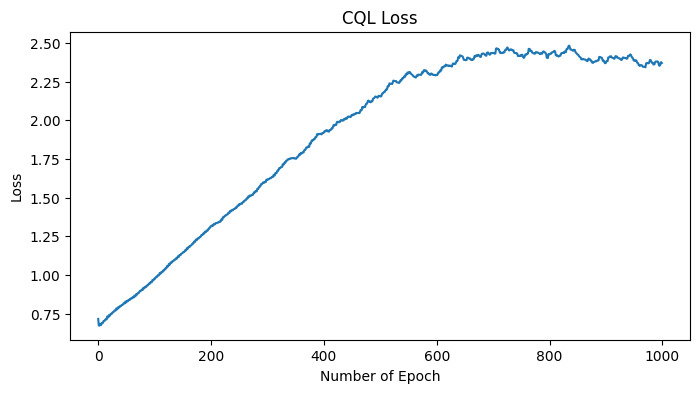

In [59]:
plot_loss(loss, "CQL Loss")

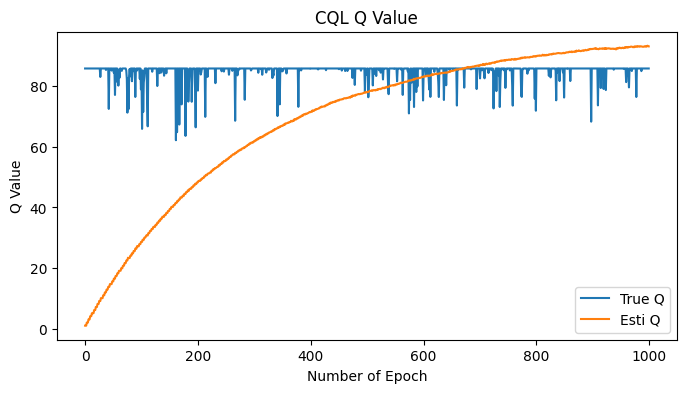

In [57]:
plot_weight(true_q, estimate_q, "CQL Q Value")